# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [2]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.special import softmax

print(tf.__version__)


2.15.0


# Загружаем разметку

In [3]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'data/fish/train'

def load_annotations():
    boxes = dict()
    for path in glob('data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                    rect['class'] = label
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=10)
            img = cv2.putText(img.copy(), annotation['annotations'][i]['class'], tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img

    def __draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=3)
            img = cv2.putText(img.copy(), counts['class'][int(rect['label'])] + ': ' + str(rect['label']), tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = __draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [4]:
boxes = load_annotations()  # загружаем разметку детекций

In [5]:
counts = pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

fish_classes = counts['class'].values
print(fish_classes)
counts

['alb' 'bet' 'dol' 'lag' 'shark' 'yft']


class  count
0    alb   1719
1    bet    200
2    dol    117
3    lag     67
4  shark    176
5    yft    734

In [6]:
# !pip install matplotlib

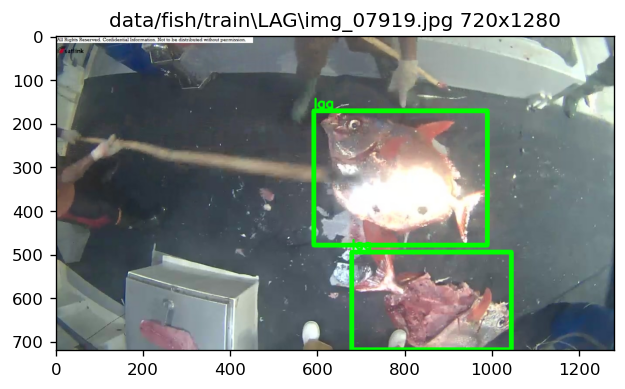

In [7]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

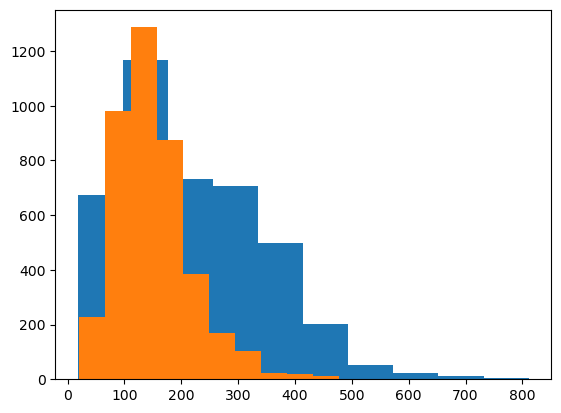

In [8]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [9]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

feature_tensor = features.layers[-1].output
print(feature_tensor.shape)



(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [10]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

# сетка якорей, размер определяется соотношением
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [11]:
num_classes = counts.shape[0]
num_classes

6

In [12]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        label = fish_classes == rect['class']

        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = np.array([*label, 1., dx, dy, dw, dh])

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

#keras.activations.softmax(x, axis=-1)

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):

            label = np.empty(6)

            label[0], label[1], label[2], label[3], label[4], label[5], conf, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(conf)
            label = softmax(label)

            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'label': np.argmax(_sigmoid(label)),
                                   'labels': label })
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

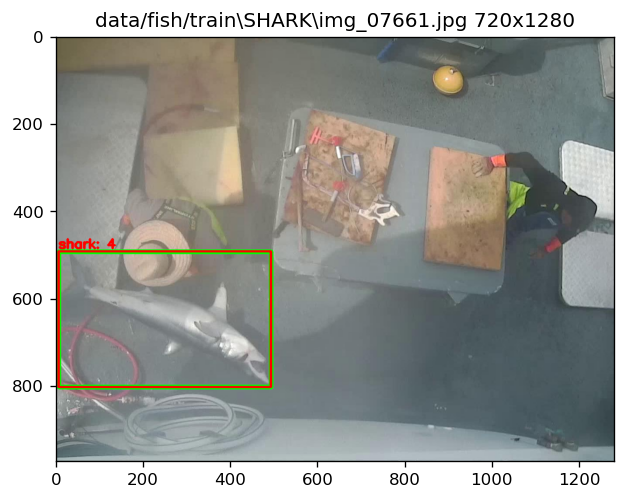

In [13]:
annotation = boxes['shark'][3]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.1)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [14]:
def classification_loss(y_true, y_pred, alpha=0.25, gamma=2.0):

    """Focal Loss"""
    y_true = y_true[..., :6]
    y_pred = y_pred[..., :6]

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y_true, logits=y_pred
    )
    probs = tf.nn.softmax(y_pred)
    alpha = tf.where(tf.equal(y_true, 1.0), alpha, (1.0 - alpha))
    pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
    loss = alpha * tf.pow(1.0 - pt, gamma) * cross_entropy

    return tf.reduce_sum(loss, axis=-1)

def class_loss(y_true, y_pred):

    y_true = y_true[..., :6]
    y_pred = y_pred[..., :6]

    cross_entropy = K.categorical_crossentropy(y_true[..., :6],
                                               y_pred[..., :6],
                                               from_logits=True)

    return cross_entropy

In [15]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0],
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)


def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    # TODO: добавьте функцию потерь для классификации детекции

    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [16]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [17]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(5,
                                kernel_size=(1, 1),
                                activation='linear',
                                kernel_regularizer='l2')(output)

# output = tf.keras.layers.Flatten()(output)
# output=tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(output)
# output=tf.keras.layers.Dense(8, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(output)
output=tf.keras.layers.Dense(11, activation='softmax')(output)
model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0     

## Обучение

In [18]:
adam = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4, decay=1e-6)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
batch_size = 32

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'HW_fishdetector_v2.hdf5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=10)  # Uncommented save_freq

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=5, restore_best_weights=True)



In [ ]:
# Use the callback in model.fit
model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          callbacks=[checkpoint, early_stopping])

## Результат работы детектора

In [17]:
# Так как модель обучалась полтора дня и до конца так и не дошел 5 эпох, то загружаю то, что успело сохраниться, пока не умер ноутбук и не пошел на перезагрузку.

model.load_weights('HW_fishdetector.hdf5')

1/1 [==============================] - 1s 1s/step


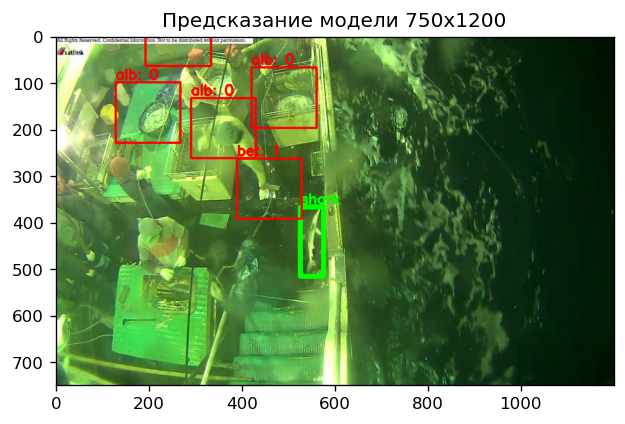

In [18]:
annotation = boxes['shark'][1]
# annotation = boxes['shark'][1]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

1/1 [==============================] - 1s 970ms/step


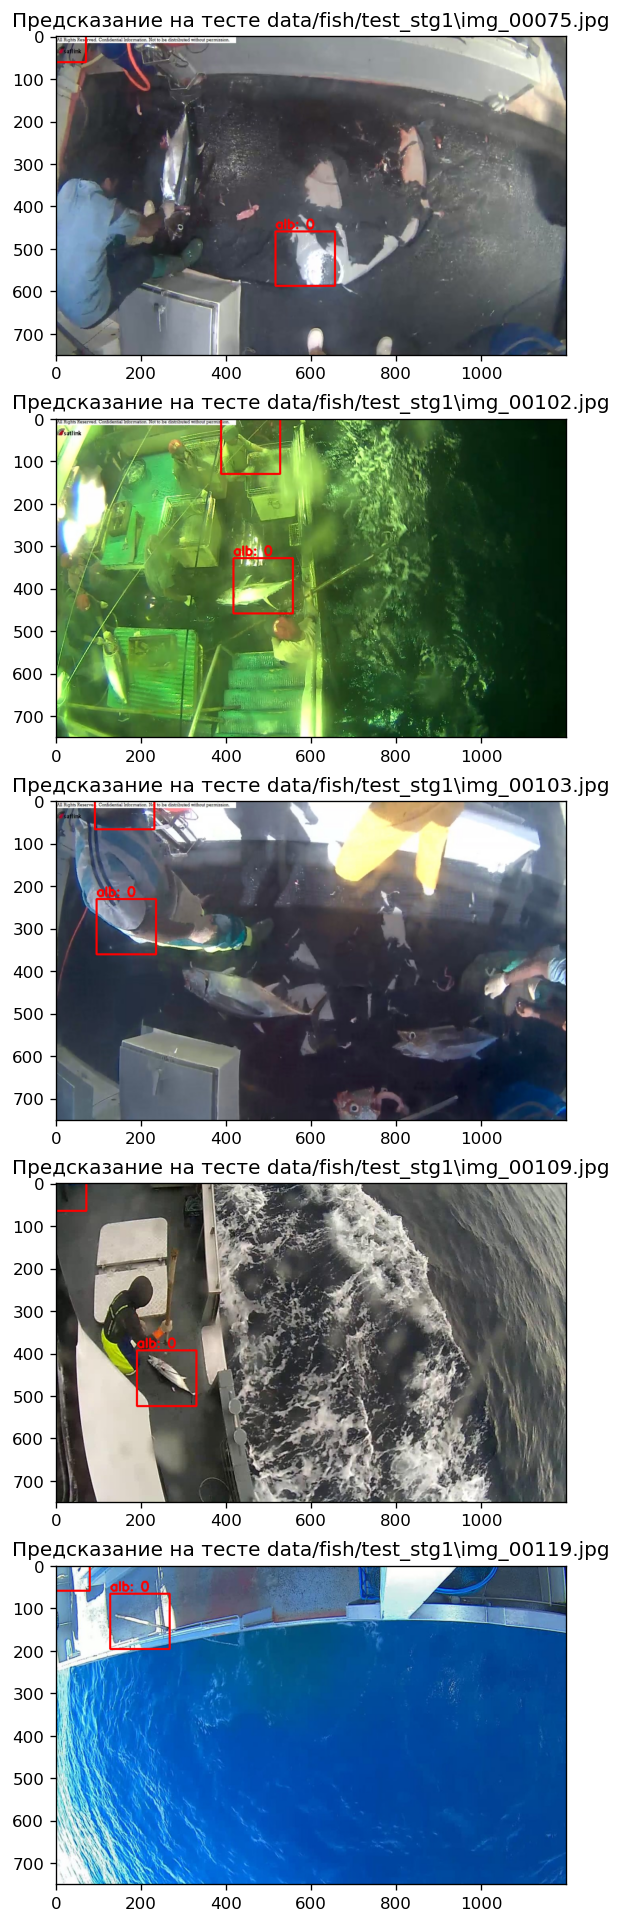

In [22]:
test_images = glob('data/fish/test_stg1/*.jpg')[0:10]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)

    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

In [24]:
# Судя по полученным результатам, модель не дообучилась, но так как нет возможности запустить на более мощной машине, попробую загрузить результаты

## Агрегация результатов

In [25]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

In [26]:
fish_classes

array(['alb', 'bet', 'dol', 'lag', 'shark', 'yft'], dtype=object)

In [25]:
# def make_predictions_t1():
#     ptable = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])

#     for i, file in enumerate(tqdm(glob('data/fish/test_stg1/*.jpg'))):
#         bn = os.path.basename(file)
#         _, sample_img = load_img(file)

#         pred = model.predict(np.array([sample_img,]))[0]
#         decoded = decode_prediction(pred, conf_thr=0.015)
#         decoded = non_max_suppression(decoded,
#                               max_output_size=1,
#                               iou_threshold=0.5)
#         decoded = decoded[0]['labels']

#         ptable.loc[i, 'image'] = bn
#         ptable.loc[i, 'ALB'] = decoded[5]
#         ptable.loc[i, 'BET'] = decoded[1]
#         ptable.loc[i, 'DOL'] = decoded[4]
#         ptable.loc[i, 'LAG'] = decoded[3]
#         ptable.loc[i, 'SHARK'] = decoded[0]
#         ptable.loc[i, 'YFT'] = decoded[2]

#         ptable.loc[i, 'NoF'] =  0.123081
#         ptable.loc[i, 'OTHER'] =  0.079142

#     return ptable


In [31]:
def make_predictions_t1t2():
    ptable = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])
    for i, file in enumerate(tqdm(glob('data/fish/test_stg1/*.jpg'))):
        bn = os.path.basename(file)
        _, sample_img = load_img(file)

        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=0.015)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)
        decoded = decoded[0]['labels']

        ptable.loc[i, 'image'] = bn
        ptable.loc[i, 'ALB'] = decoded[5]
        ptable.loc[i, 'BET'] = decoded[1]
        ptable.loc[i, 'DOL'] = decoded[4]
        ptable.loc[i, 'LAG'] = decoded[3]
        ptable.loc[i, 'SHARK'] = decoded[0]
        ptable.loc[i, 'YFT'] = decoded[2]

        ptable.loc[i, 'NoF'] = 0.123081
        ptable.loc[i, 'OTHER'] = 0.079142

#         i += 1

    for j, file in enumerate(tqdm(glob('data/fish/test_stg2/*.jpg'))):
        bn = os.path.basename(file)

        bn = "test_stg2/" + bn
        _, sample_img = load_img(file)

        pred = model.predict(np.array([sample_img,]))[0]

        decoded = decode_prediction(pred, conf_thr=0.015)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)

        decoded = decoded[0]['labels']

        ptable.loc[i + j, 'image'] = bn
        ptable.loc[i + j, 'ALB'] = decoded[5]
        ptable.loc[i + j, 'BET'] = decoded[1]
        ptable.loc[i + j, 'DOL'] = decoded[4]
        ptable.loc[i + j, 'LAG'] = decoded[3]
        ptable.loc[i + j, 'SHARK'] = decoded[0]
        ptable.loc[i + j, 'YFT'] = decoded[2]

        ptable.loc[i + j, 'NoF'] = 0.123081
        ptable.loc[i + j, 'OTHER'] = 0.079142

    return ptable

In [32]:
from tqdm import tqdm

In [33]:
import time

start_time = time.time()

In [34]:
pred_table = make_predictions_t1t2()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  0%|          | 1/1000 [00:01<19:20,  1.16s/it]

1/1 [==============================] - 1s 895ms/step


  0%|          | 2/1000 [00:02<17:33,  1.06s/it]

1/1 [==============================] - 1s 908ms/step


  0%|          | 3/1000 [00:03<16:59,  1.02s/it]

1/1 [==============================] - 1s 923ms/step


  0%|          | 4/1000 [00:04<16:49,  1.01s/it]

1/1 [==============================] - 1s 951ms/step


  0%|          | 5/1000 [00:05<16:53,  1.02s/it]

1/1 [==============================] - 1s 948ms/step


  1%|          | 6/1000 [00:06<16:54,  1.02s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 7/1000 [00:07<17:27,  1.05s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 8/1000 [00:08<17:52,  1.08s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 9/1000 [00:09<18:08,  1.10s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 10/1000 [00:10<18:08,  1.10s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 11/1000 [00:11<18:07,  1.10s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 12/1000 [00:12<18:07,  1.10s/it]

1/1 [==============================] - 1s 1s/step


  1%|▏         | 13/1000 [00:14<18:14,  1.11s/it]

1/1 [==============================] - 1s 1s/step


  1%|▏         | 14/1000 [00:15<18:29,  1.13s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 15/1000 [00:16<20:10,  1.23s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 16/1000 [00:18<21:26,  1.31s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 17/1000 [00:19<22:15,  1.36s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 18/1000 [00:21<22:52,  1.40s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 19/1000 [00:22<23:23,  1.43s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 20/1000 [00:24<24:15,  1.49s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 21/1000 [00:25<25:07,  1.54s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 22/1000 [00:27<25:24,  1.56s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 23/1000 [00:29<25:48,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 24/1000 [00:30<25:21,  1.56s/it]

1/1 [==============================] - 2s 2s/step


  2%|▎         | 25/1000 [00:32<25:54,  1.59s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 26/1000 [00:33<25:47,  1.59s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 27/1000 [00:35<25:42,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 28/1000 [00:37<25:32,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 29/1000 [00:38<25:41,  1.59s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 30/1000 [00:40<25:59,  1.61s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 31/1000 [00:41<26:16,  1.63s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 32/1000 [00:43<26:15,  1.63s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 33/1000 [00:45<25:56,  1.61s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 34/1000 [00:46<25:33,  1.59s/it]

1/1 [==============================] - 1s 1s/step


  4%|▎         | 35/1000 [00:48<25:19,  1.57s/it]

1/1 [==============================] - 1s 1s/step


  4%|▎         | 36/1000 [00:49<25:07,  1.56s/it]

1/1 [==============================] - 1s 1s/step


  4%|▎         | 37/1000 [00:51<25:09,  1.57s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 38/1000 [00:52<25:26,  1.59s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 39/1000 [00:54<25:42,  1.61s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 40/1000 [00:56<26:10,  1.64s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 41/1000 [00:58<26:34,  1.66s/it]

1/1 [==============================] - 1s 1s/step


  4%|▍         | 42/1000 [00:59<26:08,  1.64s/it]

1/1 [==============================] - 1s 1s/step


  4%|▍         | 43/1000 [01:01<25:49,  1.62s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 44/1000 [01:02<25:58,  1.63s/it]

1/1 [==============================] - 1s 1s/step


  4%|▍         | 45/1000 [01:04<25:37,  1.61s/it]

1/1 [==============================] - 1s 1s/step


  5%|▍         | 46/1000 [01:05<25:19,  1.59s/it]

1/1 [==============================] - 1s 1s/step


  5%|▍         | 47/1000 [01:07<25:04,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  5%|▍         | 48/1000 [01:09<24:54,  1.57s/it]

1/1 [==============================] - 1s 1s/step


  5%|▍         | 49/1000 [01:10<25:01,  1.58s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 50/1000 [01:12<25:41,  1.62s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 51/1000 [01:14<26:01,  1.65s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 52/1000 [01:15<25:49,  1.63s/it]

1/1 [==============================] - 1s 1s/step


  5%|▌         | 53/1000 [01:17<25:17,  1.60s/it]

1/1 [==============================] - 1s 1s/step


  5%|▌         | 54/1000 [01:18<24:52,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 55/1000 [01:20<24:51,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 56/1000 [01:21<24:46,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 57/1000 [01:23<24:39,  1.57s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 58/1000 [01:24<24:27,  1.56s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 59/1000 [01:26<24:28,  1.56s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 60/1000 [01:28<24:50,  1.59s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 61/1000 [01:29<25:25,  1.62s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 62/1000 [01:31<25:24,  1.63s/it]

1/1 [==============================] - 1s 1s/step


  6%|▋         | 63/1000 [01:33<25:10,  1.61s/it]

1/1 [==============================] - 1s 1s/step


  6%|▋         | 64/1000 [01:34<24:53,  1.60s/it]

1/1 [==============================] - 1s 1s/step


  6%|▋         | 65/1000 [01:36<24:36,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 66/1000 [01:37<24:22,  1.57s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 67/1000 [01:39<24:25,  1.57s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 68/1000 [01:40<24:30,  1.58s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 69/1000 [01:42<24:49,  1.60s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 70/1000 [01:44<24:47,  1.60s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 71/1000 [01:45<24:53,  1.61s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 72/1000 [01:47<24:23,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 73/1000 [01:48<23:49,  1.54s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 74/1000 [01:50<23:22,  1.52s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 75/1000 [01:51<23:08,  1.50s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 76/1000 [01:53<22:57,  1.49s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 77/1000 [01:54<22:57,  1.49s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 78/1000 [01:56<23:01,  1.50s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 79/1000 [01:57<23:00,  1.50s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 80/1000 [01:59<23:26,  1.53s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 81/1000 [02:00<23:56,  1.56s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 82/1000 [02:02<24:32,  1.60s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 83/1000 [02:04<24:23,  1.60s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 84/1000 [02:05<24:10,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 85/1000 [02:07<24:01,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  9%|▊         | 86/1000 [02:08<24:02,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  9%|▊         | 87/1000 [02:10<24:00,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  9%|▉         | 88/1000 [02:12<23:55,  1.57s/it]

1/1 [==============================] - 1s 1s/step


  9%|▉         | 89/1000 [02:13<23:57,  1.58s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 90/1000 [02:15<24:15,  1.60s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 91/1000 [02:17<24:50,  1.64s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 92/1000 [02:18<25:14,  1.67s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 93/1000 [02:20<25:06,  1.66s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 94/1000 [02:22<24:57,  1.65s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 95/1000 [02:23<25:01,  1.66s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 96/1000 [02:25<25:17,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 97/1000 [02:27<25:25,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 98/1000 [02:28<25:11,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 99/1000 [02:30<25:27,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 100/1000 [02:32<25:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 101/1000 [02:34<26:10,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 102/1000 [02:35<26:05,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 103/1000 [02:37<25:41,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 104/1000 [02:39<25:24,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 105/1000 [02:40<25:13,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 106/1000 [02:42<24:59,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 107/1000 [02:44<24:53,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 108/1000 [02:45<24:48,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 109/1000 [02:47<25:10,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 110/1000 [02:49<25:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 111/1000 [02:51<25:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 112/1000 [02:52<25:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 113/1000 [02:54<25:19,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 114/1000 [02:56<25:05,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 115/1000 [02:57<24:51,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 116/1000 [02:59<24:44,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 117/1000 [03:01<24:54,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 118/1000 [03:03<25:16,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 119/1000 [03:04<25:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 120/1000 [03:06<25:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 121/1000 [03:08<25:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 122/1000 [03:10<25:21,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 123/1000 [03:11<25:03,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 124/1000 [03:13<25:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▎        | 125/1000 [03:15<24:51,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 126/1000 [03:16<24:43,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 127/1000 [03:18<24:35,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 128/1000 [03:20<24:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 129/1000 [03:21<25:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 130/1000 [03:23<25:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 131/1000 [03:25<25:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 132/1000 [03:27<24:43,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 133/1000 [03:28<24:38,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 134/1000 [03:30<24:29,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 135/1000 [03:32<24:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 136/1000 [03:34<24:56,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 137/1000 [03:35<25:07,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 138/1000 [03:37<25:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 139/1000 [03:39<25:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 140/1000 [03:41<25:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 141/1000 [03:42<24:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 142/1000 [03:44<24:40,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 143/1000 [03:46<24:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 144/1000 [03:47<24:06,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 145/1000 [03:49<24:01,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 146/1000 [03:51<24:09,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 147/1000 [03:53<24:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 148/1000 [03:54<24:52,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 149/1000 [03:56<24:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 150/1000 [03:58<24:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 151/1000 [03:59<24:01,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 152/1000 [04:01<23:58,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 153/1000 [04:03<24:06,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 154/1000 [04:05<24:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 155/1000 [04:06<24:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 156/1000 [04:08<25:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 157/1000 [04:10<25:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 158/1000 [04:12<25:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 159/1000 [04:13<24:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 160/1000 [04:15<24:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 161/1000 [04:17<23:54,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 162/1000 [04:19<23:43,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 163/1000 [04:20<23:33,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 164/1000 [04:22<23:26,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 165/1000 [04:24<23:53,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 166/1000 [04:25<24:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 167/1000 [04:27<24:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 168/1000 [04:29<23:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 169/1000 [04:31<23:39,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 170/1000 [04:32<23:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 171/1000 [04:34<23:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 172/1000 [04:36<23:27,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 173/1000 [04:37<23:15,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 174/1000 [04:39<23:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 175/1000 [04:41<23:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 176/1000 [04:43<23:58,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 177/1000 [04:44<23:43,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 178/1000 [04:46<23:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 179/1000 [04:48<23:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 180/1000 [04:49<23:16,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 181/1000 [04:51<23:09,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 182/1000 [04:53<23:02,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 183/1000 [04:54<23:02,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 184/1000 [04:56<23:21,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 185/1000 [04:58<23:37,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 186/1000 [05:00<23:38,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 187/1000 [05:01<23:28,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 188/1000 [05:03<23:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 189/1000 [05:05<22:57,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 190/1000 [05:06<22:49,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 191/1000 [05:08<22:46,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 192/1000 [05:10<22:40,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 193/1000 [05:12<23:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 194/1000 [05:13<23:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 195/1000 [05:15<23:34,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 196/1000 [05:17<23:07,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 197/1000 [05:19<22:55,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 198/1000 [05:20<22:36,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 199/1000 [05:22<22:33,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 200/1000 [05:24<22:24,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 201/1000 [05:25<22:22,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 202/1000 [05:27<22:29,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 203/1000 [05:29<22:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 204/1000 [05:30<23:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 205/1000 [05:32<23:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 206/1000 [05:34<22:46,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 207/1000 [05:36<22:31,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 208/1000 [05:37<22:21,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 209/1000 [05:39<22:20,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 210/1000 [05:41<22:15,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 211/1000 [05:42<22:13,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 212/1000 [05:44<22:38,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 213/1000 [05:46<23:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 214/1000 [05:48<23:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 215/1000 [05:49<22:48,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 216/1000 [05:51<22:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 217/1000 [05:53<22:10,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 218/1000 [05:54<22:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 219/1000 [05:56<21:52,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 220/1000 [05:58<21:49,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 221/1000 [06:00<22:12,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 222/1000 [06:01<22:37,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 223/1000 [06:03<22:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 224/1000 [06:05<22:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▎       | 225/1000 [06:07<22:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 226/1000 [06:08<21:59,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 227/1000 [06:10<21:56,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 228/1000 [06:12<21:48,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 229/1000 [06:13<21:37,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 230/1000 [06:15<21:47,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 231/1000 [06:17<22:04,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 232/1000 [06:19<22:15,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 233/1000 [06:20<22:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 234/1000 [06:22<21:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 235/1000 [06:24<21:43,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 236/1000 [06:25<21:31,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 237/1000 [06:27<21:23,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 238/1000 [06:29<21:15,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 239/1000 [06:30<21:14,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 240/1000 [06:32<21:39,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 241/1000 [06:34<22:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 242/1000 [06:36<22:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 243/1000 [06:37<21:49,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 244/1000 [06:39<21:31,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 245/1000 [06:41<21:21,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 246/1000 [06:42<21:13,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 247/1000 [06:44<21:02,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 248/1000 [06:46<21:01,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 249/1000 [06:47<21:26,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 250/1000 [06:49<21:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 251/1000 [06:51<21:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 252/1000 [06:53<21:31,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 253/1000 [06:54<21:25,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 254/1000 [06:56<21:13,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 255/1000 [06:58<21:01,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 256/1000 [06:59<20:54,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 257/1000 [07:01<20:52,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 258/1000 [07:03<21:04,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 259/1000 [07:05<21:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 260/1000 [07:06<21:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 261/1000 [07:08<21:25,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 262/1000 [07:10<21:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 263/1000 [07:12<20:58,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 264/1000 [07:13<20:46,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 265/1000 [07:15<20:46,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 266/1000 [07:17<20:35,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 267/1000 [07:18<20:35,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 268/1000 [07:20<20:52,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 269/1000 [07:22<21:07,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 270/1000 [07:24<21:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 271/1000 [07:25<20:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 272/1000 [07:27<20:37,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 273/1000 [07:29<20:29,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 274/1000 [07:30<20:20,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 275/1000 [07:32<20:13,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 276/1000 [07:34<20:20,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 277/1000 [07:35<20:46,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 278/1000 [07:37<21:01,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 279/1000 [07:39<21:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 280/1000 [07:41<20:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 281/1000 [07:42<20:34,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 282/1000 [07:44<20:22,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 283/1000 [07:46<20:14,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 284/1000 [07:47<20:03,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 285/1000 [07:49<19:56,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 286/1000 [07:51<19:59,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 287/1000 [07:52<20:24,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 288/1000 [07:54<20:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 289/1000 [07:56<20:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 290/1000 [07:58<20:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 291/1000 [07:59<20:00,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 292/1000 [08:01<19:51,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 293/1000 [08:03<19:49,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 294/1000 [08:04<19:43,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 295/1000 [08:06<19:43,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 296/1000 [08:08<20:02,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 297/1000 [08:10<20:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 298/1000 [08:11<20:31,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 299/1000 [08:13<20:10,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 300/1000 [08:15<20:00,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 301/1000 [08:16<19:50,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 302/1000 [08:18<19:44,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 303/1000 [08:20<19:36,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 304/1000 [08:21<19:33,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 305/1000 [08:23<19:43,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 306/1000 [08:25<20:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 307/1000 [08:27<20:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 308/1000 [08:28<20:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 309/1000 [08:30<19:45,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 310/1000 [08:32<19:35,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 311/1000 [08:34<19:28,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 312/1000 [08:35<19:28,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 313/1000 [08:37<19:23,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 314/1000 [08:39<19:24,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 315/1000 [08:40<19:43,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 316/1000 [08:42<19:50,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 317/1000 [08:44<19:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 318/1000 [08:46<19:28,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 319/1000 [08:47<19:15,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 320/1000 [08:49<19:08,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 321/1000 [08:51<19:01,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 322/1000 [08:52<18:57,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 323/1000 [08:54<18:53,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 324/1000 [08:56<19:13,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▎      | 325/1000 [08:57<19:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 326/1000 [08:59<19:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 327/1000 [09:01<19:16,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 328/1000 [09:03<19:10,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 329/1000 [09:04<19:09,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 330/1000 [09:06<19:13,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 331/1000 [09:08<19:08,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 332/1000 [09:09<18:56,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 333/1000 [09:11<19:02,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 334/1000 [09:13<19:19,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 335/1000 [09:15<19:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 336/1000 [09:16<19:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 337/1000 [09:18<18:59,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 338/1000 [09:20<18:43,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 339/1000 [09:21<18:39,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 340/1000 [09:23<18:33,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 341/1000 [09:25<18:33,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 342/1000 [09:27<18:31,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 343/1000 [09:28<18:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 344/1000 [09:30<18:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 345/1000 [09:32<19:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 346/1000 [09:34<18:46,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 347/1000 [09:35<18:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 348/1000 [09:37<18:30,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 349/1000 [09:39<18:26,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 350/1000 [09:40<18:19,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 351/1000 [09:42<18:14,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 352/1000 [09:44<18:30,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 353/1000 [09:46<18:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 354/1000 [09:47<19:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 355/1000 [09:49<18:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 356/1000 [09:51<18:22,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 357/1000 [09:52<18:13,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 358/1000 [09:54<18:04,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 359/1000 [09:56<17:59,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 360/1000 [09:57<17:58,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 361/1000 [09:59<18:07,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 362/1000 [10:01<18:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 363/1000 [10:03<18:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 364/1000 [10:04<18:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 365/1000 [10:06<18:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 366/1000 [10:08<18:03,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 367/1000 [10:09<17:50,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 368/1000 [10:11<17:45,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 369/1000 [10:13<17:37,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 370/1000 [10:14<17:41,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 371/1000 [10:16<18:02,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 372/1000 [10:18<18:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 373/1000 [10:20<18:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 374/1000 [10:21<17:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 375/1000 [10:23<17:42,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 376/1000 [10:25<17:39,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 377/1000 [10:27<17:31,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 378/1000 [10:28<17:28,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 379/1000 [10:30<17:25,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 380/1000 [10:32<17:42,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 381/1000 [10:33<17:58,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 382/1000 [10:35<18:01,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 383/1000 [10:37<17:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 384/1000 [10:39<17:39,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 385/1000 [10:40<17:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 386/1000 [10:42<17:22,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 387/1000 [10:44<17:11,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 388/1000 [10:45<17:06,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 389/1000 [10:47<17:16,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 390/1000 [10:49<17:33,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 391/1000 [10:51<17:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 392/1000 [10:52<17:33,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 393/1000 [10:54<17:21,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 394/1000 [10:56<17:17,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 395/1000 [10:57<17:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 396/1000 [10:59<17:02,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 397/1000 [11:01<16:56,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 398/1000 [11:02<17:02,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 399/1000 [11:04<17:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 400/1000 [11:06<17:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 401/1000 [11:08<17:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 402/1000 [11:09<17:12,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 403/1000 [11:11<16:58,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 404/1000 [11:13<16:51,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 405/1000 [11:14<16:43,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 406/1000 [11:16<16:39,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 407/1000 [11:18<16:43,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 408/1000 [11:20<17:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 409/1000 [11:22<17:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 410/1000 [11:23<17:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 411/1000 [11:25<17:15,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 412/1000 [11:27<17:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 413/1000 [11:29<17:05,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 414/1000 [11:30<16:47,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 415/1000 [11:32<16:34,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 416/1000 [11:33<16:26,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 417/1000 [11:35<16:34,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 418/1000 [11:37<16:58,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 419/1000 [11:39<17:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 420/1000 [11:41<16:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 421/1000 [11:42<16:38,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 422/1000 [11:44<16:25,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 423/1000 [11:46<16:16,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 424/1000 [11:47<16:11,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▎     | 425/1000 [11:49<16:07,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 426/1000 [11:51<16:08,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 427/1000 [11:52<16:25,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 428/1000 [11:54<16:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 429/1000 [11:56<16:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 430/1000 [11:58<16:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 431/1000 [11:59<16:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 432/1000 [12:01<16:03,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 433/1000 [12:03<15:56,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 434/1000 [12:04<15:50,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 435/1000 [12:06<15:44,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 436/1000 [12:08<16:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 437/1000 [12:10<16:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 438/1000 [12:11<16:17,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 439/1000 [12:13<16:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 440/1000 [12:15<15:59,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 441/1000 [12:16<15:49,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 442/1000 [12:18<15:43,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 443/1000 [12:20<15:42,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 444/1000 [12:21<15:33,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 445/1000 [12:23<15:43,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 446/1000 [12:25<15:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 447/1000 [12:27<16:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 448/1000 [12:28<15:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 449/1000 [12:30<15:44,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 450/1000 [12:32<15:32,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 451/1000 [12:33<15:23,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 452/1000 [12:35<15:19,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 453/1000 [12:37<15:16,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 454/1000 [12:38<15:25,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 455/1000 [12:40<15:39,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 456/1000 [12:42<15:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 457/1000 [12:44<15:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 458/1000 [12:45<15:33,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 459/1000 [12:47<15:20,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 460/1000 [12:49<15:11,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 461/1000 [12:50<15:07,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 462/1000 [12:52<15:04,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 463/1000 [12:54<14:59,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 464/1000 [12:56<15:11,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 465/1000 [12:57<15:29,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 466/1000 [12:59<15:37,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 467/1000 [13:01<15:31,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 468/1000 [13:03<15:19,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 469/1000 [13:04<15:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 470/1000 [13:06<14:57,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 471/1000 [13:08<14:54,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 472/1000 [13:09<14:44,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 473/1000 [13:11<14:55,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 474/1000 [13:13<15:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 475/1000 [13:15<15:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 476/1000 [13:16<15:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 477/1000 [13:18<15:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 478/1000 [13:20<14:57,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 479/1000 [13:21<14:51,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 480/1000 [13:23<14:42,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 481/1000 [13:25<14:39,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 482/1000 [13:26<14:35,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 483/1000 [13:28<14:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 484/1000 [13:30<15:00,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 485/1000 [13:32<14:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 486/1000 [13:33<14:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 487/1000 [13:35<14:33,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 488/1000 [13:37<14:24,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 489/1000 [13:39<14:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 490/1000 [13:40<14:26,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 491/1000 [13:42<14:18,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 492/1000 [13:44<14:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 493/1000 [13:45<14:40,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 494/1000 [13:47<14:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 495/1000 [13:49<14:35,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 496/1000 [13:51<14:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 497/1000 [13:52<14:11,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 498/1000 [13:54<14:09,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 499/1000 [13:56<14:01,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 500/1000 [13:57<13:58,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 501/1000 [13:59<14:10,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 502/1000 [14:01<14:21,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 503/1000 [14:03<14:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 504/1000 [14:04<14:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 505/1000 [14:06<14:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 506/1000 [14:08<14:08,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 507/1000 [14:09<13:59,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 508/1000 [14:11<13:51,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 509/1000 [14:13<13:46,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 510/1000 [14:14<13:44,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 511/1000 [14:16<14:00,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 512/1000 [14:18<14:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 513/1000 [14:20<14:07,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 514/1000 [14:21<13:54,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 515/1000 [14:23<13:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 516/1000 [14:25<13:42,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 517/1000 [14:26<13:35,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 518/1000 [14:28<13:35,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 519/1000 [14:30<13:35,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 520/1000 [14:32<13:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 521/1000 [14:33<13:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 522/1000 [14:35<14:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 523/1000 [14:37<13:47,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 524/1000 [14:39<13:35,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▎    | 525/1000 [14:40<13:35,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 526/1000 [14:42<13:25,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 527/1000 [14:44<13:17,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 528/1000 [14:45<13:13,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 529/1000 [14:47<13:19,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 530/1000 [14:49<13:37,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 531/1000 [14:51<13:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 532/1000 [14:52<13:33,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 533/1000 [14:54<13:23,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 534/1000 [14:56<13:16,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 535/1000 [14:57<13:07,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 536/1000 [14:59<13:04,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 537/1000 [15:01<13:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 538/1000 [15:03<13:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 539/1000 [15:05<13:38,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 540/1000 [15:06<13:41,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 541/1000 [15:08<13:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 542/1000 [15:10<13:17,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 543/1000 [15:11<13:02,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 544/1000 [15:13<12:54,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 545/1000 [15:15<12:48,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 546/1000 [15:16<12:45,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 547/1000 [15:18<12:42,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 548/1000 [15:20<12:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 549/1000 [15:22<13:05,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 550/1000 [15:23<13:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 551/1000 [15:25<12:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 552/1000 [15:27<12:48,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 553/1000 [15:29<12:46,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 554/1000 [15:30<12:43,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 555/1000 [15:32<12:35,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 556/1000 [15:34<12:26,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 557/1000 [15:35<12:33,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 558/1000 [15:37<12:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 559/1000 [15:39<13:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 560/1000 [15:41<12:55,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 561/1000 [15:42<12:43,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 562/1000 [15:44<12:32,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 563/1000 [15:46<12:23,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 564/1000 [15:47<12:18,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 565/1000 [15:49<12:13,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 566/1000 [15:51<12:16,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 567/1000 [15:53<12:29,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 568/1000 [15:54<12:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 569/1000 [15:56<12:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 570/1000 [15:58<12:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 571/1000 [15:59<12:13,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 572/1000 [16:01<12:08,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 573/1000 [16:03<12:02,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 574/1000 [16:04<11:59,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▊    | 575/1000 [16:06<11:53,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 576/1000 [16:08<12:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 577/1000 [16:10<12:21,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 578/1000 [16:12<12:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 579/1000 [16:13<12:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 580/1000 [16:15<11:59,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 581/1000 [16:17<11:54,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 582/1000 [16:18<11:46,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 583/1000 [16:20<11:43,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 584/1000 [16:22<11:44,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 585/1000 [16:23<11:49,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 586/1000 [16:25<11:57,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 587/1000 [16:27<12:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 588/1000 [16:29<11:58,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 589/1000 [16:30<11:47,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 590/1000 [16:32<11:39,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 591/1000 [16:34<11:32,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 592/1000 [16:35<11:27,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 593/1000 [16:37<11:23,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 594/1000 [16:39<11:27,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 595/1000 [16:41<11:48,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 596/1000 [16:42<11:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 597/1000 [16:44<11:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 598/1000 [16:46<11:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 599/1000 [16:48<11:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 600/1000 [16:49<11:18,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 601/1000 [16:51<11:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 602/1000 [16:53<11:18,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 603/1000 [16:54<11:14,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 604/1000 [16:56<11:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 605/1000 [16:58<11:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 606/1000 [17:00<11:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 607/1000 [17:02<11:41,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 608/1000 [17:03<11:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 609/1000 [17:05<11:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 610/1000 [17:07<11:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 611/1000 [17:08<11:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 612/1000 [17:10<11:03,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 613/1000 [17:12<11:53,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 614/1000 [17:14<12:14,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 615/1000 [17:16<12:05,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 616/1000 [17:18<11:47,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 617/1000 [17:20<11:38,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 618/1000 [17:21<11:22,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 619/1000 [17:23<11:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 620/1000 [17:25<11:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 621/1000 [17:27<11:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 622/1000 [17:28<11:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 623/1000 [17:30<11:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 624/1000 [17:32<11:21,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▎   | 625/1000 [17:34<11:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 626/1000 [17:36<11:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 627/1000 [17:37<10:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 628/1000 [17:39<10:52,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 629/1000 [17:41<10:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 630/1000 [17:43<10:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 631/1000 [17:45<10:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 632/1000 [17:46<11:00,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 633/1000 [17:48<10:59,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 634/1000 [17:50<10:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 635/1000 [17:52<10:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 636/1000 [17:53<10:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 637/1000 [17:55<10:28,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 638/1000 [17:57<10:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 639/1000 [17:58<10:21,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 640/1000 [18:00<10:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 641/1000 [18:02<10:45,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 642/1000 [18:04<10:45,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 643/1000 [18:06<10:33,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 644/1000 [18:07<10:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 645/1000 [18:09<10:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 646/1000 [18:11<10:17,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 647/1000 [18:13<10:14,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 648/1000 [18:14<10:17,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 649/1000 [18:16<10:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 650/1000 [18:18<10:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 651/1000 [18:20<10:33,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 652/1000 [18:22<10:18,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 653/1000 [18:23<10:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 654/1000 [18:25<10:05,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 655/1000 [18:27<10:00,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 656/1000 [18:28<09:56,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 657/1000 [18:30<09:52,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 658/1000 [18:32<09:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 659/1000 [18:34<10:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 660/1000 [18:36<10:10,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 661/1000 [18:37<10:00,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 662/1000 [18:39<09:55,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 663/1000 [18:41<09:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 664/1000 [18:43<09:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 665/1000 [18:44<09:43,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 666/1000 [18:46<09:37,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 667/1000 [18:48<09:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 668/1000 [18:50<09:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 669/1000 [18:51<09:51,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 670/1000 [18:53<09:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 671/1000 [18:55<09:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 672/1000 [18:57<09:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 673/1000 [18:58<09:29,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 674/1000 [19:00<09:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 675/1000 [19:02<09:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 676/1000 [19:04<09:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 677/1000 [19:05<09:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 678/1000 [19:07<09:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 679/1000 [19:09<09:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 680/1000 [19:11<09:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 681/1000 [19:12<09:17,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 682/1000 [19:14<09:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 683/1000 [19:16<09:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 684/1000 [19:18<09:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 685/1000 [19:19<09:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 686/1000 [19:21<09:16,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 687/1000 [19:23<09:19,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 688/1000 [19:25<09:15,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 689/1000 [19:27<09:07,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 690/1000 [19:28<09:02,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 691/1000 [19:30<08:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 692/1000 [19:32<08:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 693/1000 [19:33<08:51,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 694/1000 [19:35<08:52,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 695/1000 [19:37<08:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 696/1000 [19:39<09:04,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 697/1000 [19:41<09:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 698/1000 [19:42<08:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 699/1000 [19:44<08:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 700/1000 [19:46<08:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 701/1000 [19:48<08:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 702/1000 [19:49<08:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 703/1000 [19:51<08:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 704/1000 [19:53<08:46,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 705/1000 [19:55<08:49,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 706/1000 [19:57<08:45,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 707/1000 [19:58<08:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 708/1000 [20:00<08:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 709/1000 [20:02<08:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 710/1000 [20:03<08:25,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 711/1000 [20:05<08:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 712/1000 [20:07<08:19,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 713/1000 [20:09<08:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 714/1000 [20:11<08:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 715/1000 [20:12<08:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 716/1000 [20:14<08:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 717/1000 [20:16<08:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 718/1000 [20:18<08:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 719/1000 [20:19<08:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 720/1000 [20:21<08:04,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 721/1000 [20:23<08:03,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 722/1000 [20:25<08:07,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 723/1000 [20:26<08:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 724/1000 [20:28<08:13,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▎  | 725/1000 [20:30<08:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 726/1000 [20:32<07:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 727/1000 [20:33<07:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 728/1000 [20:35<07:51,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 729/1000 [20:37<07:47,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 730/1000 [20:38<07:46,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 731/1000 [20:40<07:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 732/1000 [20:42<07:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 733/1000 [20:44<08:04,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 734/1000 [20:46<07:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 735/1000 [20:47<07:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 736/1000 [20:49<07:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 737/1000 [20:51<07:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 738/1000 [20:53<07:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 739/1000 [20:54<07:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 740/1000 [20:56<07:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 741/1000 [20:58<07:39,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 742/1000 [21:00<07:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 743/1000 [21:02<07:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 744/1000 [21:03<07:33,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 745/1000 [21:05<07:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 746/1000 [21:07<07:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 747/1000 [21:08<07:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 748/1000 [21:10<07:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 749/1000 [21:12<07:17,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 750/1000 [21:14<07:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 751/1000 [21:16<07:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 752/1000 [21:17<07:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 753/1000 [21:19<07:13,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 754/1000 [21:21<07:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 755/1000 [21:22<07:07,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 756/1000 [21:24<07:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 757/1000 [21:26<07:01,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 758/1000 [21:28<07:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 759/1000 [21:30<07:11,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 760/1000 [21:31<07:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 761/1000 [21:33<07:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 762/1000 [21:35<06:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 763/1000 [21:37<06:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 764/1000 [21:38<06:52,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 765/1000 [21:40<06:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 766/1000 [21:42<06:45,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 767/1000 [21:44<06:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 768/1000 [21:46<06:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 769/1000 [21:47<06:58,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 770/1000 [21:49<06:51,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 771/1000 [21:51<06:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 772/1000 [21:53<06:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 773/1000 [21:54<06:34,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 774/1000 [21:56<06:31,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 775/1000 [21:58<06:29,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 776/1000 [21:59<06:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 777/1000 [22:01<06:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 778/1000 [22:03<06:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 779/1000 [22:05<06:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 780/1000 [22:07<06:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 781/1000 [22:08<06:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 782/1000 [22:10<06:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 783/1000 [22:12<06:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 784/1000 [22:14<06:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 785/1000 [22:15<06:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 786/1000 [22:17<06:18,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 787/1000 [22:19<06:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 788/1000 [22:21<06:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 789/1000 [22:22<06:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 790/1000 [22:24<06:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 791/1000 [22:26<06:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 792/1000 [22:28<06:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 793/1000 [22:29<06:00,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 794/1000 [22:31<06:07,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 795/1000 [22:33<06:18,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 796/1000 [22:35<06:24,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 797/1000 [22:37<06:23,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 798/1000 [22:39<06:15,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 799/1000 [22:41<06:06,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 800/1000 [22:42<06:02,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 801/1000 [22:44<05:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 802/1000 [22:46<05:58,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 803/1000 [22:48<05:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 804/1000 [22:50<06:22,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 805/1000 [22:52<06:34,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 806/1000 [22:54<06:17,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 807/1000 [22:56<06:20,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 808/1000 [22:58<06:08,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 809/1000 [23:00<05:59,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 810/1000 [23:01<05:47,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 811/1000 [23:03<05:46,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 812/1000 [23:05<05:46,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 813/1000 [23:07<05:44,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 814/1000 [23:09<05:44,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 815/1000 [23:11<05:37,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 816/1000 [23:12<05:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 817/1000 [23:14<05:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 818/1000 [23:16<05:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 819/1000 [23:18<05:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 820/1000 [23:19<05:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 821/1000 [23:21<05:27,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 822/1000 [23:23<05:29,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 823/1000 [23:25<05:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 824/1000 [23:27<05:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▎ | 825/1000 [23:29<05:12,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 826/1000 [23:30<05:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 827/1000 [23:32<05:02,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 828/1000 [23:34<04:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 829/1000 [23:35<05:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 830/1000 [23:37<05:06,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 831/1000 [23:39<05:10,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 832/1000 [23:41<05:06,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 833/1000 [23:43<04:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 834/1000 [23:45<04:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 835/1000 [23:46<04:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 836/1000 [23:48<04:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 837/1000 [23:50<04:53,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 838/1000 [23:52<04:55,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 839/1000 [23:54<04:55,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 840/1000 [23:56<04:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 841/1000 [23:57<04:44,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 842/1000 [23:59<04:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 843/1000 [24:01<04:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 844/1000 [24:02<04:33,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 845/1000 [24:04<04:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 846/1000 [24:06<04:39,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 847/1000 [24:08<04:43,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 848/1000 [24:10<04:47,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 849/1000 [24:12<04:43,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 850/1000 [24:14<04:39,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 851/1000 [24:15<04:32,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 852/1000 [24:17<04:27,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 853/1000 [24:19<04:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 854/1000 [24:21<04:23,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 855/1000 [24:23<04:19,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 856/1000 [24:24<04:21,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 857/1000 [24:27<04:30,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 858/1000 [24:28<04:30,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 859/1000 [24:30<04:24,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 860/1000 [24:32<04:15,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 861/1000 [24:34<04:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 862/1000 [24:35<04:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 863/1000 [24:37<04:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 864/1000 [24:39<03:58,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 865/1000 [24:41<04:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 866/1000 [24:43<04:04,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 867/1000 [24:44<04:02,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 868/1000 [24:46<04:03,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 869/1000 [24:48<03:59,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 870/1000 [24:50<03:53,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 871/1000 [24:52<03:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 872/1000 [24:53<03:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 873/1000 [24:55<03:40,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 874/1000 [24:57<03:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 875/1000 [24:59<03:44,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 876/1000 [25:00<03:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 877/1000 [25:02<03:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 878/1000 [25:04<03:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 879/1000 [25:06<03:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 880/1000 [25:07<03:27,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 881/1000 [25:09<03:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 882/1000 [25:11<03:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 883/1000 [25:13<03:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 884/1000 [25:14<03:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 885/1000 [25:16<03:29,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 886/1000 [25:18<03:25,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 887/1000 [25:20<03:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 888/1000 [25:22<03:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 889/1000 [25:23<03:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 890/1000 [25:25<03:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 891/1000 [25:27<03:10,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 892/1000 [25:29<03:11,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 893/1000 [25:30<03:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 894/1000 [25:32<03:08,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 895/1000 [25:34<03:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 896/1000 [25:36<03:03,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 897/1000 [25:38<03:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 898/1000 [25:40<03:22,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 899/1000 [25:42<03:20,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 900/1000 [25:44<03:18,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 901/1000 [25:46<03:13,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 902/1000 [25:48<03:15,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 903/1000 [25:50<03:08,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 904/1000 [25:51<03:00,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 905/1000 [25:53<02:59,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 906/1000 [25:55<03:01,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 907/1000 [25:57<03:02,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 908/1000 [25:59<02:55,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 909/1000 [26:01<02:53,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 910/1000 [26:03<02:58,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 911/1000 [26:05<02:58,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 912/1000 [26:07<02:50,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 913/1000 [26:09<02:42,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 914/1000 [26:11<02:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 915/1000 [26:12<02:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 916/1000 [26:14<02:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 917/1000 [26:16<02:27,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 918/1000 [26:18<02:26,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 919/1000 [26:19<02:24,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 920/1000 [26:21<02:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 921/1000 [26:23<02:17,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 922/1000 [26:24<02:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 923/1000 [26:26<02:11,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 924/1000 [26:28<02:09,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▎| 925/1000 [26:29<02:06,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 926/1000 [26:31<02:05,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 927/1000 [26:33<02:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 928/1000 [26:35<02:05,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 929/1000 [26:36<02:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 930/1000 [26:38<02:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 931/1000 [26:40<01:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 932/1000 [26:42<01:56,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 933/1000 [26:43<01:54,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 934/1000 [26:45<01:52,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 935/1000 [26:47<01:50,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 936/1000 [26:49<01:52,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 937/1000 [26:50<01:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 938/1000 [26:52<01:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 939/1000 [26:54<01:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 940/1000 [26:55<01:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 941/1000 [26:57<01:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 942/1000 [26:59<01:38,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 943/1000 [27:00<01:36,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 944/1000 [27:02<01:34,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 945/1000 [27:04<01:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 946/1000 [27:06<01:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 947/1000 [27:08<01:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 948/1000 [27:09<01:29,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 949/1000 [27:11<01:27,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 950/1000 [27:13<01:25,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 951/1000 [27:14<01:23,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 952/1000 [27:16<01:21,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 953/1000 [27:18<01:19,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 954/1000 [27:19<01:18,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 955/1000 [27:21<01:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 956/1000 [27:23<01:17,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 957/1000 [27:25<01:16,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 958/1000 [27:26<01:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 959/1000 [27:28<01:10,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 960/1000 [27:30<01:08,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 961/1000 [27:31<01:06,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 962/1000 [27:33<01:04,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 963/1000 [27:35<01:02,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 964/1000 [27:37<01:01,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 965/1000 [27:38<01:01,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 966/1000 [27:40<00:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 967/1000 [27:42<00:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 968/1000 [27:44<00:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 969/1000 [27:45<00:52,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 970/1000 [27:47<00:50,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 971/1000 [27:49<00:49,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 972/1000 [27:50<00:47,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 973/1000 [27:52<00:46,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 974/1000 [27:54<00:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 975/1000 [27:56<00:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 976/1000 [27:58<00:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 977/1000 [27:59<00:39,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 978/1000 [28:01<00:37,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 979/1000 [28:03<00:35,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 980/1000 [28:04<00:33,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 981/1000 [28:06<00:32,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 982/1000 [28:08<00:30,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 983/1000 [28:09<00:29,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 984/1000 [28:11<00:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 985/1000 [28:13<00:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 986/1000 [28:15<00:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 987/1000 [28:16<00:22,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 988/1000 [28:18<00:20,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 989/1000 [28:20<00:18,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 990/1000 [28:21<00:16,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 991/1000 [28:23<00:15,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 992/1000 [28:25<00:13,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 993/1000 [28:27<00:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 994/1000 [28:28<00:10,  1.75s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 995/1000 [28:30<00:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 996/1000 [28:32<00:06,  1.72s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 997/1000 [28:33<00:05,  1.70s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 998/1000 [28:35<00:03,  1.70s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 999/1000 [28:37<00:01,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 0/12153 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|          | 1/12153 [00:01<6:02:46,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 2/12153 [00:03<6:03:47,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 3/12153 [00:05<5:59:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 4/12153 [00:06<5:49:57,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 5/12153 [00:08<5:45:54,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 6/12153 [00:10<5:43:53,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 7/12153 [00:12<5:44:01,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 8/12153 [00:13<5:41:53,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 9/12153 [00:15<5:41:43,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 10/12153 [00:17<5:44:46,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 11/12153 [00:18<5:51:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 12/12153 [00:20<5:55:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 13/12153 [00:22<5:50:39,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 14/12153 [00:24<5:49:42,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 15/12153 [00:25<5:45:43,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 16/12153 [00:27<5:43:54,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 17/12153 [00:29<5:44:39,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 18/12153 [00:30<5:46:15,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 19/12153 [00:32<5:51:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 20/12153 [00:34<5:57:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 21/12153 [00:36<6:05:23,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 22/12153 [00:38<6:01:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 23/12153 [00:39<5:55:21,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 24/12153 [00:41<5:49:16,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 25/12153 [00:43<5:46:19,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 26/12153 [00:44<5:44:09,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 27/12153 [00:46<5:42:22,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 28/12153 [00:48<5:45:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 29/12153 [00:50<5:51:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 30/12153 [00:51<5:55:07,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 31/12153 [00:53<5:55:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 32/12153 [00:55<5:50:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 33/12153 [00:57<5:46:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 34/12153 [00:58<5:43:20,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 35/12153 [01:00<5:43:48,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 36/12153 [01:02<5:41:08,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 37/12153 [01:03<5:39:58,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 38/12153 [01:05<5:46:38,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 39/12153 [01:07<5:50:11,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 40/12153 [01:09<5:56:07,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 41/12153 [01:10<5:51:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 42/12153 [01:12<5:50:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 43/12153 [01:14<5:47:38,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 44/12153 [01:15<5:45:31,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 45/12153 [01:17<5:42:31,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 46/12153 [01:19<5:41:58,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 47/12153 [01:21<5:44:36,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 48/12153 [01:22<5:51:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 49/12153 [01:24<5:55:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 50/12153 [01:26<5:52:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 51/12153 [01:28<5:47:41,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 52/12153 [01:29<5:44:46,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 53/12153 [01:31<5:43:33,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 54/12153 [01:33<5:41:06,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 55/12153 [01:34<5:38:47,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 56/12153 [01:36<5:42:57,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 57/12153 [01:38<5:48:50,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 58/12153 [01:40<5:52:17,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 59/12153 [01:41<5:52:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  0%|          | 60/12153 [01:43<5:49:29,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 61/12153 [01:45<5:47:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 62/12153 [01:46<5:43:26,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 63/12153 [01:48<5:40:34,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 64/12153 [01:50<5:38:45,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 65/12153 [01:51<5:40:24,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 66/12153 [01:53<5:50:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 67/12153 [01:55<5:55:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 68/12153 [01:57<5:58:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 69/12153 [01:59<5:54:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 70/12153 [02:00<5:50:05,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 71/12153 [02:02<5:46:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 72/12153 [02:04<5:42:53,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 73/12153 [02:05<5:41:42,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 74/12153 [02:07<5:39:31,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 75/12153 [02:09<5:43:08,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 76/12153 [02:11<5:48:19,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 77/12153 [02:12<5:57:27,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 78/12153 [02:14<5:54:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 79/12153 [02:16<5:49:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 80/12153 [02:17<5:44:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 81/12153 [02:19<5:42:47,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 82/12153 [02:21<5:40:36,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 83/12153 [02:23<5:40:45,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 84/12153 [02:24<5:42:05,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 85/12153 [02:26<5:48:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 86/12153 [02:28<5:54:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 87/12153 [02:30<5:52:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 88/12153 [02:31<5:47:00,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 89/12153 [02:33<5:43:37,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 90/12153 [02:35<5:40:45,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 91/12153 [02:36<5:39:50,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 92/12153 [02:38<5:38:18,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 93/12153 [02:40<5:38:49,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 94/12153 [02:41<5:46:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 95/12153 [02:43<5:49:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 96/12153 [02:45<5:51:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 97/12153 [02:47<5:47:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 98/12153 [02:48<5:47:07,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 99/12153 [02:50<5:43:39,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 100/12153 [02:52<5:42:02,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 101/12153 [02:53<5:39:43,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 102/12153 [02:55<5:39:15,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 103/12153 [02:57<5:41:56,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 104/12153 [02:59<5:48:52,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 105/12153 [03:01<5:54:37,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 106/12153 [03:02<5:49:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 107/12153 [03:04<5:45:21,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 108/12153 [03:06<5:41:27,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 109/12153 [03:07<5:40:09,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 110/12153 [03:09<5:37:51,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 111/12153 [03:11<5:35:59,  1.67s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 112/12153 [03:12<5:40:53,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 113/12153 [03:14<5:48:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 114/12153 [03:16<5:53:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 115/12153 [03:18<5:51:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 116/12153 [03:19<5:45:01,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 117/12153 [03:21<5:41:17,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 118/12153 [03:23<5:40:49,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 119/12153 [03:24<5:39:18,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 120/12153 [03:26<5:37:03,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 121/12153 [03:28<5:37:23,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 122/12153 [03:29<5:44:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 123/12153 [03:31<5:49:38,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 124/12153 [03:33<5:51:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 125/12153 [03:35<5:48:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 126/12153 [03:36<5:43:58,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 127/12153 [03:38<5:40:36,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 128/12153 [03:40<5:41:42,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 129/12153 [03:41<5:38:43,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 130/12153 [03:43<5:39:06,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 131/12153 [03:45<5:44:54,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 132/12153 [03:47<5:49:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 133/12153 [03:49<5:54:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 134/12153 [03:50<5:50:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 135/12153 [03:52<5:45:00,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 136/12153 [03:54<5:41:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 137/12153 [03:55<5:40:16,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 138/12153 [03:57<5:38:31,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 139/12153 [03:59<5:36:50,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 140/12153 [04:00<5:38:55,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 141/12153 [04:02<5:44:50,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 142/12153 [04:04<5:50:23,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 143/12153 [04:06<5:50:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 144/12153 [04:07<5:45:46,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 145/12153 [04:09<5:44:04,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 146/12153 [04:11<5:40:29,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 147/12153 [04:12<5:39:03,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 148/12153 [04:14<5:38:53,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 149/12153 [04:16<5:39:16,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 150/12153 [04:18<5:44:12,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 151/12153 [04:19<5:49:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 152/12153 [04:21<5:52:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 153/12153 [04:23<5:52:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 154/12153 [04:25<5:47:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 155/12153 [04:26<5:42:14,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 156/12153 [04:28<5:41:22,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 157/12153 [04:30<5:39:40,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 158/12153 [04:31<5:37:40,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 159/12153 [04:33<5:41:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 160/12153 [04:35<5:48:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 161/12153 [04:37<5:53:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 162/12153 [04:38<5:46:42,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 163/12153 [04:40<5:43:07,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 164/12153 [04:42<5:41:06,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 165/12153 [04:43<5:40:19,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 166/12153 [04:45<5:38:18,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 167/12153 [04:47<5:39:34,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 168/12153 [04:49<5:44:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 169/12153 [04:50<5:55:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 170/12153 [04:52<6:01:51,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 171/12153 [04:54<5:57:11,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 172/12153 [04:56<5:50:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 173/12153 [04:57<5:46:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 174/12153 [04:59<5:45:31,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 175/12153 [05:01<5:44:00,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 176/12153 [05:03<5:39:34,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 177/12153 [05:04<5:40:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 178/12153 [05:06<5:49:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 179/12153 [05:08<5:56:16,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 180/12153 [05:10<5:55:29,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 181/12153 [05:11<5:50:01,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 182/12153 [05:13<5:53:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 183/12153 [05:15<5:53:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 184/12153 [05:17<5:48:01,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 185/12153 [05:18<5:43:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 186/12153 [05:20<5:42:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 187/12153 [05:22<5:49:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 188/12153 [05:24<5:54:51,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 189/12153 [05:26<5:51:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 190/12153 [05:27<5:47:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 191/12153 [05:29<5:42:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 192/12153 [05:31<5:42:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 193/12153 [05:32<5:43:24,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 194/12153 [05:34<5:44:09,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 195/12153 [05:36<5:41:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 196/12153 [05:38<5:48:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 197/12153 [05:39<5:51:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 198/12153 [05:41<5:50:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 199/12153 [05:43<5:46:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 200/12153 [05:44<5:42:58,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 201/12153 [05:46<5:39:51,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 202/12153 [05:48<5:36:52,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 203/12153 [05:49<5:35:46,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 204/12153 [05:51<5:34:49,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 205/12153 [05:53<5:39:44,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 206/12153 [05:55<5:44:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 207/12153 [05:57<5:49:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 208/12153 [05:58<5:47:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 209/12153 [06:00<5:43:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 210/12153 [06:02<5:39:48,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 211/12153 [06:03<5:40:17,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 212/12153 [06:05<5:36:30,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 213/12153 [06:07<5:36:47,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 214/12153 [06:08<5:36:44,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 215/12153 [06:10<5:43:09,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 216/12153 [06:12<5:49:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 217/12153 [06:14<5:50:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 218/12153 [06:15<5:46:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 219/12153 [06:17<5:41:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 220/12153 [06:19<5:40:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 221/12153 [06:20<5:37:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 222/12153 [06:22<5:35:10,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 223/12153 [06:24<5:36:45,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 224/12153 [06:26<5:42:42,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 225/12153 [06:27<5:47:23,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 226/12153 [06:29<5:49:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 227/12153 [06:31<5:42:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 228/12153 [06:33<5:39:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 229/12153 [06:34<5:37:45,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 230/12153 [06:36<5:35:35,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 231/12153 [06:38<5:34:31,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 232/12153 [06:39<5:33:55,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 233/12153 [06:41<5:37:29,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 234/12153 [06:43<5:41:23,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 235/12153 [06:45<5:46:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 236/12153 [06:46<5:44:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 237/12153 [06:48<5:40:37,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 238/12153 [06:50<5:39:11,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 239/12153 [06:51<5:38:32,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 240/12153 [06:53<5:36:51,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 241/12153 [06:55<5:35:48,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 242/12153 [06:56<5:37:35,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 243/12153 [06:58<5:44:07,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 244/12153 [07:00<5:50:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 245/12153 [07:02<5:50:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 246/12153 [07:03<5:43:31,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 247/12153 [07:05<5:40:14,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 248/12153 [07:07<5:37:55,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 249/12153 [07:08<5:36:01,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 250/12153 [07:10<5:33:41,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 251/12153 [07:12<5:34:47,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 252/12153 [07:14<5:41:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 253/12153 [07:15<5:49:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 254/12153 [07:17<5:49:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 255/12153 [07:19<5:46:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 256/12153 [07:21<5:40:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 257/12153 [07:22<5:37:10,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 258/12153 [07:24<5:38:00,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 259/12153 [07:26<5:36:08,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 260/12153 [07:27<5:33:48,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 261/12153 [07:29<5:37:27,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 262/12153 [07:31<5:42:38,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 263/12153 [07:33<5:45:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 264/12153 [07:34<5:42:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 265/12153 [07:36<5:38:21,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 266/12153 [07:38<5:36:32,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 267/12153 [07:39<5:34:30,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 268/12153 [07:41<5:33:09,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 269/12153 [07:43<5:34:29,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 270/12153 [07:44<5:38:02,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 271/12153 [07:46<5:43:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 272/12153 [07:48<5:48:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 273/12153 [07:50<5:45:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 274/12153 [07:51<5:43:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 275/12153 [07:53<5:42:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 276/12153 [07:55<5:43:53,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 277/12153 [07:57<5:43:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 278/12153 [07:58<5:40:34,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 279/12153 [08:00<5:39:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 280/12153 [08:02<5:45:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 281/12153 [08:04<5:48:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 282/12153 [08:05<5:47:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 283/12153 [08:07<5:43:04,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 284/12153 [08:09<5:39:36,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 285/12153 [08:10<5:36:46,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 286/12153 [08:12<5:35:19,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 287/12153 [08:14<5:34:38,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 288/12153 [08:16<5:36:09,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 289/12153 [08:17<5:43:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 290/12153 [08:19<5:48:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 291/12153 [08:21<5:52:02,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 292/12153 [08:23<5:47:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 293/12153 [08:24<5:43:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 294/12153 [08:26<5:39:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 295/12153 [08:28<5:36:36,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 296/12153 [08:29<5:32:53,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 297/12153 [08:31<5:31:59,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 298/12153 [08:33<5:36:19,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 299/12153 [08:35<5:41:55,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 300/12153 [08:36<5:46:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 301/12153 [08:38<5:44:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 302/12153 [08:40<5:40:02,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 303/12153 [08:41<5:38:04,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 304/12153 [08:43<5:34:17,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 305/12153 [08:45<5:32:06,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 306/12153 [08:46<5:31:43,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 307/12153 [08:48<5:33:46,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 308/12153 [08:50<5:40:07,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 309/12153 [08:52<5:49:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 310/12153 [08:54<5:48:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 311/12153 [08:55<5:42:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 312/12153 [08:57<5:38:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 313/12153 [08:59<5:35:07,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 314/12153 [09:00<5:35:16,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 315/12153 [09:02<5:33:38,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 316/12153 [09:04<5:33:10,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 317/12153 [09:05<5:41:37,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 318/12153 [09:07<5:44:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 319/12153 [09:09<5:47:10,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 320/12153 [09:11<5:41:12,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 321/12153 [09:12<5:38:23,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 322/12153 [09:14<5:35:41,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 323/12153 [09:16<5:36:35,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 324/12153 [09:18<5:38:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 325/12153 [09:19<5:36:35,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 326/12153 [09:21<5:38:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 327/12153 [09:23<5:45:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 328/12153 [09:25<5:47:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 329/12153 [09:26<5:42:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 330/12153 [09:28<5:38:57,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 331/12153 [09:30<5:35:43,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 332/12153 [09:31<5:33:39,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 333/12153 [09:33<5:32:22,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 334/12153 [09:35<5:32:13,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 335/12153 [09:36<5:34:57,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 336/12153 [09:38<5:42:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 337/12153 [09:40<5:45:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 338/12153 [09:42<5:44:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 339/12153 [09:43<5:38:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 340/12153 [09:45<5:36:51,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 341/12153 [09:47<5:33:22,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 342/12153 [09:48<5:31:48,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 343/12153 [09:50<5:32:06,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 344/12153 [09:52<5:31:02,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 345/12153 [09:54<5:39:30,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 346/12153 [09:55<5:43:01,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 347/12153 [09:57<5:45:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 348/12153 [09:59<5:39:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 349/12153 [10:00<5:36:04,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 350/12153 [10:02<5:32:45,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 351/12153 [10:04<5:33:45,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 352/12153 [10:05<5:30:44,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 353/12153 [10:07<5:30:17,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 354/12153 [10:09<5:36:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 355/12153 [10:11<5:40:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 356/12153 [10:13<5:45:11,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 357/12153 [10:14<5:41:25,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 358/12153 [10:16<5:37:33,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 359/12153 [10:18<5:37:54,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 360/12153 [10:19<5:34:09,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 361/12153 [10:21<5:32:15,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 362/12153 [10:23<5:33:07,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 363/12153 [10:24<5:33:58,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 364/12153 [10:26<5:39:20,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 365/12153 [10:28<5:43:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 366/12153 [10:30<5:42:25,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 367/12153 [10:31<5:37:42,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 368/12153 [10:33<5:35:35,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 369/12153 [10:35<5:33:38,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 370/12153 [10:36<5:32:34,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 371/12153 [10:38<5:34:09,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 372/12153 [10:40<5:35:21,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 373/12153 [10:42<5:42:58,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 374/12153 [10:43<5:45:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 375/12153 [10:45<5:46:26,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 376/12153 [10:47<5:42:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 377/12153 [10:49<5:37:02,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 378/12153 [10:50<5:33:52,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 379/12153 [10:52<5:34:23,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 380/12153 [10:54<5:34:59,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 381/12153 [10:55<5:34:53,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 382/12153 [10:57<5:40:19,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 383/12153 [10:59<5:48:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 384/12153 [11:01<5:51:28,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 385/12153 [11:03<5:50:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 386/12153 [11:04<5:44:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 387/12153 [11:06<5:38:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 388/12153 [11:08<5:36:34,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 389/12153 [11:09<5:32:31,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 390/12153 [11:11<5:31:32,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 391/12153 [11:13<5:37:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 392/12153 [11:15<5:43:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 393/12153 [11:16<5:47:16,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 394/12153 [11:18<5:50:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 395/12153 [11:20<5:45:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 396/12153 [11:22<5:42:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 397/12153 [11:23<5:43:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 398/12153 [11:25<5:42:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 399/12153 [11:27<5:39:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 400/12153 [11:29<5:38:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 401/12153 [11:30<5:42:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 402/12153 [11:32<5:44:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 403/12153 [11:34<5:43:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 404/12153 [11:36<5:42:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 405/12153 [11:37<5:42:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 406/12153 [11:39<5:39:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 407/12153 [11:41<5:38:40,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 408/12153 [11:43<5:36:34,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 409/12153 [11:44<5:35:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 410/12153 [11:46<5:39:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 411/12153 [11:48<5:44:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 412/12153 [11:50<5:44:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 413/12153 [11:51<5:38:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 414/12153 [11:53<5:35:40,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 415/12153 [11:55<5:36:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 416/12153 [11:56<5:36:09,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 417/12153 [11:58<5:37:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 418/12153 [12:00<5:36:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 419/12153 [12:02<5:41:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 420/12153 [12:03<5:43:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 421/12153 [12:05<5:44:57,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 422/12153 [12:07<5:39:37,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 423/12153 [12:09<5:34:24,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 424/12153 [12:10<5:30:37,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 425/12153 [12:12<5:30:12,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 426/12153 [12:14<5:30:18,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 427/12153 [12:15<5:30:31,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 428/12153 [12:17<5:33:28,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 429/12153 [12:19<5:43:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 430/12153 [12:21<5:47:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 431/12153 [12:22<5:41:52,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 432/12153 [12:24<5:39:42,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 433/12153 [12:26<5:35:22,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 434/12153 [12:27<5:32:10,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 435/12153 [12:29<5:29:43,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 436/12153 [12:31<5:28:05,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 437/12153 [12:32<5:29:48,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 438/12153 [12:34<5:35:27,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 439/12153 [12:36<5:38:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 440/12153 [12:38<5:38:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 441/12153 [12:39<5:34:17,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 442/12153 [12:41<5:31:48,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 443/12153 [12:43<5:28:42,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 444/12153 [12:44<5:27:14,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 445/12153 [12:46<5:27:05,  1.68s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 446/12153 [12:48<5:26:16,  1.67s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 447/12153 [12:50<5:34:53,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 448/12153 [12:51<5:41:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 449/12153 [12:53<5:42:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 450/12153 [12:55<5:40:05,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 451/12153 [12:57<5:36:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 452/12153 [12:58<5:33:17,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 453/12153 [13:00<5:32:18,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 454/12153 [13:02<5:30:39,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 455/12153 [13:03<5:29:38,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 456/12153 [13:05<5:33:00,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 457/12153 [13:07<5:38:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 458/12153 [13:09<5:43:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 459/12153 [13:10<5:37:47,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 460/12153 [13:12<5:33:18,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 461/12153 [13:14<5:30:28,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 462/12153 [13:15<5:31:07,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 463/12153 [13:17<5:28:28,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 464/12153 [13:19<5:28:36,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 465/12153 [13:20<5:32:26,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 466/12153 [13:22<5:37:10,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 467/12153 [13:24<5:42:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 468/12153 [13:26<5:43:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 469/12153 [13:27<5:39:07,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 470/12153 [13:29<5:34:57,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 471/12153 [13:31<5:32:38,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 472/12153 [13:33<5:30:48,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 473/12153 [13:34<5:29:51,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 474/12153 [13:36<5:29:20,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 475/12153 [13:38<5:39:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 476/12153 [13:40<5:46:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 477/12153 [13:41<5:50:37,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 478/12153 [13:43<5:52:23,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 479/12153 [13:45<5:46:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 480/12153 [13:47<5:58:30,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 481/12153 [13:49<6:05:46,  1.88s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 482/12153 [13:51<6:00:26,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 483/12153 [13:52<5:53:56,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 484/12153 [13:55<6:10:21,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 485/12153 [13:57<6:23:11,  1.97s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 486/12153 [13:59<6:14:44,  1.93s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 487/12153 [14:00<6:07:35,  1.89s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 488/12153 [14:02<6:01:40,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 489/12153 [14:04<5:53:38,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 490/12153 [14:06<5:48:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 491/12153 [14:07<5:42:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 492/12153 [14:09<5:43:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 493/12153 [14:11<5:49:51,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 494/12153 [14:13<5:52:04,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 495/12153 [14:15<5:49:35,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 496/12153 [14:16<5:49:33,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 497/12153 [14:18<5:47:28,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 498/12153 [14:20<5:45:38,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 499/12153 [14:22<5:44:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 500/12153 [14:23<5:46:45,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 501/12153 [14:25<5:47:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 502/12153 [14:27<5:49:34,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 503/12153 [14:29<5:52:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 504/12153 [14:31<5:47:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 505/12153 [14:32<5:43:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 506/12153 [14:34<5:40:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 507/12153 [14:36<5:36:45,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 508/12153 [14:37<5:33:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 509/12153 [14:39<5:36:09,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 510/12153 [14:41<5:38:58,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 511/12153 [14:43<5:43:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 512/12153 [14:45<5:47:25,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 513/12153 [14:46<5:45:29,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 514/12153 [14:48<5:41:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 515/12153 [14:50<5:42:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 516/12153 [14:52<5:38:05,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 517/12153 [14:53<5:34:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 518/12153 [14:55<5:40:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 519/12153 [14:57<5:43:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 520/12153 [14:59<5:46:59,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 521/12153 [15:01<5:55:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 522/12153 [15:02<5:50:47,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 523/12153 [15:04<5:47:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 524/12153 [15:06<5:43:42,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 525/12153 [15:08<5:39:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 526/12153 [15:09<5:39:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 527/12153 [15:11<5:41:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 528/12153 [15:13<5:50:36,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 529/12153 [15:15<6:00:04,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 530/12153 [15:17<6:17:57,  1.95s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 531/12153 [15:19<6:18:31,  1.95s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 532/12153 [15:21<6:10:48,  1.91s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 533/12153 [15:23<5:59:17,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 534/12153 [15:24<5:52:11,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 535/12153 [15:26<5:46:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 536/12153 [15:28<5:41:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 537/12153 [15:30<5:46:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 538/12153 [15:32<5:48:11,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 539/12153 [15:33<5:49:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 540/12153 [15:35<5:42:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 541/12153 [15:37<5:39:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 542/12153 [15:38<5:35:41,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 543/12153 [15:40<5:33:56,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 544/12153 [15:42<5:36:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 545/12153 [15:44<5:36:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 546/12153 [15:46<5:44:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 547/12153 [15:48<5:57:56,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 548/12153 [15:50<6:07:29,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 549/12153 [15:51<6:05:31,  1.89s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 550/12153 [15:53<6:00:17,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 551/12153 [15:55<5:55:51,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 552/12153 [15:57<5:50:24,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 553/12153 [15:59<5:45:45,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 554/12153 [16:00<5:51:31,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 555/12153 [16:02<6:06:46,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 556/12153 [16:05<6:14:30,  1.94s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 557/12153 [16:06<6:10:57,  1.92s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 558/12153 [16:08<6:01:03,  1.87s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 559/12153 [16:10<5:51:38,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 560/12153 [16:12<5:45:11,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 561/12153 [16:13<5:47:32,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 562/12153 [16:15<5:44:06,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 563/12153 [16:17<5:45:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 564/12153 [16:19<5:52:13,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 565/12153 [16:21<5:53:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 566/12153 [16:23<5:53:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 567/12153 [16:24<5:46:35,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 568/12153 [16:26<5:40:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 569/12153 [16:28<5:36:40,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 570/12153 [16:29<5:35:07,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 571/12153 [16:31<5:32:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 572/12153 [16:33<5:34:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 573/12153 [16:35<5:40:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 574/12153 [16:36<5:43:17,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 575/12153 [16:38<5:51:20,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 576/12153 [16:40<5:45:28,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 577/12153 [16:42<5:40:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 578/12153 [16:43<5:34:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 579/12153 [16:45<5:31:25,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 580/12153 [16:47<5:30:10,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 581/12153 [16:49<5:32:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 582/12153 [16:50<5:40:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 583/12153 [16:52<5:44:33,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 584/12153 [16:54<5:42:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 585/12153 [16:56<5:42:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 586/12153 [16:58<5:39:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 587/12153 [16:59<5:37:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 588/12153 [17:01<5:34:03,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 589/12153 [17:03<5:31:20,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 590/12153 [17:04<5:31:21,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 591/12153 [17:06<5:38:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 592/12153 [17:08<5:42:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 593/12153 [17:10<5:42:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 594/12153 [17:11<5:35:52,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 595/12153 [17:13<5:33:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 596/12153 [17:15<5:31:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 597/12153 [17:17<5:30:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 598/12153 [17:18<5:28:07,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 599/12153 [17:20<5:28:17,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 600/12153 [17:22<5:33:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 601/12153 [17:24<5:45:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 602/12153 [17:25<5:45:43,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 603/12153 [17:27<5:38:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 604/12153 [17:29<5:34:37,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 605/12153 [17:31<5:32:35,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 606/12153 [17:32<5:30:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 607/12153 [17:34<5:29:48,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 608/12153 [17:36<5:28:56,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 609/12153 [17:37<5:34:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 610/12153 [17:39<5:37:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 611/12153 [17:41<5:40:16,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 612/12153 [17:43<5:35:25,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 613/12153 [17:44<5:33:12,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 614/12153 [17:46<5:30:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 615/12153 [17:48<5:28:18,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 616/12153 [17:49<5:26:07,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 617/12153 [17:51<5:26:57,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 618/12153 [17:53<5:30:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 619/12153 [17:55<5:35:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 620/12153 [17:57<5:41:28,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 621/12153 [17:58<5:37:17,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 622/12153 [18:00<5:33:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 623/12153 [18:02<5:31:42,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 624/12153 [18:03<5:29:27,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 625/12153 [18:05<5:28:28,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 626/12153 [18:07<5:27:20,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 627/12153 [18:09<5:28:43,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 628/12153 [18:10<5:34:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 629/12153 [18:12<5:39:06,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 630/12153 [18:14<5:38:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 631/12153 [18:16<5:34:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 632/12153 [18:17<5:32:10,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 633/12153 [18:19<5:30:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 634/12153 [18:21<5:29:36,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 635/12153 [18:22<5:28:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 636/12153 [18:24<5:33:40,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 637/12153 [18:26<5:39:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 638/12153 [18:28<5:42:08,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 639/12153 [18:30<5:41:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 640/12153 [18:31<5:37:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 641/12153 [18:33<5:34:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 642/12153 [18:35<5:35:23,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 643/12153 [18:37<5:37:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 644/12153 [18:38<5:38:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 645/12153 [18:40<5:38:25,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 646/12153 [18:42<5:44:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 647/12153 [18:44<5:49:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 648/12153 [18:46<5:48:41,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 649/12153 [18:47<5:42:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 650/12153 [18:49<5:36:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 651/12153 [18:51<5:33:43,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 652/12153 [18:53<5:31:02,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 653/12153 [18:54<5:29:27,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 654/12153 [18:56<5:32:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 655/12153 [18:58<5:37:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 656/12153 [19:00<5:43:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 657/12153 [19:02<5:46:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 658/12153 [19:03<5:41:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 659/12153 [19:05<5:40:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 660/12153 [19:07<5:36:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 661/12153 [19:08<5:33:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 662/12153 [19:10<5:32:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 663/12153 [19:12<5:29:38,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 664/12153 [19:14<5:37:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 665/12153 [19:16<5:46:41,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 666/12153 [19:18<5:53:48,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 667/12153 [19:19<5:47:21,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 668/12153 [19:21<5:43:14,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 669/12153 [19:23<5:41:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 670/12153 [19:25<5:39:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 671/12153 [19:26<5:35:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 672/12153 [19:28<5:38:48,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 673/12153 [19:30<5:56:35,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 674/12153 [19:32<6:00:25,  1.88s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 675/12153 [19:34<6:01:17,  1.89s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 676/12153 [19:36<5:53:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 677/12153 [19:38<5:51:13,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 678/12153 [19:39<5:43:42,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 679/12153 [19:41<5:39:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 680/12153 [19:43<5:34:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 681/12153 [19:44<5:39:06,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 682/12153 [19:46<5:45:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 683/12153 [19:48<5:48:06,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 684/12153 [19:50<5:47:32,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 685/12153 [19:52<5:40:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 686/12153 [19:53<5:35:30,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 687/12153 [19:55<5:32:15,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 688/12153 [19:57<5:29:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 689/12153 [19:59<5:29:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 690/12153 [20:00<5:32:42,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 691/12153 [20:02<5:39:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 692/12153 [20:04<5:45:44,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 693/12153 [20:06<5:44:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 694/12153 [20:08<5:42:25,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 695/12153 [20:09<5:40:02,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 696/12153 [20:11<5:35:13,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 697/12153 [20:13<5:33:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 698/12153 [20:14<5:29:57,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 699/12153 [20:16<5:28:50,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 700/12153 [20:18<5:35:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 701/12153 [20:20<5:40:05,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 702/12153 [20:22<5:42:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 703/12153 [20:23<5:38:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 704/12153 [20:25<5:38:18,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 705/12153 [20:27<5:36:13,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 706/12153 [20:29<5:32:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 707/12153 [20:30<5:31:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 708/12153 [20:32<5:31:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 709/12153 [20:34<5:39:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 710/12153 [20:36<5:43:47,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 711/12153 [20:38<5:44:53,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 712/12153 [20:39<5:38:59,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 713/12153 [20:41<5:33:33,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 714/12153 [20:43<5:30:09,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 715/12153 [20:44<5:27:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 716/12153 [20:46<5:26:38,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 717/12153 [20:48<5:26:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 718/12153 [20:50<5:34:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 719/12153 [20:52<5:39:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 720/12153 [20:53<5:40:43,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 721/12153 [20:55<5:37:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 722/12153 [20:57<5:46:47,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 723/12153 [20:59<5:47:52,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 724/12153 [21:01<5:46:04,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 725/12153 [21:02<5:40:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 726/12153 [21:04<5:37:39,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 727/12153 [21:06<5:40:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 728/12153 [21:08<5:45:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 729/12153 [21:10<5:44:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 730/12153 [21:11<5:38:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 731/12153 [21:13<5:34:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 732/12153 [21:15<5:32:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 733/12153 [21:16<5:30:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 734/12153 [21:18<5:28:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 735/12153 [21:20<5:27:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 736/12153 [21:22<5:33:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 737/12153 [21:24<5:40:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 738/12153 [21:25<5:43:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 739/12153 [21:27<5:39:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 740/12153 [21:29<5:35:13,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 741/12153 [21:31<5:31:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 742/12153 [21:32<5:31:06,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 743/12153 [21:34<5:30:05,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 744/12153 [21:36<5:28:47,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 745/12153 [21:38<5:32:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 746/12153 [21:39<5:37:20,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 747/12153 [21:41<5:40:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 748/12153 [21:43<5:33:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 749/12153 [21:45<5:29:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 750/12153 [21:46<5:27:27,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 751/12153 [21:48<5:25:21,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 752/12153 [21:50<5:24:41,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 753/12153 [21:51<5:23:54,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 754/12153 [21:53<5:29:09,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 755/12153 [21:55<5:33:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 756/12153 [21:57<5:38:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 757/12153 [21:58<5:36:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 758/12153 [22:00<5:32:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 759/12153 [22:02<5:30:17,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 760/12153 [22:04<5:27:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 761/12153 [22:05<5:27:43,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 762/12153 [22:07<5:28:11,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 763/12153 [22:09<5:29:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 764/12153 [22:11<5:35:20,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 765/12153 [22:13<5:39:56,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 766/12153 [22:14<5:37:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 767/12153 [22:16<5:32:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 768/12153 [22:18<5:30:34,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 769/12153 [22:19<5:30:25,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 770/12153 [22:21<5:28:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 771/12153 [22:23<5:26:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 772/12153 [22:25<5:28:37,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 773/12153 [22:26<5:37:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 774/12153 [22:28<5:42:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 775/12153 [22:30<5:39:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 776/12153 [22:32<5:34:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 777/12153 [22:33<5:31:01,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 778/12153 [22:35<5:31:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 779/12153 [22:37<5:28:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 780/12153 [22:39<5:33:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 781/12153 [22:41<5:38:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 782/12153 [22:43<5:50:45,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 783/12153 [22:45<5:57:45,  1.89s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 784/12153 [22:47<6:01:29,  1.91s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 785/12153 [22:48<6:01:52,  1.91s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 786/12153 [22:50<5:50:15,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 787/12153 [22:52<5:42:14,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 788/12153 [22:54<5:36:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 789/12153 [22:55<5:33:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 790/12153 [22:57<5:35:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 791/12153 [22:59<5:44:39,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 792/12153 [23:01<5:47:38,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 793/12153 [23:03<5:43:40,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 794/12153 [23:04<5:37:50,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 795/12153 [23:06<5:33:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 796/12153 [23:08<5:33:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 797/12153 [23:10<5:34:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 798/12153 [23:11<5:34:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 799/12153 [23:13<5:35:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 800/12153 [23:15<5:40:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 801/12153 [23:17<5:43:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 802/12153 [23:19<5:41:24,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 803/12153 [23:20<5:35:06,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 804/12153 [23:22<5:32:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 805/12153 [23:24<5:38:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 806/12153 [23:26<5:32:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 807/12153 [23:27<5:31:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 808/12153 [23:29<5:36:54,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 809/12153 [23:31<5:40:45,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 810/12153 [23:33<5:45:06,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 811/12153 [23:35<5:40:13,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 812/12153 [23:36<5:35:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 813/12153 [23:38<5:30:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 814/12153 [23:40<5:28:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 815/12153 [23:42<5:32:03,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 816/12153 [23:43<5:30:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 817/12153 [23:45<5:33:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 818/12153 [23:47<5:39:53,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 819/12153 [23:49<5:47:33,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 820/12153 [23:51<5:44:10,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 821/12153 [23:52<5:38:40,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 822/12153 [23:54<5:36:05,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 823/12153 [23:56<5:39:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 824/12153 [23:58<5:37:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 825/12153 [24:00<5:44:15,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 826/12153 [24:02<5:58:10,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 827/12153 [24:04<5:58:29,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 828/12153 [24:06<5:58:07,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 829/12153 [24:07<5:48:57,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 830/12153 [24:09<5:43:26,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 831/12153 [24:11<5:39:14,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 832/12153 [24:13<5:37:40,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 833/12153 [24:14<5:36:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 834/12153 [24:16<5:36:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 835/12153 [24:18<5:40:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 836/12153 [24:20<5:41:09,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 837/12153 [24:22<5:45:10,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 838/12153 [24:24<5:42:33,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 839/12153 [24:25<5:37:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 840/12153 [24:27<5:37:19,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 841/12153 [24:29<5:38:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 842/12153 [24:31<5:42:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 843/12153 [24:33<5:43:29,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 844/12153 [24:35<5:55:18,  1.89s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 845/12153 [24:36<5:57:23,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 846/12153 [24:38<5:53:32,  1.88s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 847/12153 [24:40<5:47:45,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 848/12153 [24:42<5:40:39,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 849/12153 [24:44<5:35:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 850/12153 [24:45<5:31:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 851/12153 [24:47<5:28:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 852/12153 [24:49<5:32:33,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 853/12153 [24:51<5:37:24,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 854/12153 [24:52<5:41:36,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 855/12153 [24:54<5:38:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 856/12153 [24:56<5:33:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 857/12153 [24:58<5:29:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 858/12153 [24:59<5:33:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 859/12153 [25:01<5:31:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 860/12153 [25:03<5:29:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 861/12153 [25:05<5:28:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 862/12153 [25:07<5:34:15,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 863/12153 [25:08<5:36:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 864/12153 [25:10<5:35:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 865/12153 [25:12<5:34:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 866/12153 [25:14<5:31:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 867/12153 [25:15<5:27:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 868/12153 [25:17<5:24:51,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 869/12153 [25:19<5:22:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 870/12153 [25:20<5:25:16,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 871/12153 [25:22<5:33:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 872/12153 [25:24<5:39:42,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 873/12153 [25:26<5:37:24,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 874/12153 [25:28<5:31:51,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 875/12153 [25:29<5:32:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 876/12153 [25:31<5:31:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 877/12153 [25:33<5:31:15,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 878/12153 [25:35<5:33:18,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 879/12153 [25:37<5:35:03,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 880/12153 [25:39<5:44:15,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 881/12153 [25:40<5:49:20,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 882/12153 [25:42<5:46:45,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 883/12153 [25:44<5:39:52,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 884/12153 [25:46<5:32:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 885/12153 [25:47<5:27:58,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 886/12153 [25:49<5:28:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 887/12153 [25:51<5:25:15,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 888/12153 [25:53<5:31:26,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 889/12153 [25:55<5:44:56,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 890/12153 [25:57<5:46:55,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 891/12153 [25:58<5:43:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 892/12153 [26:00<5:37:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 893/12153 [26:02<5:34:57,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 894/12153 [26:04<5:35:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 895/12153 [26:05<5:33:32,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 896/12153 [26:07<5:30:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 897/12153 [26:09<5:32:06,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 898/12153 [26:11<5:36:57,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 899/12153 [26:13<5:41:29,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 900/12153 [26:14<5:36:07,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 901/12153 [26:16<5:33:02,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 902/12153 [26:18<5:27:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 903/12153 [26:19<5:24:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 904/12153 [26:21<5:22:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 905/12153 [26:23<5:22:54,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 906/12153 [26:25<5:28:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 907/12153 [26:27<5:33:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 908/12153 [26:28<5:38:46,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 909/12153 [26:30<5:42:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 910/12153 [26:32<5:38:39,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 911/12153 [26:34<5:33:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 912/12153 [26:35<5:29:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 913/12153 [26:37<5:28:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 914/12153 [26:39<5:24:56,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 915/12153 [26:41<5:26:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 916/12153 [26:43<5:34:50,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 917/12153 [26:44<5:43:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 918/12153 [26:46<5:40:20,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 919/12153 [26:48<5:35:10,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 920/12153 [26:50<5:31:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 921/12153 [26:51<5:26:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 922/12153 [26:53<5:24:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 923/12153 [26:55<5:23:30,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 924/12153 [26:57<5:27:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 925/12153 [26:59<5:37:20,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 926/12153 [27:00<5:44:28,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 927/12153 [27:02<5:39:57,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 928/12153 [27:04<5:41:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 929/12153 [27:06<5:36:41,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 930/12153 [27:08<5:40:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 931/12153 [27:09<5:39:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 932/12153 [27:11<5:35:19,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 933/12153 [27:13<5:36:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 934/12153 [27:15<5:37:42,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 935/12153 [27:17<5:46:04,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 936/12153 [27:19<5:42:31,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 937/12153 [27:20<5:37:53,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 938/12153 [27:22<5:33:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 939/12153 [27:24<5:31:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 940/12153 [27:26<5:33:41,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 941/12153 [27:27<5:33:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 942/12153 [27:29<5:37:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 943/12153 [27:31<5:43:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 944/12153 [27:33<5:43:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 945/12153 [27:35<5:41:02,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 946/12153 [27:37<5:34:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 947/12153 [27:38<5:29:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 948/12153 [27:40<5:25:19,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 949/12153 [27:42<5:32:18,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 950/12153 [27:44<5:40:52,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 951/12153 [27:46<5:42:06,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 952/12153 [27:47<5:44:29,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 953/12153 [27:49<5:43:36,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 954/12153 [27:51<5:36:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 955/12153 [27:53<5:30:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 956/12153 [27:54<5:25:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 957/12153 [27:56<5:25:33,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 958/12153 [27:58<5:22:46,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 959/12153 [28:00<5:22:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 960/12153 [28:01<5:28:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 961/12153 [28:03<5:34:21,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 962/12153 [28:05<5:42:38,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 963/12153 [28:07<5:37:05,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 964/12153 [28:09<5:32:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 965/12153 [28:10<5:28:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 966/12153 [28:12<5:26:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 967/12153 [28:14<5:24:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 968/12153 [28:16<5:24:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 969/12153 [28:17<5:30:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 970/12153 [28:19<5:37:03,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 971/12153 [28:21<5:41:48,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 972/12153 [28:23<5:36:05,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 973/12153 [28:25<5:33:53,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 974/12153 [28:26<5:30:50,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 975/12153 [28:28<5:28:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 976/12153 [28:30<5:26:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 977/12153 [28:32<5:28:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 978/12153 [28:33<5:32:06,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 979/12153 [28:35<5:37:36,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 980/12153 [28:37<5:37:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 981/12153 [28:39<5:32:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 982/12153 [28:41<5:25:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 983/12153 [28:42<5:22:28,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 984/12153 [28:44<5:24:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 985/12153 [28:46<5:24:15,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 986/12153 [28:48<5:29:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 987/12153 [28:49<5:34:34,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 988/12153 [28:51<5:41:56,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 989/12153 [28:53<5:43:55,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 990/12153 [28:55<5:45:11,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 991/12153 [28:57<5:45:47,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 992/12153 [28:59<5:41:11,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 993/12153 [29:01<5:41:18,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 994/12153 [29:02<5:38:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 995/12153 [29:04<5:37:15,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 996/12153 [29:06<5:40:46,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 997/12153 [29:08<5:42:35,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 998/12153 [29:10<5:40:43,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 999/12153 [29:11<5:33:19,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1000/12153 [29:13<5:37:32,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1001/12153 [29:15<5:34:19,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1002/12153 [29:17<5:29:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1003/12153 [29:19<5:27:07,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1004/12153 [29:20<5:27:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1005/12153 [29:22<5:32:51,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1006/12153 [29:24<5:41:52,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1007/12153 [29:26<5:40:29,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1008/12153 [29:28<5:39:39,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1009/12153 [29:30<5:44:10,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1010/12153 [29:31<5:38:26,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1011/12153 [29:33<5:36:03,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1012/12153 [29:35<5:30:03,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1013/12153 [29:37<5:32:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1014/12153 [29:39<5:36:46,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1015/12153 [29:40<5:39:27,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1016/12153 [29:42<5:36:23,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1017/12153 [29:44<5:29:34,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1018/12153 [29:46<5:26:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1019/12153 [29:47<5:23:05,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1020/12153 [29:49<5:20:30,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1021/12153 [29:51<5:20:09,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1022/12153 [29:53<5:22:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1023/12153 [29:54<5:28:26,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1024/12153 [29:56<5:34:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1025/12153 [29:58<5:32:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1026/12153 [30:00<5:30:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1027/12153 [30:01<5:26:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1028/12153 [30:03<5:25:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1029/12153 [30:05<5:24:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1030/12153 [30:07<5:22:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1031/12153 [30:08<5:24:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1032/12153 [30:10<5:28:33,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1033/12153 [30:12<5:33:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1034/12153 [30:14<5:33:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1035/12153 [30:16<5:27:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1036/12153 [30:17<5:24:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1037/12153 [30:19<5:21:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1038/12153 [30:21<5:19:32,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1039/12153 [30:22<5:17:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1040/12153 [30:24<5:20:03,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1041/12153 [30:26<5:26:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1042/12153 [30:28<5:28:59,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1043/12153 [30:30<5:31:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1044/12153 [30:31<5:26:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1045/12153 [30:33<5:29:59,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1046/12153 [30:35<5:24:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1047/12153 [30:37<5:24:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1048/12153 [30:38<5:24:58,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1049/12153 [30:40<5:27:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1050/12153 [30:42<5:35:59,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1051/12153 [30:44<5:35:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1052/12153 [30:46<5:34:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1053/12153 [30:47<5:29:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1054/12153 [30:49<5:25:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1055/12153 [30:51<5:28:06,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1056/12153 [30:53<5:27:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1057/12153 [30:55<5:30:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1058/12153 [30:57<5:44:03,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1059/12153 [30:59<5:47:58,  1.88s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1060/12153 [31:00<5:53:04,  1.91s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1061/12153 [31:02<5:51:29,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1062/12153 [31:04<5:42:17,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 1063/12153 [31:06<5:34:10,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1064/12153 [31:08<5:28:42,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1065/12153 [31:09<5:26:23,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1066/12153 [31:11<5:25:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1067/12153 [31:13<5:25:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1068/12153 [31:15<5:30:41,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1069/12153 [31:16<5:35:08,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1070/12153 [31:18<5:32:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1071/12153 [31:20<5:28:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1072/12153 [31:22<5:26:25,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1073/12153 [31:23<5:25:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1074/12153 [31:25<5:23:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1075/12153 [31:27<5:21:42,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1076/12153 [31:29<5:25:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1077/12153 [31:31<5:34:49,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1078/12153 [31:33<5:38:58,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1079/12153 [31:34<5:41:58,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1080/12153 [31:36<5:37:16,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1081/12153 [31:38<5:32:15,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1082/12153 [31:40<5:32:51,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1083/12153 [31:42<5:30:22,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1084/12153 [31:43<5:30:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1085/12153 [31:45<5:37:08,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1086/12153 [31:47<5:48:26,  1.89s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1087/12153 [31:49<5:51:15,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1088/12153 [31:51<5:42:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1089/12153 [31:53<5:37:02,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1090/12153 [31:54<5:31:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1091/12153 [31:56<5:25:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1092/12153 [31:58<5:21:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1093/12153 [32:00<5:21:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1094/12153 [32:01<5:25:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1095/12153 [32:03<5:29:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1096/12153 [32:05<5:34:46,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1097/12153 [32:07<5:29:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1098/12153 [32:09<5:26:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1099/12153 [32:10<5:24:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1100/12153 [32:12<5:21:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1101/12153 [32:14<5:26:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1102/12153 [32:16<5:27:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1103/12153 [32:18<5:36:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1104/12153 [32:20<5:42:13,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1105/12153 [32:22<5:50:52,  1.91s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1106/12153 [32:23<5:50:35,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1107/12153 [32:25<5:40:41,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1108/12153 [32:27<5:35:35,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1109/12153 [32:29<5:32:50,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1110/12153 [32:30<5:25:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1111/12153 [32:32<5:25:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1112/12153 [32:34<5:32:00,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1113/12153 [32:36<5:38:52,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1114/12153 [32:38<5:36:27,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1115/12153 [32:39<5:31:23,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1116/12153 [32:41<5:27:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1117/12153 [32:43<5:24:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1118/12153 [32:45<5:22:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1119/12153 [32:46<5:21:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1120/12153 [32:48<5:21:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1121/12153 [32:50<5:26:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1122/12153 [32:52<5:30:47,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1123/12153 [32:54<5:32:41,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1124/12153 [32:55<5:29:18,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1125/12153 [32:57<5:31:47,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1126/12153 [32:59<5:29:33,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1127/12153 [33:01<5:26:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1128/12153 [33:03<5:38:44,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1129/12153 [33:05<5:40:36,  1.85s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1130/12153 [33:07<5:46:08,  1.88s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1131/12153 [33:09<5:49:08,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1132/12153 [33:10<5:49:15,  1.90s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1133/12153 [33:12<5:41:17,  1.86s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1134/12153 [33:14<5:38:30,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1135/12153 [33:16<5:35:48,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1136/12153 [33:18<5:32:18,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1137/12153 [33:19<5:30:14,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1138/12153 [33:21<5:31:02,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1139/12153 [33:23<5:36:55,  1.84s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1140/12153 [33:25<5:34:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1141/12153 [33:27<5:33:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1142/12153 [33:29<5:35:29,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1143/12153 [33:30<5:31:51,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1144/12153 [33:32<5:34:06,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1145/12153 [33:34<5:32:00,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1146/12153 [33:36<5:34:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1147/12153 [33:38<5:35:16,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1148/12153 [33:39<5:34:55,  1.83s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1149/12153 [33:41<5:34:37,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1150/12153 [33:43<5:27:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1151/12153 [33:45<5:26:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1152/12153 [33:47<5:28:45,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1153/12153 [33:48<5:30:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1154/12153 [33:50<5:28:45,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1155/12153 [33:52<5:28:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1156/12153 [33:54<5:30:20,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1157/12153 [33:56<5:38:44,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1158/12153 [33:58<5:40:19,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1159/12153 [33:59<5:33:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1160/12153 [34:01<5:28:41,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1161/12153 [34:03<5:24:23,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1162/12153 [34:05<5:22:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1163/12153 [34:06<5:19:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1164/12153 [34:08<5:17:13,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1165/12153 [34:10<5:26:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1166/12153 [34:12<5:32:51,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1167/12153 [34:14<5:35:17,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1168/12153 [34:15<5:31:25,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1169/12153 [34:17<5:26:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1170/12153 [34:19<5:21:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1171/12153 [34:21<5:19:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1172/12153 [34:22<5:17:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1173/12153 [34:24<5:23:39,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1174/12153 [34:26<5:28:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1175/12153 [34:28<5:32:42,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1176/12153 [34:30<5:31:03,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1177/12153 [34:31<5:25:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1178/12153 [34:33<5:21:37,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1179/12153 [34:35<5:18:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1180/12153 [34:37<5:26:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1181/12153 [34:38<5:26:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1182/12153 [34:40<5:27:56,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1183/12153 [34:42<5:30:59,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1184/12153 [34:44<5:32:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1185/12153 [34:46<5:31:59,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1186/12153 [34:47<5:25:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1187/12153 [34:49<5:21:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1188/12153 [34:51<5:17:02,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1189/12153 [34:52<5:16:00,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1190/12153 [34:54<5:15:12,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1191/12153 [34:56<5:15:43,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1192/12153 [34:58<5:22:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1193/12153 [35:00<5:28:50,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1194/12153 [35:02<5:32:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1195/12153 [35:03<5:31:32,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1196/12153 [35:05<5:29:13,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1197/12153 [35:07<5:25:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1198/12153 [35:09<5:23:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1199/12153 [35:10<5:22:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1200/12153 [35:12<5:21:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1201/12153 [35:14<5:26:28,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1202/12153 [35:16<5:31:34,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1203/12153 [35:18<5:31:36,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1204/12153 [35:19<5:27:44,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1205/12153 [35:21<5:26:56,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1206/12153 [35:23<5:24:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1207/12153 [35:25<5:21:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1208/12153 [35:26<5:20:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1209/12153 [35:28<5:26:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1210/12153 [35:30<5:33:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1211/12153 [35:32<5:37:56,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1212/12153 [35:34<5:36:45,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1213/12153 [35:36<5:31:13,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1214/12153 [35:37<5:30:53,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 1215/12153 [35:39<5:28:13,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1216/12153 [35:41<5:25:07,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1217/12153 [35:43<5:21:45,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1218/12153 [35:44<5:20:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1219/12153 [35:46<5:26:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1220/12153 [35:48<5:28:50,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1221/12153 [35:50<5:29:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1222/12153 [35:52<5:23:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1223/12153 [35:53<5:21:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1224/12153 [35:55<5:20:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1225/12153 [35:57<5:20:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1226/12153 [35:59<5:20:57,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1227/12153 [36:00<5:22:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1228/12153 [36:02<5:27:24,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1229/12153 [36:04<5:31:34,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1230/12153 [36:06<5:35:23,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1231/12153 [36:08<5:30:19,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1232/12153 [36:10<5:26:45,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1233/12153 [36:11<5:26:04,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1234/12153 [36:13<5:24:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1235/12153 [36:15<5:21:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1236/12153 [36:17<5:27:11,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1237/12153 [36:19<5:33:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1238/12153 [36:21<5:36:18,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1239/12153 [36:22<5:33:48,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1240/12153 [36:24<5:31:39,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1241/12153 [36:26<5:25:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1242/12153 [36:28<5:22:36,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1243/12153 [36:29<5:22:10,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1244/12153 [36:31<5:20:03,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1245/12153 [36:33<5:22:11,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1246/12153 [36:35<5:27:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1247/12153 [36:37<5:30:53,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1248/12153 [36:38<5:32:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1249/12153 [36:40<5:30:15,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1250/12153 [36:42<5:24:24,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1251/12153 [36:44<5:22:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1252/12153 [36:45<5:21:00,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1253/12153 [36:47<5:19:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1254/12153 [36:49<5:20:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1255/12153 [36:51<5:26:04,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1256/12153 [36:53<5:29:56,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1257/12153 [36:55<5:29:55,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1258/12153 [36:56<5:27:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1259/12153 [36:58<5:23:59,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1260/12153 [37:00<5:23:17,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1261/12153 [37:02<5:22:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1262/12153 [37:03<5:22:50,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1263/12153 [37:05<5:28:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1264/12153 [37:07<5:32:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1265/12153 [37:09<5:35:14,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1266/12153 [37:11<5:30:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1267/12153 [37:13<5:26:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1268/12153 [37:14<5:23:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1269/12153 [37:16<5:21:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1270/12153 [37:18<5:20:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1271/12153 [37:20<5:20:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1272/12153 [37:21<5:25:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1273/12153 [37:23<5:33:08,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1274/12153 [37:25<5:37:34,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1275/12153 [37:27<5:31:51,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1276/12153 [37:29<5:29:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1277/12153 [37:31<5:26:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1278/12153 [37:32<5:23:41,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1279/12153 [37:34<5:22:54,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1280/12153 [37:36<5:21:46,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1281/12153 [37:38<5:27:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1282/12153 [37:40<5:36:12,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1283/12153 [37:42<5:35:13,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1284/12153 [37:43<5:31:16,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1285/12153 [37:45<5:28:47,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1286/12153 [37:47<5:26:06,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1287/12153 [37:49<5:26:03,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1288/12153 [37:50<5:21:29,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1289/12153 [37:52<5:21:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1290/12153 [37:54<5:29:24,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1291/12153 [37:56<5:35:19,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1292/12153 [37:58<5:59:50,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1293/12153 [38:00<6:03:11,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1294/12153 [38:02<5:57:57,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1295/12153 [38:04<5:54:38,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1296/12153 [38:06<5:53:26,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1297/12153 [38:08<5:51:26,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1298/12153 [38:10<5:55:25,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1299/12153 [38:12<6:00:02,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1300/12153 [38:14<6:03:32,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1301/12153 [38:16<5:57:14,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1302/12153 [38:18<5:51:49,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1303/12153 [38:20<5:47:00,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1304/12153 [38:22<5:44:00,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1305/12153 [38:24<5:44:53,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1306/12153 [38:26<5:48:58,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1307/12153 [38:27<5:43:40,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1308/12153 [38:29<5:43:56,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1309/12153 [38:31<5:34:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1310/12153 [38:33<5:25:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1311/12153 [38:35<5:27:57,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1312/12153 [38:36<5:23:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1313/12153 [38:38<5:18:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1314/12153 [38:40<5:15:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1315/12153 [38:42<5:18:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1316/12153 [38:43<5:21:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1317/12153 [38:45<5:23:13,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1318/12153 [38:47<5:15:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1319/12153 [38:49<5:12:16,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1320/12153 [38:50<5:09:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1321/12153 [38:52<5:07:54,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1322/12153 [38:54<5:08:32,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1323/12153 [38:55<5:07:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1324/12153 [38:57<5:11:30,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1325/12153 [38:59<5:17:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1326/12153 [39:01<5:21:26,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1327/12153 [39:02<5:20:28,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1328/12153 [39:04<5:15:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1329/12153 [39:06<5:17:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1330/12153 [39:08<5:13:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1331/12153 [39:09<5:11:11,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1332/12153 [39:11<5:09:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1333/12153 [39:13<5:09:47,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1334/12153 [39:15<5:15:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1335/12153 [39:16<5:18:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1336/12153 [39:18<5:19:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1337/12153 [39:20<5:17:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1338/12153 [39:22<5:14:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1339/12153 [39:23<5:13:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1340/12153 [39:25<5:10:32,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1341/12153 [39:27<5:07:27,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1342/12153 [39:28<5:08:00,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1343/12153 [39:30<5:13:45,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1344/12153 [39:32<5:16:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1345/12153 [39:34<5:16:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1346/12153 [39:35<5:13:19,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1347/12153 [39:37<5:09:20,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1348/12153 [39:39<5:08:21,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1349/12153 [39:41<5:08:35,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1350/12153 [39:42<5:07:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1351/12153 [39:44<5:05:28,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1352/12153 [39:46<5:11:00,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1353/12153 [39:48<5:14:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1354/12153 [39:49<5:17:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1355/12153 [39:51<5:12:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1356/12153 [39:53<5:09:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1357/12153 [39:54<5:07:27,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1358/12153 [39:56<5:04:52,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1359/12153 [39:58<5:04:10,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1360/12153 [39:59<5:03:48,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1361/12153 [40:01<5:07:58,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1362/12153 [40:03<5:13:34,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1363/12153 [40:05<5:17:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1364/12153 [40:07<5:15:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1365/12153 [40:08<5:13:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1366/12153 [40:10<5:10:16,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 1367/12153 [40:12<5:07:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1368/12153 [40:13<5:08:06,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1369/12153 [40:15<5:05:31,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1370/12153 [40:17<5:08:12,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1371/12153 [40:19<5:14:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1372/12153 [40:20<5:17:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1373/12153 [40:22<5:16:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1374/12153 [40:24<5:14:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1375/12153 [40:26<5:10:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1376/12153 [40:27<5:09:06,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1377/12153 [40:29<5:08:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1378/12153 [40:31<5:06:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1379/12153 [40:32<5:07:00,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1380/12153 [40:34<5:12:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1381/12153 [40:36<5:16:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1382/12153 [40:38<5:14:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1383/12153 [40:39<5:11:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1384/12153 [40:41<5:11:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1385/12153 [40:43<5:09:15,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1386/12153 [40:45<5:07:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1387/12153 [40:46<5:05:33,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1388/12153 [40:48<5:04:29,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1389/12153 [40:50<5:09:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1390/12153 [40:51<5:14:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1391/12153 [40:53<5:15:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1392/12153 [40:55<5:11:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1393/12153 [40:57<5:09:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1394/12153 [40:58<5:08:42,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1395/12153 [41:00<5:08:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1396/12153 [41:02<5:07:12,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 1397/12153 [41:03<5:06:27,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1398/12153 [41:05<5:09:30,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1399/12153 [41:07<5:14:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1400/12153 [41:09<5:24:49,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1401/12153 [41:11<5:19:38,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1402/12153 [41:12<5:15:07,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1403/12153 [41:14<5:14:37,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1404/12153 [41:16<5:11:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1405/12153 [41:18<5:12:00,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1406/12153 [41:19<5:08:50,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1407/12153 [41:21<5:09:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1408/12153 [41:23<5:14:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1409/12153 [41:25<5:16:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1410/12153 [41:26<5:13:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1411/12153 [41:28<5:09:16,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1412/12153 [41:30<5:06:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1413/12153 [41:31<5:05:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1414/12153 [41:33<5:03:08,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1415/12153 [41:35<5:02:50,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1416/12153 [41:36<5:04:29,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1417/12153 [41:38<5:11:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1418/12153 [41:40<5:15:34,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1419/12153 [41:42<5:18:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1420/12153 [41:44<5:12:16,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1421/12153 [41:45<5:08:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1422/12153 [41:47<5:06:32,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1423/12153 [41:49<5:03:54,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1424/12153 [41:50<5:03:04,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1425/12153 [41:52<5:03:19,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1426/12153 [41:54<5:09:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1427/12153 [41:56<5:13:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1428/12153 [41:57<5:15:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1429/12153 [41:59<5:10:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1430/12153 [42:01<5:06:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1431/12153 [42:02<5:04:59,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1432/12153 [42:04<5:03:42,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1433/12153 [42:06<5:03:42,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1434/12153 [42:08<5:03:40,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1435/12153 [42:09<5:08:07,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1436/12153 [42:11<5:13:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1437/12153 [42:13<5:16:25,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1438/12153 [42:15<5:12:33,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1439/12153 [42:16<5:08:56,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1440/12153 [42:18<5:05:30,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1441/12153 [42:20<5:04:53,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1442/12153 [42:21<5:02:39,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1443/12153 [42:23<5:02:52,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1444/12153 [42:25<5:06:35,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1445/12153 [42:27<5:11:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1446/12153 [42:28<5:14:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1447/12153 [42:30<5:14:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1448/12153 [42:32<5:11:14,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1449/12153 [42:34<5:08:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1450/12153 [42:35<5:05:06,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1451/12153 [42:37<5:02:34,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1452/12153 [42:39<5:01:41,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1453/12153 [42:40<5:03:53,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1454/12153 [42:42<5:09:00,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1455/12153 [42:44<5:15:13,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1456/12153 [42:46<5:15:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1457/12153 [42:47<5:11:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1458/12153 [42:49<5:09:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1459/12153 [42:51<5:07:12,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1460/12153 [42:53<5:06:27,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1461/12153 [42:54<5:04:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1462/12153 [42:56<5:02:13,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1463/12153 [42:58<5:08:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1464/12153 [43:00<5:12:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1465/12153 [43:01<5:15:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1466/12153 [43:03<5:10:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1467/12153 [43:05<5:08:21,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1468/12153 [43:06<5:07:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1469/12153 [43:08<5:05:10,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1470/12153 [43:10<5:07:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1471/12153 [43:12<5:08:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1472/12153 [43:13<5:12:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1473/12153 [43:15<5:17:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1474/12153 [43:17<5:17:34,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1475/12153 [43:19<5:11:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1476/12153 [43:20<5:06:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1477/12153 [43:22<5:03:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1478/12153 [43:24<5:04:10,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1479/12153 [43:26<5:08:04,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1480/12153 [43:27<5:06:21,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1481/12153 [43:29<5:07:45,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1482/12153 [43:31<5:10:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1483/12153 [43:33<5:14:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1484/12153 [43:34<5:12:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1485/12153 [43:36<5:08:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1486/12153 [43:38<5:05:39,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1487/12153 [43:39<5:02:16,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1488/12153 [43:41<5:00:51,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1489/12153 [43:43<4:59:33,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1490/12153 [43:45<5:02:57,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1491/12153 [43:46<5:08:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1492/12153 [43:48<5:12:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1493/12153 [43:50<5:11:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1494/12153 [43:52<5:07:55,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1495/12153 [43:53<5:04:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1496/12153 [43:55<5:00:56,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1497/12153 [43:57<5:00:19,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1498/12153 [43:58<4:59:53,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1499/12153 [44:00<5:00:27,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1500/12153 [44:02<5:06:10,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1501/12153 [44:04<5:11:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1502/12153 [44:05<5:12:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1503/12153 [44:07<5:07:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1504/12153 [44:09<5:05:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1505/12153 [44:10<5:03:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1506/12153 [44:12<5:02:10,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1507/12153 [44:14<5:00:12,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1508/12153 [44:15<5:00:36,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1509/12153 [44:17<5:03:32,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1510/12153 [44:19<5:09:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1511/12153 [44:21<5:13:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1512/12153 [44:23<5:10:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1513/12153 [44:24<5:09:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1514/12153 [44:26<5:06:02,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1515/12153 [44:28<5:04:37,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1516/12153 [44:29<5:03:37,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1517/12153 [44:31<5:01:09,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1518/12153 [44:33<5:04:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 1519/12153 [44:35<5:08:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1520/12153 [44:36<5:11:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1521/12153 [44:38<5:10:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1522/12153 [44:40<5:06:39,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1523/12153 [44:41<5:03:01,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1524/12153 [44:43<5:01:58,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1525/12153 [44:45<5:00:48,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1526/12153 [44:47<4:59:06,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1527/12153 [44:48<4:59:40,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1528/12153 [44:50<5:05:22,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1529/12153 [44:52<5:12:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1530/12153 [44:54<5:12:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1531/12153 [44:55<5:09:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1532/12153 [44:57<5:04:47,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1533/12153 [44:59<5:02:56,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1534/12153 [45:00<5:02:04,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1535/12153 [45:02<4:59:54,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1536/12153 [45:04<4:58:23,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1537/12153 [45:06<5:03:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1538/12153 [45:07<5:07:58,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1539/12153 [45:09<5:10:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1540/12153 [45:11<5:06:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1541/12153 [45:13<5:08:14,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1542/12153 [45:14<5:05:03,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1543/12153 [45:16<5:07:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1544/12153 [45:18<5:02:35,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1545/12153 [45:19<5:01:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1546/12153 [45:21<5:05:10,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1547/12153 [45:23<5:08:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1548/12153 [45:25<5:16:09,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1549/12153 [45:27<5:17:20,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1550/12153 [45:28<5:11:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1551/12153 [45:30<5:08:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1552/12153 [45:32<5:05:49,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1553/12153 [45:33<5:03:16,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1554/12153 [45:35<5:01:28,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1555/12153 [45:37<5:02:51,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1556/12153 [45:39<5:08:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1557/12153 [45:40<5:11:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1558/12153 [45:42<5:11:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1559/12153 [45:44<5:10:10,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1560/12153 [45:46<5:07:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1561/12153 [45:47<5:04:07,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1562/12153 [45:49<5:01:07,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1563/12153 [45:51<4:59:54,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1564/12153 [45:52<5:00:47,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1565/12153 [45:54<5:05:46,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1566/12153 [45:56<5:08:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1567/12153 [45:58<5:09:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1568/12153 [45:59<5:06:52,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1569/12153 [46:01<5:03:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1570/12153 [46:03<5:00:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1571/12153 [46:04<4:58:24,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1572/12153 [46:06<4:57:55,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1573/12153 [46:08<4:57:34,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1574/12153 [46:10<5:05:15,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1575/12153 [46:11<5:08:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1576/12153 [46:13<5:08:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1577/12153 [46:15<5:05:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1578/12153 [46:17<5:02:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1579/12153 [46:18<5:00:35,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1580/12153 [46:20<5:00:15,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1581/12153 [46:22<4:58:26,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1582/12153 [46:23<4:57:41,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1583/12153 [46:25<5:00:50,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1584/12153 [46:27<5:05:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1585/12153 [46:29<5:09:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1586/12153 [46:30<5:06:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1587/12153 [46:32<5:02:15,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1588/12153 [46:34<5:01:21,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1589/12153 [46:35<4:59:50,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1590/12153 [46:37<4:57:53,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1591/12153 [46:39<4:57:24,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1592/12153 [46:40<4:59:41,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1593/12153 [46:42<5:04:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1594/12153 [46:44<5:09:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1595/12153 [46:46<5:10:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1596/12153 [46:48<5:05:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1597/12153 [46:49<5:02:35,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1598/12153 [46:51<5:00:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1599/12153 [46:53<4:58:19,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1600/12153 [46:54<4:57:20,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1601/12153 [46:56<4:58:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1602/12153 [46:58<5:02:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1603/12153 [47:00<5:13:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1604/12153 [47:02<5:18:34,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1605/12153 [47:03<5:17:39,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1606/12153 [47:05<5:17:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1607/12153 [47:07<5:13:28,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1608/12153 [47:09<5:08:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1609/12153 [47:10<5:04:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1610/12153 [47:12<5:01:50,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1611/12153 [47:14<5:08:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1612/12153 [47:16<5:15:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1613/12153 [47:17<5:15:36,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1614/12153 [47:19<5:07:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1615/12153 [47:21<5:04:09,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1616/12153 [47:22<5:01:34,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1617/12153 [47:24<5:00:38,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1618/12153 [47:26<4:59:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1619/12153 [47:28<4:59:46,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1620/12153 [47:29<5:07:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1621/12153 [47:31<5:12:29,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1622/12153 [47:33<5:22:19,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1623/12153 [47:35<5:16:47,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1624/12153 [47:37<5:10:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1625/12153 [47:38<5:06:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1626/12153 [47:40<5:02:24,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1627/12153 [47:42<4:59:55,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1628/12153 [47:43<4:57:58,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1629/12153 [47:45<5:05:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1630/12153 [47:47<5:08:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1631/12153 [47:49<5:11:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1632/12153 [47:51<5:07:17,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1633/12153 [47:52<5:02:45,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1634/12153 [47:54<4:59:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1635/12153 [47:56<4:59:04,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1636/12153 [47:57<4:57:51,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1637/12153 [47:59<4:56:59,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1638/12153 [48:01<4:59:00,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1639/12153 [48:02<5:03:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1640/12153 [48:04<5:07:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1641/12153 [48:06<5:06:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1642/12153 [48:08<5:04:31,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1643/12153 [48:09<5:01:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1644/12153 [48:11<4:58:28,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1645/12153 [48:13<4:57:26,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1646/12153 [48:14<4:55:54,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1647/12153 [48:16<4:56:24,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1648/12153 [48:18<5:03:03,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1649/12153 [48:20<5:07:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1650/12153 [48:22<5:08:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1651/12153 [48:23<5:05:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1652/12153 [48:25<5:02:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1653/12153 [48:27<5:00:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1654/12153 [48:28<5:00:36,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1655/12153 [48:30<4:58:45,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1656/12153 [48:32<4:57:27,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1657/12153 [48:33<5:01:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1658/12153 [48:35<5:07:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1659/12153 [48:37<5:10:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1660/12153 [48:39<5:04:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1661/12153 [48:40<5:01:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1662/12153 [48:42<4:58:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1663/12153 [48:44<4:57:50,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1664/12153 [48:46<4:57:53,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1665/12153 [48:47<4:58:31,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1666/12153 [48:49<5:01:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1667/12153 [48:51<5:08:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1668/12153 [48:53<5:10:00,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1669/12153 [48:54<5:06:05,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1670/12153 [48:56<5:01:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1671/12153 [48:58<5:00:08,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1672/12153 [48:59<4:58:21,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1673/12153 [49:01<4:57:02,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1674/12153 [49:03<4:56:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1675/12153 [49:05<4:57:11,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1676/12153 [49:06<5:03:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1677/12153 [49:08<5:07:21,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1678/12153 [49:10<5:05:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1679/12153 [49:12<5:01:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1680/12153 [49:13<4:59:59,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1681/12153 [49:15<5:00:22,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1682/12153 [49:17<5:02:27,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1683/12153 [49:18<4:59:09,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1684/12153 [49:20<4:57:44,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1685/12153 [49:22<5:03:29,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1686/12153 [49:24<5:07:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1687/12153 [49:26<5:09:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1688/12153 [49:27<5:02:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1689/12153 [49:29<5:00:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1690/12153 [49:31<4:57:51,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1691/12153 [49:32<4:57:24,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1692/12153 [49:34<4:55:20,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1693/12153 [49:36<4:57:08,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1694/12153 [49:37<5:00:35,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1695/12153 [49:39<5:04:31,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1696/12153 [49:41<5:07:15,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1697/12153 [49:43<5:03:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1698/12153 [49:44<5:00:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1699/12153 [49:46<5:00:24,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1700/12153 [49:48<4:59:06,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1701/12153 [49:49<4:57:19,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1702/12153 [49:51<4:56:04,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1703/12153 [49:53<4:59:33,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1704/12153 [49:55<5:06:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1705/12153 [49:57<5:12:45,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1706/12153 [49:59<5:16:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1707/12153 [50:00<5:17:54,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1708/12153 [50:02<5:20:15,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1709/12153 [50:04<5:15:32,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1710/12153 [50:06<5:09:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1711/12153 [50:07<5:05:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1712/12153 [50:09<5:04:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1713/12153 [50:11<5:09:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1714/12153 [50:13<5:11:16,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1715/12153 [50:15<5:06:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1716/12153 [50:16<5:02:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1717/12153 [50:18<5:10:04,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1718/12153 [50:20<5:16:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1719/12153 [50:22<5:18:40,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1720/12153 [50:24<5:21:17,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1721/12153 [50:26<5:30:14,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1722/12153 [50:28<5:41:22,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1723/12153 [50:30<5:42:22,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1724/12153 [50:32<5:36:46,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1725/12153 [50:34<5:41:04,  1.96s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1726/12153 [50:37<6:22:58,  2.20s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1727/12153 [50:38<6:02:45,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1728/12153 [50:40<5:52:21,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1729/12153 [50:42<5:58:52,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1730/12153 [50:44<5:54:56,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1731/12153 [50:46<5:50:32,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1732/12153 [50:48<5:43:52,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1733/12153 [50:50<5:31:04,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1734/12153 [50:52<5:22:48,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1735/12153 [50:53<5:14:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1736/12153 [50:55<5:08:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1737/12153 [50:57<5:09:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1738/12153 [50:59<5:15:01,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1739/12153 [51:01<5:15:47,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1740/12153 [51:02<5:10:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1741/12153 [51:04<5:06:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1742/12153 [51:06<5:03:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1743/12153 [51:07<5:00:40,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1744/12153 [51:09<4:58:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1745/12153 [51:11<4:57:52,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1746/12153 [51:13<5:00:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1747/12153 [51:14<5:05:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1748/12153 [51:16<5:11:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1749/12153 [51:18<5:17:57,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1750/12153 [51:20<5:13:00,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1751/12153 [51:22<5:10:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1752/12153 [51:24<5:11:11,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1753/12153 [51:25<5:06:33,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1754/12153 [51:27<5:07:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1755/12153 [51:29<5:08:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1756/12153 [51:31<5:11:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1757/12153 [51:33<5:14:07,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1758/12153 [51:34<5:10:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1759/12153 [51:36<5:09:21,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1760/12153 [51:38<5:04:49,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1761/12153 [51:39<5:00:52,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1762/12153 [51:41<5:00:43,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1763/12153 [51:43<5:00:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1764/12153 [51:45<5:02:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1765/12153 [51:46<5:06:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1766/12153 [51:48<5:11:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1767/12153 [51:50<5:08:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1768/12153 [51:52<5:06:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1769/12153 [51:54<5:04:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1770/12153 [51:55<5:00:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1771/12153 [51:57<5:01:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1772/12153 [51:59<4:59:49,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1773/12153 [52:00<5:02:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1774/12153 [52:02<5:11:42,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1775/12153 [52:04<5:14:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1776/12153 [52:06<5:13:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1777/12153 [52:08<5:07:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1778/12153 [52:09<5:01:46,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1779/12153 [52:11<4:57:39,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1780/12153 [52:13<4:56:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1781/12153 [52:14<4:54:50,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1782/12153 [52:16<4:55:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1783/12153 [52:18<5:00:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1784/12153 [52:20<5:03:30,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1785/12153 [52:22<5:04:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1786/12153 [52:23<5:03:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1787/12153 [52:25<5:02:01,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1788/12153 [52:27<4:59:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1789/12153 [52:28<4:57:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1790/12153 [52:30<4:59:04,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1791/12153 [52:32<5:01:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1792/12153 [52:34<5:08:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1793/12153 [52:36<5:14:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1794/12153 [52:38<5:13:36,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1795/12153 [52:39<5:07:32,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1796/12153 [52:41<5:03:55,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1797/12153 [52:43<4:59:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1798/12153 [52:44<5:00:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1799/12153 [52:46<5:04:34,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1800/12153 [52:48<5:04:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1801/12153 [52:50<5:13:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1802/12153 [52:52<5:12:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1803/12153 [52:54<5:12:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1804/12153 [52:55<5:06:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1805/12153 [52:57<5:02:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1806/12153 [52:59<5:04:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1807/12153 [53:00<5:02:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1808/12153 [53:02<4:59:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1809/12153 [53:04<5:04:33,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1810/12153 [53:06<5:14:51,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1811/12153 [53:08<5:16:54,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1812/12153 [53:10<5:16:36,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1813/12153 [53:11<5:10:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1814/12153 [53:13<5:12:02,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1815/12153 [53:15<5:07:06,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1816/12153 [53:17<5:04:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1817/12153 [53:19<5:08:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1818/12153 [53:20<5:08:14,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1819/12153 [53:22<5:10:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1820/12153 [53:24<5:14:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1821/12153 [53:26<5:15:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1822/12153 [53:28<5:09:44,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1823/12153 [53:29<5:03:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1824/12153 [53:31<4:59:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1825/12153 [53:33<4:58:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1826/12153 [53:35<5:03:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1827/12153 [53:36<5:04:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1828/12153 [53:38<5:07:44,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1829/12153 [53:40<5:19:30,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1830/12153 [53:42<5:16:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1831/12153 [53:44<5:10:25,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1832/12153 [53:45<5:08:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1833/12153 [53:47<5:05:01,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1834/12153 [53:49<5:08:57,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1835/12153 [53:51<5:03:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1836/12153 [53:52<4:59:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1837/12153 [53:54<5:04:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1838/12153 [53:56<5:11:57,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1839/12153 [53:58<5:12:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1840/12153 [54:00<5:11:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1841/12153 [54:02<5:09:13,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1842/12153 [54:03<5:07:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1843/12153 [54:05<5:04:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1844/12153 [54:07<5:05:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1845/12153 [54:09<5:08:57,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1846/12153 [54:11<5:14:43,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1847/12153 [54:12<5:14:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1848/12153 [54:14<5:15:37,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1849/12153 [54:16<5:12:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1850/12153 [54:18<5:09:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1851/12153 [54:20<5:03:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1852/12153 [54:21<5:01:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1853/12153 [54:23<5:02:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1854/12153 [54:25<5:04:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1855/12153 [54:27<5:12:29,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1856/12153 [54:29<5:12:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1857/12153 [54:30<5:10:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1858/12153 [54:32<5:03:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1859/12153 [54:34<4:59:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1860/12153 [54:35<4:54:36,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1861/12153 [54:37<4:54:33,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1862/12153 [54:39<4:55:21,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1863/12153 [54:41<5:00:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1864/12153 [54:42<5:05:17,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1865/12153 [54:44<5:09:39,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1866/12153 [54:46<5:10:24,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1867/12153 [54:48<5:06:13,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1868/12153 [54:50<5:05:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1869/12153 [54:51<5:01:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1870/12153 [54:53<4:56:23,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1871/12153 [54:55<4:54:50,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1872/12153 [54:56<4:54:37,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1873/12153 [54:58<5:01:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1874/12153 [55:00<5:06:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1875/12153 [55:02<5:04:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1876/12153 [55:04<5:00:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1877/12153 [55:05<4:57:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1878/12153 [55:07<4:56:37,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1879/12153 [55:09<4:54:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1880/12153 [55:10<4:54:37,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1881/12153 [55:12<4:58:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1882/12153 [55:14<5:04:03,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1883/12153 [55:16<5:12:11,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1884/12153 [55:18<5:21:07,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1885/12153 [55:20<5:15:26,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1886/12153 [55:22<5:11:29,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1887/12153 [55:23<5:12:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1888/12153 [55:25<5:10:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1889/12153 [55:27<5:09:05,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1890/12153 [55:29<5:09:34,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1891/12153 [55:31<5:15:09,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1892/12153 [55:33<5:16:13,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1893/12153 [55:34<5:13:45,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1894/12153 [55:36<5:11:51,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1895/12153 [55:38<5:11:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1896/12153 [55:40<5:12:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1897/12153 [55:42<5:08:59,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1898/12153 [55:43<5:06:00,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1899/12153 [55:45<5:08:41,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1900/12153 [55:47<5:11:04,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1901/12153 [55:49<5:11:01,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1902/12153 [55:51<5:09:56,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1903/12153 [55:52<5:02:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1904/12153 [55:54<4:57:53,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1905/12153 [55:56<4:54:45,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1906/12153 [55:57<4:52:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1907/12153 [55:59<4:51:00,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1908/12153 [56:01<4:54:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1909/12153 [56:03<4:58:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1910/12153 [56:04<5:01:26,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1911/12153 [56:06<4:59:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1912/12153 [56:08<4:56:50,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1913/12153 [56:10<4:53:07,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1914/12153 [56:11<4:50:28,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1915/12153 [56:13<4:50:20,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1916/12153 [56:15<4:52:47,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1917/12153 [56:16<4:53:35,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1918/12153 [56:18<4:57:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1919/12153 [56:20<5:03:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1920/12153 [56:22<5:03:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1921/12153 [56:24<4:59:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1922/12153 [56:25<4:56:27,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1923/12153 [56:27<4:54:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1924/12153 [56:29<4:52:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1925/12153 [56:30<4:53:40,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1926/12153 [56:32<4:51:56,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1927/12153 [56:34<4:56:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1928/12153 [56:36<4:59:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1929/12153 [56:37<5:00:11,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1930/12153 [56:39<4:56:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1931/12153 [56:41<4:53:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1932/12153 [56:42<4:49:37,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1933/12153 [56:44<4:49:35,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1934/12153 [56:46<4:50:13,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1935/12153 [56:48<4:49:19,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1936/12153 [56:49<4:52:45,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1937/12153 [56:51<4:58:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1938/12153 [56:53<5:00:39,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1939/12153 [56:55<4:57:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1940/12153 [56:56<4:54:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1941/12153 [56:58<4:53:34,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1942/12153 [57:00<4:51:24,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1943/12153 [57:01<4:49:02,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1944/12153 [57:03<4:47:23,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1945/12153 [57:05<4:50:28,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1946/12153 [57:07<4:55:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1947/12153 [57:08<4:59:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1948/12153 [57:10<4:57:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1949/12153 [57:12<4:53:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1950/12153 [57:14<4:52:12,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1951/12153 [57:15<4:49:32,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1952/12153 [57:17<4:47:40,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1953/12153 [57:19<4:47:11,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1954/12153 [57:20<4:46:51,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1955/12153 [57:22<4:54:15,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1956/12153 [57:24<5:06:36,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1957/12153 [57:26<5:03:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1958/12153 [57:28<5:01:59,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1959/12153 [57:29<4:57:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1960/12153 [57:31<4:53:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1961/12153 [57:33<4:50:58,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1962/12153 [57:34<4:49:25,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1963/12153 [57:36<4:48:23,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1964/12153 [57:38<4:54:21,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1965/12153 [57:40<4:58:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1966/12153 [57:41<4:59:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1967/12153 [57:43<4:55:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1968/12153 [57:45<4:55:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1969/12153 [57:46<4:53:10,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1970/12153 [57:48<4:50:03,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1971/12153 [57:50<4:48:42,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1972/12153 [57:52<4:49:28,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1973/12153 [57:53<4:53:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1974/12153 [57:55<4:56:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1975/12153 [57:57<4:59:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1976/12153 [57:59<4:56:05,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1977/12153 [58:00<4:52:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1978/12153 [58:02<4:52:20,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1979/12153 [58:04<4:49:24,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1980/12153 [58:05<4:48:10,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1981/12153 [58:07<4:47:19,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1982/12153 [58:09<4:50:03,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1983/12153 [58:11<4:55:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1984/12153 [58:12<4:58:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1985/12153 [58:14<4:56:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1986/12153 [58:16<4:55:56,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1987/12153 [58:18<4:51:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1988/12153 [58:19<4:49:50,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1989/12153 [58:21<4:47:33,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1990/12153 [58:23<4:46:41,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1991/12153 [58:24<4:48:51,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1992/12153 [58:26<4:54:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1993/12153 [58:28<4:57:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1994/12153 [58:30<4:56:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1995/12153 [58:31<4:52:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1996/12153 [58:33<4:49:38,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1997/12153 [58:35<4:49:03,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1998/12153 [58:36<4:46:56,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1999/12153 [58:38<4:46:18,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 2000/12153 [58:40<4:45:51,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 2001/12153 [58:42<4:50:36,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 2002/12153 [58:43<4:55:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 2003/12153 [58:45<4:57:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 2004/12153 [58:47<4:54:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 2005/12153 [58:49<4:51:26,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2006/12153 [58:50<4:50:13,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2007/12153 [58:52<4:49:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2008/12153 [58:54<4:49:37,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2009/12153 [58:55<4:51:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2010/12153 [58:57<4:55:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2011/12153 [58:59<5:00:01,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2012/12153 [59:01<5:02:35,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2013/12153 [59:03<4:57:58,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2014/12153 [59:04<4:53:53,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2015/12153 [59:06<4:50:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2016/12153 [59:08<4:47:35,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2017/12153 [59:09<4:46:36,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2018/12153 [59:11<4:45:04,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2019/12153 [59:13<4:48:12,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2020/12153 [59:14<4:53:45,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2021/12153 [59:16<4:58:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2022/12153 [59:18<4:56:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2023/12153 [59:20<4:53:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2024/12153 [59:21<4:50:10,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2025/12153 [59:23<4:48:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2026/12153 [59:25<4:51:16,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2027/12153 [59:27<4:49:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2028/12153 [59:28<4:49:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2029/12153 [59:30<4:54:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2030/12153 [59:32<4:57:34,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2031/12153 [59:34<4:57:34,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2032/12153 [59:35<4:52:37,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2033/12153 [59:37<4:50:50,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2034/12153 [59:39<4:48:44,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2035/12153 [59:40<4:48:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2036/12153 [59:42<4:46:48,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2037/12153 [59:44<4:45:53,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2038/12153 [59:46<4:51:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2039/12153 [59:47<4:58:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2040/12153 [59:49<4:59:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2041/12153 [59:51<4:55:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2042/12153 [59:53<4:53:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2043/12153 [59:54<4:49:47,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2044/12153 [59:56<4:48:45,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2045/12153 [59:58<4:47:11,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2046/12153 [59:59<4:45:14,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2047/12153 [1:00:01<4:48:04,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2048/12153 [1:00:03<4:53:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2049/12153 [1:00:05<4:57:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2050/12153 [1:00:06<4:54:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2051/12153 [1:00:08<4:51:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2052/12153 [1:00:10<4:49:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2053/12153 [1:00:12<4:46:55,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2054/12153 [1:00:13<4:46:39,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2055/12153 [1:00:15<4:47:18,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2056/12153 [1:00:17<4:48:36,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2057/12153 [1:00:18<4:52:52,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2058/12153 [1:00:20<4:54:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2059/12153 [1:00:22<4:54:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2060/12153 [1:00:24<4:52:58,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2061/12153 [1:00:25<4:51:41,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2062/12153 [1:00:27<4:49:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2063/12153 [1:00:29<4:47:17,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2064/12153 [1:00:30<4:45:08,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2065/12153 [1:00:32<4:46:09,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2066/12153 [1:00:34<4:51:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2067/12153 [1:00:36<4:54:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2068/12153 [1:00:38<4:54:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2069/12153 [1:00:39<4:51:02,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2070/12153 [1:00:41<4:48:59,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2071/12153 [1:00:43<4:47:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2072/12153 [1:00:44<4:46:16,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2073/12153 [1:00:46<4:45:12,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2074/12153 [1:00:48<4:45:26,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2075/12153 [1:00:49<4:48:40,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2076/12153 [1:00:51<4:54:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2077/12153 [1:00:53<5:00:07,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2078/12153 [1:00:55<4:57:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2079/12153 [1:00:57<4:52:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2080/12153 [1:00:58<4:48:58,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2081/12153 [1:01:00<4:47:01,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2082/12153 [1:01:02<4:45:40,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2083/12153 [1:01:03<4:44:12,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2084/12153 [1:01:05<4:48:21,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2085/12153 [1:01:07<4:53:17,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2086/12153 [1:01:09<4:57:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2087/12153 [1:01:10<4:54:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2088/12153 [1:01:12<4:51:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2089/12153 [1:01:14<4:49:07,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2090/12153 [1:01:15<4:46:55,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2091/12153 [1:01:17<4:44:28,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2092/12153 [1:01:19<4:45:12,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2093/12153 [1:01:21<4:46:49,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2094/12153 [1:01:22<4:52:07,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2095/12153 [1:01:24<4:56:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2096/12153 [1:01:26<4:56:25,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2097/12153 [1:01:28<4:57:11,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2098/12153 [1:01:29<4:51:48,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2099/12153 [1:01:31<4:48:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2100/12153 [1:01:33<4:45:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2101/12153 [1:01:35<4:44:45,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2102/12153 [1:01:36<4:43:54,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2103/12153 [1:01:38<4:50:00,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2104/12153 [1:01:40<5:00:07,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2105/12153 [1:01:42<4:58:17,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2106/12153 [1:01:43<4:52:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2107/12153 [1:01:45<4:49:12,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2108/12153 [1:01:47<4:50:15,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2109/12153 [1:01:49<4:50:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2110/12153 [1:01:50<4:50:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2111/12153 [1:01:52<4:47:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2112/12153 [1:01:54<4:54:25,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2113/12153 [1:01:56<4:58:05,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2114/12153 [1:01:57<4:58:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2115/12153 [1:01:59<4:53:10,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2116/12153 [1:02:01<4:49:43,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2117/12153 [1:02:02<4:46:22,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2118/12153 [1:02:04<4:44:54,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2119/12153 [1:02:06<4:43:52,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2120/12153 [1:02:08<4:43:37,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2121/12153 [1:02:09<4:47:25,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2122/12153 [1:02:11<4:52:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2123/12153 [1:02:13<4:57:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2124/12153 [1:02:15<4:54:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2125/12153 [1:02:16<4:51:14,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 2126/12153 [1:02:18<4:48:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2127/12153 [1:02:20<4:46:45,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2128/12153 [1:02:21<4:44:15,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2129/12153 [1:02:23<4:47:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2130/12153 [1:02:25<4:55:37,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2131/12153 [1:02:27<4:57:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2132/12153 [1:02:29<4:59:33,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2133/12153 [1:02:30<4:56:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2134/12153 [1:02:32<4:53:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2135/12153 [1:02:34<4:49:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2136/12153 [1:02:36<4:47:07,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2137/12153 [1:02:37<4:44:26,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2138/12153 [1:02:39<4:42:32,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2139/12153 [1:02:41<4:44:33,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2140/12153 [1:02:42<4:49:16,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2141/12153 [1:02:44<4:52:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2142/12153 [1:02:46<4:51:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2143/12153 [1:02:48<4:48:13,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2144/12153 [1:02:49<4:45:39,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2145/12153 [1:02:51<4:44:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2146/12153 [1:02:53<4:42:31,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2147/12153 [1:02:54<4:44:59,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2148/12153 [1:02:56<4:46:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2149/12153 [1:02:58<4:51:23,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2150/12153 [1:03:00<4:54:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2151/12153 [1:03:02<4:53:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2152/12153 [1:03:03<4:49:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2153/12153 [1:03:05<4:47:55,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2154/12153 [1:03:07<4:46:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2155/12153 [1:03:08<4:43:51,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2156/12153 [1:03:10<4:42:49,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2157/12153 [1:03:12<4:42:05,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2158/12153 [1:03:13<4:46:34,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2159/12153 [1:03:15<4:49:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2160/12153 [1:03:17<4:53:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2161/12153 [1:03:19<4:50:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2162/12153 [1:03:20<4:46:57,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2163/12153 [1:03:22<4:44:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2164/12153 [1:03:24<4:44:04,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2165/12153 [1:03:25<4:43:21,  1.70s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2166/12153 [1:03:27<4:35:21,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2167/12153 [1:03:29<4:32:31,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2168/12153 [1:03:30<4:35:37,  1.66s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2169/12153 [1:03:32<4:35:17,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2170/12153 [1:03:34<4:31:42,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2171/12153 [1:03:35<4:29:12,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2172/12153 [1:03:37<4:23:10,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2173/12153 [1:03:38<4:15:16,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2174/12153 [1:03:39<4:10:03,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2175/12153 [1:03:41<4:07:13,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2176/12153 [1:03:42<4:05:22,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2177/12153 [1:03:44<4:05:27,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2178/12153 [1:03:45<4:09:22,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2179/12153 [1:03:47<4:11:50,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2180/12153 [1:03:48<4:13:34,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2181/12153 [1:03:50<4:09:46,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2182/12153 [1:03:51<4:07:06,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2183/12153 [1:03:53<4:06:41,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2184/12153 [1:03:54<4:05:09,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2185/12153 [1:03:56<4:06:52,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2186/12153 [1:03:57<4:05:55,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2187/12153 [1:03:59<4:05:28,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2188/12153 [1:04:00<4:06:33,  1.48s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2189/12153 [1:04:02<4:13:07,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2190/12153 [1:04:03<4:16:52,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2191/12153 [1:04:05<4:17:49,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2192/12153 [1:04:07<4:15:59,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2193/12153 [1:04:08<4:14:42,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2194/12153 [1:04:10<4:15:27,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2195/12153 [1:04:11<4:13:29,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2196/12153 [1:04:13<4:13:30,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2197/12153 [1:04:14<4:14:01,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2198/12153 [1:04:16<4:15:07,  1.54s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2199/12153 [1:04:17<4:19:27,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2200/12153 [1:04:19<4:22:56,  1.59s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2201/12153 [1:04:21<4:26:18,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2202/12153 [1:04:22<4:23:31,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2203/12153 [1:04:24<4:21:33,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2204/12153 [1:04:25<4:18:02,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2205/12153 [1:04:27<4:17:20,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2206/12153 [1:04:28<4:16:29,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2207/12153 [1:04:30<4:15:51,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2208/12153 [1:04:31<4:15:35,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2209/12153 [1:04:33<4:18:50,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2210/12153 [1:04:35<4:22:23,  1.58s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2211/12153 [1:04:36<4:24:49,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2212/12153 [1:04:38<4:22:23,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2213/12153 [1:04:39<4:19:35,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2214/12153 [1:04:41<4:18:30,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2215/12153 [1:04:42<4:17:37,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2216/12153 [1:04:44<4:16:52,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2217/12153 [1:04:46<4:16:25,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2218/12153 [1:04:47<4:15:17,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2219/12153 [1:04:49<4:16:51,  1.55s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2220/12153 [1:04:50<4:21:15,  1.58s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2221/12153 [1:04:52<4:25:35,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2222/12153 [1:04:54<4:25:01,  1.60s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2223/12153 [1:04:55<4:31:34,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2224/12153 [1:04:57<4:29:01,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2225/12153 [1:04:58<4:27:09,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2226/12153 [1:05:00<4:23:19,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2227/12153 [1:05:02<4:21:13,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2228/12153 [1:05:03<4:18:56,  1.57s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2229/12153 [1:05:05<4:23:07,  1.59s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2230/12153 [1:05:06<4:27:57,  1.62s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2231/12153 [1:05:08<4:30:59,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2232/12153 [1:05:10<4:28:49,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2233/12153 [1:05:11<4:25:02,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2234/12153 [1:05:13<4:22:22,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2235/12153 [1:05:14<4:19:41,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2236/12153 [1:05:16<4:19:52,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2237/12153 [1:05:17<4:18:42,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2238/12153 [1:05:19<4:19:19,  1.57s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2239/12153 [1:05:21<4:21:30,  1.58s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2240/12153 [1:05:22<4:24:48,  1.60s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2241/12153 [1:05:24<4:28:46,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2242/12153 [1:05:26<4:27:41,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2243/12153 [1:05:27<4:22:35,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2244/12153 [1:05:29<4:20:09,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2245/12153 [1:05:30<4:19:00,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2246/12153 [1:05:32<4:20:49,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2247/12153 [1:05:33<4:19:49,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 2248/12153 [1:05:35<4:18:37,  1.57s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2249/12153 [1:05:37<4:21:33,  1.58s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2250/12153 [1:05:38<4:26:45,  1.62s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2251/12153 [1:05:40<4:30:04,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2252/12153 [1:05:42<4:29:49,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 2253/12153 [1:05:43<4:26:27,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 2254/12153 [1:05:45<4:24:52,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 2255/12153 [1:05:46<4:23:44,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 2256/12153 [1:05:48<4:22:57,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 2257/12153 [1:05:49<4:23:22,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 2258/12153 [1:05:51<4:22:11,  1.59s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2259/12153 [1:05:53<4:24:39,  1.60s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2260/12153 [1:05:54<4:30:08,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2261/12153 [1:05:56<4:37:17,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2262/12153 [1:05:58<4:36:30,  1.68s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 2263/12153 [1:05:59<4:32:39,  1.65s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2264/12153 [1:06:01<4:29:56,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2265/12153 [1:06:03<4:28:52,  1.63s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2266/12153 [1:06:04<4:27:36,  1.62s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2267/12153 [1:06:06<4:27:02,  1.62s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2268/12153 [1:06:08<4:26:42,  1.62s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2269/12153 [1:06:09<4:33:08,  1.66s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2270/12153 [1:06:11<4:38:28,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2271/12153 [1:06:13<4:43:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2272/12153 [1:06:15<4:43:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2273/12153 [1:06:16<4:41:31,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2274/12153 [1:06:18<4:38:35,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2275/12153 [1:06:20<4:35:40,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2276/12153 [1:06:21<4:36:51,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2277/12153 [1:06:23<4:36:57,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 2278/12153 [1:06:25<4:40:15,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2279/12153 [1:06:26<4:45:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2280/12153 [1:06:28<4:48:55,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2281/12153 [1:06:30<4:49:25,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2282/12153 [1:06:32<4:44:50,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2283/12153 [1:06:33<4:43:02,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2284/12153 [1:06:35<4:40:34,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2285/12153 [1:06:37<4:39:26,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2286/12153 [1:06:38<4:37:48,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2287/12153 [1:06:40<4:38:18,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2288/12153 [1:06:42<4:44:24,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2289/12153 [1:06:44<4:47:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2290/12153 [1:06:45<4:48:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2291/12153 [1:06:47<4:44:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2292/12153 [1:06:49<4:42:41,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2293/12153 [1:06:51<4:40:02,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2294/12153 [1:06:52<4:38:39,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2295/12153 [1:06:54<4:38:09,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2296/12153 [1:06:56<4:36:53,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2297/12153 [1:06:57<4:45:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2298/12153 [1:06:59<4:51:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2299/12153 [1:07:01<4:53:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2300/12153 [1:07:03<4:47:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2301/12153 [1:07:04<4:45:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2302/12153 [1:07:06<4:43:02,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2303/12153 [1:07:08<4:41:50,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2304/12153 [1:07:10<4:40:09,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2305/12153 [1:07:11<4:38:55,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2306/12153 [1:07:13<4:42:15,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2307/12153 [1:07:15<4:46:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2308/12153 [1:07:17<4:49:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2309/12153 [1:07:18<4:47:07,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2310/12153 [1:07:20<4:43:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2311/12153 [1:07:22<4:40:58,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2312/12153 [1:07:23<4:40:18,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2313/12153 [1:07:25<4:42:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2314/12153 [1:07:27<4:40:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2315/12153 [1:07:29<4:41:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2316/12153 [1:07:30<4:46:23,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2317/12153 [1:07:32<4:49:48,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2318/12153 [1:07:34<4:53:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2319/12153 [1:07:36<4:48:25,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2320/12153 [1:07:37<4:44:38,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2321/12153 [1:07:39<4:42:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2322/12153 [1:07:41<4:40:41,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2323/12153 [1:07:42<4:38:51,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2324/12153 [1:07:44<4:38:16,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2325/12153 [1:07:46<4:42:23,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2326/12153 [1:07:48<4:45:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2327/12153 [1:07:49<4:46:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2328/12153 [1:07:51<4:42:49,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2329/12153 [1:07:53<4:40:54,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2330/12153 [1:07:55<4:38:54,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2331/12153 [1:07:56<4:36:37,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2332/12153 [1:07:58<4:39:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2333/12153 [1:08:00<4:42:24,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2334/12153 [1:08:02<4:50:29,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2335/12153 [1:08:03<4:55:25,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2336/12153 [1:08:05<5:02:01,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2337/12153 [1:08:07<4:59:31,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2338/12153 [1:08:09<4:57:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2339/12153 [1:08:11<4:50:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2340/12153 [1:08:12<4:46:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2341/12153 [1:08:14<4:43:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2342/12153 [1:08:16<4:41:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2343/12153 [1:08:18<4:44:29,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2344/12153 [1:08:19<4:47:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2345/12153 [1:08:21<4:51:03,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2346/12153 [1:08:23<4:45:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2347/12153 [1:08:25<4:43:58,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2348/12153 [1:08:26<4:40:27,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2349/12153 [1:08:28<4:38:00,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2350/12153 [1:08:30<4:37:05,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2351/12153 [1:08:31<4:36:26,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2352/12153 [1:08:33<4:39:14,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2353/12153 [1:08:35<4:45:17,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2354/12153 [1:08:37<4:50:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2355/12153 [1:08:38<4:46:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2356/12153 [1:08:40<4:43:48,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2357/12153 [1:08:42<4:40:15,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2358/12153 [1:08:43<4:37:47,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2359/12153 [1:08:45<4:37:42,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2360/12153 [1:08:47<4:36:46,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2361/12153 [1:08:49<4:37:46,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2362/12153 [1:08:50<4:44:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2363/12153 [1:08:52<4:48:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2364/12153 [1:08:54<4:47:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2365/12153 [1:08:56<4:43:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2366/12153 [1:08:57<4:41:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2367/12153 [1:08:59<4:44:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2368/12153 [1:09:01<4:41:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 2369/12153 [1:09:02<4:38:28,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2370/12153 [1:09:04<4:39:45,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2371/12153 [1:09:06<4:44:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2372/12153 [1:09:08<4:48:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2373/12153 [1:09:10<4:51:00,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2374/12153 [1:09:11<4:45:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2375/12153 [1:09:13<4:42:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2376/12153 [1:09:15<4:40:00,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2377/12153 [1:09:16<4:39:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2378/12153 [1:09:18<4:36:47,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2379/12153 [1:09:20<4:35:11,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2380/12153 [1:09:22<4:39:45,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2381/12153 [1:09:23<4:47:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2382/12153 [1:09:25<4:49:38,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2383/12153 [1:09:27<4:44:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2384/12153 [1:09:29<4:40:51,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2385/12153 [1:09:30<4:37:56,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2386/12153 [1:09:32<4:35:57,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2387/12153 [1:09:34<4:34:32,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2388/12153 [1:09:35<4:40:52,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2389/12153 [1:09:37<4:44:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2390/12153 [1:09:39<4:46:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2391/12153 [1:09:41<4:49:59,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2392/12153 [1:09:42<4:45:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2393/12153 [1:09:44<4:41:39,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2394/12153 [1:09:46<4:38:39,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2395/12153 [1:09:48<4:36:21,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2396/12153 [1:09:49<4:34:44,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2397/12153 [1:09:51<4:35:06,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2398/12153 [1:09:53<4:36:24,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2399/12153 [1:09:54<4:41:15,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2400/12153 [1:09:56<4:43:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2401/12153 [1:09:58<4:44:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2402/12153 [1:10:00<4:44:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2403/12153 [1:10:01<4:42:06,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2404/12153 [1:10:03<4:41:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2405/12153 [1:10:05<4:40:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2406/12153 [1:10:07<4:39:08,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2407/12153 [1:10:08<4:37:24,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2408/12153 [1:10:10<4:42:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2409/12153 [1:10:12<4:49:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2410/12153 [1:10:14<4:49:18,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2411/12153 [1:10:15<4:45:11,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2412/12153 [1:10:17<4:40:40,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2413/12153 [1:10:19<4:42:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2414/12153 [1:10:21<4:43:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2415/12153 [1:10:22<4:46:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2416/12153 [1:10:24<4:47:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2417/12153 [1:10:26<4:54:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2418/12153 [1:10:28<4:58:11,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2419/12153 [1:10:30<4:57:30,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2420/12153 [1:10:32<4:51:09,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2421/12153 [1:10:33<4:44:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2422/12153 [1:10:35<4:41:20,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2423/12153 [1:10:37<4:38:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2424/12153 [1:10:38<4:37:50,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2425/12153 [1:10:40<4:37:10,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2426/12153 [1:10:42<4:42:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2427/12153 [1:10:44<4:45:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2428/12153 [1:10:45<4:46:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2429/12153 [1:10:47<4:43:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 2430/12153 [1:10:49<4:39:56,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2431/12153 [1:10:50<4:40:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2432/12153 [1:10:52<4:43:10,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2433/12153 [1:10:54<4:49:43,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2434/12153 [1:10:56<4:50:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2435/12153 [1:10:58<4:50:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2436/12153 [1:11:00<4:50:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2437/12153 [1:11:01<4:53:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2438/12153 [1:11:03<4:47:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2439/12153 [1:11:05<4:43:33,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2440/12153 [1:11:06<4:39:24,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2441/12153 [1:11:08<4:38:07,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2442/12153 [1:11:10<4:36:06,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2443/12153 [1:11:11<4:34:28,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2444/12153 [1:11:13<4:37:52,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2445/12153 [1:11:15<4:42:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2446/12153 [1:11:17<4:45:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2447/12153 [1:11:19<4:40:30,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2448/12153 [1:11:20<4:37:38,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2449/12153 [1:11:22<4:36:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2450/12153 [1:11:24<4:37:32,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2451/12153 [1:11:25<4:35:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2452/12153 [1:11:27<4:34:12,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2453/12153 [1:11:29<4:35:59,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2454/12153 [1:11:31<4:41:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2455/12153 [1:11:32<4:44:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2456/12153 [1:11:34<4:43:21,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2457/12153 [1:11:36<4:40:07,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2458/12153 [1:11:38<4:41:53,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2459/12153 [1:11:39<4:38:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2460/12153 [1:11:41<4:36:49,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2461/12153 [1:11:43<4:36:06,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2462/12153 [1:11:44<4:36:26,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2463/12153 [1:11:46<4:41:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2464/12153 [1:11:48<4:45:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2465/12153 [1:11:50<4:44:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2466/12153 [1:11:51<4:40:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2467/12153 [1:11:53<4:37:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2468/12153 [1:11:55<4:35:11,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2469/12153 [1:11:56<4:34:07,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2470/12153 [1:11:58<4:33:38,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2471/12153 [1:12:00<4:31:56,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2472/12153 [1:12:02<4:41:29,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2473/12153 [1:12:03<4:44:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2474/12153 [1:12:05<4:46:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2475/12153 [1:12:07<4:42:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2476/12153 [1:12:09<4:38:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2477/12153 [1:12:10<4:37:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2478/12153 [1:12:12<4:34:40,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2479/12153 [1:12:14<4:33:40,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2480/12153 [1:12:15<4:33:47,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2481/12153 [1:12:17<4:37:03,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2482/12153 [1:12:19<4:40:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2483/12153 [1:12:21<4:43:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2484/12153 [1:12:22<4:40:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2485/12153 [1:12:24<4:38:41,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2486/12153 [1:12:26<4:37:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2487/12153 [1:12:28<4:34:35,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2488/12153 [1:12:29<4:32:57,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2489/12153 [1:12:31<4:32:58,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2490/12153 [1:12:33<4:34:48,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 2491/12153 [1:12:34<4:40:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2492/12153 [1:12:36<4:43:34,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2493/12153 [1:12:38<4:46:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2494/12153 [1:12:40<4:41:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2495/12153 [1:12:41<4:37:41,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2496/12153 [1:12:43<4:35:38,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2497/12153 [1:12:45<4:33:23,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2498/12153 [1:12:46<4:33:25,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2499/12153 [1:12:48<4:35:02,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2500/12153 [1:12:50<4:38:35,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2501/12153 [1:12:52<4:41:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2502/12153 [1:12:54<4:42:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2503/12153 [1:12:55<4:38:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2504/12153 [1:12:57<4:35:08,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2505/12153 [1:12:59<4:33:41,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2506/12153 [1:13:00<4:33:33,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2507/12153 [1:13:02<4:34:16,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2508/12153 [1:13:04<4:33:56,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2509/12153 [1:13:05<4:38:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2510/12153 [1:13:07<4:40:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2511/12153 [1:13:09<4:44:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2512/12153 [1:13:11<4:40:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2513/12153 [1:13:12<4:37:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2514/12153 [1:13:14<4:35:41,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2515/12153 [1:13:16<4:33:16,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2516/12153 [1:13:17<4:31:34,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2517/12153 [1:13:19<4:31:11,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2518/12153 [1:13:21<4:33:19,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2519/12153 [1:13:23<4:37:57,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2520/12153 [1:13:25<4:42:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2521/12153 [1:13:26<4:41:17,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2522/12153 [1:13:28<4:37:47,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2523/12153 [1:13:30<4:35:02,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2524/12153 [1:13:31<4:33:13,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2525/12153 [1:13:33<4:32:35,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2526/12153 [1:13:35<4:31:01,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2527/12153 [1:13:36<4:32:19,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2528/12153 [1:13:38<4:39:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2529/12153 [1:13:40<4:47:57,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2530/12153 [1:13:42<4:46:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2531/12153 [1:13:44<4:40:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2532/12153 [1:13:45<4:36:43,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2533/12153 [1:13:47<4:35:24,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2534/12153 [1:13:49<4:33:43,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2535/12153 [1:13:50<4:32:32,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2536/12153 [1:13:52<4:31:42,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2537/12153 [1:13:54<4:37:30,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2538/12153 [1:13:56<4:42:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2539/12153 [1:13:57<4:41:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2540/12153 [1:13:59<4:38:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2541/12153 [1:14:01<4:36:08,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2542/12153 [1:14:02<4:34:58,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2543/12153 [1:14:04<4:34:08,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2544/12153 [1:14:06<4:33:13,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2545/12153 [1:14:08<4:32:26,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2546/12153 [1:14:09<4:35:32,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2547/12153 [1:14:11<4:40:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2548/12153 [1:14:13<4:42:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2549/12153 [1:14:15<4:39:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2550/12153 [1:14:16<4:37:29,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2551/12153 [1:14:18<4:34:14,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2552/12153 [1:14:20<4:33:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2553/12153 [1:14:21<4:33:04,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2554/12153 [1:14:23<4:33:30,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2555/12153 [1:14:25<4:36:13,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2556/12153 [1:14:27<4:40:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2557/12153 [1:14:29<4:43:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2558/12153 [1:14:30<4:42:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2559/12153 [1:14:32<4:38:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2560/12153 [1:14:34<4:35:32,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2561/12153 [1:14:35<4:33:25,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2562/12153 [1:14:37<4:31:25,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2563/12153 [1:14:39<4:30:39,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2564/12153 [1:14:40<4:30:59,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2565/12153 [1:14:42<4:37:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2566/12153 [1:14:44<4:39:46,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2567/12153 [1:14:46<4:38:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2568/12153 [1:14:47<4:36:33,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2569/12153 [1:14:49<4:33:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2570/12153 [1:14:51<4:32:07,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2571/12153 [1:14:52<4:30:18,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2572/12153 [1:14:54<4:32:14,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2573/12153 [1:14:56<4:31:08,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2574/12153 [1:14:58<4:36:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2575/12153 [1:15:00<4:41:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2576/12153 [1:15:01<4:42:37,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2577/12153 [1:15:03<4:40:49,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2578/12153 [1:15:05<4:37:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2579/12153 [1:15:06<4:35:06,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2580/12153 [1:15:08<4:33:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2581/12153 [1:15:10<4:31:30,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 2582/12153 [1:15:11<4:29:46,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2583/12153 [1:15:13<4:31:46,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2584/12153 [1:15:15<4:37:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2585/12153 [1:15:17<4:41:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2586/12153 [1:15:19<4:38:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2587/12153 [1:15:20<4:34:37,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2588/12153 [1:15:22<4:32:16,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2589/12153 [1:15:24<4:32:18,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2590/12153 [1:15:25<4:31:05,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2591/12153 [1:15:27<4:29:25,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2592/12153 [1:15:29<4:30:38,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2593/12153 [1:15:30<4:37:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2594/12153 [1:15:32<4:40:30,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2595/12153 [1:15:34<4:39:57,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2596/12153 [1:15:36<4:36:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2597/12153 [1:15:37<4:33:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2598/12153 [1:15:39<4:31:16,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2599/12153 [1:15:41<4:31:52,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2600/12153 [1:15:43<4:33:53,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2601/12153 [1:15:44<4:32:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2602/12153 [1:15:46<4:37:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2603/12153 [1:15:48<4:39:57,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2604/12153 [1:15:50<4:38:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2605/12153 [1:15:51<4:35:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2606/12153 [1:15:53<4:32:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2607/12153 [1:15:55<4:30:57,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2608/12153 [1:15:56<4:31:34,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2609/12153 [1:15:58<4:30:25,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2610/12153 [1:16:00<4:29:32,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2611/12153 [1:16:01<4:33:47,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 2612/12153 [1:16:03<4:37:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2613/12153 [1:16:05<4:42:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2614/12153 [1:16:07<4:38:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2615/12153 [1:16:08<4:33:59,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2616/12153 [1:16:10<4:31:59,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2617/12153 [1:16:12<4:31:25,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2618/12153 [1:16:14<4:29:26,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2619/12153 [1:16:15<4:29:37,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2620/12153 [1:16:17<4:31:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2621/12153 [1:16:19<4:35:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2622/12153 [1:16:21<4:39:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2623/12153 [1:16:22<4:38:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2624/12153 [1:16:24<4:37:21,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2625/12153 [1:16:26<4:35:02,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2626/12153 [1:16:27<4:33:32,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2627/12153 [1:16:29<4:31:38,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2628/12153 [1:16:31<4:28:42,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2629/12153 [1:16:33<4:30:36,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2630/12153 [1:16:34<4:34:19,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2631/12153 [1:16:36<4:37:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2632/12153 [1:16:38<4:38:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2633/12153 [1:16:40<4:35:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2634/12153 [1:16:41<4:32:37,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2635/12153 [1:16:43<4:30:07,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2636/12153 [1:16:45<4:29:10,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2637/12153 [1:16:46<4:28:16,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2638/12153 [1:16:48<4:27:17,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2639/12153 [1:16:50<4:33:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2640/12153 [1:16:52<4:37:02,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2641/12153 [1:16:53<4:39:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2642/12153 [1:16:55<4:35:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2643/12153 [1:16:57<4:32:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2644/12153 [1:16:58<4:30:55,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2645/12153 [1:17:00<4:30:48,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2646/12153 [1:17:02<4:29:30,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2647/12153 [1:17:03<4:29:04,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2648/12153 [1:17:05<4:36:15,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2649/12153 [1:17:07<4:41:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2650/12153 [1:17:09<4:42:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2651/12153 [1:17:11<4:37:37,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2652/12153 [1:17:12<4:35:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2653/12153 [1:17:14<4:30:54,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2654/12153 [1:17:16<4:28:46,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2655/12153 [1:17:17<4:28:50,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2656/12153 [1:17:19<4:28:06,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2657/12153 [1:17:21<4:29:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2658/12153 [1:17:23<4:35:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2659/12153 [1:17:24<4:39:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2660/12153 [1:17:26<4:37:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2661/12153 [1:17:28<4:34:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2662/12153 [1:17:30<4:31:22,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2663/12153 [1:17:31<4:30:38,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2664/12153 [1:17:33<4:28:30,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2665/12153 [1:17:35<4:27:47,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2666/12153 [1:17:36<4:28:04,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2667/12153 [1:17:38<4:33:47,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2668/12153 [1:17:40<4:36:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2669/12153 [1:17:42<4:36:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2670/12153 [1:17:43<4:37:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2671/12153 [1:17:45<4:35:37,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2672/12153 [1:17:47<4:31:39,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2673/12153 [1:17:48<4:29:25,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2674/12153 [1:17:50<4:28:21,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2675/12153 [1:17:52<4:27:07,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2676/12153 [1:17:54<4:31:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2677/12153 [1:17:55<4:37:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2678/12153 [1:17:57<4:40:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2679/12153 [1:17:59<4:35:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2680/12153 [1:18:01<4:33:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2681/12153 [1:18:02<4:31:03,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2682/12153 [1:18:04<4:28:38,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2683/12153 [1:18:06<4:30:53,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2684/12153 [1:18:07<4:30:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2685/12153 [1:18:09<4:33:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2686/12153 [1:18:11<4:36:37,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2687/12153 [1:18:13<4:40:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2688/12153 [1:18:15<4:36:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2689/12153 [1:18:16<4:34:06,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2690/12153 [1:18:18<4:30:42,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2691/12153 [1:18:20<4:30:01,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2692/12153 [1:18:21<4:27:43,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2693/12153 [1:18:23<4:26:12,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2694/12153 [1:18:25<4:29:53,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2695/12153 [1:18:27<4:34:48,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2696/12153 [1:18:28<4:39:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2697/12153 [1:18:30<4:38:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2698/12153 [1:18:32<4:34:34,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2699/12153 [1:18:33<4:31:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2700/12153 [1:18:35<4:32:07,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2701/12153 [1:18:37<4:29:14,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2702/12153 [1:18:39<4:27:43,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2703/12153 [1:18:40<4:27:11,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2704/12153 [1:18:42<4:32:03,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2705/12153 [1:18:44<4:36:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2706/12153 [1:18:46<4:36:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2707/12153 [1:18:47<4:33:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2708/12153 [1:18:49<4:29:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2709/12153 [1:18:51<4:28:25,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2710/12153 [1:18:52<4:26:34,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2711/12153 [1:18:54<4:26:02,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2712/12153 [1:18:56<4:24:53,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2713/12153 [1:18:57<4:29:34,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2714/12153 [1:18:59<4:36:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2715/12153 [1:19:01<4:39:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2716/12153 [1:19:03<4:34:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2717/12153 [1:19:04<4:30:41,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2718/12153 [1:19:06<4:32:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2719/12153 [1:19:08<4:29:47,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2720/12153 [1:19:10<4:28:13,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2721/12153 [1:19:11<4:27:28,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2722/12153 [1:19:13<4:29:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2723/12153 [1:19:15<4:34:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2724/12153 [1:19:17<4:36:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2725/12153 [1:19:18<4:34:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2726/12153 [1:19:20<4:30:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2727/12153 [1:19:22<4:28:25,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2728/12153 [1:19:23<4:28:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2729/12153 [1:19:25<4:27:25,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2730/12153 [1:19:27<4:25:27,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2731/12153 [1:19:28<4:26:40,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2732/12153 [1:19:30<4:31:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2733/12153 [1:19:32<4:37:03,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 2734/12153 [1:19:34<4:35:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2735/12153 [1:19:36<4:32:10,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2736/12153 [1:19:37<4:29:45,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2737/12153 [1:19:39<4:28:04,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2738/12153 [1:19:41<4:27:36,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2739/12153 [1:19:42<4:28:09,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2740/12153 [1:19:44<4:31:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2741/12153 [1:19:46<4:44:07,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2742/12153 [1:19:48<4:45:34,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2743/12153 [1:19:50<4:44:45,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2744/12153 [1:19:51<4:39:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2745/12153 [1:19:53<4:34:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2746/12153 [1:19:55<4:31:07,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2747/12153 [1:19:57<4:28:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2748/12153 [1:19:58<4:27:12,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2749/12153 [1:20:00<4:25:35,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2750/12153 [1:20:02<4:31:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2751/12153 [1:20:03<4:35:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2752/12153 [1:20:05<4:39:38,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2753/12153 [1:20:07<4:38:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2754/12153 [1:20:09<4:33:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2755/12153 [1:20:10<4:29:42,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2756/12153 [1:20:12<4:27:04,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2757/12153 [1:20:14<4:26:01,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2758/12153 [1:20:15<4:25:16,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2759/12153 [1:20:17<4:27:52,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2760/12153 [1:20:19<4:32:48,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2761/12153 [1:20:21<4:36:15,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2762/12153 [1:20:23<4:34:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2763/12153 [1:20:24<4:33:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2764/12153 [1:20:26<4:34:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2765/12153 [1:20:28<4:32:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2766/12153 [1:20:30<4:30:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2767/12153 [1:20:31<4:28:20,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2768/12153 [1:20:33<4:28:53,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2769/12153 [1:20:35<4:33:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2770/12153 [1:20:37<4:35:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2771/12153 [1:20:38<4:33:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2772/12153 [1:20:40<4:32:29,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2773/12153 [1:20:42<4:32:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2774/12153 [1:20:44<4:34:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2775/12153 [1:20:45<4:35:49,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2776/12153 [1:20:47<4:37:26,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2777/12153 [1:20:49<4:45:00,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2778/12153 [1:20:51<4:51:49,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2779/12153 [1:20:53<4:54:22,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2780/12153 [1:20:55<4:55:04,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2781/12153 [1:20:57<4:51:40,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2782/12153 [1:20:58<4:49:15,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2783/12153 [1:21:00<4:47:33,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2784/12153 [1:21:02<4:43:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2785/12153 [1:21:04<4:45:57,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2786/12153 [1:21:06<4:52:07,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2787/12153 [1:21:08<4:53:10,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2788/12153 [1:21:10<4:58:00,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2789/12153 [1:21:12<4:52:55,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2790/12153 [1:21:13<4:47:36,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2791/12153 [1:21:15<4:40:33,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2792/12153 [1:21:17<4:35:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2793/12153 [1:21:18<4:33:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2794/12153 [1:21:20<4:32:00,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2795/12153 [1:21:22<4:36:45,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2796/12153 [1:21:24<4:44:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2797/12153 [1:21:26<4:44:46,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2798/12153 [1:21:27<4:39:24,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2799/12153 [1:21:29<4:35:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2800/12153 [1:21:31<4:32:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2801/12153 [1:21:33<4:29:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2802/12153 [1:21:34<4:28:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2803/12153 [1:21:36<4:26:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2804/12153 [1:21:38<4:33:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2805/12153 [1:21:40<4:35:45,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2806/12153 [1:21:41<4:37:18,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2807/12153 [1:21:43<4:33:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2808/12153 [1:21:45<4:31:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2809/12153 [1:21:47<4:32:33,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2810/12153 [1:21:48<4:32:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2811/12153 [1:21:50<4:31:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2812/12153 [1:21:52<4:29:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2813/12153 [1:21:54<4:32:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2814/12153 [1:21:55<4:35:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2815/12153 [1:21:57<4:38:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2816/12153 [1:21:59<4:37:20,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2817/12153 [1:22:01<4:34:11,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2818/12153 [1:22:02<4:30:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2819/12153 [1:22:04<4:31:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2820/12153 [1:22:06<4:29:56,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2821/12153 [1:22:08<4:29:10,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2822/12153 [1:22:09<4:37:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2823/12153 [1:22:11<4:44:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2824/12153 [1:22:13<4:43:26,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2825/12153 [1:22:15<4:42:46,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2826/12153 [1:22:17<4:37:08,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2827/12153 [1:22:18<4:32:37,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2828/12153 [1:22:20<4:30:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2829/12153 [1:22:22<4:29:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2830/12153 [1:22:24<4:28:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2831/12153 [1:22:25<4:30:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2832/12153 [1:22:27<4:34:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2833/12153 [1:22:29<4:36:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2834/12153 [1:22:31<4:34:33,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2835/12153 [1:22:32<4:31:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2836/12153 [1:22:34<4:29:53,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2837/12153 [1:22:36<4:27:22,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2838/12153 [1:22:38<4:27:38,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2839/12153 [1:22:39<4:26:38,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2840/12153 [1:22:41<4:27:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2841/12153 [1:22:43<4:33:26,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2842/12153 [1:22:45<4:37:07,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2843/12153 [1:22:46<4:35:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2844/12153 [1:22:48<4:32:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2845/12153 [1:22:50<4:29:53,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2846/12153 [1:22:52<4:28:02,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2847/12153 [1:22:53<4:26:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2848/12153 [1:22:55<4:26:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2849/12153 [1:22:57<4:27:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2850/12153 [1:22:59<4:34:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2851/12153 [1:23:00<4:37:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2852/12153 [1:23:02<4:36:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2853/12153 [1:23:04<4:31:46,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2854/12153 [1:23:06<4:28:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 2855/12153 [1:23:07<4:28:14,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2856/12153 [1:23:09<4:27:56,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2857/12153 [1:23:11<4:27:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2858/12153 [1:23:12<4:28:07,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2859/12153 [1:23:14<4:32:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2860/12153 [1:23:16<4:35:29,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2861/12153 [1:23:18<4:34:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2862/12153 [1:23:20<4:31:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2863/12153 [1:23:21<4:29:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2864/12153 [1:23:23<4:27:13,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2865/12153 [1:23:25<4:31:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2866/12153 [1:23:27<4:35:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2867/12153 [1:23:28<4:35:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2868/12153 [1:23:30<4:38:36,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2869/12153 [1:23:32<4:40:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2870/12153 [1:23:34<4:39:41,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2871/12153 [1:23:36<4:38:06,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2872/12153 [1:23:37<4:36:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2873/12153 [1:23:39<4:35:15,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2874/12153 [1:23:41<4:36:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2875/12153 [1:23:43<4:32:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2876/12153 [1:23:45<4:36:35,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2877/12153 [1:23:46<4:39:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2878/12153 [1:23:48<4:48:54,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2879/12153 [1:23:50<4:47:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2880/12153 [1:23:52<4:44:13,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2881/12153 [1:23:54<4:40:37,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2882/12153 [1:23:56<4:37:25,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2883/12153 [1:23:57<4:36:04,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2884/12153 [1:23:59<4:33:45,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2885/12153 [1:24:01<4:35:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 2886/12153 [1:24:03<4:36:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2887/12153 [1:24:05<4:46:36,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2888/12153 [1:24:07<4:51:41,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2889/12153 [1:24:09<4:49:29,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2890/12153 [1:24:10<4:48:17,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2891/12153 [1:24:12<4:41:12,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2892/12153 [1:24:14<4:36:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2893/12153 [1:24:16<4:38:25,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2894/12153 [1:24:18<4:41:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2895/12153 [1:24:19<4:42:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2896/12153 [1:24:21<4:44:14,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2897/12153 [1:24:23<4:38:45,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2898/12153 [1:24:25<4:34:55,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2899/12153 [1:24:26<4:31:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2900/12153 [1:24:28<4:29:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2901/12153 [1:24:30<4:26:57,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2902/12153 [1:24:32<4:26:23,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2903/12153 [1:24:33<4:28:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2904/12153 [1:24:35<4:33:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2905/12153 [1:24:37<4:35:16,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2906/12153 [1:24:39<4:33:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2907/12153 [1:24:40<4:29:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2908/12153 [1:24:42<4:27:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2909/12153 [1:24:44<4:25:41,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2910/12153 [1:24:45<4:24:07,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2911/12153 [1:24:47<4:24:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2912/12153 [1:24:49<4:28:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2913/12153 [1:24:51<4:37:49,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2914/12153 [1:24:53<4:39:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2915/12153 [1:24:55<4:38:08,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2916/12153 [1:24:56<4:33:34,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2917/12153 [1:24:58<4:32:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2918/12153 [1:25:00<4:31:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2919/12153 [1:25:02<4:31:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2920/12153 [1:25:03<4:30:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2921/12153 [1:25:05<4:34:51,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2922/12153 [1:25:07<4:38:45,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2923/12153 [1:25:09<4:40:47,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2924/12153 [1:25:11<4:39:24,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2925/12153 [1:25:12<4:35:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2926/12153 [1:25:14<4:34:40,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2927/12153 [1:25:16<4:31:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2928/12153 [1:25:18<4:28:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2929/12153 [1:25:19<4:27:31,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2930/12153 [1:25:21<4:30:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2931/12153 [1:25:23<4:33:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2932/12153 [1:25:25<4:39:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2933/12153 [1:25:27<4:35:02,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2934/12153 [1:25:28<4:30:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2935/12153 [1:25:30<4:27:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2936/12153 [1:25:32<4:26:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2937/12153 [1:25:33<4:25:20,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2938/12153 [1:25:35<4:23:22,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2939/12153 [1:25:37<4:25:11,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2940/12153 [1:25:39<4:29:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2941/12153 [1:25:40<4:32:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2942/12153 [1:25:42<4:31:00,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2943/12153 [1:25:44<4:28:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2944/12153 [1:25:46<4:28:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2945/12153 [1:25:47<4:27:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2946/12153 [1:25:49<4:28:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2947/12153 [1:25:51<4:29:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2948/12153 [1:25:53<4:31:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2949/12153 [1:25:55<4:34:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2950/12153 [1:25:56<4:36:21,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2951/12153 [1:25:58<4:34:53,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2952/12153 [1:26:00<4:30:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2953/12153 [1:26:02<4:30:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2954/12153 [1:26:03<4:27:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2955/12153 [1:26:05<4:24:45,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2956/12153 [1:26:07<4:23:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2957/12153 [1:26:09<4:25:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2958/12153 [1:26:10<4:29:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2959/12153 [1:26:12<4:35:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2960/12153 [1:26:14<4:34:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2961/12153 [1:26:16<4:30:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2962/12153 [1:26:17<4:28:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2963/12153 [1:26:19<4:26:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2964/12153 [1:26:21<4:25:42,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2965/12153 [1:26:23<4:27:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2966/12153 [1:26:24<4:31:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2967/12153 [1:26:26<4:34:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2968/12153 [1:26:28<4:34:50,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2969/12153 [1:26:30<4:34:20,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2970/12153 [1:26:32<4:31:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2971/12153 [1:26:33<4:27:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2972/12153 [1:26:35<4:24:35,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2973/12153 [1:26:37<4:23:03,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2974/12153 [1:26:38<4:21:41,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2975/12153 [1:26:40<4:24:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2976/12153 [1:26:42<4:29:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 2977/12153 [1:26:44<4:33:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2978/12153 [1:26:46<4:33:28,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2979/12153 [1:26:47<4:29:15,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2980/12153 [1:26:49<4:26:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2981/12153 [1:26:51<4:24:55,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2982/12153 [1:26:52<4:22:35,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2983/12153 [1:26:54<4:21:15,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2984/12153 [1:26:56<4:20:53,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2985/12153 [1:26:58<4:26:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2986/12153 [1:26:59<4:31:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2987/12153 [1:27:01<4:35:48,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2988/12153 [1:27:03<4:29:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2989/12153 [1:27:05<4:26:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2990/12153 [1:27:06<4:24:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2991/12153 [1:27:08<4:24:29,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2992/12153 [1:27:10<4:22:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2993/12153 [1:27:12<4:23:16,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2994/12153 [1:27:13<4:28:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2995/12153 [1:27:15<4:31:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2996/12153 [1:27:17<4:34:31,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2997/12153 [1:27:19<4:31:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2998/12153 [1:27:21<4:28:10,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 2999/12153 [1:27:22<4:25:34,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3000/12153 [1:27:24<4:26:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3001/12153 [1:27:26<4:24:37,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3002/12153 [1:27:27<4:23:37,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3003/12153 [1:27:29<4:25:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3004/12153 [1:27:31<4:34:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3005/12153 [1:27:33<4:35:58,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3006/12153 [1:27:35<4:31:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3007/12153 [1:27:36<4:28:37,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3008/12153 [1:27:38<4:25:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3009/12153 [1:27:40<4:23:38,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3010/12153 [1:27:42<4:22:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3011/12153 [1:27:43<4:21:52,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3012/12153 [1:27:45<4:24:04,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3013/12153 [1:27:47<4:30:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3014/12153 [1:27:49<4:32:22,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3015/12153 [1:27:50<4:31:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3016/12153 [1:27:52<4:33:47,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3017/12153 [1:27:54<4:29:01,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3018/12153 [1:27:56<4:25:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3019/12153 [1:27:57<4:23:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3020/12153 [1:27:59<4:21:33,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3021/12153 [1:28:01<4:24:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3022/12153 [1:28:03<4:29:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3023/12153 [1:28:05<4:32:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3024/12153 [1:28:06<4:31:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3025/12153 [1:28:08<4:27:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3026/12153 [1:28:10<4:24:40,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3027/12153 [1:28:11<4:22:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3028/12153 [1:28:13<4:23:24,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3029/12153 [1:28:15<4:25:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3030/12153 [1:28:17<4:25:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3031/12153 [1:28:18<4:28:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3032/12153 [1:28:20<4:32:03,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3033/12153 [1:28:22<4:31:56,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3034/12153 [1:28:24<4:28:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3035/12153 [1:28:26<4:25:37,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3036/12153 [1:28:27<4:23:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3037/12153 [1:28:29<4:22:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 3038/12153 [1:28:31<4:21:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3039/12153 [1:28:32<4:22:56,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3040/12153 [1:28:34<4:27:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3041/12153 [1:28:36<4:30:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3042/12153 [1:28:38<4:30:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3043/12153 [1:28:40<4:27:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3044/12153 [1:28:41<4:26:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3045/12153 [1:28:43<4:24:27,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3046/12153 [1:28:45<4:22:12,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3047/12153 [1:28:46<4:21:39,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3048/12153 [1:28:48<4:21:00,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3049/12153 [1:28:50<4:27:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3050/12153 [1:28:52<4:31:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3051/12153 [1:28:54<4:32:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3052/12153 [1:28:55<4:28:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3053/12153 [1:28:57<4:26:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3054/12153 [1:28:59<4:23:48,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3055/12153 [1:29:01<4:24:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3056/12153 [1:29:02<4:23:29,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3057/12153 [1:29:04<4:21:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3058/12153 [1:29:06<4:26:21,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3059/12153 [1:29:08<4:28:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3060/12153 [1:29:09<4:31:04,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3061/12153 [1:29:11<4:27:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3062/12153 [1:29:13<4:24:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3063/12153 [1:29:15<4:25:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3064/12153 [1:29:16<4:22:50,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3065/12153 [1:29:18<4:21:29,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3066/12153 [1:29:20<4:20:25,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3067/12153 [1:29:22<4:24:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3068/12153 [1:29:23<4:31:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3069/12153 [1:29:25<4:34:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3070/12153 [1:29:27<4:29:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3071/12153 [1:29:29<4:26:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3072/12153 [1:29:30<4:24:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3073/12153 [1:29:32<4:22:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3074/12153 [1:29:34<4:20:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3075/12153 [1:29:36<4:19:57,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3076/12153 [1:29:37<4:25:23,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3077/12153 [1:29:39<4:29:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3078/12153 [1:29:41<4:31:39,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3079/12153 [1:29:43<4:29:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3080/12153 [1:29:44<4:25:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3081/12153 [1:29:46<4:25:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3082/12153 [1:29:48<4:22:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3083/12153 [1:29:50<4:21:14,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3084/12153 [1:29:51<4:20:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3085/12153 [1:29:53<4:28:51,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3086/12153 [1:29:55<4:32:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3087/12153 [1:29:57<4:34:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3088/12153 [1:29:59<4:30:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3089/12153 [1:30:00<4:27:08,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3090/12153 [1:30:02<4:23:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3091/12153 [1:30:04<4:22:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3092/12153 [1:30:06<4:20:12,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3093/12153 [1:30:07<4:19:53,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3094/12153 [1:30:09<4:22:01,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3095/12153 [1:30:11<4:26:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3096/12153 [1:30:13<4:29:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3097/12153 [1:30:14<4:29:39,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3098/12153 [1:30:16<4:26:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 3099/12153 [1:30:18<4:23:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3100/12153 [1:30:20<4:22:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3101/12153 [1:30:21<4:21:27,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3102/12153 [1:30:23<4:20:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3103/12153 [1:30:25<4:25:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3104/12153 [1:30:27<4:29:08,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3105/12153 [1:30:29<4:30:24,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3106/12153 [1:30:30<4:27:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3107/12153 [1:30:32<4:24:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3108/12153 [1:30:34<4:22:58,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3109/12153 [1:30:35<4:21:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3110/12153 [1:30:37<4:20:41,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3111/12153 [1:30:39<4:18:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3112/12153 [1:30:41<4:18:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3113/12153 [1:30:42<4:25:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3114/12153 [1:30:44<4:29:35,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3115/12153 [1:30:46<4:28:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3116/12153 [1:30:48<4:26:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3117/12153 [1:30:49<4:23:56,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3118/12153 [1:30:51<4:22:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3119/12153 [1:30:53<4:20:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3120/12153 [1:30:55<4:20:28,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3121/12153 [1:30:56<4:20:30,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3122/12153 [1:30:58<4:25:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3123/12153 [1:31:00<4:28:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3124/12153 [1:31:02<4:29:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3125/12153 [1:31:04<4:25:36,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3126/12153 [1:31:05<4:22:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3127/12153 [1:31:07<4:23:21,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3128/12153 [1:31:09<4:22:17,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3129/12153 [1:31:10<4:22:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3130/12153 [1:31:12<4:23:31,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3131/12153 [1:31:14<4:27:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3132/12153 [1:31:16<4:31:34,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3133/12153 [1:31:18<4:31:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3134/12153 [1:31:19<4:27:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3135/12153 [1:31:21<4:24:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3136/12153 [1:31:23<4:21:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3137/12153 [1:31:25<4:22:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3138/12153 [1:31:26<4:21:45,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3139/12153 [1:31:28<4:20:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3140/12153 [1:31:30<4:26:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3141/12153 [1:31:32<4:31:03,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3142/12153 [1:31:34<4:31:25,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3143/12153 [1:31:35<4:27:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3144/12153 [1:31:37<4:25:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3145/12153 [1:31:39<4:23:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3146/12153 [1:31:41<4:21:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3147/12153 [1:31:42<4:19:35,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3148/12153 [1:31:44<4:18:25,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3149/12153 [1:31:46<4:22:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3150/12153 [1:31:48<4:26:50,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3151/12153 [1:31:49<4:27:50,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3152/12153 [1:31:51<4:23:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3153/12153 [1:31:53<4:21:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3154/12153 [1:31:55<4:25:45,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3155/12153 [1:31:56<4:23:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3156/12153 [1:31:58<4:21:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3157/12153 [1:32:00<4:20:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3158/12153 [1:32:02<4:22:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3159/12153 [1:32:03<4:26:51,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3160/12153 [1:32:05<4:29:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3161/12153 [1:32:07<4:25:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3162/12153 [1:32:09<4:23:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3163/12153 [1:32:10<4:20:45,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3164/12153 [1:32:12<4:18:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3165/12153 [1:32:14<4:18:08,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3166/12153 [1:32:16<4:19:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3167/12153 [1:32:17<4:24:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3168/12153 [1:32:19<4:27:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3169/12153 [1:32:21<4:28:49,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3170/12153 [1:32:23<4:25:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3171/12153 [1:32:25<4:26:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3172/12153 [1:32:26<4:24:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3173/12153 [1:32:28<4:21:46,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3174/12153 [1:32:30<4:20:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3175/12153 [1:32:31<4:19:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3176/12153 [1:32:33<4:20:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3177/12153 [1:32:35<4:26:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3178/12153 [1:32:37<4:28:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3179/12153 [1:32:39<4:24:45,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3180/12153 [1:32:40<4:21:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3181/12153 [1:32:42<4:18:38,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3182/12153 [1:32:44<4:17:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3183/12153 [1:32:45<4:17:10,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3184/12153 [1:32:47<4:18:33,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3185/12153 [1:32:49<4:20:42,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3186/12153 [1:32:51<4:24:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3187/12153 [1:32:53<4:28:12,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3188/12153 [1:32:54<4:27:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3189/12153 [1:32:56<4:24:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 3190/12153 [1:32:58<4:21:52,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3191/12153 [1:33:00<4:20:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3192/12153 [1:33:01<4:18:14,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3193/12153 [1:33:03<4:16:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3194/12153 [1:33:05<4:19:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3195/12153 [1:33:07<4:22:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3196/12153 [1:33:08<4:25:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3197/12153 [1:33:10<4:27:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3198/12153 [1:33:12<4:24:08,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3199/12153 [1:33:14<4:22:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3200/12153 [1:33:15<4:20:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3201/12153 [1:33:17<4:20:52,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3202/12153 [1:33:19<4:20:33,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3203/12153 [1:33:21<4:21:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3204/12153 [1:33:22<4:24:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3205/12153 [1:33:24<4:27:45,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3206/12153 [1:33:26<4:26:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3207/12153 [1:33:28<4:22:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3208/12153 [1:33:29<4:19:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3209/12153 [1:33:31<4:17:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3210/12153 [1:33:33<4:16:38,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3211/12153 [1:33:35<4:17:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3212/12153 [1:33:36<4:18:56,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3213/12153 [1:33:38<4:23:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3214/12153 [1:33:40<4:25:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3215/12153 [1:33:42<4:25:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3216/12153 [1:33:44<4:21:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3217/12153 [1:33:45<4:20:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3218/12153 [1:33:47<4:18:12,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3219/12153 [1:33:49<4:16:22,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 3220/12153 [1:33:50<4:14:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3221/12153 [1:33:52<4:15:10,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3222/12153 [1:33:54<4:20:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3223/12153 [1:33:56<4:27:03,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3224/12153 [1:33:58<4:31:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3225/12153 [1:33:59<4:26:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3226/12153 [1:34:01<4:22:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3227/12153 [1:34:03<4:20:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3228/12153 [1:34:05<4:18:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3229/12153 [1:34:06<4:16:26,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3230/12153 [1:34:08<4:15:45,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3231/12153 [1:34:10<4:21:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3232/12153 [1:34:12<4:23:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3233/12153 [1:34:13<4:25:33,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3234/12153 [1:34:15<4:22:07,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3235/12153 [1:34:17<4:20:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3236/12153 [1:34:19<4:20:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3237/12153 [1:34:20<4:18:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3238/12153 [1:34:22<4:19:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3239/12153 [1:34:24<4:18:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3240/12153 [1:34:26<4:22:25,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3241/12153 [1:34:27<4:25:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3242/12153 [1:34:29<4:27:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3243/12153 [1:34:31<4:24:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3244/12153 [1:34:33<4:21:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3245/12153 [1:34:34<4:19:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3246/12153 [1:34:36<4:16:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3247/12153 [1:34:38<4:15:36,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3248/12153 [1:34:40<4:15:46,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3249/12153 [1:34:41<4:19:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3250/12153 [1:34:43<4:22:06,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3251/12153 [1:34:45<4:24:26,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3252/12153 [1:34:47<4:24:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3253/12153 [1:34:48<4:21:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3254/12153 [1:34:50<4:18:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3255/12153 [1:34:52<4:15:46,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3256/12153 [1:34:54<4:14:41,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3257/12153 [1:34:55<4:14:16,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3258/12153 [1:34:57<4:16:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3259/12153 [1:34:59<4:21:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3260/12153 [1:35:01<4:25:28,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3261/12153 [1:35:03<4:23:57,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3262/12153 [1:35:04<4:20:30,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3263/12153 [1:35:06<4:18:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3264/12153 [1:35:08<4:17:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3265/12153 [1:35:09<4:18:06,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3266/12153 [1:35:11<4:15:56,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3267/12153 [1:35:13<4:17:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3268/12153 [1:35:15<4:21:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3269/12153 [1:35:17<4:24:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3270/12153 [1:35:18<4:27:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3271/12153 [1:35:20<4:22:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3272/12153 [1:35:22<4:18:37,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3273/12153 [1:35:23<4:16:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3274/12153 [1:35:25<4:17:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3275/12153 [1:35:27<4:15:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3276/12153 [1:35:29<4:17:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3277/12153 [1:35:31<4:22:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3278/12153 [1:35:32<4:28:16,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3279/12153 [1:35:34<4:28:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3280/12153 [1:35:36<4:25:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3281/12153 [1:35:38<4:22:06,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3282/12153 [1:35:39<4:19:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3283/12153 [1:35:41<4:16:31,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3284/12153 [1:35:43<4:15:43,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3285/12153 [1:35:45<4:16:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3286/12153 [1:35:46<4:21:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3287/12153 [1:35:48<4:23:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3288/12153 [1:35:50<4:23:04,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3289/12153 [1:35:52<4:19:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3290/12153 [1:35:53<4:17:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3291/12153 [1:35:55<4:18:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3292/12153 [1:35:57<4:18:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3293/12153 [1:35:59<4:20:42,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3294/12153 [1:36:01<4:23:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3295/12153 [1:36:02<4:26:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3296/12153 [1:36:04<4:26:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3297/12153 [1:36:06<4:25:57,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3298/12153 [1:36:08<4:21:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3299/12153 [1:36:09<4:20:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3300/12153 [1:36:11<4:17:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3301/12153 [1:36:13<4:16:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3302/12153 [1:36:15<4:15:04,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3303/12153 [1:36:16<4:14:02,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3304/12153 [1:36:18<4:21:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3305/12153 [1:36:20<4:30:35,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3306/12153 [1:36:22<4:29:50,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3307/12153 [1:36:24<4:34:37,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3308/12153 [1:36:26<4:34:04,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3309/12153 [1:36:28<4:26:58,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3310/12153 [1:36:29<4:21:20,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3311/12153 [1:36:31<4:17:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3312/12153 [1:36:33<4:29:11,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3313/12153 [1:36:35<4:41:39,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3314/12153 [1:36:37<4:40:13,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3315/12153 [1:36:39<4:37:16,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3316/12153 [1:36:40<4:29:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3317/12153 [1:36:42<4:25:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3318/12153 [1:36:44<4:22:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3319/12153 [1:36:46<4:18:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3320/12153 [1:36:47<4:17:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3321/12153 [1:36:49<4:18:37,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3322/12153 [1:36:51<4:22:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3323/12153 [1:36:53<4:25:21,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3324/12153 [1:36:55<4:24:42,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3325/12153 [1:36:56<4:21:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3326/12153 [1:36:58<4:18:37,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3327/12153 [1:37:00<4:18:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3328/12153 [1:37:02<4:16:56,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3329/12153 [1:37:03<4:16:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3330/12153 [1:37:05<4:18:25,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3331/12153 [1:37:07<4:23:46,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3332/12153 [1:37:09<4:26:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3333/12153 [1:37:11<4:26:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3334/12153 [1:37:12<4:21:55,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3335/12153 [1:37:14<4:19:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3336/12153 [1:37:16<4:16:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3337/12153 [1:37:17<4:15:45,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3338/12153 [1:37:19<4:16:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3339/12153 [1:37:21<4:18:57,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3340/12153 [1:37:23<4:23:14,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3341/12153 [1:37:25<4:26:21,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3342/12153 [1:37:27<4:24:50,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3343/12153 [1:37:28<4:20:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3344/12153 [1:37:30<4:18:23,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3345/12153 [1:37:32<4:16:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3346/12153 [1:37:33<4:15:33,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3347/12153 [1:37:35<4:17:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3348/12153 [1:37:37<4:20:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3349/12153 [1:37:39<4:23:25,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3350/12153 [1:37:41<4:25:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3351/12153 [1:37:42<4:24:04,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3352/12153 [1:37:44<4:20:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3353/12153 [1:37:46<4:18:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3354/12153 [1:37:48<4:17:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3355/12153 [1:37:49<4:16:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3356/12153 [1:37:51<4:16:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3357/12153 [1:37:53<4:18:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3358/12153 [1:37:55<4:20:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3359/12153 [1:37:57<4:22:19,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3360/12153 [1:37:58<4:23:33,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3361/12153 [1:38:00<4:25:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3362/12153 [1:38:02<4:23:02,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3363/12153 [1:38:04<4:19:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3364/12153 [1:38:05<4:17:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3365/12153 [1:38:07<4:16:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3366/12153 [1:38:09<4:16:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3367/12153 [1:38:11<4:20:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3368/12153 [1:38:13<4:21:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3369/12153 [1:38:14<4:23:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3370/12153 [1:38:16<4:19:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3371/12153 [1:38:18<4:17:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3372/12153 [1:38:20<4:16:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3373/12153 [1:38:21<4:16:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3374/12153 [1:38:23<4:15:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3375/12153 [1:38:25<4:18:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3376/12153 [1:38:27<4:20:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3377/12153 [1:38:29<4:22:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3378/12153 [1:38:30<4:23:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3379/12153 [1:38:32<4:19:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3380/12153 [1:38:34<4:18:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3382/12153 [1:38:37<4:14:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3383/12153 [1:38:39<4:14:15,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3384/12153 [1:38:41<4:14:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3385/12153 [1:38:43<4:19:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3386/12153 [1:38:44<4:21:11,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3387/12153 [1:38:46<4:22:41,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3388/12153 [1:38:48<4:19:51,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3389/12153 [1:38:50<4:16:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3390/12153 [1:38:51<4:16:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3391/12153 [1:38:53<4:15:37,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3392/12153 [1:38:55<4:14:31,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3393/12153 [1:38:57<4:14:42,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3394/12153 [1:38:58<4:18:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3395/12153 [1:39:00<4:22:50,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3396/12153 [1:39:02<4:24:25,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3397/12153 [1:39:04<4:21:22,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3398/12153 [1:39:06<4:19:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3399/12153 [1:39:07<4:16:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3400/12153 [1:39:09<4:15:33,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3401/12153 [1:39:11<4:14:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3402/12153 [1:39:13<4:13:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3403/12153 [1:39:14<4:17:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3404/12153 [1:39:16<4:23:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3405/12153 [1:39:18<4:23:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3406/12153 [1:39:20<4:20:52,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3407/12153 [1:39:22<4:19:27,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3408/12153 [1:39:23<4:17:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3409/12153 [1:39:25<4:17:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3410/12153 [1:39:27<4:15:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3411/12153 [1:39:29<4:15:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3412/12153 [1:39:30<4:18:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3413/12153 [1:39:32<4:21:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3414/12153 [1:39:34<4:22:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3415/12153 [1:39:36<4:19:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3416/12153 [1:39:37<4:16:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3417/12153 [1:39:39<4:14:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3418/12153 [1:39:41<4:14:07,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3419/12153 [1:39:43<4:13:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3420/12153 [1:39:44<4:12:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3421/12153 [1:39:46<4:16:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3422/12153 [1:39:48<4:18:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3423/12153 [1:39:50<4:21:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3424/12153 [1:39:52<4:18:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3425/12153 [1:39:53<4:16:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3426/12153 [1:39:55<4:14:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3427/12153 [1:39:57<4:13:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3428/12153 [1:39:59<4:12:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3429/12153 [1:40:00<4:13:38,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3430/12153 [1:40:02<4:24:37,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3431/12153 [1:40:04<4:24:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3432/12153 [1:40:06<4:24:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3434/12153 [1:40:09<4:18:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3435/12153 [1:40:11<4:16:11,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3436/12153 [1:40:13<4:14:02,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3437/12153 [1:40:15<4:15:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3438/12153 [1:40:16<4:15:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3439/12153 [1:40:18<4:18:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3440/12153 [1:40:20<4:21:25,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3441/12153 [1:40:22<4:24:06,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3442/12153 [1:40:24<4:20:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3443/12153 [1:40:25<4:18:38,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3444/12153 [1:40:27<4:16:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3445/12153 [1:40:29<4:14:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3446/12153 [1:40:31<4:13:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3447/12153 [1:40:32<4:12:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3448/12153 [1:40:34<4:17:38,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3449/12153 [1:40:36<4:20:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3450/12153 [1:40:38<4:19:46,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3451/12153 [1:40:40<4:16:20,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3452/12153 [1:40:41<4:14:23,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3453/12153 [1:40:43<4:13:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3454/12153 [1:40:45<4:12:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3455/12153 [1:40:46<4:11:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3456/12153 [1:40:48<4:10:50,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3457/12153 [1:40:50<4:16:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3458/12153 [1:40:52<4:19:51,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3459/12153 [1:40:54<4:20:44,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3460/12153 [1:40:55<4:17:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3461/12153 [1:40:57<4:16:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3462/12153 [1:40:59<4:14:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 3463/12153 [1:41:01<4:13:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3464/12153 [1:41:02<4:12:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3465/12153 [1:41:04<4:12:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3466/12153 [1:41:06<4:15:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3467/12153 [1:41:08<4:17:34,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3468/12153 [1:41:10<4:19:41,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3469/12153 [1:41:11<4:18:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3470/12153 [1:41:13<4:15:26,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3471/12153 [1:41:15<4:13:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3472/12153 [1:41:16<4:11:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3473/12153 [1:41:18<4:11:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3474/12153 [1:41:20<4:11:34,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3475/12153 [1:41:22<4:20:14,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3476/12153 [1:41:24<4:22:04,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3477/12153 [1:41:26<4:24:07,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3478/12153 [1:41:27<4:22:03,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3479/12153 [1:41:29<4:17:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3480/12153 [1:41:31<4:15:10,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3481/12153 [1:41:32<4:12:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3482/12153 [1:41:34<4:11:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3483/12153 [1:41:36<4:10:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3484/12153 [1:41:38<4:13:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3485/12153 [1:41:40<4:17:20,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3486/12153 [1:41:41<4:19:41,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3487/12153 [1:41:43<4:17:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3488/12153 [1:41:45<4:15:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3489/12153 [1:41:47<4:14:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3490/12153 [1:41:48<4:11:45,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3491/12153 [1:41:50<4:13:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3492/12153 [1:41:52<4:16:18,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 3493/12153 [1:41:54<4:21:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3494/12153 [1:41:56<4:29:23,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3495/12153 [1:41:58<4:33:56,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3496/12153 [1:42:00<4:31:43,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3497/12153 [1:42:01<4:25:46,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3498/12153 [1:42:03<4:25:05,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3499/12153 [1:42:05<4:27:01,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3500/12153 [1:42:07<4:23:25,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3502/12153 [1:42:10<4:22:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3503/12153 [1:42:12<4:24:43,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3504/12153 [1:42:14<4:23:33,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3505/12153 [1:42:16<4:20:09,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3506/12153 [1:42:18<4:16:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3507/12153 [1:42:19<4:12:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3508/12153 [1:42:21<4:12:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3509/12153 [1:42:23<4:13:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3510/12153 [1:42:25<4:14:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3511/12153 [1:42:26<4:17:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3512/12153 [1:42:28<4:18:50,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3513/12153 [1:42:30<4:20:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3514/12153 [1:42:32<4:17:14,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3515/12153 [1:42:34<4:13:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3516/12153 [1:42:35<4:11:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3517/12153 [1:42:37<4:10:50,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3518/12153 [1:42:39<4:09:03,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3519/12153 [1:42:40<4:08:19,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3520/12153 [1:42:42<4:14:08,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3521/12153 [1:42:44<4:17:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3522/12153 [1:42:46<4:19:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3523/12153 [1:42:48<4:14:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3524/12153 [1:42:49<4:13:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3525/12153 [1:42:51<4:12:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3526/12153 [1:42:53<4:10:45,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3527/12153 [1:42:55<4:09:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3528/12153 [1:42:56<4:10:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3529/12153 [1:42:58<4:16:06,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3530/12153 [1:43:00<4:18:21,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3531/12153 [1:43:02<4:19:06,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3532/12153 [1:43:04<4:14:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3533/12153 [1:43:05<4:12:05,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3534/12153 [1:43:07<4:09:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3535/12153 [1:43:09<4:08:19,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3536/12153 [1:43:10<4:07:04,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3537/12153 [1:43:12<4:06:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3538/12153 [1:43:14<4:11:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3539/12153 [1:43:16<4:14:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3540/12153 [1:43:18<4:16:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3541/12153 [1:43:19<4:13:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3542/12153 [1:43:21<4:11:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3543/12153 [1:43:23<4:09:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3544/12153 [1:43:25<4:11:58,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3545/12153 [1:43:26<4:09:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3546/12153 [1:43:28<4:08:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3547/12153 [1:43:30<4:11:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3548/12153 [1:43:32<4:16:13,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3549/12153 [1:43:33<4:19:14,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3550/12153 [1:43:35<4:14:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3551/12153 [1:43:37<4:12:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3552/12153 [1:43:39<4:10:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3555/12153 [1:43:44<4:14:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3556/12153 [1:43:46<4:21:18,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3557/12153 [1:43:48<4:25:06,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3558/12153 [1:43:50<4:23:53,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3559/12153 [1:43:51<4:19:23,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3560/12153 [1:43:53<4:16:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3561/12153 [1:43:55<4:12:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3562/12153 [1:43:57<4:10:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3563/12153 [1:43:58<4:09:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3564/12153 [1:44:00<4:07:56,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3565/12153 [1:44:02<4:11:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3566/12153 [1:44:04<4:32:11,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3567/12153 [1:44:06<4:47:09,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3568/12153 [1:44:08<4:39:55,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3569/12153 [1:44:10<4:26:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3570/12153 [1:44:11<4:19:51,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3571/12153 [1:44:13<4:14:14,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3572/12153 [1:44:15<4:09:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3573/12153 [1:44:17<4:18:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3574/12153 [1:44:19<4:30:00,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3575/12153 [1:44:21<4:34:31,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3576/12153 [1:44:23<4:32:36,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3577/12153 [1:44:25<4:30:00,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3578/12153 [1:44:26<4:22:40,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3579/12153 [1:44:28<4:19:26,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3580/12153 [1:44:30<4:15:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3581/12153 [1:44:32<4:17:39,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3582/12153 [1:44:34<4:23:28,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3583/12153 [1:44:35<4:24:51,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3584/12153 [1:44:37<4:25:27,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 3585/12153 [1:44:39<4:19:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3586/12153 [1:44:41<4:14:15,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3587/12153 [1:44:42<4:08:38,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3588/12153 [1:44:44<4:06:49,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3589/12153 [1:44:46<4:04:50,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3590/12153 [1:44:47<4:03:54,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3591/12153 [1:44:49<4:05:52,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3592/12153 [1:44:51<4:09:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3593/12153 [1:44:53<4:11:25,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3594/12153 [1:44:55<4:10:49,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3595/12153 [1:44:56<4:07:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3596/12153 [1:44:58<4:05:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3597/12153 [1:45:00<4:05:15,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3598/12153 [1:45:01<4:05:06,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3599/12153 [1:45:03<4:09:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3600/12153 [1:45:05<4:11:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3601/12153 [1:45:07<4:14:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3602/12153 [1:45:09<4:20:09,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3603/12153 [1:45:11<4:22:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3604/12153 [1:45:12<4:16:10,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3605/12153 [1:45:14<4:11:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3606/12153 [1:45:16<4:08:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3607/12153 [1:45:17<4:07:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3608/12153 [1:45:19<4:04:09,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3609/12153 [1:45:21<4:04:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3610/12153 [1:45:23<4:10:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3611/12153 [1:45:25<4:17:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3612/12153 [1:45:26<4:16:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3613/12153 [1:45:28<4:11:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3614/12153 [1:45:30<4:08:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3615/12153 [1:45:31<4:05:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3616/12153 [1:45:33<4:02:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3617/12153 [1:45:35<4:01:56,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3618/12153 [1:45:36<4:02:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3619/12153 [1:45:38<4:07:17,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3620/12153 [1:45:40<4:10:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3621/12153 [1:45:42<4:10:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3623/12153 [1:45:45<4:05:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3624/12153 [1:45:47<4:04:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3625/12153 [1:45:49<4:05:19,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3626/12153 [1:45:50<4:04:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3627/12153 [1:45:52<4:02:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3628/12153 [1:45:54<4:07:17,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3629/12153 [1:45:56<4:16:27,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3630/12153 [1:45:58<4:24:59,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3631/12153 [1:46:00<4:25:55,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3632/12153 [1:46:02<4:26:14,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3633/12153 [1:46:03<4:20:18,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3634/12153 [1:46:05<4:18:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3635/12153 [1:46:07<4:13:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3636/12153 [1:46:09<4:14:35,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3637/12153 [1:46:11<4:20:49,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3638/12153 [1:46:12<4:19:51,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3639/12153 [1:46:14<4:17:34,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3640/12153 [1:46:16<4:12:42,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3641/12153 [1:46:18<4:09:58,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3642/12153 [1:46:19<4:07:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3643/12153 [1:46:21<4:07:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3644/12153 [1:46:23<4:08:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 3645/12153 [1:46:25<4:13:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3646/12153 [1:46:27<4:18:48,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3647/12153 [1:46:29<4:24:47,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3648/12153 [1:46:30<4:23:51,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3649/12153 [1:46:32<4:21:20,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3650/12153 [1:46:34<4:24:07,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3651/12153 [1:46:36<4:18:49,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3652/12153 [1:46:38<4:14:51,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3653/12153 [1:46:39<4:12:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3654/12153 [1:46:41<4:19:45,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3655/12153 [1:46:43<4:21:07,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3656/12153 [1:46:45<4:26:19,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3657/12153 [1:46:47<4:25:55,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3658/12153 [1:46:49<4:22:04,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3659/12153 [1:46:51<4:20:10,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3660/12153 [1:46:52<4:14:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3661/12153 [1:46:54<4:09:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3662/12153 [1:46:56<4:08:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3663/12153 [1:46:58<4:16:01,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3664/12153 [1:47:00<4:17:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3665/12153 [1:47:02<4:24:01,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3666/12153 [1:47:03<4:19:45,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3667/12153 [1:47:05<4:16:05,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3668/12153 [1:47:07<4:28:31,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3669/12153 [1:47:09<4:27:23,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3670/12153 [1:47:11<4:20:00,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3671/12153 [1:47:13<4:19:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3672/12153 [1:47:14<4:21:52,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3673/12153 [1:47:16<4:23:25,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3674/12153 [1:47:18<4:21:46,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3675/12153 [1:47:20<4:15:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3676/12153 [1:47:22<4:10:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3677/12153 [1:47:23<4:09:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3678/12153 [1:47:25<4:08:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3679/12153 [1:47:27<4:07:57,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3680/12153 [1:47:29<4:06:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3681/12153 [1:47:30<4:11:26,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3682/12153 [1:47:32<4:13:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3683/12153 [1:47:34<4:14:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3684/12153 [1:47:36<4:08:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3685/12153 [1:47:37<4:06:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3686/12153 [1:47:39<4:04:42,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3687/12153 [1:47:41<4:01:49,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3688/12153 [1:47:42<4:00:30,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3689/12153 [1:47:44<3:59:32,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3691/12153 [1:47:48<4:10:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3692/12153 [1:47:50<4:11:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3693/12153 [1:47:51<4:07:10,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3694/12153 [1:47:53<4:04:11,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3695/12153 [1:47:55<4:02:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3696/12153 [1:47:56<4:01:07,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3697/12153 [1:47:58<3:59:56,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3698/12153 [1:48:00<3:59:45,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3699/12153 [1:48:02<4:02:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3700/12153 [1:48:03<4:05:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3701/12153 [1:48:05<4:08:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3702/12153 [1:48:07<4:06:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3703/12153 [1:48:09<4:03:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3704/12153 [1:48:10<4:01:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3705/12153 [1:48:12<4:07:23,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 3706/12153 [1:48:14<4:07:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3707/12153 [1:48:16<4:04:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3708/12153 [1:48:17<4:05:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3709/12153 [1:48:19<4:09:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3710/12153 [1:48:21<4:11:18,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3711/12153 [1:48:23<4:09:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3712/12153 [1:48:24<4:06:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3713/12153 [1:48:26<4:05:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3714/12153 [1:48:28<4:03:28,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3715/12153 [1:48:30<4:01:25,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3716/12153 [1:48:31<4:00:42,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3717/12153 [1:48:33<4:01:34,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3718/12153 [1:48:35<4:06:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3719/12153 [1:48:37<4:09:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3720/12153 [1:48:39<4:15:11,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3721/12153 [1:48:40<4:13:52,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3722/12153 [1:48:42<4:08:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3723/12153 [1:48:44<4:08:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3724/12153 [1:48:46<4:09:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3725/12153 [1:48:47<4:06:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3726/12153 [1:48:49<4:07:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3727/12153 [1:48:51<4:09:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3728/12153 [1:48:53<4:11:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3729/12153 [1:48:54<4:09:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3730/12153 [1:48:56<4:04:52,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3731/12153 [1:48:58<4:02:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3732/12153 [1:49:00<4:02:20,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3733/12153 [1:49:01<3:59:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3734/12153 [1:49:03<3:59:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3735/12153 [1:49:05<4:01:12,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3736/12153 [1:49:06<4:05:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3737/12153 [1:49:08<4:08:48,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3738/12153 [1:49:10<4:09:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3739/12153 [1:49:12<4:04:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3740/12153 [1:49:14<4:05:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3743/12153 [1:49:19<4:02:21,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3744/12153 [1:49:20<4:02:11,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3745/12153 [1:49:22<4:07:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3746/12153 [1:49:24<4:11:35,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3747/12153 [1:49:26<4:12:24,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3748/12153 [1:49:28<4:10:13,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3749/12153 [1:49:29<4:07:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3750/12153 [1:49:31<4:04:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3751/12153 [1:49:33<4:02:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3752/12153 [1:49:34<4:00:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3753/12153 [1:49:36<4:01:07,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3754/12153 [1:49:38<4:06:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3755/12153 [1:49:40<4:08:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3756/12153 [1:49:42<4:09:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3757/12153 [1:49:43<4:07:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3758/12153 [1:49:45<4:04:46,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3759/12153 [1:49:47<4:01:47,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3760/12153 [1:49:48<3:59:52,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3761/12153 [1:49:50<3:59:13,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3762/12153 [1:49:52<3:58:46,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3763/12153 [1:49:54<4:04:02,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3764/12153 [1:49:56<4:07:42,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3765/12153 [1:49:57<4:09:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3766/12153 [1:49:59<4:05:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3767/12153 [1:50:01<4:02:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3768/12153 [1:50:02<3:59:58,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3769/12153 [1:50:04<3:59:01,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3770/12153 [1:50:06<3:57:21,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3771/12153 [1:50:07<3:58:05,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3772/12153 [1:50:09<4:01:23,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3773/12153 [1:50:11<4:05:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3774/12153 [1:50:13<4:12:44,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3775/12153 [1:50:15<4:13:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3776/12153 [1:50:17<4:09:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3777/12153 [1:50:18<4:05:55,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3778/12153 [1:50:20<4:02:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3779/12153 [1:50:22<4:02:58,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3780/12153 [1:50:23<4:02:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3781/12153 [1:50:25<4:04:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3782/12153 [1:50:27<4:08:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3783/12153 [1:50:29<4:13:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3784/12153 [1:50:31<4:11:21,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3785/12153 [1:50:32<4:09:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3786/12153 [1:50:34<4:04:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3787/12153 [1:50:36<4:02:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3788/12153 [1:50:38<4:02:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3789/12153 [1:50:39<4:01:14,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3790/12153 [1:50:41<4:02:05,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3791/12153 [1:50:43<4:05:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3792/12153 [1:50:45<4:08:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3793/12153 [1:50:47<4:12:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3794/12153 [1:50:48<4:12:01,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3795/12153 [1:50:50<4:10:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3796/12153 [1:50:52<4:05:25,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 3797/12153 [1:50:54<4:03:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3798/12153 [1:50:55<4:00:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3799/12153 [1:50:57<4:02:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3800/12153 [1:50:59<4:06:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3801/12153 [1:51:01<4:10:54,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3802/12153 [1:51:03<4:11:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3803/12153 [1:51:04<4:05:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3804/12153 [1:51:06<4:03:33,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3805/12153 [1:51:08<4:02:07,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3806/12153 [1:51:09<4:00:24,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3807/12153 [1:51:11<3:58:30,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3808/12153 [1:51:13<3:59:15,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3809/12153 [1:51:15<4:03:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3810/12153 [1:51:16<4:06:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3811/12153 [1:51:18<4:05:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3812/12153 [1:51:20<4:01:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3813/12153 [1:51:22<3:59:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3814/12153 [1:51:23<3:59:22,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3815/12153 [1:51:25<3:59:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3816/12153 [1:51:27<3:57:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3817/12153 [1:51:28<4:02:01,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3818/12153 [1:51:30<4:08:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3819/12153 [1:51:32<4:09:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3820/12153 [1:51:34<4:08:52,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3821/12153 [1:51:36<4:05:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3822/12153 [1:51:37<4:00:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3823/12153 [1:51:39<3:59:25,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3824/12153 [1:51:41<3:57:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3825/12153 [1:51:42<3:56:54,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3826/12153 [1:51:44<3:56:49,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3827/12153 [1:51:46<4:03:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 3828/12153 [1:51:48<4:07:15,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3829/12153 [1:51:50<4:08:56,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3830/12153 [1:51:51<4:05:10,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3831/12153 [1:51:53<4:02:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3832/12153 [1:51:55<3:58:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3833/12153 [1:51:56<3:58:21,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3834/12153 [1:51:58<3:56:00,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3835/12153 [1:52:00<3:53:57,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3836/12153 [1:52:02<3:57:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3837/12153 [1:52:03<4:01:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3838/12153 [1:52:05<4:05:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3839/12153 [1:52:07<4:02:56,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3840/12153 [1:52:09<3:59:19,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3841/12153 [1:52:10<3:57:27,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3842/12153 [1:52:12<3:55:27,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3843/12153 [1:52:14<3:54:03,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3844/12153 [1:52:15<3:57:54,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3845/12153 [1:52:17<4:01:58,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3846/12153 [1:52:19<4:06:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3847/12153 [1:52:21<4:08:49,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3848/12153 [1:52:23<4:08:26,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3849/12153 [1:52:24<4:05:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3850/12153 [1:52:26<4:03:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3851/12153 [1:52:28<4:00:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3852/12153 [1:52:30<4:00:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3853/12153 [1:52:31<3:58:21,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3854/12153 [1:52:33<3:58:45,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3855/12153 [1:52:35<4:03:10,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3856/12153 [1:52:37<4:06:15,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3857/12153 [1:52:38<4:04:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3858/12153 [1:52:40<4:01:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3859/12153 [1:52:42<4:00:31,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3860/12153 [1:52:44<3:59:39,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3861/12153 [1:52:45<3:59:28,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3862/12153 [1:52:47<3:56:42,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3863/12153 [1:52:49<3:57:34,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3864/12153 [1:52:50<4:02:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3865/12153 [1:52:52<4:05:17,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3866/12153 [1:52:54<4:03:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3867/12153 [1:52:56<4:00:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3868/12153 [1:52:57<3:57:35,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3869/12153 [1:52:59<3:57:24,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3870/12153 [1:53:01<3:55:52,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3871/12153 [1:53:03<3:56:10,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3872/12153 [1:53:04<3:56:24,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3873/12153 [1:53:06<4:00:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3874/12153 [1:53:08<4:04:20,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3875/12153 [1:53:10<4:04:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3876/12153 [1:53:11<4:00:29,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3877/12153 [1:53:13<3:58:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3878/12153 [1:53:15<3:57:37,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3879/12153 [1:53:17<3:59:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3880/12153 [1:53:18<3:58:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3881/12153 [1:53:20<3:56:54,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3882/12153 [1:53:22<4:11:10,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3883/12153 [1:53:24<4:15:04,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3884/12153 [1:53:26<4:16:39,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3885/12153 [1:53:27<4:10:21,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3886/12153 [1:53:29<4:06:02,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3887/12153 [1:53:31<4:04:36,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3888/12153 [1:53:33<4:00:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3889/12153 [1:53:34<3:57:55,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3890/12153 [1:53:36<3:56:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3891/12153 [1:53:38<4:01:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3892/12153 [1:53:40<4:05:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3893/12153 [1:53:42<4:08:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3894/12153 [1:53:43<4:06:33,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3895/12153 [1:53:45<4:03:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3896/12153 [1:53:47<4:01:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3897/12153 [1:53:48<3:58:40,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3898/12153 [1:53:50<3:57:02,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3899/12153 [1:53:52<3:56:26,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3900/12153 [1:53:54<3:59:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3901/12153 [1:53:55<4:03:16,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3902/12153 [1:53:57<4:07:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3903/12153 [1:53:59<4:04:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3904/12153 [1:54:01<4:01:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3905/12153 [1:54:03<4:01:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3906/12153 [1:54:04<3:57:10,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3907/12153 [1:54:06<3:55:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3908/12153 [1:54:08<3:57:20,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3909/12153 [1:54:09<4:01:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3910/12153 [1:54:11<4:05:03,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3911/12153 [1:54:13<4:07:41,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3912/12153 [1:54:15<4:05:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3913/12153 [1:54:17<4:05:08,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3914/12153 [1:54:19<4:06:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3915/12153 [1:54:20<4:03:50,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3916/12153 [1:54:22<4:04:27,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3917/12153 [1:54:24<4:04:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3918/12153 [1:54:26<4:07:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3919/12153 [1:54:28<4:10:40,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3920/12153 [1:54:29<4:15:39,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3921/12153 [1:54:31<4:16:35,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3922/12153 [1:54:33<4:09:20,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3923/12153 [1:54:35<4:05:09,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3924/12153 [1:54:37<4:03:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3925/12153 [1:54:38<3:59:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3926/12153 [1:54:40<4:02:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3927/12153 [1:54:42<4:05:09,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3928/12153 [1:54:44<4:06:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3929/12153 [1:54:46<4:08:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3930/12153 [1:54:47<4:06:29,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3931/12153 [1:54:49<4:01:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3932/12153 [1:54:51<4:00:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3933/12153 [1:54:52<3:59:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3934/12153 [1:54:54<3:59:00,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3935/12153 [1:54:56<3:58:07,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3936/12153 [1:54:58<4:01:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3937/12153 [1:55:00<4:06:40,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3938/12153 [1:55:01<4:08:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3939/12153 [1:55:03<4:04:25,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3940/12153 [1:55:05<4:05:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3941/12153 [1:55:07<4:04:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3942/12153 [1:55:09<4:04:21,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3943/12153 [1:55:10<4:01:30,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3944/12153 [1:55:12<4:03:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3945/12153 [1:55:14<4:05:46,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3946/12153 [1:55:16<4:10:11,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3947/12153 [1:55:18<4:16:05,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3948/12153 [1:55:20<4:11:56,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 3949/12153 [1:55:21<4:12:12,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3950/12153 [1:55:23<4:08:18,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3951/12153 [1:55:25<4:09:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3952/12153 [1:55:27<4:06:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3953/12153 [1:55:29<4:04:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3954/12153 [1:55:30<4:07:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3955/12153 [1:55:32<4:12:29,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3956/12153 [1:55:34<4:08:46,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3957/12153 [1:55:36<4:06:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3958/12153 [1:55:38<4:01:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3959/12153 [1:55:39<3:59:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3960/12153 [1:55:41<3:57:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3961/12153 [1:55:43<3:55:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3962/12153 [1:55:44<3:59:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3963/12153 [1:55:46<4:04:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3964/12153 [1:55:48<4:09:49,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3965/12153 [1:55:50<4:12:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3966/12153 [1:55:52<4:07:35,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3967/12153 [1:55:54<4:08:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3968/12153 [1:55:56<4:06:56,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3969/12153 [1:55:57<4:09:34,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3970/12153 [1:55:59<4:05:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3971/12153 [1:56:01<4:11:17,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3972/12153 [1:56:03<4:11:53,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3973/12153 [1:56:05<4:14:05,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3974/12153 [1:56:07<4:10:16,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3975/12153 [1:56:08<4:04:33,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3976/12153 [1:56:10<4:02:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3977/12153 [1:56:12<3:59:07,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3978/12153 [1:56:13<3:57:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3979/12153 [1:56:15<3:57:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3980/12153 [1:56:17<4:00:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3981/12153 [1:56:19<4:10:47,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3982/12153 [1:56:21<4:13:59,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3983/12153 [1:56:23<4:11:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3984/12153 [1:56:25<4:07:13,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3985/12153 [1:56:26<4:01:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3986/12153 [1:56:28<4:02:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3987/12153 [1:56:30<4:02:42,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3988/12153 [1:56:32<4:01:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3989/12153 [1:56:34<4:09:51,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3990/12153 [1:56:35<4:11:03,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3991/12153 [1:56:37<4:11:08,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3992/12153 [1:56:39<4:14:47,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3993/12153 [1:56:41<4:13:22,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3994/12153 [1:56:43<4:09:07,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3995/12153 [1:56:45<4:05:45,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3996/12153 [1:56:46<4:03:22,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3997/12153 [1:56:48<4:01:01,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3998/12153 [1:56:50<4:03:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 3999/12153 [1:56:52<4:07:51,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4000/12153 [1:56:54<4:10:42,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4001/12153 [1:56:55<4:06:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4002/12153 [1:56:57<4:03:12,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4003/12153 [1:56:59<4:19:47,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4004/12153 [1:57:01<4:18:24,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4005/12153 [1:57:03<4:10:49,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4006/12153 [1:57:05<4:06:49,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4007/12153 [1:57:06<4:08:09,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4008/12153 [1:57:08<4:09:07,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4009/12153 [1:57:10<4:10:49,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4010/12153 [1:57:12<4:09:26,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4011/12153 [1:57:14<4:06:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4012/12153 [1:57:16<4:04:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4013/12153 [1:57:17<4:04:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4014/12153 [1:57:19<4:02:40,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4015/12153 [1:57:21<4:05:27,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4016/12153 [1:57:23<4:22:33,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4017/12153 [1:57:25<4:28:50,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4018/12153 [1:57:27<4:28:25,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4019/12153 [1:57:29<4:26:09,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4020/12153 [1:57:31<4:24:52,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4021/12153 [1:57:33<4:21:52,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4022/12153 [1:57:35<4:18:30,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4023/12153 [1:57:37<4:12:24,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4024/12153 [1:57:38<4:09:45,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4025/12153 [1:57:40<4:09:22,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4026/12153 [1:57:42<4:06:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4027/12153 [1:57:44<4:05:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4028/12153 [1:57:46<4:02:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4029/12153 [1:57:47<3:58:03,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4030/12153 [1:57:49<3:55:15,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4031/12153 [1:57:51<3:53:31,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4032/12153 [1:57:52<3:52:03,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4033/12153 [1:57:54<3:58:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4034/12153 [1:57:56<4:01:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4035/12153 [1:57:58<4:02:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4036/12153 [1:58:00<3:56:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4037/12153 [1:58:01<3:54:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4038/12153 [1:58:03<3:52:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4039/12153 [1:58:05<3:51:39,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4040/12153 [1:58:06<3:50:41,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4041/12153 [1:58:08<3:49:54,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4042/12153 [1:58:10<3:54:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4043/12153 [1:58:12<3:57:37,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4044/12153 [1:58:13<3:59:55,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4045/12153 [1:58:15<3:57:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4046/12153 [1:58:17<3:54:42,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4047/12153 [1:58:18<3:51:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4048/12153 [1:58:20<3:52:52,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4049/12153 [1:58:22<3:56:31,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4050/12153 [1:58:24<3:54:07,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4051/12153 [1:58:26<3:56:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4052/12153 [1:58:27<3:59:01,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4053/12153 [1:58:29<4:00:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4054/12153 [1:58:31<4:00:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4055/12153 [1:58:33<3:56:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4056/12153 [1:58:34<3:55:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4057/12153 [1:58:36<3:53:52,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4058/12153 [1:58:38<3:51:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4059/12153 [1:58:39<3:50:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4060/12153 [1:58:41<3:52:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4061/12153 [1:58:43<3:56:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4062/12153 [1:58:45<3:59:01,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4063/12153 [1:58:47<3:57:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4064/12153 [1:58:48<3:54:56,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4065/12153 [1:58:50<3:53:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4066/12153 [1:58:52<3:52:08,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4067/12153 [1:58:53<3:52:03,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4068/12153 [1:58:55<3:51:26,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4069/12153 [1:58:57<3:52:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4070/12153 [1:58:59<3:54:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 4071/12153 [1:59:00<3:59:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4072/12153 [1:59:02<3:59:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4073/12153 [1:59:04<3:55:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4074/12153 [1:59:06<3:54:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4075/12153 [1:59:07<3:52:08,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4076/12153 [1:59:09<3:50:27,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4077/12153 [1:59:11<3:50:36,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4078/12153 [1:59:12<3:51:23,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4079/12153 [1:59:14<3:55:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4080/12153 [1:59:16<3:56:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4081/12153 [1:59:18<3:58:26,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4082/12153 [1:59:20<3:54:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4083/12153 [1:59:21<3:52:47,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4084/12153 [1:59:23<3:50:50,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4085/12153 [1:59:25<3:50:08,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4086/12153 [1:59:26<3:50:32,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4087/12153 [1:59:28<3:48:21,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4088/12153 [1:59:30<3:51:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4089/12153 [1:59:32<3:55:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4090/12153 [1:59:33<3:58:00,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4091/12153 [1:59:35<3:58:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4092/12153 [1:59:37<3:54:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4093/12153 [1:59:39<3:52:49,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4094/12153 [1:59:40<3:50:47,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4095/12153 [1:59:42<3:49:21,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4096/12153 [1:59:44<3:47:40,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4097/12153 [1:59:45<3:50:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4098/12153 [1:59:47<3:53:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4099/12153 [1:59:49<3:56:49,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4100/12153 [1:59:51<3:54:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 4101/12153 [1:59:52<3:51:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4102/12153 [1:59:54<3:49:14,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4103/12153 [1:59:56<3:48:23,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4104/12153 [1:59:57<3:46:49,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4105/12153 [1:59:59<3:46:29,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4106/12153 [2:00:01<3:48:20,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4107/12153 [2:00:03<3:52:27,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4108/12153 [2:00:04<3:54:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4109/12153 [2:00:06<3:54:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4110/12153 [2:00:08<3:52:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4111/12153 [2:00:10<3:50:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4112/12153 [2:00:11<3:49:01,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4113/12153 [2:00:13<3:47:58,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4114/12153 [2:00:15<3:47:10,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4115/12153 [2:00:16<3:46:39,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4116/12153 [2:00:18<3:52:21,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4117/12153 [2:00:20<3:55:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4118/12153 [2:00:22<3:59:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4119/12153 [2:00:24<4:00:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4120/12153 [2:00:25<3:57:54,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4121/12153 [2:00:27<3:53:27,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4122/12153 [2:00:29<3:50:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4123/12153 [2:00:30<3:49:15,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4124/12153 [2:00:32<3:48:02,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4125/12153 [2:00:34<3:52:45,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4126/12153 [2:00:36<3:58:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4127/12153 [2:00:38<3:58:50,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4128/12153 [2:00:39<3:55:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4129/12153 [2:00:41<3:52:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4130/12153 [2:00:43<3:50:09,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4131/12153 [2:00:44<3:48:36,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4132/12153 [2:00:46<3:47:28,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4133/12153 [2:00:48<3:47:25,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4134/12153 [2:00:49<3:48:58,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4135/12153 [2:00:51<3:52:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4136/12153 [2:00:53<3:56:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4137/12153 [2:00:55<3:54:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4138/12153 [2:00:56<3:51:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4139/12153 [2:00:58<3:48:44,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4140/12153 [2:01:00<3:48:13,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4141/12153 [2:01:02<3:49:10,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4142/12153 [2:01:03<3:48:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4143/12153 [2:01:05<3:49:20,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4144/12153 [2:01:07<3:52:53,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4145/12153 [2:01:09<3:55:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4146/12153 [2:01:10<3:55:23,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4147/12153 [2:01:12<3:52:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4148/12153 [2:01:14<3:49:10,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4149/12153 [2:01:15<3:49:06,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4150/12153 [2:01:17<3:48:22,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4151/12153 [2:01:19<3:47:11,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4152/12153 [2:01:21<3:47:01,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4153/12153 [2:01:22<3:51:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4154/12153 [2:01:24<3:55:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4155/12153 [2:01:26<3:59:44,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4156/12153 [2:01:28<3:57:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4157/12153 [2:01:30<3:54:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4158/12153 [2:01:31<3:51:07,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4159/12153 [2:01:33<3:50:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4160/12153 [2:01:35<3:52:31,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4161/12153 [2:01:36<3:53:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4162/12153 [2:01:38<3:55:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4163/12153 [2:01:40<3:57:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4164/12153 [2:01:42<3:58:43,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4165/12153 [2:01:44<3:55:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4166/12153 [2:01:45<3:54:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4167/12153 [2:01:47<3:52:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4168/12153 [2:01:49<3:49:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4169/12153 [2:01:50<3:48:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4170/12153 [2:01:52<3:46:59,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4171/12153 [2:01:54<3:51:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4172/12153 [2:01:56<3:53:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4173/12153 [2:01:58<3:55:26,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4174/12153 [2:01:59<3:51:05,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4175/12153 [2:02:01<3:49:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4176/12153 [2:02:03<3:47:16,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4177/12153 [2:02:04<3:46:52,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4178/12153 [2:02:06<3:46:34,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4179/12153 [2:02:08<3:45:41,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4180/12153 [2:02:09<3:48:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4181/12153 [2:02:11<3:53:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4182/12153 [2:02:13<3:55:08,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4183/12153 [2:02:15<3:53:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4184/12153 [2:02:16<3:50:13,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4185/12153 [2:02:18<3:47:54,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4186/12153 [2:02:20<3:47:14,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4187/12153 [2:02:22<3:46:05,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4188/12153 [2:02:23<3:47:56,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4189/12153 [2:02:25<3:56:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4190/12153 [2:02:27<3:58:04,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4191/12153 [2:02:29<3:58:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 4192/12153 [2:02:31<3:57:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4193/12153 [2:02:32<3:53:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4194/12153 [2:02:34<3:53:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4195/12153 [2:02:36<3:51:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4196/12153 [2:02:38<3:50:40,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4197/12153 [2:02:39<3:49:04,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4198/12153 [2:02:41<3:49:41,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4199/12153 [2:02:43<3:52:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4200/12153 [2:02:45<3:54:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4201/12153 [2:02:46<3:54:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4202/12153 [2:02:48<3:51:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4203/12153 [2:02:50<3:48:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4204/12153 [2:02:51<3:46:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4205/12153 [2:02:53<3:45:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4206/12153 [2:02:55<3:45:02,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4207/12153 [2:02:56<3:45:02,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4208/12153 [2:02:58<3:50:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4209/12153 [2:03:00<3:55:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4210/12153 [2:03:02<3:54:20,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4211/12153 [2:03:04<3:50:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4212/12153 [2:03:05<3:49:04,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4213/12153 [2:03:07<3:47:49,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4214/12153 [2:03:09<3:46:16,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4215/12153 [2:03:10<3:45:51,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4216/12153 [2:03:12<3:44:52,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4217/12153 [2:03:14<3:48:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4218/12153 [2:03:16<3:52:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4219/12153 [2:03:18<3:54:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4220/12153 [2:03:19<3:51:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4221/12153 [2:03:21<3:48:23,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4222/12153 [2:03:23<3:46:36,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4223/12153 [2:03:24<3:46:40,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4224/12153 [2:03:26<3:46:42,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4225/12153 [2:03:28<3:45:24,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4226/12153 [2:03:29<3:47:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4227/12153 [2:03:31<3:51:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4228/12153 [2:03:33<3:53:11,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4229/12153 [2:03:35<3:53:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4230/12153 [2:03:37<3:50:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4231/12153 [2:03:38<3:50:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4232/12153 [2:03:40<3:48:28,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4233/12153 [2:03:42<3:46:58,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4234/12153 [2:03:43<3:44:51,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4235/12153 [2:03:45<3:47:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4236/12153 [2:03:47<3:51:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4237/12153 [2:03:49<3:54:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4238/12153 [2:03:50<3:52:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4239/12153 [2:03:52<3:48:37,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4240/12153 [2:03:54<3:46:37,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4241/12153 [2:03:56<3:45:51,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4242/12153 [2:03:57<3:45:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4243/12153 [2:03:59<3:43:37,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4244/12153 [2:04:01<3:44:17,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4245/12153 [2:04:02<3:49:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4246/12153 [2:04:04<3:52:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4247/12153 [2:04:06<3:52:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4248/12153 [2:04:08<3:49:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4249/12153 [2:04:09<3:47:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4250/12153 [2:04:11<3:45:36,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4251/12153 [2:04:13<3:45:04,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4252/12153 [2:04:14<3:43:59,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 4253/12153 [2:04:16<3:46:25,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4254/12153 [2:04:18<3:49:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4255/12153 [2:04:20<3:51:37,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4256/12153 [2:04:22<3:56:24,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4257/12153 [2:04:23<3:52:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4258/12153 [2:04:25<3:54:04,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4259/12153 [2:04:27<3:56:02,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4260/12153 [2:04:29<3:51:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4261/12153 [2:04:30<3:47:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4262/12153 [2:04:32<3:45:59,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4263/12153 [2:04:34<3:49:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4264/12153 [2:04:36<3:55:52,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4265/12153 [2:04:38<3:55:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4266/12153 [2:04:39<3:53:54,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4267/12153 [2:04:41<3:50:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4268/12153 [2:04:43<3:48:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4269/12153 [2:04:44<3:46:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4270/12153 [2:04:46<3:44:07,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4271/12153 [2:04:48<3:45:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4272/12153 [2:04:50<3:48:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4273/12153 [2:04:51<3:50:05,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4274/12153 [2:04:53<3:53:55,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4275/12153 [2:04:55<3:51:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4276/12153 [2:04:57<3:50:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4277/12153 [2:04:58<3:48:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4278/12153 [2:05:00<3:48:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4279/12153 [2:05:02<3:46:33,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4280/12153 [2:05:04<3:44:51,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4281/12153 [2:05:05<3:47:43,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4282/12153 [2:05:07<3:54:02,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4283/12153 [2:05:09<3:57:48,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4284/12153 [2:05:11<3:55:22,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4285/12153 [2:05:13<3:51:48,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4286/12153 [2:05:14<3:48:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4287/12153 [2:05:16<3:45:58,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4288/12153 [2:05:18<3:45:00,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4289/12153 [2:05:19<3:43:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4290/12153 [2:05:21<3:45:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4291/12153 [2:05:23<3:48:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4292/12153 [2:05:25<3:52:18,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4293/12153 [2:05:26<3:52:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4294/12153 [2:05:28<3:49:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4295/12153 [2:05:30<3:45:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4296/12153 [2:05:32<3:44:18,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4297/12153 [2:05:33<3:43:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4298/12153 [2:05:35<3:42:55,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4299/12153 [2:05:37<3:42:47,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4300/12153 [2:05:38<3:46:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4301/12153 [2:05:40<3:52:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4302/12153 [2:05:42<3:52:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4303/12153 [2:05:44<3:51:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4304/12153 [2:05:45<3:47:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4305/12153 [2:05:47<3:46:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4306/12153 [2:05:49<3:43:53,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4307/12153 [2:05:51<3:43:48,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4308/12153 [2:05:52<3:42:01,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4309/12153 [2:05:54<3:46:13,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4310/12153 [2:05:56<3:51:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4311/12153 [2:05:58<3:54:25,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4312/12153 [2:05:59<3:51:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4313/12153 [2:06:01<3:50:33,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 4314/12153 [2:06:03<3:48:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4315/12153 [2:06:05<3:45:55,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4316/12153 [2:06:06<3:45:21,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4317/12153 [2:06:08<3:44:20,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4318/12153 [2:06:10<3:48:52,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4319/12153 [2:06:12<3:52:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4320/12153 [2:06:13<3:52:46,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4321/12153 [2:06:15<3:49:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4322/12153 [2:06:17<3:47:27,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4323/12153 [2:06:19<3:44:50,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4324/12153 [2:06:20<3:42:37,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4325/12153 [2:06:22<3:42:20,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4326/12153 [2:06:24<3:40:50,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4327/12153 [2:06:25<3:46:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4328/12153 [2:06:27<3:52:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4329/12153 [2:06:29<3:59:28,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4330/12153 [2:06:31<3:56:10,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4331/12153 [2:06:33<3:51:08,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4332/12153 [2:06:34<3:48:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4333/12153 [2:06:36<3:45:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4334/12153 [2:06:38<3:44:33,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4335/12153 [2:06:39<3:42:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4336/12153 [2:06:41<3:47:14,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4337/12153 [2:06:43<3:53:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4338/12153 [2:06:45<3:54:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4339/12153 [2:06:47<3:50:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4340/12153 [2:06:48<3:47:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4341/12153 [2:06:50<3:46:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4342/12153 [2:06:52<3:47:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4343/12153 [2:06:54<3:47:56,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4344/12153 [2:06:55<3:44:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4345/12153 [2:06:57<3:45:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4346/12153 [2:06:59<3:49:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4347/12153 [2:07:01<3:54:04,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4348/12153 [2:07:03<3:52:53,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4349/12153 [2:07:04<3:49:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4350/12153 [2:07:06<3:47:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4351/12153 [2:07:08<3:44:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4352/12153 [2:07:09<3:45:00,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4353/12153 [2:07:11<3:46:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4354/12153 [2:07:13<3:51:05,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4355/12153 [2:07:15<3:56:59,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4356/12153 [2:07:17<3:57:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4357/12153 [2:07:19<3:55:35,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4358/12153 [2:07:20<3:51:50,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4359/12153 [2:07:22<3:50:26,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4360/12153 [2:07:24<3:49:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4361/12153 [2:07:26<3:50:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4362/12153 [2:07:27<3:49:42,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4363/12153 [2:07:29<3:49:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4364/12153 [2:07:31<3:53:23,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4365/12153 [2:07:33<4:03:08,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4366/12153 [2:07:35<4:05:47,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4367/12153 [2:07:37<4:03:42,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4368/12153 [2:07:39<4:00:36,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4369/12153 [2:07:40<3:55:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4370/12153 [2:07:42<3:54:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4371/12153 [2:07:44<3:54:09,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4372/12153 [2:07:46<4:02:09,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4373/12153 [2:07:48<4:06:11,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4374/12153 [2:07:50<4:06:51,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4375/12153 [2:07:52<4:02:07,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4376/12153 [2:07:54<4:01:45,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4377/12153 [2:07:55<4:05:57,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4378/12153 [2:07:57<4:00:49,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4379/12153 [2:07:59<3:58:29,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4380/12153 [2:08:01<3:56:16,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4381/12153 [2:08:03<4:01:04,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4382/12153 [2:08:05<4:05:12,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4383/12153 [2:08:07<4:03:47,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4384/12153 [2:08:08<4:01:33,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4385/12153 [2:08:10<3:57:41,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4386/12153 [2:08:12<3:55:41,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4387/12153 [2:08:14<3:55:10,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4388/12153 [2:08:16<3:55:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4389/12153 [2:08:18<4:00:21,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4390/12153 [2:08:19<4:03:05,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4391/12153 [2:08:21<4:02:16,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4392/12153 [2:08:23<3:58:40,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4393/12153 [2:08:25<3:54:56,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4394/12153 [2:08:27<3:50:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4395/12153 [2:08:28<3:48:51,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4396/12153 [2:08:30<3:54:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4397/12153 [2:08:32<3:52:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4398/12153 [2:08:34<3:55:32,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4399/12153 [2:08:36<4:00:02,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4400/12153 [2:08:38<4:03:22,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4401/12153 [2:08:40<4:03:38,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4402/12153 [2:08:42<4:04:30,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4403/12153 [2:08:43<4:00:27,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4404/12153 [2:08:45<3:57:09,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 4405/12153 [2:08:47<3:53:12,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4406/12153 [2:08:49<3:53:45,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4407/12153 [2:08:51<4:01:29,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4408/12153 [2:08:53<4:01:57,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4409/12153 [2:08:55<4:05:31,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4410/12153 [2:08:56<3:59:33,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4411/12153 [2:08:58<3:54:45,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4412/12153 [2:09:00<3:53:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4413/12153 [2:09:02<3:53:14,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4414/12153 [2:09:03<3:51:56,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4415/12153 [2:09:05<3:56:41,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4416/12153 [2:09:07<3:58:38,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4417/12153 [2:09:09<3:59:10,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4418/12153 [2:09:11<3:58:12,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4419/12153 [2:09:13<3:56:12,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4420/12153 [2:09:14<3:54:17,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4421/12153 [2:09:16<3:53:33,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4422/12153 [2:09:18<3:56:16,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4423/12153 [2:09:20<3:53:39,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4424/12153 [2:09:22<3:56:33,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4425/12153 [2:09:24<3:58:05,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4426/12153 [2:09:26<4:03:50,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4427/12153 [2:09:27<3:58:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4428/12153 [2:09:29<3:58:39,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4429/12153 [2:09:31<3:57:02,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4430/12153 [2:09:33<3:56:21,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4431/12153 [2:09:35<3:55:35,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4432/12153 [2:09:37<3:54:35,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4433/12153 [2:09:38<3:58:04,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4434/12153 [2:09:40<4:02:38,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4435/12153 [2:09:42<4:08:11,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4436/12153 [2:09:44<4:02:30,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4437/12153 [2:09:46<4:11:35,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4438/12153 [2:09:48<4:02:54,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4439/12153 [2:09:50<3:59:56,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4440/12153 [2:09:52<3:57:58,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4441/12153 [2:09:54<4:02:07,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4442/12153 [2:09:56<4:02:06,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4443/12153 [2:09:57<4:01:40,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4444/12153 [2:09:59<3:56:35,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4445/12153 [2:10:01<3:54:29,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4446/12153 [2:10:03<3:51:23,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4447/12153 [2:10:05<3:50:12,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4448/12153 [2:10:06<3:49:08,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4449/12153 [2:10:08<3:55:33,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4450/12153 [2:10:10<3:57:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4451/12153 [2:10:12<3:58:02,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4452/12153 [2:10:14<4:02:51,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4453/12153 [2:10:16<3:57:57,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4454/12153 [2:10:18<3:57:37,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4455/12153 [2:10:19<3:53:47,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4456/12153 [2:10:21<3:52:49,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4457/12153 [2:10:23<3:48:27,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4458/12153 [2:10:25<3:56:43,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4459/12153 [2:10:27<4:01:28,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4460/12153 [2:10:29<3:58:47,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4461/12153 [2:10:30<3:57:50,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4462/12153 [2:10:32<4:04:27,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4463/12153 [2:10:34<3:58:28,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4464/12153 [2:10:36<3:54:11,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4465/12153 [2:10:38<3:55:37,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4466/12153 [2:10:40<3:51:38,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4467/12153 [2:10:41<3:54:54,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4468/12153 [2:10:44<4:03:26,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4469/12153 [2:10:45<4:02:52,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4470/12153 [2:10:47<3:59:33,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4471/12153 [2:10:49<4:00:46,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4472/12153 [2:10:51<3:56:15,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4473/12153 [2:10:53<3:55:23,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4474/12153 [2:10:54<3:52:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4475/12153 [2:10:56<3:48:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4476/12153 [2:10:58<3:52:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4477/12153 [2:11:00<3:56:04,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4478/12153 [2:11:02<3:56:51,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4479/12153 [2:11:04<3:52:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4480/12153 [2:11:05<3:51:10,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4481/12153 [2:11:07<3:57:01,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4482/12153 [2:11:09<3:55:04,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4483/12153 [2:11:11<3:55:19,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4484/12153 [2:11:13<3:52:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4485/12153 [2:11:15<3:57:48,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4486/12153 [2:11:17<3:58:32,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4487/12153 [2:11:18<3:56:35,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4488/12153 [2:11:20<3:53:34,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4489/12153 [2:11:22<3:50:31,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4490/12153 [2:11:24<3:45:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4491/12153 [2:11:25<3:46:23,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4492/12153 [2:11:27<3:50:35,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4493/12153 [2:11:29<3:52:00,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4494/12153 [2:11:31<4:03:41,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4495/12153 [2:11:33<4:01:58,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4496/12153 [2:11:35<3:57:02,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4497/12153 [2:11:37<3:51:37,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4498/12153 [2:11:38<3:46:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4499/12153 [2:11:40<3:46:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4500/12153 [2:11:42<3:47:45,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4501/12153 [2:11:44<3:50:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4502/12153 [2:11:46<3:51:02,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4503/12153 [2:11:47<3:53:48,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4504/12153 [2:11:49<3:54:19,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4505/12153 [2:11:51<3:51:33,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4506/12153 [2:11:53<3:48:59,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4507/12153 [2:11:55<3:47:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4508/12153 [2:11:56<3:47:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4509/12153 [2:11:58<3:47:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4510/12153 [2:12:00<3:45:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4511/12153 [2:12:02<3:48:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4512/12153 [2:12:04<3:51:24,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4513/12153 [2:12:06<3:55:08,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4514/12153 [2:12:07<3:55:13,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4515/12153 [2:12:09<3:54:17,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4516/12153 [2:12:11<3:47:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4517/12153 [2:12:13<3:46:10,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4518/12153 [2:12:14<3:44:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4519/12153 [2:12:16<3:44:03,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4520/12153 [2:12:18<3:48:03,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4521/12153 [2:12:20<3:50:35,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4522/12153 [2:12:22<3:52:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4523/12153 [2:12:23<3:51:33,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4524/12153 [2:12:25<3:48:57,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4525/12153 [2:12:27<3:45:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4526/12153 [2:12:29<3:42:16,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4527/12153 [2:12:30<3:42:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4528/12153 [2:12:32<3:49:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4529/12153 [2:12:34<3:58:35,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4530/12153 [2:12:36<3:58:02,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4531/12153 [2:12:38<3:57:34,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4532/12153 [2:12:40<3:51:04,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4533/12153 [2:12:42<3:50:55,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4534/12153 [2:12:43<3:49:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4535/12153 [2:12:45<3:47:20,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4536/12153 [2:12:47<3:43:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4537/12153 [2:12:49<3:45:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4538/12153 [2:12:51<3:49:09,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4539/12153 [2:12:52<3:50:53,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4540/12153 [2:12:54<3:51:18,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4541/12153 [2:12:56<3:50:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4542/12153 [2:12:58<3:48:35,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4543/12153 [2:13:00<3:46:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4544/12153 [2:13:01<3:45:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4545/12153 [2:13:03<3:45:50,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4546/12153 [2:13:05<3:45:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4547/12153 [2:13:07<3:51:48,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4548/12153 [2:13:09<3:53:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4549/12153 [2:13:10<3:51:11,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4550/12153 [2:13:12<3:47:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4551/12153 [2:13:14<3:46:04,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4552/12153 [2:13:16<3:46:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4553/12153 [2:13:17<3:44:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4554/12153 [2:13:19<3:43:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4555/12153 [2:13:21<3:44:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4556/12153 [2:13:23<3:47:59,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 4557/12153 [2:13:25<3:55:17,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4558/12153 [2:13:27<4:00:11,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4559/12153 [2:13:29<3:56:52,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4560/12153 [2:13:30<3:54:34,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4561/12153 [2:13:32<3:54:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4562/12153 [2:13:34<3:55:07,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4563/12153 [2:13:36<3:50:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4564/12153 [2:13:38<3:55:07,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4565/12153 [2:13:40<3:57:06,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4566/12153 [2:13:42<3:58:01,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4567/12153 [2:13:44<3:54:51,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4568/12153 [2:13:45<3:52:14,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4569/12153 [2:13:47<3:52:43,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4570/12153 [2:13:49<3:56:34,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4571/12153 [2:13:51<3:57:11,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4572/12153 [2:13:53<3:55:30,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4573/12153 [2:13:55<4:00:02,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4574/12153 [2:13:57<3:57:09,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4575/12153 [2:13:58<3:54:15,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4576/12153 [2:14:00<3:54:40,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4577/12153 [2:14:02<3:57:03,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4578/12153 [2:14:04<3:57:03,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4579/12153 [2:14:06<3:53:55,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4580/12153 [2:14:08<3:48:52,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4581/12153 [2:14:09<3:49:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4582/12153 [2:14:11<3:52:39,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4583/12153 [2:14:13<3:53:14,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4584/12153 [2:14:15<3:50:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4585/12153 [2:14:17<3:49:32,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4586/12153 [2:14:19<3:50:27,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4587/12153 [2:14:21<3:56:00,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4588/12153 [2:14:23<4:03:45,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4589/12153 [2:14:24<3:59:19,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4590/12153 [2:14:26<3:58:31,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4591/12153 [2:14:28<3:56:16,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4592/12153 [2:14:30<3:54:08,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4593/12153 [2:14:32<3:48:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4594/12153 [2:14:33<3:44:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4595/12153 [2:14:36<3:54:45,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4596/12153 [2:14:37<3:52:11,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4597/12153 [2:14:39<3:49:10,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4598/12153 [2:14:41<3:47:45,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4599/12153 [2:14:43<3:59:30,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4600/12153 [2:14:45<3:59:31,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4601/12153 [2:14:47<3:59:13,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4602/12153 [2:14:48<3:52:44,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4603/12153 [2:14:50<3:47:04,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4604/12153 [2:14:52<3:43:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4605/12153 [2:14:54<3:44:57,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4606/12153 [2:14:55<3:43:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4607/12153 [2:14:57<3:45:47,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4608/12153 [2:14:59<3:53:37,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4609/12153 [2:15:01<3:56:42,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4610/12153 [2:15:03<3:58:42,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4611/12153 [2:15:05<3:57:09,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4612/12153 [2:15:07<3:56:25,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4613/12153 [2:15:09<3:52:46,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4614/12153 [2:15:11<3:51:26,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4615/12153 [2:15:12<3:52:13,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4616/12153 [2:15:14<3:58:11,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4617/12153 [2:15:16<4:02:26,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4618/12153 [2:15:18<4:01:48,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4619/12153 [2:15:20<3:55:51,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4620/12153 [2:15:22<3:51:34,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4621/12153 [2:15:24<3:45:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4622/12153 [2:15:25<3:49:22,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4623/12153 [2:15:27<3:45:10,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4624/12153 [2:15:29<3:46:36,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4625/12153 [2:15:31<3:54:32,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4626/12153 [2:15:33<3:55:08,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4627/12153 [2:15:35<3:51:56,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4628/12153 [2:15:36<3:47:10,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4629/12153 [2:15:38<3:44:13,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4630/12153 [2:15:40<3:40:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4631/12153 [2:15:42<3:41:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4632/12153 [2:15:43<3:45:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4633/12153 [2:15:45<3:44:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4634/12153 [2:15:47<3:47:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4635/12153 [2:15:49<3:47:39,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4636/12153 [2:15:51<3:46:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4637/12153 [2:15:53<3:46:40,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4638/12153 [2:15:54<3:45:03,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4639/12153 [2:15:56<3:42:42,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4640/12153 [2:15:58<3:41:36,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4641/12153 [2:16:00<3:40:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4642/12153 [2:16:01<3:40:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4643/12153 [2:16:03<3:43:14,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4644/12153 [2:16:05<3:45:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4645/12153 [2:16:07<3:43:25,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4646/12153 [2:16:08<3:41:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4647/12153 [2:16:10<3:40:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4648/12153 [2:16:12<3:39:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4649/12153 [2:16:14<3:42:18,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4650/12153 [2:16:16<3:42:06,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4651/12153 [2:16:17<3:45:19,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4652/12153 [2:16:19<3:48:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4653/12153 [2:16:21<3:51:39,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4654/12153 [2:16:23<3:48:50,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4655/12153 [2:16:25<3:48:16,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4656/12153 [2:16:27<3:46:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4657/12153 [2:16:28<3:44:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4658/12153 [2:16:30<3:40:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4659/12153 [2:16:32<3:41:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4660/12153 [2:16:34<3:41:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4661/12153 [2:16:35<3:45:46,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4662/12153 [2:16:37<3:52:45,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4663/12153 [2:16:39<3:51:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4664/12153 [2:16:41<3:46:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4665/12153 [2:16:43<3:41:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4666/12153 [2:16:44<3:38:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4667/12153 [2:16:46<3:37:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4668/12153 [2:16:48<3:42:43,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4669/12153 [2:16:50<3:49:29,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4670/12153 [2:16:52<3:50:27,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4671/12153 [2:16:54<3:51:08,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4672/12153 [2:16:55<3:45:58,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4673/12153 [2:16:57<3:42:59,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4674/12153 [2:16:59<3:41:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4675/12153 [2:17:01<3:40:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4676/12153 [2:17:02<3:37:14,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4677/12153 [2:17:04<3:36:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 4678/12153 [2:17:06<3:39:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4679/12153 [2:17:08<3:42:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4680/12153 [2:17:10<3:48:25,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4681/12153 [2:17:11<3:44:37,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4682/12153 [2:17:13<3:40:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4683/12153 [2:17:15<3:39:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4684/12153 [2:17:17<3:37:21,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4685/12153 [2:17:18<3:37:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4686/12153 [2:17:20<3:38:10,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4687/12153 [2:17:22<3:42:11,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4688/12153 [2:17:24<3:44:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4689/12153 [2:17:26<3:52:27,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4690/12153 [2:17:28<3:47:24,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4691/12153 [2:17:29<3:43:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4692/12153 [2:17:31<3:44:03,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4693/12153 [2:17:33<3:45:21,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4694/12153 [2:17:35<3:44:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4695/12153 [2:17:37<3:46:57,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4696/12153 [2:17:39<3:52:24,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4697/12153 [2:17:41<3:56:53,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4698/12153 [2:17:42<3:56:42,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4699/12153 [2:17:44<3:58:02,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4700/12153 [2:17:46<3:51:08,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4701/12153 [2:17:48<3:46:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4702/12153 [2:17:50<3:46:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4703/12153 [2:17:51<3:43:20,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4704/12153 [2:17:53<3:41:46,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4705/12153 [2:17:55<3:43:06,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4706/12153 [2:17:57<3:44:15,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4707/12153 [2:17:59<3:42:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4708/12153 [2:18:00<3:39:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 4709/12153 [2:18:02<3:37:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4710/12153 [2:18:04<3:35:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4711/12153 [2:18:05<3:34:02,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4712/12153 [2:18:07<3:33:03,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4713/12153 [2:18:09<3:34:50,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4714/12153 [2:18:11<3:38:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4715/12153 [2:18:13<3:41:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4716/12153 [2:18:14<3:46:04,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4717/12153 [2:18:16<3:42:26,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4718/12153 [2:18:18<3:38:15,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4719/12153 [2:18:20<3:36:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4720/12153 [2:18:21<3:34:45,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4721/12153 [2:18:23<3:34:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4722/12153 [2:18:25<3:36:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4723/12153 [2:18:27<3:41:39,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4724/12153 [2:18:29<3:46:30,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4725/12153 [2:18:30<3:45:45,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4726/12153 [2:18:32<3:41:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4727/12153 [2:18:34<3:40:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4728/12153 [2:18:36<3:39:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4729/12153 [2:18:38<3:41:44,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4730/12153 [2:18:39<3:47:51,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4731/12153 [2:18:41<3:52:42,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4732/12153 [2:18:43<3:56:09,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4733/12153 [2:18:45<3:59:53,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4734/12153 [2:18:47<3:54:02,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4735/12153 [2:18:49<3:53:39,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4736/12153 [2:18:51<3:50:17,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4737/12153 [2:18:53<3:46:50,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4738/12153 [2:18:54<3:44:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4739/12153 [2:18:56<3:47:36,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4740/12153 [2:18:58<3:56:14,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4741/12153 [2:19:00<3:57:32,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4742/12153 [2:19:02<3:56:30,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4743/12153 [2:19:04<3:51:38,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4744/12153 [2:19:06<3:46:18,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4745/12153 [2:19:07<3:41:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4746/12153 [2:19:09<3:37:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4747/12153 [2:19:11<3:40:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4748/12153 [2:19:13<3:47:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4749/12153 [2:19:15<3:50:29,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4750/12153 [2:19:17<3:56:55,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4751/12153 [2:19:19<3:57:57,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4752/12153 [2:19:21<3:56:10,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4753/12153 [2:19:23<3:53:13,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4754/12153 [2:19:24<3:50:52,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4755/12153 [2:19:26<3:52:40,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4756/12153 [2:19:28<3:51:44,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4757/12153 [2:19:30<3:57:34,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4758/12153 [2:19:32<3:54:52,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4759/12153 [2:19:34<3:53:10,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4760/12153 [2:19:36<3:49:07,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4761/12153 [2:19:37<3:43:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4762/12153 [2:19:39<3:43:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4763/12153 [2:19:41<3:42:11,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4764/12153 [2:19:43<3:41:23,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4765/12153 [2:19:45<3:43:36,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4766/12153 [2:19:47<3:45:02,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4767/12153 [2:19:49<3:51:41,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4768/12153 [2:19:50<3:51:29,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4769/12153 [2:19:52<3:49:05,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4770/12153 [2:19:54<3:46:20,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4771/12153 [2:19:56<3:44:16,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4772/12153 [2:19:58<3:41:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4773/12153 [2:19:59<3:42:15,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4774/12153 [2:20:01<3:46:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4775/12153 [2:20:03<3:48:02,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4776/12153 [2:20:05<3:54:25,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4777/12153 [2:20:07<3:48:47,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4778/12153 [2:20:09<3:43:26,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4779/12153 [2:20:10<3:39:40,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4780/12153 [2:20:12<3:37:01,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4781/12153 [2:20:14<3:34:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4782/12153 [2:20:16<3:31:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4783/12153 [2:20:17<3:32:13,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4784/12153 [2:20:19<3:36:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4785/12153 [2:20:21<3:41:24,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4786/12153 [2:20:23<3:44:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4787/12153 [2:20:25<3:45:17,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4788/12153 [2:20:26<3:40:19,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4789/12153 [2:20:28<3:39:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4790/12153 [2:20:30<3:38:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4791/12153 [2:20:32<3:36:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4792/12153 [2:20:34<3:38:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4793/12153 [2:20:35<3:44:27,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4794/12153 [2:20:37<3:44:27,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4795/12153 [2:20:39<3:41:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4796/12153 [2:20:41<3:44:54,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4797/12153 [2:20:43<3:44:14,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4798/12153 [2:20:44<3:40:03,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4799/12153 [2:20:46<3:38:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 4800/12153 [2:20:48<3:35:57,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4801/12153 [2:20:50<3:41:43,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4802/12153 [2:20:52<3:50:29,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4803/12153 [2:20:54<3:51:41,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4804/12153 [2:20:56<3:49:14,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4805/12153 [2:20:57<3:43:34,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4806/12153 [2:20:59<3:39:09,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4807/12153 [2:21:01<3:37:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4808/12153 [2:21:02<3:33:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4809/12153 [2:21:04<3:36:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4810/12153 [2:21:06<3:45:02,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4811/12153 [2:21:08<3:49:22,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4812/12153 [2:21:10<3:51:04,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4813/12153 [2:21:12<3:47:10,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4814/12153 [2:21:14<3:41:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4815/12153 [2:21:15<3:37:42,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4816/12153 [2:21:17<3:34:57,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4817/12153 [2:21:19<3:34:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4818/12153 [2:21:21<3:32:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4819/12153 [2:21:22<3:38:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4820/12153 [2:21:24<3:45:14,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4821/12153 [2:21:26<3:45:07,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4822/12153 [2:21:28<3:41:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4823/12153 [2:21:30<3:37:15,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4824/12153 [2:21:31<3:34:07,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4825/12153 [2:21:33<3:35:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4826/12153 [2:21:35<3:37:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4827/12153 [2:21:37<3:42:52,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4828/12153 [2:21:39<3:44:52,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4829/12153 [2:21:41<3:48:40,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4830/12153 [2:21:43<3:53:16,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4831/12153 [2:21:45<3:48:33,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4832/12153 [2:21:46<3:42:48,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4833/12153 [2:21:48<3:38:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4834/12153 [2:21:50<3:39:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4835/12153 [2:21:52<3:41:21,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4836/12153 [2:21:53<3:41:38,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4837/12153 [2:21:55<3:41:34,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4838/12153 [2:21:57<3:40:44,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4839/12153 [2:21:59<3:37:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4840/12153 [2:22:00<3:33:02,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4841/12153 [2:22:02<3:33:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4842/12153 [2:22:04<3:32:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4843/12153 [2:22:06<3:30:51,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4844/12153 [2:22:07<3:29:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4845/12153 [2:22:09<3:32:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4846/12153 [2:22:11<3:36:18,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4847/12153 [2:22:13<3:38:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4848/12153 [2:22:15<3:36:51,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4849/12153 [2:22:16<3:32:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4850/12153 [2:22:18<3:30:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4851/12153 [2:22:20<3:34:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4852/12153 [2:22:22<3:38:37,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4853/12153 [2:22:23<3:40:35,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4854/12153 [2:22:25<3:44:29,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4855/12153 [2:22:27<3:43:48,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4856/12153 [2:22:29<3:43:12,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4857/12153 [2:22:31<3:40:59,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4858/12153 [2:22:33<3:38:34,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4859/12153 [2:22:34<3:36:07,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4860/12153 [2:22:36<3:32:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 4861/12153 [2:22:38<3:30:49,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4862/12153 [2:22:39<3:30:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4863/12153 [2:22:41<3:31:25,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4864/12153 [2:22:43<3:43:30,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4865/12153 [2:22:45<3:48:50,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4866/12153 [2:22:47<3:49:37,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4867/12153 [2:22:49<3:45:35,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4868/12153 [2:22:51<3:40:29,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4869/12153 [2:22:52<3:41:05,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4870/12153 [2:22:54<3:43:14,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4871/12153 [2:22:56<3:41:18,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4872/12153 [2:22:58<3:42:43,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4873/12153 [2:23:00<3:44:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4874/12153 [2:23:02<3:44:17,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4875/12153 [2:23:03<3:38:59,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4876/12153 [2:23:05<3:35:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4877/12153 [2:23:07<3:33:26,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4878/12153 [2:23:09<3:35:34,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4879/12153 [2:23:10<3:35:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4880/12153 [2:23:12<3:32:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4881/12153 [2:23:14<3:35:08,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4882/12153 [2:23:16<3:36:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4883/12153 [2:23:18<3:36:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4884/12153 [2:23:19<3:33:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4885/12153 [2:23:21<3:34:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4886/12153 [2:23:23<3:34:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4887/12153 [2:23:25<3:32:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4888/12153 [2:23:26<3:30:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4889/12153 [2:23:28<3:33:26,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4890/12153 [2:23:30<3:36:39,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4891/12153 [2:23:32<3:38:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4892/12153 [2:23:34<3:42:21,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4893/12153 [2:23:35<3:38:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4894/12153 [2:23:37<3:40:05,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4895/12153 [2:23:39<3:36:16,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4896/12153 [2:23:41<3:34:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4897/12153 [2:23:43<3:34:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4898/12153 [2:23:44<3:35:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4899/12153 [2:23:46<3:39:02,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4900/12153 [2:23:48<3:40:54,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4901/12153 [2:23:50<3:42:54,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4902/12153 [2:23:52<3:48:28,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4903/12153 [2:23:54<4:02:58,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4904/12153 [2:23:56<4:09:31,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4905/12153 [2:23:59<4:14:05,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4906/12153 [2:24:01<4:19:37,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4907/12153 [2:24:03<4:24:26,  2.19s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4908/12153 [2:24:05<4:23:29,  2.18s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4909/12153 [2:24:07<4:22:09,  2.17s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4910/12153 [2:24:10<4:19:51,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4911/12153 [2:24:12<4:19:31,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4912/12153 [2:24:14<4:08:07,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4913/12153 [2:24:15<4:02:20,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4914/12153 [2:24:17<4:00:05,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4915/12153 [2:24:19<3:59:38,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4916/12153 [2:24:21<3:58:03,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4917/12153 [2:24:23<3:54:00,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4918/12153 [2:24:25<3:49:38,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4919/12153 [2:24:27<3:46:25,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4920/12153 [2:24:29<3:45:34,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 4921/12153 [2:24:30<3:40:22,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4922/12153 [2:24:32<3:42:51,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4923/12153 [2:24:34<3:43:39,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4924/12153 [2:24:36<3:44:29,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4925/12153 [2:24:38<3:46:59,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4926/12153 [2:24:40<3:42:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4927/12153 [2:24:41<3:37:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4928/12153 [2:24:43<3:35:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4929/12153 [2:24:45<3:38:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4930/12153 [2:24:47<3:38:00,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4931/12153 [2:24:49<3:36:10,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4932/12153 [2:24:51<3:41:07,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4933/12153 [2:24:53<3:44:36,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4934/12153 [2:24:54<3:46:49,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4935/12153 [2:24:56<3:44:19,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4936/12153 [2:24:58<3:40:44,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4937/12153 [2:25:00<3:38:14,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4938/12153 [2:25:02<3:36:47,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4939/12153 [2:25:03<3:35:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4940/12153 [2:25:05<3:36:43,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4941/12153 [2:25:07<3:45:05,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4942/12153 [2:25:10<4:01:40,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4943/12153 [2:25:12<4:03:47,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4944/12153 [2:25:14<4:03:12,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4945/12153 [2:25:16<4:02:12,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4946/12153 [2:25:18<4:02:55,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4947/12153 [2:25:20<4:02:05,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4948/12153 [2:25:22<4:05:07,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4949/12153 [2:25:24<4:08:17,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4950/12153 [2:25:26<4:03:36,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4951/12153 [2:25:28<3:53:13,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4952/12153 [2:25:29<3:45:32,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4953/12153 [2:25:31<3:40:57,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4954/12153 [2:25:33<3:37:02,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4955/12153 [2:25:35<3:34:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4956/12153 [2:25:36<3:34:12,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4957/12153 [2:25:38<3:37:23,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4958/12153 [2:25:40<3:40:14,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4959/12153 [2:25:42<3:40:55,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4960/12153 [2:25:44<3:37:55,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4961/12153 [2:25:46<3:38:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4962/12153 [2:25:47<3:36:24,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4963/12153 [2:25:49<3:37:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4964/12153 [2:25:51<3:35:00,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4965/12153 [2:25:53<3:33:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4966/12153 [2:25:55<3:37:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4967/12153 [2:25:56<3:41:55,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4968/12153 [2:25:59<3:48:26,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4969/12153 [2:26:00<3:43:52,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4970/12153 [2:26:02<3:39:59,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4971/12153 [2:26:04<3:38:01,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4972/12153 [2:26:06<3:34:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4973/12153 [2:26:07<3:31:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4974/12153 [2:26:09<3:31:23,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4975/12153 [2:26:11<3:36:25,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4976/12153 [2:26:13<3:38:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4977/12153 [2:26:15<3:36:41,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4978/12153 [2:26:16<3:35:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4979/12153 [2:26:18<3:36:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4980/12153 [2:26:20<3:32:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4981/12153 [2:26:22<3:32:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4982/12153 [2:26:23<3:30:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4983/12153 [2:26:25<3:35:57,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4984/12153 [2:26:27<3:42:07,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4985/12153 [2:26:29<3:47:35,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4986/12153 [2:26:31<3:44:22,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4987/12153 [2:26:33<3:39:16,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4988/12153 [2:26:35<3:35:26,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4989/12153 [2:26:36<3:32:17,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4990/12153 [2:26:38<3:30:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4991/12153 [2:26:40<3:28:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4992/12153 [2:26:42<3:30:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4993/12153 [2:26:43<3:33:12,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4994/12153 [2:26:45<3:39:19,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4995/12153 [2:26:47<3:39:34,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4996/12153 [2:26:49<3:39:48,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4997/12153 [2:26:51<3:35:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4998/12153 [2:26:52<3:30:48,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 4999/12153 [2:26:54<3:27:45,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5000/12153 [2:26:56<3:29:21,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5001/12153 [2:26:58<3:35:45,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5002/12153 [2:27:00<3:41:40,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5003/12153 [2:27:02<3:40:15,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5004/12153 [2:27:03<3:37:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5005/12153 [2:27:05<3:34:56,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5006/12153 [2:27:07<3:32:27,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5007/12153 [2:27:09<3:29:57,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5008/12153 [2:27:10<3:30:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5009/12153 [2:27:12<3:31:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5010/12153 [2:27:14<3:34:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5011/12153 [2:27:16<3:39:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5012/12153 [2:27:18<3:44:46,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 5013/12153 [2:27:20<3:42:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5014/12153 [2:27:22<3:39:05,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5015/12153 [2:27:23<3:40:51,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5016/12153 [2:27:25<3:37:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5017/12153 [2:27:27<3:38:28,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5018/12153 [2:27:29<3:40:31,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5019/12153 [2:27:31<3:41:56,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5020/12153 [2:27:33<3:43:56,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5021/12153 [2:27:35<3:46:52,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5022/12153 [2:27:37<3:44:08,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5023/12153 [2:27:38<3:42:14,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5024/12153 [2:27:40<3:42:04,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5025/12153 [2:27:42<3:40:10,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5026/12153 [2:27:44<3:38:19,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5027/12153 [2:27:46<3:38:03,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5028/12153 [2:27:48<3:39:33,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5029/12153 [2:27:50<3:44:48,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5030/12153 [2:27:52<3:46:13,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5031/12153 [2:27:53<3:41:14,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5032/12153 [2:27:55<3:37:58,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5033/12153 [2:27:57<3:39:51,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5034/12153 [2:27:59<3:37:58,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5035/12153 [2:28:01<3:41:42,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5036/12153 [2:28:03<3:43:15,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5037/12153 [2:28:05<3:41:46,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5038/12153 [2:28:06<3:39:18,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5039/12153 [2:28:08<3:37:24,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5040/12153 [2:28:10<3:40:04,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5041/12153 [2:28:12<3:39:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5042/12153 [2:28:14<3:36:55,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 5043/12153 [2:28:16<3:41:21,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5044/12153 [2:28:17<3:40:23,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5045/12153 [2:28:19<3:41:08,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5046/12153 [2:28:21<3:46:22,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5047/12153 [2:28:23<3:44:35,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5048/12153 [2:28:25<3:40:54,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5049/12153 [2:28:27<3:36:10,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5050/12153 [2:28:29<3:40:57,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5051/12153 [2:28:30<3:38:55,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5052/12153 [2:28:32<3:40:45,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5053/12153 [2:28:34<3:42:35,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5054/12153 [2:28:36<3:41:45,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5055/12153 [2:28:38<3:39:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5056/12153 [2:28:40<3:39:57,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5057/12153 [2:28:42<3:36:02,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5058/12153 [2:28:43<3:31:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5059/12153 [2:28:45<3:28:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5060/12153 [2:28:47<3:26:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5061/12153 [2:28:49<3:28:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5062/12153 [2:28:51<3:38:48,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5063/12153 [2:28:52<3:39:04,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5064/12153 [2:28:54<3:39:15,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5065/12153 [2:28:56<3:34:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5066/12153 [2:28:58<3:36:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5067/12153 [2:29:00<3:35:33,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5068/12153 [2:29:01<3:34:24,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5069/12153 [2:29:03<3:33:08,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5070/12153 [2:29:05<3:34:26,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5071/12153 [2:29:07<3:36:49,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5072/12153 [2:29:09<3:39:42,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5073/12153 [2:29:11<3:37:44,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5074/12153 [2:29:13<3:35:29,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5075/12153 [2:29:14<3:32:56,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5076/12153 [2:29:16<3:34:06,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5077/12153 [2:29:18<3:33:58,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5078/12153 [2:29:20<3:34:21,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5079/12153 [2:29:22<3:40:58,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5080/12153 [2:29:24<3:41:24,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5081/12153 [2:29:26<3:48:08,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5082/12153 [2:29:28<3:43:39,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5083/12153 [2:29:29<3:39:17,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5084/12153 [2:29:31<3:44:46,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5085/12153 [2:29:33<3:43:14,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5086/12153 [2:29:35<3:37:54,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5087/12153 [2:29:37<3:37:46,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5088/12153 [2:29:39<3:37:10,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5089/12153 [2:29:41<3:42:04,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5090/12153 [2:29:42<3:42:34,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5091/12153 [2:29:44<3:41:01,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5092/12153 [2:29:46<3:40:17,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5093/12153 [2:29:48<3:44:30,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5094/12153 [2:29:50<3:47:22,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5095/12153 [2:29:52<3:41:13,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5096/12153 [2:29:54<3:40:38,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5097/12153 [2:29:56<3:42:06,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5098/12153 [2:29:58<3:44:13,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5099/12153 [2:29:59<3:40:54,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5100/12153 [2:30:01<3:35:15,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5101/12153 [2:30:03<3:32:21,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5102/12153 [2:30:05<3:29:08,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5103/12153 [2:30:06<3:28:57,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5104/12153 [2:30:08<3:28:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5105/12153 [2:30:10<3:30:24,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5106/12153 [2:30:12<3:34:11,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5107/12153 [2:30:14<3:34:57,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5108/12153 [2:30:15<3:30:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5109/12153 [2:30:17<3:28:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5110/12153 [2:30:19<3:26:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5111/12153 [2:30:21<3:24:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5112/12153 [2:30:22<3:24:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5113/12153 [2:30:24<3:23:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5114/12153 [2:30:26<3:33:57,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5115/12153 [2:30:28<3:34:52,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5116/12153 [2:30:30<3:36:49,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5117/12153 [2:30:32<3:33:41,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5118/12153 [2:30:33<3:32:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5119/12153 [2:30:35<3:29:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5120/12153 [2:30:37<3:27:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5121/12153 [2:30:39<3:25:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5122/12153 [2:30:40<3:25:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5123/12153 [2:30:42<3:27:42,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5124/12153 [2:30:44<3:33:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5125/12153 [2:30:46<3:32:45,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5126/12153 [2:30:48<3:30:47,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5127/12153 [2:30:49<3:28:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5128/12153 [2:30:51<3:30:46,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5129/12153 [2:30:53<3:34:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5130/12153 [2:30:55<3:32:46,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5131/12153 [2:30:57<3:34:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5132/12153 [2:30:59<3:38:43,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5133/12153 [2:31:01<3:42:54,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5134/12153 [2:31:03<3:42:27,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5135/12153 [2:31:04<3:35:56,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5136/12153 [2:31:06<3:31:56,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5137/12153 [2:31:08<3:30:53,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5138/12153 [2:31:10<3:28:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5139/12153 [2:31:11<3:30:10,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5140/12153 [2:31:13<3:34:18,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5141/12153 [2:31:15<3:42:16,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5142/12153 [2:31:17<3:40:58,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5143/12153 [2:31:19<3:41:49,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5144/12153 [2:31:21<3:35:31,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5145/12153 [2:31:23<3:40:55,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5146/12153 [2:31:25<3:41:46,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5147/12153 [2:31:27<3:36:56,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5148/12153 [2:31:28<3:34:45,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5149/12153 [2:31:30<3:41:18,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5150/12153 [2:31:32<3:44:04,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5151/12153 [2:31:34<3:46:05,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5152/12153 [2:31:36<3:44:04,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5153/12153 [2:31:38<3:47:27,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5154/12153 [2:31:40<3:42:42,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5155/12153 [2:31:42<3:36:23,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5156/12153 [2:31:44<3:37:13,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5157/12153 [2:31:46<3:38:51,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5158/12153 [2:31:48<3:41:07,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5159/12153 [2:31:50<3:44:07,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5160/12153 [2:31:52<3:46:46,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5161/12153 [2:31:53<3:46:57,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5162/12153 [2:31:55<3:38:37,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5163/12153 [2:31:57<3:33:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5164/12153 [2:31:59<3:31:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 5165/12153 [2:32:01<3:35:28,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5166/12153 [2:32:03<3:36:35,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5167/12153 [2:32:04<3:37:05,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5168/12153 [2:32:06<3:44:28,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5169/12153 [2:32:08<3:38:49,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5170/12153 [2:32:10<3:35:25,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5171/12153 [2:32:12<3:36:24,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5172/12153 [2:32:14<3:33:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5173/12153 [2:32:15<3:32:30,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5174/12153 [2:32:17<3:33:26,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5175/12153 [2:32:19<3:37:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5176/12153 [2:32:21<3:39:56,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5177/12153 [2:32:23<3:41:37,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5178/12153 [2:32:25<3:39:20,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5179/12153 [2:32:27<3:35:07,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5180/12153 [2:32:29<3:31:32,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5181/12153 [2:32:30<3:31:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5182/12153 [2:32:32<3:32:22,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5183/12153 [2:32:34<3:36:22,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5184/12153 [2:32:36<3:39:22,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5185/12153 [2:32:38<3:39:56,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5186/12153 [2:32:40<3:36:03,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5187/12153 [2:32:42<3:33:55,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5188/12153 [2:32:43<3:31:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5189/12153 [2:32:45<3:29:46,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5190/12153 [2:32:47<3:27:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5191/12153 [2:32:49<3:30:07,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5192/12153 [2:32:51<3:31:11,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5193/12153 [2:32:53<3:41:48,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5194/12153 [2:32:55<3:48:10,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5195/12153 [2:32:57<3:43:57,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5196/12153 [2:32:58<3:38:45,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5197/12153 [2:33:00<3:38:32,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5198/12153 [2:33:02<3:35:32,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5199/12153 [2:33:04<3:35:45,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5200/12153 [2:33:06<3:37:38,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5201/12153 [2:33:08<3:38:05,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5202/12153 [2:33:10<3:38:47,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5203/12153 [2:33:12<3:36:59,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5204/12153 [2:33:13<3:35:32,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5205/12153 [2:33:15<3:32:04,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5206/12153 [2:33:17<3:29:24,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5207/12153 [2:33:19<3:29:04,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5208/12153 [2:33:20<3:26:32,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5209/12153 [2:33:22<3:31:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5210/12153 [2:33:24<3:39:40,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5211/12153 [2:33:26<3:43:54,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5212/12153 [2:33:28<3:41:45,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5213/12153 [2:33:30<3:43:08,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5214/12153 [2:33:32<3:37:30,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5215/12153 [2:33:34<3:38:14,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5216/12153 [2:33:36<3:35:39,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5217/12153 [2:33:38<3:38:33,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5218/12153 [2:33:40<3:43:30,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5219/12153 [2:33:42<3:41:07,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5220/12153 [2:33:43<3:36:00,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5221/12153 [2:33:45<3:38:14,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5222/12153 [2:33:47<3:33:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5223/12153 [2:33:49<3:28:13,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5224/12153 [2:33:50<3:25:03,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5225/12153 [2:33:52<3:24:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5226/12153 [2:33:54<3:30:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5227/12153 [2:33:56<3:32:47,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5228/12153 [2:33:58<3:32:03,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5229/12153 [2:34:00<3:31:18,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5230/12153 [2:34:02<3:35:23,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5231/12153 [2:34:03<3:31:19,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5232/12153 [2:34:05<3:27:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5233/12153 [2:34:07<3:26:13,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5234/12153 [2:34:09<3:31:42,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5235/12153 [2:34:11<3:34:41,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5236/12153 [2:34:13<3:36:03,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5237/12153 [2:34:15<3:40:09,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5238/12153 [2:34:16<3:36:31,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5239/12153 [2:34:18<3:31:24,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5240/12153 [2:34:20<3:28:53,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5241/12153 [2:34:22<3:26:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5242/12153 [2:34:23<3:24:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5243/12153 [2:34:25<3:30:11,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5244/12153 [2:34:28<3:41:35,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5245/12153 [2:34:29<3:39:41,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5246/12153 [2:34:31<3:35:04,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5247/12153 [2:34:33<3:33:42,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5248/12153 [2:34:35<3:31:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5249/12153 [2:34:37<3:27:37,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5250/12153 [2:34:38<3:28:35,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5251/12153 [2:34:40<3:28:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5252/12153 [2:34:42<3:33:22,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5253/12153 [2:34:44<3:36:53,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5254/12153 [2:34:46<3:37:57,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5255/12153 [2:34:48<3:37:04,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5256/12153 [2:34:50<3:30:33,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5257/12153 [2:34:51<3:28:57,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5258/12153 [2:34:53<3:26:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5259/12153 [2:34:55<3:33:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5260/12153 [2:34:57<3:42:18,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5261/12153 [2:34:59<3:43:19,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5262/12153 [2:35:01<3:40:48,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5263/12153 [2:35:03<3:45:56,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5264/12153 [2:35:05<3:46:37,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5265/12153 [2:35:07<3:41:14,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5266/12153 [2:35:09<3:36:46,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5267/12153 [2:35:10<3:31:27,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5268/12153 [2:35:12<3:30:29,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5269/12153 [2:35:14<3:36:09,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5270/12153 [2:35:16<3:42:29,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5271/12153 [2:35:18<3:43:19,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5272/12153 [2:35:20<3:41:05,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5273/12153 [2:35:22<3:36:44,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5274/12153 [2:35:24<3:34:02,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5275/12153 [2:35:26<3:30:41,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5276/12153 [2:35:27<3:27:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5277/12153 [2:35:29<3:25:04,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5278/12153 [2:35:31<3:29:16,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5279/12153 [2:35:33<3:32:02,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5280/12153 [2:35:35<3:32:23,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5281/12153 [2:35:37<3:28:40,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5282/12153 [2:35:38<3:25:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5283/12153 [2:35:40<3:23:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5284/12153 [2:35:42<3:21:11,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5285/12153 [2:35:43<3:20:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 5286/12153 [2:35:45<3:22:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5287/12153 [2:35:47<3:27:05,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5288/12153 [2:35:49<3:30:26,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5289/12153 [2:35:51<3:27:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5290/12153 [2:35:53<3:25:42,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5291/12153 [2:35:54<3:22:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5292/12153 [2:35:56<3:23:06,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5293/12153 [2:35:58<3:23:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5294/12153 [2:36:00<3:25:24,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5295/12153 [2:36:02<3:26:27,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5296/12153 [2:36:03<3:32:40,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5297/12153 [2:36:05<3:33:24,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5298/12153 [2:36:07<3:35:35,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5299/12153 [2:36:09<3:31:17,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5300/12153 [2:36:11<3:27:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5301/12153 [2:36:13<3:25:43,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5302/12153 [2:36:14<3:29:16,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5303/12153 [2:36:16<3:35:00,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5304/12153 [2:36:18<3:37:45,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5305/12153 [2:36:20<3:37:34,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5306/12153 [2:36:22<3:33:19,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5307/12153 [2:36:24<3:27:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5308/12153 [2:36:26<3:25:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5309/12153 [2:36:27<3:21:42,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5310/12153 [2:36:29<3:18:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5311/12153 [2:36:31<3:18:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5312/12153 [2:36:33<3:20:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5313/12153 [2:36:34<3:26:14,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5314/12153 [2:36:36<3:28:40,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5315/12153 [2:36:38<3:30:26,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 5316/12153 [2:36:40<3:28:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5317/12153 [2:36:42<3:27:12,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5318/12153 [2:36:44<3:25:05,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5319/12153 [2:36:45<3:21:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5320/12153 [2:36:47<3:19:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5321/12153 [2:36:49<3:20:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5322/12153 [2:36:51<3:24:12,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5323/12153 [2:36:53<3:28:09,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5324/12153 [2:36:54<3:28:22,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5325/12153 [2:36:56<3:25:27,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5326/12153 [2:36:58<3:28:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5327/12153 [2:37:00<3:26:59,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5328/12153 [2:37:02<3:26:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5329/12153 [2:37:03<3:23:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5330/12153 [2:37:05<3:24:37,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5331/12153 [2:37:07<3:27:49,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5332/12153 [2:37:09<3:30:49,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5333/12153 [2:37:11<3:31:12,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5334/12153 [2:37:13<3:26:55,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5335/12153 [2:37:14<3:26:17,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5336/12153 [2:37:16<3:23:21,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5337/12153 [2:37:18<3:23:02,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5338/12153 [2:37:20<3:23:00,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5339/12153 [2:37:22<3:27:19,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5340/12153 [2:37:24<3:33:13,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5341/12153 [2:37:26<3:35:09,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5342/12153 [2:37:27<3:35:35,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5343/12153 [2:37:29<3:31:14,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5344/12153 [2:37:31<3:25:09,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5345/12153 [2:37:33<3:24:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5346/12153 [2:37:34<3:23:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5347/12153 [2:37:36<3:20:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5348/12153 [2:37:38<3:21:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5349/12153 [2:37:40<3:23:19,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5350/12153 [2:37:42<3:24:34,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5351/12153 [2:37:43<3:20:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5352/12153 [2:37:45<3:17:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5353/12153 [2:37:47<3:17:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5354/12153 [2:37:48<3:18:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5355/12153 [2:37:50<3:20:37,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5356/12153 [2:37:52<3:19:21,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5357/12153 [2:37:54<3:24:40,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5358/12153 [2:37:56<3:27:13,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5359/12153 [2:37:58<3:28:45,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5360/12153 [2:37:59<3:26:59,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5361/12153 [2:38:01<3:24:15,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5362/12153 [2:38:03<3:21:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5363/12153 [2:38:05<3:21:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5364/12153 [2:38:07<3:21:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5365/12153 [2:38:08<3:19:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5366/12153 [2:38:10<3:22:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5367/12153 [2:38:12<3:24:39,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5368/12153 [2:38:14<3:27:07,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5369/12153 [2:38:16<3:23:33,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5370/12153 [2:38:17<3:22:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5371/12153 [2:38:19<3:19:36,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5372/12153 [2:38:21<3:19:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5373/12153 [2:38:23<3:19:21,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5374/12153 [2:38:24<3:19:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5375/12153 [2:38:26<3:23:02,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5376/12153 [2:38:28<3:30:24,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5377/12153 [2:38:30<3:33:38,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5378/12153 [2:38:32<3:31:04,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5379/12153 [2:38:34<3:31:31,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5380/12153 [2:38:36<3:32:01,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5381/12153 [2:38:37<3:25:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5382/12153 [2:38:39<3:23:48,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5383/12153 [2:38:41<3:25:16,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5384/12153 [2:38:43<3:31:55,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5385/12153 [2:38:45<3:39:54,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5386/12153 [2:38:47<3:36:32,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5387/12153 [2:38:49<3:33:29,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5388/12153 [2:38:51<3:26:27,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5389/12153 [2:38:52<3:21:59,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5390/12153 [2:38:54<3:22:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5391/12153 [2:38:56<3:18:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5392/12153 [2:38:58<3:20:05,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5393/12153 [2:39:00<3:26:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5394/12153 [2:39:02<3:33:20,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5395/12153 [2:39:03<3:28:53,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5396/12153 [2:39:05<3:27:04,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5397/12153 [2:39:07<3:24:33,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5398/12153 [2:39:09<3:25:46,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5399/12153 [2:39:10<3:21:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5400/12153 [2:39:12<3:20:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5401/12153 [2:39:14<3:23:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5402/12153 [2:39:16<3:25:38,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5403/12153 [2:39:18<3:27:03,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5404/12153 [2:39:20<3:22:50,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5405/12153 [2:39:21<3:23:50,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5406/12153 [2:39:23<3:25:05,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5407/12153 [2:39:25<3:27:30,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 5408/12153 [2:39:27<3:28:51,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5409/12153 [2:39:29<3:24:03,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5410/12153 [2:39:31<3:24:37,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5411/12153 [2:39:32<3:24:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5412/12153 [2:39:34<3:22:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5413/12153 [2:39:36<3:20:14,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5414/12153 [2:39:38<3:22:57,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5415/12153 [2:39:39<3:19:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5416/12153 [2:39:41<3:26:49,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5417/12153 [2:39:43<3:28:03,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5418/12153 [2:39:45<3:24:51,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5419/12153 [2:39:47<3:24:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5420/12153 [2:39:49<3:25:38,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5421/12153 [2:39:51<3:24:40,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5422/12153 [2:39:52<3:21:31,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5423/12153 [2:39:54<3:19:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5424/12153 [2:39:56<3:17:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5425/12153 [2:39:58<3:16:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5426/12153 [2:39:59<3:16:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5427/12153 [2:40:01<3:16:05,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5428/12153 [2:40:03<3:18:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5429/12153 [2:40:05<3:20:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5430/12153 [2:40:07<3:23:47,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5431/12153 [2:40:08<3:26:45,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5432/12153 [2:40:10<3:25:03,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5433/12153 [2:40:12<3:22:53,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5434/12153 [2:40:14<3:22:44,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5435/12153 [2:40:16<3:20:19,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5436/12153 [2:40:17<3:22:25,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5437/12153 [2:40:19<3:28:29,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5438/12153 [2:40:22<3:36:42,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5439/12153 [2:40:23<3:35:20,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5440/12153 [2:40:25<3:31:18,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5441/12153 [2:40:27<3:27:28,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5442/12153 [2:40:29<3:28:13,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5443/12153 [2:40:31<3:25:27,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5444/12153 [2:40:32<3:26:09,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5445/12153 [2:40:35<3:34:03,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5446/12153 [2:40:37<3:36:24,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5447/12153 [2:40:38<3:33:25,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5448/12153 [2:40:40<3:29:31,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5449/12153 [2:40:42<3:28:39,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5450/12153 [2:40:44<3:25:18,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5451/12153 [2:40:46<3:22:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5452/12153 [2:40:47<3:22:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5453/12153 [2:40:49<3:22:04,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5454/12153 [2:40:51<3:31:11,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5455/12153 [2:40:53<3:33:17,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5456/12153 [2:40:55<3:35:18,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5457/12153 [2:40:57<3:30:05,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5458/12153 [2:40:59<3:30:41,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5459/12153 [2:41:01<3:28:01,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5460/12153 [2:41:03<3:29:50,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5461/12153 [2:41:05<3:34:27,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5462/12153 [2:41:07<3:36:20,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5463/12153 [2:41:09<3:35:20,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5464/12153 [2:41:10<3:35:33,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5465/12153 [2:41:12<3:34:27,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5466/12153 [2:41:14<3:29:43,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5467/12153 [2:41:16<3:28:47,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 5468/12153 [2:41:18<3:30:52,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5469/12153 [2:41:20<3:26:51,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5470/12153 [2:41:22<3:29:13,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5471/12153 [2:41:24<3:29:30,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5472/12153 [2:41:25<3:31:48,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5473/12153 [2:41:27<3:32:03,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5474/12153 [2:41:29<3:27:58,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5475/12153 [2:41:31<3:26:13,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5476/12153 [2:41:33<3:23:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5477/12153 [2:41:35<3:26:57,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5478/12153 [2:41:37<3:27:08,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5479/12153 [2:41:38<3:26:52,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5480/12153 [2:41:40<3:27:27,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5481/12153 [2:41:42<3:28:13,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5482/12153 [2:41:44<3:22:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5483/12153 [2:41:46<3:18:15,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5484/12153 [2:41:47<3:20:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5485/12153 [2:41:49<3:19:21,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5486/12153 [2:41:51<3:17:08,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5487/12153 [2:41:53<3:17:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5488/12153 [2:41:55<3:21:19,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5489/12153 [2:41:56<3:23:12,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5490/12153 [2:41:58<3:21:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5491/12153 [2:42:00<3:18:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5492/12153 [2:42:02<3:16:18,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5493/12153 [2:42:03<3:13:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5494/12153 [2:42:05<3:12:33,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5495/12153 [2:42:07<3:13:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5496/12153 [2:42:09<3:14:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5497/12153 [2:42:11<3:20:05,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5498/12153 [2:42:12<3:24:02,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5499/12153 [2:42:14<3:23:14,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5500/12153 [2:42:16<3:19:54,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5501/12153 [2:42:18<3:17:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5502/12153 [2:42:19<3:14:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5503/12153 [2:42:21<3:16:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5504/12153 [2:42:23<3:14:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5505/12153 [2:42:25<3:18:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5506/12153 [2:42:27<3:23:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5507/12153 [2:42:29<3:24:53,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5508/12153 [2:42:31<3:27:29,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5509/12153 [2:42:32<3:24:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5510/12153 [2:42:34<3:23:03,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5511/12153 [2:42:36<3:21:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5512/12153 [2:42:38<3:19:41,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5513/12153 [2:42:39<3:16:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5514/12153 [2:42:41<3:16:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5515/12153 [2:42:43<3:19:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5516/12153 [2:42:45<3:25:16,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5517/12153 [2:42:47<3:24:57,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5518/12153 [2:42:49<3:22:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5519/12153 [2:42:50<3:19:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5520/12153 [2:42:52<3:18:11,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5521/12153 [2:42:54<3:17:10,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5522/12153 [2:42:56<3:16:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5523/12153 [2:42:58<3:18:47,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5524/12153 [2:42:59<3:21:13,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5525/12153 [2:43:01<3:22:58,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5526/12153 [2:43:03<3:24:52,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5527/12153 [2:43:05<3:26:21,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5528/12153 [2:43:07<3:22:08,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5529/12153 [2:43:09<3:20:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5530/12153 [2:43:10<3:15:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5531/12153 [2:43:12<3:17:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5532/12153 [2:43:14<3:22:12,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5533/12153 [2:43:16<3:26:21,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5534/12153 [2:43:18<3:27:21,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5535/12153 [2:43:20<3:26:18,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5536/12153 [2:43:22<3:23:35,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5537/12153 [2:43:23<3:23:41,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5538/12153 [2:43:25<3:25:57,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5539/12153 [2:43:27<3:24:02,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5540/12153 [2:43:29<3:22:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5541/12153 [2:43:31<3:28:47,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5542/12153 [2:43:33<3:30:38,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5543/12153 [2:43:35<3:33:46,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5544/12153 [2:43:37<3:34:21,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5545/12153 [2:43:39<3:29:04,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5546/12153 [2:43:41<3:29:38,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5547/12153 [2:43:43<3:30:35,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5548/12153 [2:43:44<3:26:50,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5549/12153 [2:43:46<3:30:19,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5550/12153 [2:43:48<3:30:34,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5551/12153 [2:43:50<3:35:31,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5552/12153 [2:43:52<3:30:42,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5553/12153 [2:43:54<3:25:15,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5554/12153 [2:43:56<3:22:27,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5555/12153 [2:43:58<3:23:17,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5556/12153 [2:43:59<3:21:09,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5557/12153 [2:44:01<3:22:53,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5558/12153 [2:44:03<3:22:58,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5559/12153 [2:44:05<3:24:52,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5560/12153 [2:44:07<3:24:56,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5561/12153 [2:44:09<3:30:48,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5562/12153 [2:44:11<3:27:57,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5563/12153 [2:44:13<3:24:51,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5564/12153 [2:44:14<3:19:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5565/12153 [2:44:16<3:15:32,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5566/12153 [2:44:18<3:18:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5567/12153 [2:44:20<3:19:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5568/12153 [2:44:22<3:26:51,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5569/12153 [2:44:23<3:24:42,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5570/12153 [2:44:25<3:23:34,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5571/12153 [2:44:27<3:19:59,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5572/12153 [2:44:29<3:18:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5573/12153 [2:44:31<3:15:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5574/12153 [2:44:33<3:20:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5575/12153 [2:44:34<3:25:52,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5576/12153 [2:44:36<3:28:06,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5577/12153 [2:44:38<3:26:50,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5578/12153 [2:44:40<3:22:50,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5579/12153 [2:44:42<3:25:31,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5580/12153 [2:44:44<3:25:18,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5581/12153 [2:44:46<3:21:54,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5582/12153 [2:44:47<3:18:35,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5583/12153 [2:44:49<3:20:30,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5584/12153 [2:44:51<3:22:33,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5585/12153 [2:44:53<3:29:34,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5586/12153 [2:44:55<3:26:33,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5587/12153 [2:44:57<3:21:14,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5588/12153 [2:44:59<3:19:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5589/12153 [2:45:00<3:20:48,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5590/12153 [2:45:02<3:19:03,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5591/12153 [2:45:04<3:18:04,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5592/12153 [2:45:06<3:22:05,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5593/12153 [2:45:08<3:30:48,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5594/12153 [2:45:10<3:32:04,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5595/12153 [2:45:12<3:32:11,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5596/12153 [2:45:14<3:24:32,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5597/12153 [2:45:15<3:19:25,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5598/12153 [2:45:17<3:17:50,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5599/12153 [2:45:19<3:16:40,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5600/12153 [2:45:21<3:16:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5601/12153 [2:45:23<3:17:19,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5602/12153 [2:45:24<3:18:09,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5603/12153 [2:45:26<3:17:07,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5604/12153 [2:45:28<3:13:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5605/12153 [2:45:30<3:11:10,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5606/12153 [2:45:31<3:10:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5607/12153 [2:45:33<3:10:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5608/12153 [2:45:35<3:09:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5609/12153 [2:45:37<3:10:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5610/12153 [2:45:38<3:14:56,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5611/12153 [2:45:40<3:18:13,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5612/12153 [2:45:42<3:19:06,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5613/12153 [2:45:44<3:15:18,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5614/12153 [2:45:46<3:15:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5615/12153 [2:45:48<3:17:53,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5616/12153 [2:45:49<3:19:11,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5617/12153 [2:45:51<3:18:16,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5618/12153 [2:45:53<3:17:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5619/12153 [2:45:55<3:25:56,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 5620/12153 [2:45:57<3:31:21,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5621/12153 [2:45:59<3:32:36,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5622/12153 [2:46:01<3:33:01,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5623/12153 [2:46:03<3:28:56,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5624/12153 [2:46:05<3:24:27,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5625/12153 [2:46:06<3:20:02,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5626/12153 [2:46:08<3:16:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5627/12153 [2:46:10<3:19:49,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5628/12153 [2:46:12<3:21:50,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5629/12153 [2:46:14<3:23:48,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5630/12153 [2:46:16<3:19:17,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5631/12153 [2:46:17<3:18:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5632/12153 [2:46:19<3:17:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5633/12153 [2:46:21<3:14:21,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5634/12153 [2:46:23<3:11:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5635/12153 [2:46:24<3:11:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5636/12153 [2:46:26<3:17:41,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5637/12153 [2:46:28<3:21:18,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5638/12153 [2:46:30<3:22:41,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5639/12153 [2:46:32<3:21:34,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5640/12153 [2:46:34<3:21:47,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5641/12153 [2:46:36<3:24:16,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5642/12153 [2:46:38<3:21:33,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5643/12153 [2:46:39<3:21:03,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5644/12153 [2:46:41<3:18:19,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5645/12153 [2:46:43<3:19:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5646/12153 [2:46:45<3:20:07,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5647/12153 [2:46:47<3:25:48,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5648/12153 [2:46:49<3:25:45,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5649/12153 [2:46:51<3:21:56,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5650/12153 [2:46:52<3:18:14,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 5651/12153 [2:46:54<3:15:05,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5652/12153 [2:46:56<3:11:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5653/12153 [2:46:58<3:19:22,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5654/12153 [2:47:00<3:23:37,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5655/12153 [2:47:02<3:28:26,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5656/12153 [2:47:04<3:26:54,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5657/12153 [2:47:05<3:21:19,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5658/12153 [2:47:07<3:17:40,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5659/12153 [2:47:09<3:20:26,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5660/12153 [2:47:11<3:22:57,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5661/12153 [2:47:13<3:19:39,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5662/12153 [2:47:15<3:26:47,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5663/12153 [2:47:17<3:32:05,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5664/12153 [2:47:19<3:32:58,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5665/12153 [2:47:21<3:25:20,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5666/12153 [2:47:22<3:19:56,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5667/12153 [2:47:24<3:19:22,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5668/12153 [2:47:26<3:20:04,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5669/12153 [2:47:28<3:17:54,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5670/12153 [2:47:30<3:18:58,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5671/12153 [2:47:32<3:22:01,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5672/12153 [2:47:34<3:27:10,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5673/12153 [2:47:36<3:27:50,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5674/12153 [2:47:38<3:27:07,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5675/12153 [2:47:39<3:25:35,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5676/12153 [2:47:41<3:24:24,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5677/12153 [2:47:43<3:28:13,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5678/12153 [2:47:45<3:23:36,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5679/12153 [2:47:47<3:24:13,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5680/12153 [2:47:49<3:23:08,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5681/12153 [2:47:51<3:24:43,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5682/12153 [2:47:53<3:19:54,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5683/12153 [2:47:54<3:20:52,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5684/12153 [2:47:56<3:18:21,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5685/12153 [2:47:58<3:20:06,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5686/12153 [2:48:00<3:18:50,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5687/12153 [2:48:02<3:20:41,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5688/12153 [2:48:04<3:25:01,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5689/12153 [2:48:06<3:28:26,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5690/12153 [2:48:08<3:22:11,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5691/12153 [2:48:09<3:17:07,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5692/12153 [2:48:11<3:19:40,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5693/12153 [2:48:13<3:20:34,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5694/12153 [2:48:15<3:16:40,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5695/12153 [2:48:17<3:18:48,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5696/12153 [2:48:19<3:24:00,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5697/12153 [2:48:21<3:26:55,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5698/12153 [2:48:23<3:25:36,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5699/12153 [2:48:24<3:23:15,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5700/12153 [2:48:26<3:21:50,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5701/12153 [2:48:28<3:18:42,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5702/12153 [2:48:30<3:18:12,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5703/12153 [2:48:32<3:19:22,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5704/12153 [2:48:34<3:19:18,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5705/12153 [2:48:36<3:18:29,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5706/12153 [2:48:37<3:19:24,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5707/12153 [2:48:39<3:15:26,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5708/12153 [2:48:41<3:13:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5709/12153 [2:48:43<3:11:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5710/12153 [2:48:44<3:13:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5711/12153 [2:48:46<3:10:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5712/12153 [2:48:48<3:09:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5713/12153 [2:48:50<3:10:55,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5714/12153 [2:48:52<3:14:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5715/12153 [2:48:54<3:19:07,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5716/12153 [2:48:55<3:19:48,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5717/12153 [2:48:57<3:16:22,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5718/12153 [2:48:59<3:12:34,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5719/12153 [2:49:01<3:11:59,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5720/12153 [2:49:02<3:10:16,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5721/12153 [2:49:04<3:09:26,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5722/12153 [2:49:06<3:13:34,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5723/12153 [2:49:08<3:15:38,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5724/12153 [2:49:10<3:16:06,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5725/12153 [2:49:12<3:21:16,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5726/12153 [2:49:14<3:17:37,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5727/12153 [2:49:15<3:15:48,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5728/12153 [2:49:17<3:16:23,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5729/12153 [2:49:19<3:13:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5730/12153 [2:49:21<3:12:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5731/12153 [2:49:23<3:15:13,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5732/12153 [2:49:24<3:16:08,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5733/12153 [2:49:26<3:15:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5734/12153 [2:49:28<3:12:36,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5735/12153 [2:49:30<3:12:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5736/12153 [2:49:32<3:12:11,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5737/12153 [2:49:33<3:10:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5738/12153 [2:49:35<3:15:57,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5739/12153 [2:49:37<3:17:50,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5740/12153 [2:49:39<3:19:48,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5741/12153 [2:49:41<3:31:06,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5742/12153 [2:49:43<3:26:46,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5743/12153 [2:49:45<3:20:48,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5744/12153 [2:49:47<3:18:07,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5745/12153 [2:49:49<3:17:56,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5746/12153 [2:49:50<3:16:56,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5747/12153 [2:49:52<3:14:45,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5748/12153 [2:49:54<3:17:16,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5749/12153 [2:49:56<3:19:36,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5750/12153 [2:49:58<3:25:35,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5751/12153 [2:50:00<3:22:34,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5752/12153 [2:50:02<3:18:50,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5753/12153 [2:50:03<3:15:10,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5754/12153 [2:50:05<3:15:15,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5755/12153 [2:50:07<3:11:34,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5756/12153 [2:50:09<3:19:26,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5757/12153 [2:50:11<3:21:14,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5758/12153 [2:50:13<3:27:07,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5759/12153 [2:50:15<3:23:45,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5760/12153 [2:50:17<3:18:33,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5761/12153 [2:50:18<3:13:49,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5762/12153 [2:50:20<3:11:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5763/12153 [2:50:22<3:09:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5764/12153 [2:50:24<3:08:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5765/12153 [2:50:25<3:11:21,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5766/12153 [2:50:27<3:14:29,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5767/12153 [2:50:29<3:19:26,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5768/12153 [2:50:31<3:17:37,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5769/12153 [2:50:33<3:13:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5770/12153 [2:50:35<3:20:00,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5771/12153 [2:50:37<3:18:35,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 5772/12153 [2:50:39<3:17:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5773/12153 [2:50:40<3:15:49,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5774/12153 [2:50:42<3:19:51,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5775/12153 [2:50:44<3:20:55,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5776/12153 [2:50:46<3:22:50,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5777/12153 [2:50:48<3:20:22,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5778/12153 [2:50:50<3:16:32,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5779/12153 [2:50:52<3:14:55,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5780/12153 [2:50:53<3:13:42,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5781/12153 [2:50:55<3:10:46,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5782/12153 [2:50:57<3:16:41,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5783/12153 [2:50:59<3:24:39,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5784/12153 [2:51:01<3:29:03,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5785/12153 [2:51:03<3:28:51,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5786/12153 [2:51:05<3:24:23,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5787/12153 [2:51:07<3:19:30,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5788/12153 [2:51:09<3:16:55,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5789/12153 [2:51:10<3:13:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5790/12153 [2:51:12<3:11:11,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5791/12153 [2:51:14<3:20:05,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5792/12153 [2:51:16<3:22:26,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5793/12153 [2:51:18<3:21:01,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5794/12153 [2:51:20<3:18:58,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5795/12153 [2:51:22<3:20:53,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5796/12153 [2:51:24<3:16:24,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5797/12153 [2:51:26<3:19:50,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5798/12153 [2:51:27<3:17:04,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5799/12153 [2:51:29<3:18:34,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5800/12153 [2:51:31<3:20:28,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5801/12153 [2:51:33<3:19:36,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5802/12153 [2:51:35<3:16:56,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5803/12153 [2:51:37<3:14:27,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5804/12153 [2:51:38<3:13:17,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5805/12153 [2:51:40<3:11:19,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5806/12153 [2:51:42<3:11:01,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5807/12153 [2:51:44<3:10:14,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5808/12153 [2:51:46<3:10:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5809/12153 [2:51:48<3:14:26,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5810/12153 [2:51:49<3:17:22,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5811/12153 [2:51:51<3:15:38,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5812/12153 [2:51:53<3:14:01,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5813/12153 [2:51:55<3:13:23,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5814/12153 [2:51:57<3:16:06,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5815/12153 [2:51:59<3:16:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5816/12153 [2:52:01<3:17:15,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5817/12153 [2:52:03<3:22:46,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5818/12153 [2:52:05<3:26:15,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5819/12153 [2:52:07<3:27:00,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5820/12153 [2:52:08<3:24:48,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5821/12153 [2:52:10<3:24:19,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5822/12153 [2:52:12<3:24:14,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5823/12153 [2:52:14<3:20:34,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5824/12153 [2:52:16<3:18:23,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5825/12153 [2:52:18<3:15:45,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5826/12153 [2:52:20<3:16:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5827/12153 [2:52:22<3:18:40,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5828/12153 [2:52:23<3:13:53,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5829/12153 [2:52:25<3:12:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5830/12153 [2:52:27<3:10:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5831/12153 [2:52:29<3:11:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5832/12153 [2:52:31<3:09:56,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5833/12153 [2:52:32<3:09:49,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5834/12153 [2:52:34<3:10:35,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5835/12153 [2:52:36<3:17:53,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5836/12153 [2:52:38<3:20:01,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5837/12153 [2:52:40<3:16:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5838/12153 [2:52:42<3:15:07,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5839/12153 [2:52:44<3:13:54,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5840/12153 [2:52:45<3:13:10,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5841/12153 [2:52:47<3:15:34,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5842/12153 [2:52:49<3:13:46,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5843/12153 [2:52:51<3:17:05,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5844/12153 [2:52:53<3:19:00,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5845/12153 [2:52:55<3:19:07,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5846/12153 [2:52:57<3:15:02,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5847/12153 [2:52:58<3:10:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5848/12153 [2:53:00<3:08:07,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5849/12153 [2:53:02<3:06:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5850/12153 [2:53:04<3:04:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5851/12153 [2:53:05<3:05:21,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5852/12153 [2:53:08<3:20:04,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5853/12153 [2:53:09<3:19:57,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5854/12153 [2:53:11<3:15:55,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5855/12153 [2:53:13<3:11:41,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5856/12153 [2:53:15<3:10:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5857/12153 [2:53:17<3:26:59,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5858/12153 [2:53:19<3:21:43,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5859/12153 [2:53:21<3:22:51,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5860/12153 [2:53:23<3:25:38,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5861/12153 [2:53:25<3:32:05,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5862/12153 [2:53:27<3:31:20,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5863/12153 [2:53:29<3:26:04,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5864/12153 [2:53:31<3:19:45,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5865/12153 [2:53:33<3:19:06,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5866/12153 [2:53:34<3:13:15,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5867/12153 [2:53:36<3:09:16,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5868/12153 [2:53:38<3:10:38,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5869/12153 [2:53:40<3:11:56,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5870/12153 [2:53:42<3:13:32,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5871/12153 [2:53:43<3:10:15,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5872/12153 [2:53:45<3:06:42,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5873/12153 [2:53:47<3:04:25,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5874/12153 [2:53:48<3:02:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5875/12153 [2:53:50<3:01:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5876/12153 [2:53:52<3:02:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5877/12153 [2:53:54<3:04:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5878/12153 [2:53:56<3:06:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5879/12153 [2:53:57<3:09:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5880/12153 [2:53:59<3:06:39,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5881/12153 [2:54:01<3:04:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5882/12153 [2:54:03<3:03:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5883/12153 [2:54:04<3:03:10,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5884/12153 [2:54:06<3:01:16,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5885/12153 [2:54:08<2:59:41,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5886/12153 [2:54:10<3:02:07,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5887/12153 [2:54:11<3:04:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5888/12153 [2:54:13<3:06:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5889/12153 [2:54:15<3:04:26,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5890/12153 [2:54:17<3:05:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5891/12153 [2:54:18<3:02:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5892/12153 [2:54:20<3:00:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5893/12153 [2:54:22<3:01:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 5894/12153 [2:54:24<2:59:46,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5895/12153 [2:54:25<3:02:01,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5896/12153 [2:54:27<3:04:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5897/12153 [2:54:29<3:07:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5898/12153 [2:54:31<3:06:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5899/12153 [2:54:32<3:03:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5900/12153 [2:54:34<3:01:34,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5901/12153 [2:54:36<3:00:45,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5902/12153 [2:54:38<2:59:06,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5903/12153 [2:54:39<2:58:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5904/12153 [2:54:41<3:00:37,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5905/12153 [2:54:43<3:06:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5906/12153 [2:54:45<3:13:56,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5907/12153 [2:54:47<3:13:42,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5908/12153 [2:54:49<3:12:07,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5909/12153 [2:54:50<3:09:02,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5910/12153 [2:54:52<3:07:00,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5911/12153 [2:54:54<3:13:42,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5912/12153 [2:54:56<3:09:29,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5913/12153 [2:54:58<3:11:01,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5914/12153 [2:55:00<3:11:58,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5915/12153 [2:55:02<3:12:35,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5916/12153 [2:55:03<3:10:51,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5917/12153 [2:55:05<3:07:58,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5918/12153 [2:55:07<3:05:18,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5919/12153 [2:55:09<3:04:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5920/12153 [2:55:10<3:03:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5921/12153 [2:55:12<3:02:10,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5922/12153 [2:55:14<3:03:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5923/12153 [2:55:16<3:05:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▊     | 5924/12153 [2:55:18<3:11:01,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5925/12153 [2:55:20<3:23:14,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5926/12153 [2:55:22<3:17:26,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5927/12153 [2:55:23<3:10:23,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5928/12153 [2:55:25<3:07:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5929/12153 [2:55:27<3:04:26,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5930/12153 [2:55:29<3:04:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5931/12153 [2:55:30<3:07:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5932/12153 [2:55:32<3:08:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5933/12153 [2:55:34<3:07:56,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5934/12153 [2:55:36<3:04:03,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5935/12153 [2:55:37<3:01:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5936/12153 [2:55:39<3:00:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5937/12153 [2:55:41<2:58:47,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5938/12153 [2:55:43<2:58:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5939/12153 [2:55:44<2:58:15,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5940/12153 [2:55:46<3:01:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5941/12153 [2:55:48<3:04:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5942/12153 [2:55:50<3:05:54,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5943/12153 [2:55:51<3:02:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5944/12153 [2:55:53<3:00:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5945/12153 [2:55:55<2:58:12,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5946/12153 [2:55:57<2:56:49,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5947/12153 [2:55:58<2:58:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5948/12153 [2:56:00<2:58:14,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5949/12153 [2:56:02<3:00:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5950/12153 [2:56:04<3:01:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5951/12153 [2:56:05<3:03:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5952/12153 [2:56:07<3:01:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5953/12153 [2:56:09<2:59:40,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5954/12153 [2:56:11<2:58:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5955/12153 [2:56:12<2:58:13,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5956/12153 [2:56:14<2:57:13,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5957/12153 [2:56:16<2:55:20,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5958/12153 [2:56:17<3:01:23,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5959/12153 [2:56:19<3:03:54,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5960/12153 [2:56:21<3:06:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5961/12153 [2:56:23<3:04:43,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5962/12153 [2:56:25<3:02:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5963/12153 [2:56:26<3:01:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5964/12153 [2:56:28<3:01:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5965/12153 [2:56:30<2:59:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5966/12153 [2:56:32<3:08:22,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5967/12153 [2:56:34<3:08:24,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5968/12153 [2:56:36<3:09:04,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5969/12153 [2:56:37<3:10:27,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5970/12153 [2:56:39<3:08:02,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5971/12153 [2:56:41<3:04:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5972/12153 [2:56:43<3:01:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5973/12153 [2:56:44<2:58:28,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5974/12153 [2:56:46<2:56:54,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5975/12153 [2:56:48<2:55:49,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5976/12153 [2:56:49<2:57:46,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5977/12153 [2:56:51<3:01:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5978/12153 [2:56:53<3:02:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5979/12153 [2:56:55<3:01:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5980/12153 [2:56:57<2:59:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5981/12153 [2:56:58<2:58:03,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5982/12153 [2:57:00<2:57:06,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5983/12153 [2:57:02<2:57:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5984/12153 [2:57:03<2:55:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5985/12153 [2:57:05<2:57:03,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5986/12153 [2:57:07<3:00:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5987/12153 [2:57:09<3:02:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5988/12153 [2:57:11<3:03:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5989/12153 [2:57:12<3:02:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5990/12153 [2:57:14<2:59:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5991/12153 [2:57:16<2:57:19,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5992/12153 [2:57:17<2:57:19,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5993/12153 [2:57:19<2:57:27,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5994/12153 [2:57:21<2:58:38,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5995/12153 [2:57:23<3:05:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5996/12153 [2:57:25<3:08:00,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5997/12153 [2:57:27<3:05:50,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5998/12153 [2:57:28<3:02:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 5999/12153 [2:57:30<2:59:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6000/12153 [2:57:32<3:00:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6001/12153 [2:57:33<2:58:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6002/12153 [2:57:35<2:57:56,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6003/12153 [2:57:37<2:58:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6004/12153 [2:57:39<3:00:21,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6005/12153 [2:57:40<3:02:05,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6006/12153 [2:57:42<3:02:36,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6007/12153 [2:57:44<3:00:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6008/12153 [2:57:46<2:58:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6009/12153 [2:57:47<2:58:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6010/12153 [2:57:49<2:57:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6011/12153 [2:57:51<2:56:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6012/12153 [2:57:53<2:56:08,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6013/12153 [2:57:54<2:59:33,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6014/12153 [2:57:56<3:01:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 6015/12153 [2:57:58<3:00:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6016/12153 [2:58:00<2:58:25,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6017/12153 [2:58:01<2:55:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6018/12153 [2:58:03<2:55:08,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6019/12153 [2:58:05<2:53:41,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6020/12153 [2:58:06<2:53:25,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6021/12153 [2:58:08<2:52:45,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6022/12153 [2:58:10<2:56:08,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6023/12153 [2:58:12<2:59:02,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6024/12153 [2:58:14<3:04:00,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6025/12153 [2:58:15<3:00:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6026/12153 [2:58:17<2:58:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6027/12153 [2:58:19<2:58:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6028/12153 [2:58:20<2:58:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6029/12153 [2:58:22<2:56:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6030/12153 [2:58:24<2:56:07,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6031/12153 [2:58:26<2:58:56,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6032/12153 [2:58:27<3:00:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6033/12153 [2:58:29<3:02:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6034/12153 [2:58:31<3:01:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6035/12153 [2:58:33<3:00:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6036/12153 [2:58:35<2:58:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6037/12153 [2:58:36<2:56:35,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6038/12153 [2:58:38<2:55:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6039/12153 [2:58:40<2:55:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6040/12153 [2:58:41<2:58:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6041/12153 [2:58:43<3:02:18,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6042/12153 [2:58:45<3:04:15,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6043/12153 [2:58:47<3:02:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6044/12153 [2:58:49<3:00:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6045/12153 [2:58:50<2:58:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6046/12153 [2:58:52<2:57:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6047/12153 [2:58:54<2:56:52,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6048/12153 [2:58:56<2:55:23,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6049/12153 [2:58:57<2:55:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6050/12153 [2:58:59<2:59:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6051/12153 [2:59:01<3:01:18,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6052/12153 [2:59:03<2:59:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6053/12153 [2:59:04<2:57:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6054/12153 [2:59:06<2:55:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6055/12153 [2:59:08<2:54:32,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6056/12153 [2:59:09<2:53:15,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6057/12153 [2:59:11<2:52:53,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6058/12153 [2:59:13<2:53:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6059/12153 [2:59:15<2:57:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6060/12153 [2:59:16<2:59:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6061/12153 [2:59:18<2:58:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6062/12153 [2:59:20<2:58:10,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6063/12153 [2:59:22<2:56:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6064/12153 [2:59:24<2:59:16,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6065/12153 [2:59:25<3:02:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6066/12153 [2:59:27<2:59:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6067/12153 [2:59:29<2:57:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6068/12153 [2:59:31<2:59:39,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6069/12153 [2:59:32<3:02:19,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6070/12153 [2:59:34<3:02:36,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6071/12153 [2:59:36<2:58:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6072/12153 [2:59:38<2:55:56,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6073/12153 [2:59:39<2:54:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6074/12153 [2:59:41<2:53:09,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6075/12153 [2:59:43<2:52:41,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 6076/12153 [2:59:44<2:53:12,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6077/12153 [2:59:46<2:56:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6078/12153 [2:59:48<2:58:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6079/12153 [2:59:50<2:59:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6080/12153 [2:59:52<2:57:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6081/12153 [2:59:53<2:54:51,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6082/12153 [2:59:55<2:54:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6083/12153 [2:59:57<2:52:44,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6084/12153 [2:59:58<2:51:58,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6085/12153 [3:00:00<2:50:56,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6086/12153 [3:00:02<2:53:38,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6087/12153 [3:00:04<2:57:23,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6088/12153 [3:00:05<3:00:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6089/12153 [3:00:07<3:02:11,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6090/12153 [3:00:09<3:01:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6091/12153 [3:00:11<2:59:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6092/12153 [3:00:13<2:59:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6093/12153 [3:00:14<2:58:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6094/12153 [3:00:16<2:56:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6095/12153 [3:00:18<2:58:36,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6096/12153 [3:00:20<3:01:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6097/12153 [3:00:22<3:04:14,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6098/12153 [3:00:23<3:00:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6099/12153 [3:00:25<2:59:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6100/12153 [3:00:27<2:56:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6101/12153 [3:00:28<2:54:39,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6102/12153 [3:00:30<2:53:39,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6103/12153 [3:00:32<2:53:04,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6104/12153 [3:00:34<2:55:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6105/12153 [3:00:35<2:58:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6106/12153 [3:00:37<3:00:16,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6107/12153 [3:00:39<2:59:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6108/12153 [3:00:41<2:56:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6109/12153 [3:00:42<2:55:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6110/12153 [3:00:44<2:55:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6111/12153 [3:00:46<2:55:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6112/12153 [3:00:48<2:56:02,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6113/12153 [3:00:49<2:57:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6114/12153 [3:00:51<3:02:00,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6115/12153 [3:00:53<3:03:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6116/12153 [3:00:55<3:01:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6117/12153 [3:00:57<2:59:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6118/12153 [3:00:58<2:56:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6119/12153 [3:01:00<2:55:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6120/12153 [3:01:02<2:55:06,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6121/12153 [3:01:04<2:54:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6122/12153 [3:01:05<2:55:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6123/12153 [3:01:07<2:57:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6124/12153 [3:01:09<2:59:43,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6125/12153 [3:01:11<2:57:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6126/12153 [3:01:13<2:56:26,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6127/12153 [3:01:14<2:54:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6128/12153 [3:01:16<2:53:04,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6129/12153 [3:01:18<2:51:52,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6130/12153 [3:01:19<2:50:35,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6131/12153 [3:01:21<2:53:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6132/12153 [3:01:23<2:57:18,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6133/12153 [3:01:25<3:01:14,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6134/12153 [3:01:27<3:07:04,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6135/12153 [3:01:29<3:03:00,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6136/12153 [3:01:30<2:58:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 6137/12153 [3:01:32<2:55:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6138/12153 [3:01:34<2:53:24,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6139/12153 [3:01:35<2:55:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6140/12153 [3:01:37<2:55:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6141/12153 [3:01:39<2:57:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6142/12153 [3:01:41<2:59:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6143/12153 [3:01:43<2:57:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6144/12153 [3:01:44<2:56:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6145/12153 [3:01:46<2:54:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6146/12153 [3:01:48<2:53:53,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6147/12153 [3:01:49<2:52:24,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6148/12153 [3:01:51<2:53:03,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6149/12153 [3:01:53<2:53:09,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6150/12153 [3:01:55<2:56:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6151/12153 [3:01:57<2:58:35,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6152/12153 [3:01:58<2:57:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6153/12153 [3:02:00<2:54:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6154/12153 [3:02:02<2:53:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6155/12153 [3:02:03<2:51:35,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6156/12153 [3:02:05<2:50:34,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6157/12153 [3:02:07<2:50:20,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6158/12153 [3:02:08<2:50:11,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6159/12153 [3:02:10<2:54:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6160/12153 [3:02:12<2:55:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6161/12153 [3:02:14<2:55:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6162/12153 [3:02:16<2:54:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6163/12153 [3:02:17<2:53:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6164/12153 [3:02:19<2:52:46,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6165/12153 [3:02:21<2:51:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6166/12153 [3:02:22<2:53:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6167/12153 [3:02:24<2:52:15,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6168/12153 [3:02:26<2:56:10,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6169/12153 [3:02:28<2:58:43,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6170/12153 [3:02:30<3:00:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6171/12153 [3:02:31<2:57:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6172/12153 [3:02:33<2:55:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6173/12153 [3:02:35<2:52:50,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6174/12153 [3:02:36<2:51:47,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6175/12153 [3:02:38<2:50:44,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6176/12153 [3:02:40<2:50:09,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6177/12153 [3:02:42<2:52:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6178/12153 [3:02:43<2:55:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6179/12153 [3:02:45<2:56:26,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6180/12153 [3:02:47<2:54:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6181/12153 [3:02:49<2:53:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6182/12153 [3:02:50<2:52:06,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6183/12153 [3:02:52<2:51:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6184/12153 [3:02:54<2:50:10,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6185/12153 [3:02:55<2:49:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6186/12153 [3:02:57<2:50:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6187/12153 [3:02:59<2:54:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6188/12153 [3:03:01<2:56:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6189/12153 [3:03:03<2:55:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6190/12153 [3:03:04<2:53:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6191/12153 [3:03:06<2:52:10,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6192/12153 [3:03:08<2:50:41,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6193/12153 [3:03:09<2:49:41,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6194/12153 [3:03:11<2:48:59,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6195/12153 [3:03:13<2:49:19,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6196/12153 [3:03:15<2:53:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6197/12153 [3:03:16<2:55:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6198/12153 [3:03:18<2:56:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6199/12153 [3:03:20<2:55:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6200/12153 [3:03:22<2:53:31,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6201/12153 [3:03:23<2:53:34,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6202/12153 [3:03:25<2:52:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6203/12153 [3:03:27<2:51:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6204/12153 [3:03:29<2:56:28,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6205/12153 [3:03:31<2:58:50,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6206/12153 [3:03:33<2:59:40,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6207/12153 [3:03:34<2:59:04,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6208/12153 [3:03:36<2:56:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6209/12153 [3:03:38<2:55:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6210/12153 [3:03:39<2:53:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6211/12153 [3:03:41<2:51:31,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6212/12153 [3:03:43<2:50:34,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6213/12153 [3:03:45<2:50:20,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6214/12153 [3:03:46<2:53:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6215/12153 [3:03:48<2:55:01,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6216/12153 [3:03:50<2:55:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6217/12153 [3:03:52<2:53:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6218/12153 [3:03:53<2:52:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6219/12153 [3:03:55<2:50:52,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6220/12153 [3:03:57<2:49:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6221/12153 [3:03:58<2:48:31,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6222/12153 [3:04:00<2:48:04,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6223/12153 [3:04:02<2:51:12,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6224/12153 [3:04:04<2:53:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6225/12153 [3:04:06<2:54:42,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6226/12153 [3:04:07<2:52:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6227/12153 [3:04:09<2:51:53,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 6228/12153 [3:04:11<2:50:31,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6229/12153 [3:04:12<2:51:11,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6230/12153 [3:04:14<2:50:42,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6231/12153 [3:04:16<2:49:46,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6232/12153 [3:04:18<2:51:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6233/12153 [3:04:19<2:53:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6234/12153 [3:04:21<2:56:24,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6235/12153 [3:04:23<2:58:27,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6236/12153 [3:04:25<2:57:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6237/12153 [3:04:27<2:53:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6238/12153 [3:04:28<2:51:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6239/12153 [3:04:30<2:49:59,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6240/12153 [3:04:32<2:50:16,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6241/12153 [3:04:33<2:51:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6242/12153 [3:04:35<2:54:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6243/12153 [3:04:37<2:56:21,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6244/12153 [3:04:39<2:54:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6245/12153 [3:04:41<2:52:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6246/12153 [3:04:42<2:50:58,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6247/12153 [3:04:44<2:50:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6248/12153 [3:04:46<2:49:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6249/12153 [3:04:47<2:48:53,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6250/12153 [3:04:49<2:50:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6251/12153 [3:04:51<2:53:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6252/12153 [3:04:53<2:55:20,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6253/12153 [3:04:55<2:54:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6254/12153 [3:04:56<2:52:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6255/12153 [3:04:58<2:51:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6256/12153 [3:05:00<2:51:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6257/12153 [3:05:01<2:49:39,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 6258/12153 [3:05:03<2:48:50,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6259/12153 [3:05:05<2:50:02,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6260/12153 [3:05:07<2:54:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6261/12153 [3:05:09<2:56:56,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6262/12153 [3:05:10<2:57:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6263/12153 [3:05:12<2:54:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6264/12153 [3:05:14<2:52:34,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6265/12153 [3:05:16<2:50:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6266/12153 [3:05:17<2:49:20,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6267/12153 [3:05:19<2:48:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6268/12153 [3:05:21<2:47:52,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6269/12153 [3:05:23<2:51:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6270/12153 [3:05:24<2:55:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6271/12153 [3:05:26<2:55:40,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6272/12153 [3:05:28<2:52:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6273/12153 [3:05:30<2:52:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6274/12153 [3:05:32<2:55:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6275/12153 [3:05:33<2:53:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6276/12153 [3:05:35<2:50:06,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6277/12153 [3:05:37<2:49:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6278/12153 [3:05:38<2:52:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6279/12153 [3:05:40<2:56:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6280/12153 [3:05:42<2:56:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6281/12153 [3:05:44<2:52:26,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6282/12153 [3:05:45<2:50:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6283/12153 [3:05:47<2:50:33,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6284/12153 [3:05:49<2:49:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6285/12153 [3:05:51<2:49:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6286/12153 [3:05:52<2:50:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6287/12153 [3:05:54<2:53:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6288/12153 [3:05:56<2:56:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6289/12153 [3:05:58<2:56:38,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6290/12153 [3:06:00<2:53:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6291/12153 [3:06:01<2:51:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6292/12153 [3:06:03<2:51:02,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6293/12153 [3:06:05<2:49:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6294/12153 [3:06:07<2:50:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6295/12153 [3:06:08<2:49:17,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6296/12153 [3:06:10<2:52:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6297/12153 [3:06:12<2:57:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6298/12153 [3:06:14<3:08:22,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6299/12153 [3:06:16<3:07:49,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6300/12153 [3:06:18<3:01:41,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6301/12153 [3:06:20<2:57:53,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6302/12153 [3:06:21<2:55:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6303/12153 [3:06:23<2:56:04,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6304/12153 [3:06:25<3:01:57,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6305/12153 [3:06:27<3:05:12,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6306/12153 [3:06:29<3:04:23,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6307/12153 [3:06:31<3:02:17,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6308/12153 [3:06:33<2:58:32,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6309/12153 [3:06:34<2:55:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6310/12153 [3:06:36<2:56:27,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6311/12153 [3:06:38<2:53:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6312/12153 [3:06:40<2:53:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6313/12153 [3:06:42<2:55:56,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6314/12153 [3:06:43<2:58:09,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6315/12153 [3:06:45<2:59:07,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6316/12153 [3:06:47<2:57:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6317/12153 [3:06:49<3:02:04,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6318/12153 [3:06:51<2:57:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6319/12153 [3:06:53<2:56:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6320/12153 [3:06:55<3:04:56,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6321/12153 [3:06:57<3:08:33,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6322/12153 [3:06:59<3:07:01,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6323/12153 [3:07:01<3:15:10,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6324/12153 [3:07:03<3:09:45,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6325/12153 [3:07:04<3:03:24,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6326/12153 [3:07:06<3:00:12,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6327/12153 [3:07:08<2:56:53,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6328/12153 [3:07:10<2:55:14,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6329/12153 [3:07:12<2:56:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6330/12153 [3:07:14<3:01:19,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6331/12153 [3:07:16<3:06:02,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6332/12153 [3:07:17<3:05:16,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6333/12153 [3:07:19<3:00:50,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6334/12153 [3:07:21<2:56:35,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6335/12153 [3:07:23<2:53:29,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6336/12153 [3:07:24<2:50:23,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6337/12153 [3:07:26<2:52:04,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6338/12153 [3:07:28<2:49:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6339/12153 [3:07:30<2:51:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6340/12153 [3:07:32<2:54:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6341/12153 [3:07:34<3:00:46,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6342/12153 [3:07:35<3:00:16,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6343/12153 [3:07:37<2:57:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6344/12153 [3:07:39<2:54:33,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6345/12153 [3:07:41<2:52:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6346/12153 [3:07:42<2:51:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6347/12153 [3:07:44<2:53:03,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6348/12153 [3:07:46<2:54:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6349/12153 [3:07:48<2:55:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6350/12153 [3:07:50<2:56:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6351/12153 [3:07:51<2:54:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6352/12153 [3:07:53<2:52:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6353/12153 [3:07:55<2:53:36,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6354/12153 [3:07:57<2:52:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6355/12153 [3:07:59<2:51:36,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6356/12153 [3:08:00<2:53:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6357/12153 [3:08:02<2:56:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6358/12153 [3:08:04<2:57:25,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6359/12153 [3:08:06<2:58:02,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6360/12153 [3:08:08<2:55:36,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6361/12153 [3:08:09<2:53:29,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6362/12153 [3:08:11<2:51:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6363/12153 [3:08:13<2:49:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6364/12153 [3:08:15<2:49:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6365/12153 [3:08:16<2:47:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6366/12153 [3:08:18<2:51:36,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6367/12153 [3:08:20<2:55:06,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6368/12153 [3:08:22<2:55:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6369/12153 [3:08:24<2:54:56,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6370/12153 [3:08:26<2:55:37,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6371/12153 [3:08:27<2:55:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6372/12153 [3:08:29<2:55:10,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6373/12153 [3:08:31<2:56:03,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6374/12153 [3:08:33<2:58:09,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6375/12153 [3:08:35<2:57:09,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6376/12153 [3:08:37<2:57:27,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6377/12153 [3:08:38<2:54:42,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6378/12153 [3:08:40<2:51:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6379/12153 [3:08:42<2:49:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 6380/12153 [3:08:44<2:47:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6381/12153 [3:08:45<2:46:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6382/12153 [3:08:47<2:46:15,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6383/12153 [3:08:49<2:46:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6384/12153 [3:08:51<2:49:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6385/12153 [3:08:52<2:51:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6386/12153 [3:08:54<2:52:28,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6387/12153 [3:08:56<2:50:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6388/12153 [3:08:58<2:48:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6389/12153 [3:08:59<2:48:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6390/12153 [3:09:01<2:47:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6391/12153 [3:09:03<2:45:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6392/12153 [3:09:05<2:46:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6393/12153 [3:09:06<2:49:10,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6394/12153 [3:09:08<2:51:37,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6395/12153 [3:09:10<2:53:02,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6396/12153 [3:09:12<2:50:46,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6397/12153 [3:09:14<2:49:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6398/12153 [3:09:15<2:48:26,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6399/12153 [3:09:17<2:47:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6400/12153 [3:09:19<2:45:29,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6401/12153 [3:09:20<2:44:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6402/12153 [3:09:22<2:49:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6403/12153 [3:09:24<2:50:34,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6404/12153 [3:09:26<2:53:23,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6405/12153 [3:09:28<2:52:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6406/12153 [3:09:29<2:49:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6407/12153 [3:09:31<2:47:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6408/12153 [3:09:33<2:47:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6409/12153 [3:09:35<2:49:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6410/12153 [3:09:37<2:53:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6411/12153 [3:09:38<2:54:19,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6412/12153 [3:09:40<2:55:15,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6413/12153 [3:09:42<2:54:03,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6414/12153 [3:09:44<2:53:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6415/12153 [3:09:46<2:52:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6416/12153 [3:09:47<2:51:12,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6417/12153 [3:09:49<2:50:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6418/12153 [3:09:51<2:49:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6419/12153 [3:09:53<2:47:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6420/12153 [3:09:54<2:50:39,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6421/12153 [3:09:56<2:55:12,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6422/12153 [3:09:58<2:55:03,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6423/12153 [3:10:00<2:51:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6424/12153 [3:10:02<2:50:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6425/12153 [3:10:04<2:50:10,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6426/12153 [3:10:05<2:51:07,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6427/12153 [3:10:07<2:49:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6428/12153 [3:10:09<2:49:13,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6429/12153 [3:10:11<2:51:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6430/12153 [3:10:13<2:53:26,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6431/12153 [3:10:14<2:54:18,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6432/12153 [3:10:16<2:51:34,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6433/12153 [3:10:18<2:48:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6434/12153 [3:10:20<2:49:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6435/12153 [3:10:21<2:45:58,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6436/12153 [3:10:23<2:46:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6437/12153 [3:10:25<2:46:14,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6438/12153 [3:10:27<2:49:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6439/12153 [3:10:29<2:54:06,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6440/12153 [3:10:30<2:53:16,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6441/12153 [3:10:32<2:50:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6442/12153 [3:10:34<2:49:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6443/12153 [3:10:36<2:47:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6444/12153 [3:10:37<2:45:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6445/12153 [3:10:39<2:45:05,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6446/12153 [3:10:41<2:46:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6447/12153 [3:10:43<2:51:42,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6448/12153 [3:10:45<2:53:21,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6449/12153 [3:10:46<2:54:59,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6450/12153 [3:10:48<2:52:25,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6451/12153 [3:10:50<2:49:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6452/12153 [3:10:52<2:49:02,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6453/12153 [3:10:53<2:46:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6454/12153 [3:10:55<2:45:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6455/12153 [3:10:57<2:46:57,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6456/12153 [3:10:59<2:48:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6457/12153 [3:11:01<2:51:03,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6458/12153 [3:11:02<2:50:49,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6459/12153 [3:11:04<2:49:37,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6460/12153 [3:11:06<2:48:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6461/12153 [3:11:08<2:46:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6462/12153 [3:11:09<2:45:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6463/12153 [3:11:11<2:45:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6464/12153 [3:11:13<2:45:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6465/12153 [3:11:15<2:50:21,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6466/12153 [3:11:17<2:52:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6467/12153 [3:11:18<2:52:47,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6468/12153 [3:11:20<2:51:59,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6469/12153 [3:11:22<2:50:25,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6470/12153 [3:11:24<2:52:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6471/12153 [3:11:26<2:52:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6472/12153 [3:11:28<2:52:54,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6473/12153 [3:11:29<2:53:48,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6474/12153 [3:11:31<3:00:46,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6475/12153 [3:11:33<2:59:24,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6476/12153 [3:11:35<2:56:05,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6477/12153 [3:11:37<3:02:25,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6478/12153 [3:11:39<3:03:00,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6479/12153 [3:11:41<3:01:29,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6480/12153 [3:11:43<2:57:17,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6481/12153 [3:11:44<2:52:59,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6482/12153 [3:11:46<2:56:45,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6483/12153 [3:11:48<2:59:56,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6484/12153 [3:11:50<2:59:26,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6485/12153 [3:11:52<2:54:11,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6486/12153 [3:11:54<2:50:05,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6487/12153 [3:11:56<2:49:44,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6488/12153 [3:11:57<2:47:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6489/12153 [3:11:59<2:46:45,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6490/12153 [3:12:01<2:45:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6491/12153 [3:12:03<2:50:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6492/12153 [3:12:04<2:50:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6493/12153 [3:12:06<2:52:52,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6494/12153 [3:12:08<2:51:47,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6495/12153 [3:12:10<2:49:46,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6496/12153 [3:12:12<2:48:14,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6497/12153 [3:12:14<2:53:58,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6498/12153 [3:12:16<2:58:47,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6499/12153 [3:12:18<2:57:24,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6500/12153 [3:12:19<2:59:37,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 6501/12153 [3:12:21<3:00:55,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6502/12153 [3:12:23<2:59:59,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6503/12153 [3:12:25<2:59:06,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6504/12153 [3:12:27<2:57:05,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6505/12153 [3:12:29<2:59:42,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6506/12153 [3:12:31<2:58:42,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6507/12153 [3:12:33<2:56:05,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6508/12153 [3:12:35<2:55:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6509/12153 [3:12:36<2:55:33,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6510/12153 [3:12:38<2:54:06,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6511/12153 [3:12:40<2:49:25,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6512/12153 [3:12:42<2:46:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6513/12153 [3:12:43<2:46:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6514/12153 [3:12:45<2:44:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6515/12153 [3:12:47<2:45:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6516/12153 [3:12:49<2:46:11,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6517/12153 [3:12:51<2:50:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6518/12153 [3:12:52<2:51:56,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6519/12153 [3:12:54<2:53:03,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6520/12153 [3:12:56<2:52:45,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6521/12153 [3:12:58<2:52:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6522/12153 [3:13:00<2:54:39,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6523/12153 [3:13:02<2:56:35,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6524/12153 [3:13:04<3:01:25,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6525/12153 [3:13:06<3:06:41,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6526/12153 [3:13:08<3:11:28,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6527/12153 [3:13:10<3:11:16,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6528/12153 [3:13:12<3:06:45,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6529/12153 [3:13:14<3:00:22,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6530/12153 [3:13:16<2:56:20,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6531/12153 [3:13:17<2:54:03,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 6532/12153 [3:13:19<2:50:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6533/12153 [3:13:21<2:49:49,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6534/12153 [3:13:23<2:50:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6535/12153 [3:13:25<2:52:38,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6536/12153 [3:13:27<2:53:00,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6537/12153 [3:13:28<2:49:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6538/12153 [3:13:30<2:50:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6539/12153 [3:13:32<2:50:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6540/12153 [3:13:34<2:48:10,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6541/12153 [3:13:35<2:46:20,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6542/12153 [3:13:37<2:45:20,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6543/12153 [3:13:39<2:48:29,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6544/12153 [3:13:41<2:55:48,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6545/12153 [3:13:43<2:52:15,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6546/12153 [3:13:45<2:48:50,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6547/12153 [3:13:46<2:50:32,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6548/12153 [3:13:48<2:47:25,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6549/12153 [3:13:50<2:46:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6550/12153 [3:13:52<2:45:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6551/12153 [3:13:53<2:45:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6552/12153 [3:13:55<2:47:10,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6553/12153 [3:13:57<2:48:11,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6554/12153 [3:13:59<2:47:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6555/12153 [3:14:01<2:45:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6556/12153 [3:14:02<2:44:23,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6557/12153 [3:14:04<2:44:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6558/12153 [3:14:06<2:47:07,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6559/12153 [3:14:08<2:47:40,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6560/12153 [3:14:10<2:51:02,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6561/12153 [3:14:12<2:55:28,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6562/12153 [3:14:14<2:55:49,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6563/12153 [3:14:15<2:52:55,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6564/12153 [3:14:17<2:49:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6565/12153 [3:14:19<2:48:03,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6566/12153 [3:14:21<2:46:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6567/12153 [3:14:23<2:49:20,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6568/12153 [3:14:24<2:46:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6569/12153 [3:14:26<2:50:29,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6570/12153 [3:14:28<2:55:53,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6571/12153 [3:14:30<2:56:04,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6572/12153 [3:14:32<2:53:10,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6573/12153 [3:14:34<2:50:57,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6574/12153 [3:14:35<2:48:59,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6575/12153 [3:14:37<2:49:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6576/12153 [3:14:39<2:48:39,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6577/12153 [3:14:41<2:47:35,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6578/12153 [3:14:43<2:55:42,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6579/12153 [3:14:45<2:55:46,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6580/12153 [3:14:47<2:53:26,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6581/12153 [3:14:48<2:49:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6582/12153 [3:14:50<2:45:26,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6583/12153 [3:14:52<2:45:27,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6584/12153 [3:14:54<2:43:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6585/12153 [3:14:55<2:42:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6586/12153 [3:14:57<2:42:48,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6587/12153 [3:14:59<2:45:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6588/12153 [3:15:01<2:47:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6589/12153 [3:15:03<2:49:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6590/12153 [3:15:04<2:46:59,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6591/12153 [3:15:06<2:45:05,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6592/12153 [3:15:08<2:46:11,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6593/12153 [3:15:10<2:46:12,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6594/12153 [3:15:12<2:47:16,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6595/12153 [3:15:13<2:48:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6596/12153 [3:15:15<2:55:13,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6597/12153 [3:15:17<2:57:05,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6598/12153 [3:15:19<2:53:10,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6599/12153 [3:15:21<2:49:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6600/12153 [3:15:23<2:47:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6601/12153 [3:15:24<2:45:53,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6602/12153 [3:15:26<2:48:10,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6603/12153 [3:15:28<2:50:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6604/12153 [3:15:30<2:56:30,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6605/12153 [3:15:32<2:59:04,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6606/12153 [3:15:34<2:59:26,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6607/12153 [3:15:36<2:54:24,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6608/12153 [3:15:38<2:49:13,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6609/12153 [3:15:39<2:46:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6610/12153 [3:15:41<2:51:53,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6611/12153 [3:15:43<2:53:48,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6612/12153 [3:15:45<2:53:01,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6613/12153 [3:15:47<2:51:31,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6614/12153 [3:15:49<2:52:05,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6615/12153 [3:15:51<2:49:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6616/12153 [3:15:52<2:46:31,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6617/12153 [3:15:54<2:44:59,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6618/12153 [3:15:56<2:49:50,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6619/12153 [3:15:58<2:46:25,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6620/12153 [3:16:00<2:45:34,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6621/12153 [3:16:02<2:54:51,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6622/12153 [3:16:04<3:02:20,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 6623/12153 [3:16:06<2:58:19,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6624/12153 [3:16:07<2:52:00,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6625/12153 [3:16:09<2:47:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6626/12153 [3:16:11<2:43:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6627/12153 [3:16:13<2:42:25,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6628/12153 [3:16:14<2:40:38,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6629/12153 [3:16:16<2:44:40,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6630/12153 [3:16:18<2:51:33,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6631/12153 [3:16:20<2:58:19,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6632/12153 [3:16:22<2:57:58,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6633/12153 [3:16:24<2:54:14,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6634/12153 [3:16:26<2:51:36,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6635/12153 [3:16:28<2:49:46,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6636/12153 [3:16:29<2:47:39,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6637/12153 [3:16:31<2:48:13,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6638/12153 [3:16:33<2:49:42,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6639/12153 [3:16:35<2:50:29,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6640/12153 [3:16:37<2:51:08,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6641/12153 [3:16:39<2:51:53,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6642/12153 [3:16:41<2:49:03,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6643/12153 [3:16:42<2:45:37,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6644/12153 [3:16:44<2:46:24,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6645/12153 [3:16:46<2:43:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6646/12153 [3:16:48<2:41:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6647/12153 [3:16:49<2:42:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6648/12153 [3:16:51<2:43:51,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6649/12153 [3:16:53<2:46:01,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6650/12153 [3:16:55<2:45:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6651/12153 [3:16:57<2:42:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6652/12153 [3:16:58<2:39:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6653/12153 [3:17:00<2:39:07,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6654/12153 [3:17:02<2:39:29,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6655/12153 [3:17:04<2:45:13,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6656/12153 [3:17:05<2:46:29,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6657/12153 [3:17:07<2:48:52,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6658/12153 [3:17:10<2:57:11,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6659/12153 [3:17:11<2:52:43,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6660/12153 [3:17:13<2:47:46,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6661/12153 [3:17:15<2:51:06,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6662/12153 [3:17:17<2:49:29,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6663/12153 [3:17:18<2:45:19,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6664/12153 [3:17:20<2:41:51,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6665/12153 [3:17:22<2:42:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6666/12153 [3:17:24<2:43:44,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6667/12153 [3:17:26<2:47:07,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6668/12153 [3:17:27<2:43:35,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6669/12153 [3:17:29<2:41:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6670/12153 [3:17:31<2:46:17,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6671/12153 [3:17:33<2:43:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6672/12153 [3:17:35<2:44:26,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6673/12153 [3:17:37<2:49:52,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6674/12153 [3:17:38<2:50:09,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6675/12153 [3:17:40<2:48:23,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6676/12153 [3:17:42<2:46:33,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6677/12153 [3:17:44<2:52:15,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6678/12153 [3:17:46<2:52:50,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6679/12153 [3:17:48<2:48:34,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6680/12153 [3:17:49<2:44:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6681/12153 [3:17:51<2:41:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6682/12153 [3:17:53<2:40:10,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6683/12153 [3:17:55<2:44:03,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6684/12153 [3:17:57<2:45:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6685/12153 [3:17:58<2:43:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6686/12153 [3:18:00<2:42:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6687/12153 [3:18:02<2:42:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6688/12153 [3:18:04<2:41:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6689/12153 [3:18:06<2:47:22,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6690/12153 [3:18:07<2:45:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6691/12153 [3:18:09<2:44:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6692/12153 [3:18:11<2:48:31,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6693/12153 [3:18:13<2:56:55,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6694/12153 [3:18:15<2:54:18,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6695/12153 [3:18:17<2:59:15,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6696/12153 [3:18:19<2:51:53,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6697/12153 [3:18:21<2:47:35,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6698/12153 [3:18:22<2:44:33,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6699/12153 [3:18:24<2:43:21,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6700/12153 [3:18:26<2:44:18,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6701/12153 [3:18:28<2:45:45,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6702/12153 [3:18:30<2:46:48,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6703/12153 [3:18:31<2:44:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6704/12153 [3:18:33<2:41:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6705/12153 [3:18:35<2:50:01,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6706/12153 [3:18:37<2:46:51,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6707/12153 [3:18:39<2:48:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6708/12153 [3:18:41<2:46:03,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6709/12153 [3:18:43<2:46:45,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6710/12153 [3:18:44<2:47:56,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6711/12153 [3:18:46<2:50:27,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6712/12153 [3:18:48<2:49:18,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6713/12153 [3:18:50<2:46:36,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6714/12153 [3:18:52<2:48:49,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6715/12153 [3:18:54<2:46:17,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6716/12153 [3:18:55<2:42:47,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6717/12153 [3:18:57<2:42:25,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6718/12153 [3:18:59<2:43:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6719/12153 [3:19:01<2:44:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6720/12153 [3:19:03<2:42:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6721/12153 [3:19:05<2:47:53,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6722/12153 [3:19:06<2:45:50,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6723/12153 [3:19:08<2:42:45,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6724/12153 [3:19:10<2:41:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6725/12153 [3:19:12<2:40:00,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6726/12153 [3:19:13<2:43:35,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6727/12153 [3:19:15<2:44:00,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6728/12153 [3:19:17<2:46:39,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6729/12153 [3:19:19<2:45:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6730/12153 [3:19:21<2:43:08,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6731/12153 [3:19:22<2:40:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6732/12153 [3:19:24<2:39:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6733/12153 [3:19:26<2:38:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6734/12153 [3:19:28<2:38:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6735/12153 [3:19:30<2:40:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6736/12153 [3:19:31<2:41:19,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6737/12153 [3:19:33<2:41:33,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6738/12153 [3:19:35<2:49:15,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6739/12153 [3:19:37<2:46:02,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6740/12153 [3:19:39<2:42:13,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6741/12153 [3:19:40<2:40:14,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6742/12153 [3:19:42<2:39:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6743/12153 [3:19:44<2:38:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 6744/12153 [3:19:46<2:39:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6745/12153 [3:19:48<2:44:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6746/12153 [3:19:50<2:48:39,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6747/12153 [3:19:51<2:43:42,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6748/12153 [3:19:53<2:40:03,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6749/12153 [3:19:55<2:37:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6750/12153 [3:19:56<2:36:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6751/12153 [3:19:58<2:38:07,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6752/12153 [3:20:00<2:37:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6753/12153 [3:20:02<2:38:21,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6754/12153 [3:20:04<2:40:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6755/12153 [3:20:05<2:41:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6756/12153 [3:20:07<2:39:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6757/12153 [3:20:09<2:37:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6758/12153 [3:20:11<2:37:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6759/12153 [3:20:12<2:37:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6760/12153 [3:20:14<2:39:23,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6761/12153 [3:20:16<2:44:29,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6762/12153 [3:20:18<2:53:32,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6763/12153 [3:20:20<2:53:29,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6764/12153 [3:20:22<2:52:40,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6765/12153 [3:20:24<2:55:11,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6766/12153 [3:20:26<2:53:46,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6767/12153 [3:20:28<2:47:23,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6768/12153 [3:20:29<2:43:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6769/12153 [3:20:31<2:41:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6770/12153 [3:20:33<2:44:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6771/12153 [3:20:35<2:45:33,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6772/12153 [3:20:37<2:49:19,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6773/12153 [3:20:39<2:47:03,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6774/12153 [3:20:40<2:43:03,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6775/12153 [3:20:42<2:39:51,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6776/12153 [3:20:44<2:38:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6777/12153 [3:20:46<2:36:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6778/12153 [3:20:47<2:35:56,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6779/12153 [3:20:49<2:36:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6780/12153 [3:20:51<2:38:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6781/12153 [3:20:53<2:40:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6782/12153 [3:20:55<2:40:57,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6783/12153 [3:20:56<2:40:42,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6784/12153 [3:20:58<2:40:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6785/12153 [3:21:00<2:40:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6786/12153 [3:21:02<2:39:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6787/12153 [3:21:03<2:37:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6788/12153 [3:21:05<2:39:07,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6789/12153 [3:21:07<2:40:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6790/12153 [3:21:09<2:43:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6791/12153 [3:21:11<2:42:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6792/12153 [3:21:12<2:38:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6793/12153 [3:21:14<2:37:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6794/12153 [3:21:16<2:39:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6795/12153 [3:21:18<2:42:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6796/12153 [3:21:20<2:42:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6797/12153 [3:21:22<2:42:06,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6798/12153 [3:21:23<2:42:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6799/12153 [3:21:25<2:43:56,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6800/12153 [3:21:27<2:45:08,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6801/12153 [3:21:29<2:49:28,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6802/12153 [3:21:31<2:56:24,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6803/12153 [3:21:33<3:01:43,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6804/12153 [3:21:36<3:04:21,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6805/12153 [3:21:38<3:01:32,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6806/12153 [3:21:39<2:56:41,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6807/12153 [3:21:42<3:00:39,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6808/12153 [3:21:43<2:56:30,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6809/12153 [3:21:45<2:48:30,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6810/12153 [3:21:47<2:43:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6811/12153 [3:21:49<2:51:02,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6812/12153 [3:21:51<2:53:59,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6813/12153 [3:21:53<2:54:38,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6814/12153 [3:21:55<2:55:37,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6815/12153 [3:21:57<2:58:05,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6816/12153 [3:21:59<2:56:02,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6817/12153 [3:22:01<2:53:10,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6818/12153 [3:22:03<2:48:29,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6819/12153 [3:22:04<2:43:53,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6820/12153 [3:22:06<2:40:19,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6821/12153 [3:22:08<2:37:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6822/12153 [3:22:10<2:37:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6823/12153 [3:22:11<2:39:44,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6824/12153 [3:22:13<2:41:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6825/12153 [3:22:15<2:40:38,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6826/12153 [3:22:17<2:37:59,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6827/12153 [3:22:18<2:35:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6828/12153 [3:22:20<2:33:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6829/12153 [3:22:22<2:36:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6830/12153 [3:22:24<2:38:02,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6831/12153 [3:22:26<2:43:01,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6832/12153 [3:22:28<2:45:11,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6833/12153 [3:22:30<2:46:25,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6834/12153 [3:22:31<2:44:19,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6835/12153 [3:22:33<2:40:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 6836/12153 [3:22:35<2:37:57,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6837/12153 [3:22:37<2:36:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6838/12153 [3:22:38<2:39:04,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6839/12153 [3:22:40<2:36:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6840/12153 [3:22:42<2:41:20,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6841/12153 [3:22:44<2:48:13,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6842/12153 [3:22:46<2:51:14,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6843/12153 [3:22:48<2:47:13,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6844/12153 [3:22:50<2:42:17,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6845/12153 [3:22:51<2:38:26,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6846/12153 [3:22:53<2:36:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6847/12153 [3:22:55<2:40:39,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6848/12153 [3:22:57<2:37:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6849/12153 [3:22:59<2:40:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6850/12153 [3:23:00<2:41:48,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6851/12153 [3:23:02<2:43:36,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6852/12153 [3:23:04<2:39:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6853/12153 [3:23:06<2:37:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6854/12153 [3:23:07<2:35:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6855/12153 [3:23:09<2:34:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6856/12153 [3:23:11<2:32:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6857/12153 [3:23:13<2:32:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6858/12153 [3:23:15<2:39:05,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6859/12153 [3:23:17<2:44:43,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6860/12153 [3:23:19<2:51:09,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6861/12153 [3:23:20<2:46:23,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6862/12153 [3:23:22<2:42:08,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6863/12153 [3:23:24<2:39:19,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6864/12153 [3:23:26<2:38:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6865/12153 [3:23:27<2:36:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 6866/12153 [3:23:29<2:40:01,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6867/12153 [3:23:31<2:44:21,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6868/12153 [3:23:33<2:46:35,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6869/12153 [3:23:35<2:44:41,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6870/12153 [3:23:37<2:40:36,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6871/12153 [3:23:39<2:40:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6872/12153 [3:23:41<2:41:30,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6873/12153 [3:23:42<2:39:21,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6874/12153 [3:23:44<2:37:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6875/12153 [3:23:46<2:36:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6876/12153 [3:23:48<2:37:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6877/12153 [3:23:50<2:47:14,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6878/12153 [3:23:52<2:44:05,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6879/12153 [3:23:54<2:47:16,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6880/12153 [3:23:55<2:48:28,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6881/12153 [3:23:57<2:46:17,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6882/12153 [3:23:59<2:44:56,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6883/12153 [3:24:01<2:43:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6884/12153 [3:24:03<2:54:14,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6885/12153 [3:24:05<2:50:25,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6886/12153 [3:24:07<2:48:43,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6887/12153 [3:24:09<2:46:49,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6888/12153 [3:24:11<2:47:52,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6889/12153 [3:24:13<2:49:52,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6890/12153 [3:24:15<2:45:22,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6891/12153 [3:24:16<2:42:13,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6892/12153 [3:24:18<2:44:26,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6893/12153 [3:24:20<2:49:33,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6894/12153 [3:24:22<2:49:48,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6895/12153 [3:24:24<2:48:46,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6896/12153 [3:24:26<2:46:14,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6897/12153 [3:24:28<2:41:29,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6898/12153 [3:24:29<2:38:42,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6899/12153 [3:24:31<2:38:18,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6900/12153 [3:24:33<2:43:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6901/12153 [3:24:35<2:43:58,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6902/12153 [3:24:37<2:46:06,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6903/12153 [3:24:39<2:44:43,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6904/12153 [3:24:41<2:41:24,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6905/12153 [3:24:42<2:38:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6906/12153 [3:24:44<2:36:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6907/12153 [3:24:46<2:34:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6908/12153 [3:24:48<2:34:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6909/12153 [3:24:49<2:35:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6910/12153 [3:24:51<2:38:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6911/12153 [3:24:53<2:40:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6912/12153 [3:24:55<2:38:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6913/12153 [3:24:57<2:44:06,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6914/12153 [3:24:59<2:43:42,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6915/12153 [3:25:01<2:41:13,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6916/12153 [3:25:02<2:38:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6917/12153 [3:25:04<2:42:18,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6918/12153 [3:25:06<2:42:22,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6919/12153 [3:25:08<2:42:30,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6920/12153 [3:25:10<2:42:09,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6921/12153 [3:25:12<2:39:14,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6922/12153 [3:25:14<2:39:57,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6923/12153 [3:25:15<2:41:12,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6924/12153 [3:25:17<2:39:45,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6925/12153 [3:25:19<2:37:40,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6926/12153 [3:25:21<2:36:26,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6927/12153 [3:25:23<2:37:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6928/12153 [3:25:24<2:39:10,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6929/12153 [3:25:27<2:45:58,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6930/12153 [3:25:28<2:42:23,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6931/12153 [3:25:30<2:37:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6932/12153 [3:25:32<2:35:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6933/12153 [3:25:34<2:37:51,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6934/12153 [3:25:35<2:36:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6935/12153 [3:25:37<2:38:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6936/12153 [3:25:39<2:41:15,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6937/12153 [3:25:41<2:43:40,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6938/12153 [3:25:43<2:40:37,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6939/12153 [3:25:45<2:38:10,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6940/12153 [3:25:46<2:35:56,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6941/12153 [3:25:48<2:39:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6942/12153 [3:25:50<2:38:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6943/12153 [3:25:52<2:35:20,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6944/12153 [3:25:54<2:35:21,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6945/12153 [3:25:56<2:40:24,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6946/12153 [3:25:58<2:44:51,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6947/12153 [3:25:59<2:42:05,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6948/12153 [3:26:01<2:37:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6949/12153 [3:26:03<2:35:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6950/12153 [3:26:05<2:35:09,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6951/12153 [3:26:06<2:34:42,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6952/12153 [3:26:08<2:35:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6953/12153 [3:26:10<2:36:57,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6954/12153 [3:26:12<2:39:44,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6955/12153 [3:26:14<2:41:03,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6956/12153 [3:26:16<2:37:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6957/12153 [3:26:17<2:36:46,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6958/12153 [3:26:19<2:35:13,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6959/12153 [3:26:21<2:36:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6960/12153 [3:26:23<2:34:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6961/12153 [3:26:24<2:32:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6962/12153 [3:26:26<2:36:15,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6963/12153 [3:26:28<2:38:32,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6964/12153 [3:26:30<2:41:49,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6965/12153 [3:26:32<2:39:36,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6966/12153 [3:26:34<2:38:41,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6967/12153 [3:26:36<2:41:08,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6968/12153 [3:26:38<2:39:40,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6969/12153 [3:26:39<2:39:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6970/12153 [3:26:41<2:43:33,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6971/12153 [3:26:43<2:48:55,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6972/12153 [3:26:45<2:46:43,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6973/12153 [3:26:47<2:44:12,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6974/12153 [3:26:49<2:41:10,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6975/12153 [3:26:51<2:38:25,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6976/12153 [3:26:53<2:37:03,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6977/12153 [3:26:54<2:35:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6978/12153 [3:26:56<2:33:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6979/12153 [3:26:58<2:35:11,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6980/12153 [3:27:00<2:36:37,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6981/12153 [3:27:02<2:37:45,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6982/12153 [3:27:03<2:35:03,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6983/12153 [3:27:05<2:32:42,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6984/12153 [3:27:07<2:32:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6985/12153 [3:27:08<2:31:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6986/12153 [3:27:10<2:31:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 6987/12153 [3:27:12<2:29:16,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6988/12153 [3:27:14<2:31:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6989/12153 [3:27:16<2:35:38,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6990/12153 [3:27:18<2:37:58,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6991/12153 [3:27:19<2:35:44,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6992/12153 [3:27:21<2:32:51,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6993/12153 [3:27:23<2:32:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6994/12153 [3:27:25<2:32:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6995/12153 [3:27:26<2:32:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6996/12153 [3:27:28<2:33:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6997/12153 [3:27:30<2:35:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6998/12153 [3:27:32<2:37:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 6999/12153 [3:27:34<2:37:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7000/12153 [3:27:35<2:35:51,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7001/12153 [3:27:37<2:33:21,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7002/12153 [3:27:39<2:31:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7003/12153 [3:27:41<2:29:48,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7004/12153 [3:27:42<2:31:33,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7005/12153 [3:27:44<2:30:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7006/12153 [3:27:46<2:30:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7007/12153 [3:27:48<2:32:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7008/12153 [3:27:50<2:36:01,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7009/12153 [3:27:52<2:36:50,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7010/12153 [3:27:53<2:35:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7011/12153 [3:27:55<2:33:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7012/12153 [3:27:57<2:33:45,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7013/12153 [3:27:59<2:36:34,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7014/12153 [3:28:01<2:40:07,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7015/12153 [3:28:03<2:39:08,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7016/12153 [3:28:04<2:39:43,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7017/12153 [3:28:06<2:38:27,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7018/12153 [3:28:08<2:39:57,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7019/12153 [3:28:10<2:37:44,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7020/12153 [3:28:12<2:35:33,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7021/12153 [3:28:13<2:33:40,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7022/12153 [3:28:15<2:32:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7023/12153 [3:28:17<2:31:23,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7024/12153 [3:28:19<2:33:31,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7025/12153 [3:28:21<2:34:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7026/12153 [3:28:22<2:35:10,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7027/12153 [3:28:24<2:32:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7028/12153 [3:28:26<2:32:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7029/12153 [3:28:28<2:30:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7030/12153 [3:28:29<2:29:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7031/12153 [3:28:31<2:29:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7032/12153 [3:28:33<2:29:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7033/12153 [3:28:35<2:31:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7034/12153 [3:28:37<2:34:36,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7035/12153 [3:28:38<2:34:41,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7036/12153 [3:28:40<2:34:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7037/12153 [3:28:42<2:33:24,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7038/12153 [3:28:44<2:30:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7039/12153 [3:28:45<2:28:48,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7040/12153 [3:28:47<2:28:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7041/12153 [3:28:49<2:28:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7042/12153 [3:28:51<2:31:00,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7043/12153 [3:28:53<2:32:07,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7044/12153 [3:28:54<2:33:04,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7045/12153 [3:28:56<2:32:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7046/12153 [3:28:58<2:30:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7047/12153 [3:29:00<2:29:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7048/12153 [3:29:01<2:27:11,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7049/12153 [3:29:03<2:28:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7050/12153 [3:29:05<2:32:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7051/12153 [3:29:07<2:34:02,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7052/12153 [3:29:09<2:36:04,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7053/12153 [3:29:10<2:34:49,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7054/12153 [3:29:12<2:31:20,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7055/12153 [3:29:14<2:28:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7056/12153 [3:29:16<2:26:50,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7057/12153 [3:29:17<2:25:19,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7058/12153 [3:29:19<2:25:00,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7059/12153 [3:29:21<2:25:02,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7060/12153 [3:29:22<2:28:17,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7061/12153 [3:29:24<2:29:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7062/12153 [3:29:26<2:30:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7063/12153 [3:29:28<2:28:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7064/12153 [3:29:29<2:26:42,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7065/12153 [3:29:31<2:25:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7066/12153 [3:29:33<2:25:15,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7067/12153 [3:29:35<2:25:16,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7068/12153 [3:29:36<2:24:46,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7069/12153 [3:29:38<2:27:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7070/12153 [3:29:40<2:29:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7071/12153 [3:29:42<2:30:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7072/12153 [3:29:43<2:29:42,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7073/12153 [3:29:45<2:27:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7074/12153 [3:29:47<2:25:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7075/12153 [3:29:48<2:24:53,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7076/12153 [3:29:50<2:24:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7077/12153 [3:29:52<2:23:25,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7078/12153 [3:29:54<2:26:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7079/12153 [3:29:56<2:31:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7080/12153 [3:29:57<2:34:22,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7081/12153 [3:29:59<2:32:44,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7082/12153 [3:30:01<2:37:53,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7083/12153 [3:30:03<2:39:06,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7084/12153 [3:30:05<2:39:03,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7085/12153 [3:30:07<2:37:16,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7086/12153 [3:30:09<2:34:18,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7087/12153 [3:30:10<2:35:38,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7088/12153 [3:30:12<2:36:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7089/12153 [3:30:14<2:35:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7090/12153 [3:30:16<2:32:21,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7091/12153 [3:30:18<2:33:37,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7092/12153 [3:30:20<2:34:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7093/12153 [3:30:21<2:32:46,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7094/12153 [3:30:23<2:31:24,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7095/12153 [3:30:25<2:32:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7096/12153 [3:30:27<2:33:39,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7097/12153 [3:30:29<2:33:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7098/12153 [3:30:30<2:32:19,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7099/12153 [3:30:32<2:29:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7100/12153 [3:30:34<2:28:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7101/12153 [3:30:36<2:26:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7102/12153 [3:30:37<2:26:03,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7103/12153 [3:30:39<2:26:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7104/12153 [3:30:41<2:26:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7105/12153 [3:30:43<2:30:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7106/12153 [3:30:45<2:33:06,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7107/12153 [3:30:46<2:31:34,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7108/12153 [3:30:48<2:29:30,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 7109/12153 [3:30:50<2:28:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7110/12153 [3:30:52<2:28:37,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7111/12153 [3:30:53<2:30:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7112/12153 [3:30:55<2:31:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7113/12153 [3:30:57<2:32:15,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7114/12153 [3:30:59<2:33:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7115/12153 [3:31:01<2:34:07,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7116/12153 [3:31:03<2:32:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7117/12153 [3:31:04<2:34:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7118/12153 [3:31:06<2:36:26,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7119/12153 [3:31:08<2:40:56,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7120/12153 [3:31:10<2:38:15,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7121/12153 [3:31:12<2:35:21,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7122/12153 [3:31:14<2:35:49,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7123/12153 [3:31:16<2:37:25,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7124/12153 [3:31:18<2:39:19,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7125/12153 [3:31:20<2:38:30,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7126/12153 [3:31:21<2:37:11,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7127/12153 [3:31:23<2:33:14,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7128/12153 [3:31:25<2:32:05,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7129/12153 [3:31:27<2:30:46,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7130/12153 [3:31:28<2:28:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7131/12153 [3:31:30<2:31:00,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7132/12153 [3:31:32<2:32:36,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7133/12153 [3:31:34<2:32:20,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7134/12153 [3:31:36<2:31:43,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7135/12153 [3:31:38<2:30:51,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7136/12153 [3:31:39<2:29:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7137/12153 [3:31:41<2:27:11,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7138/12153 [3:31:43<2:29:40,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 7139/12153 [3:31:45<2:32:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7140/12153 [3:31:47<2:33:24,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7141/12153 [3:31:48<2:32:43,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7142/12153 [3:31:50<2:32:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7143/12153 [3:31:52<2:29:59,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7144/12153 [3:31:54<2:27:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7145/12153 [3:31:55<2:24:39,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7146/12153 [3:31:57<2:23:32,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7147/12153 [3:31:59<2:22:15,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7148/12153 [3:32:00<2:21:46,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7149/12153 [3:32:02<2:25:11,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7150/12153 [3:32:04<2:27:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7151/12153 [3:32:06<2:32:17,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7152/12153 [3:32:08<2:30:13,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7153/12153 [3:32:09<2:27:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7154/12153 [3:32:11<2:25:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7155/12153 [3:32:13<2:26:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7156/12153 [3:32:15<2:25:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7157/12153 [3:32:16<2:25:00,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7158/12153 [3:32:18<2:27:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7159/12153 [3:32:20<2:29:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7160/12153 [3:32:22<2:29:39,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7161/12153 [3:32:24<2:32:43,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7162/12153 [3:32:26<2:39:48,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7163/12153 [3:32:28<2:37:48,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7164/12153 [3:32:30<2:34:30,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7165/12153 [3:32:31<2:31:46,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7166/12153 [3:32:33<2:31:50,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7167/12153 [3:32:35<2:33:19,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7168/12153 [3:32:37<2:34:23,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7169/12153 [3:32:39<2:34:22,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7170/12153 [3:32:41<2:32:24,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7171/12153 [3:32:42<2:29:32,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7172/12153 [3:32:44<2:30:03,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7173/12153 [3:32:46<2:31:20,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7174/12153 [3:32:48<2:30:18,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7175/12153 [3:32:50<2:31:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7176/12153 [3:32:52<2:34:17,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7177/12153 [3:32:53<2:35:20,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7178/12153 [3:32:55<2:34:19,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7179/12153 [3:32:57<2:30:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7180/12153 [3:32:59<2:29:52,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7181/12153 [3:33:01<2:28:33,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7182/12153 [3:33:02<2:28:26,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7183/12153 [3:33:04<2:27:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7184/12153 [3:33:06<2:29:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7185/12153 [3:33:08<2:31:49,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7186/12153 [3:33:10<2:32:55,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7187/12153 [3:33:11<2:30:33,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7188/12153 [3:33:13<2:29:34,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7189/12153 [3:33:15<2:29:27,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7190/12153 [3:33:17<2:27:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7191/12153 [3:33:18<2:26:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7192/12153 [3:33:20<2:25:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7193/12153 [3:33:22<2:26:57,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7194/12153 [3:33:24<2:29:41,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7195/12153 [3:33:26<2:32:47,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7196/12153 [3:33:28<2:29:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7197/12153 [3:33:29<2:27:51,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7198/12153 [3:33:31<2:26:25,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7199/12153 [3:33:33<2:25:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7200/12153 [3:33:35<2:25:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7201/12153 [3:33:36<2:24:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7202/12153 [3:33:38<2:28:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7203/12153 [3:33:40<2:30:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7204/12153 [3:33:42<2:30:41,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7205/12153 [3:33:44<2:28:26,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7206/12153 [3:33:45<2:28:29,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7207/12153 [3:33:47<2:27:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7208/12153 [3:33:49<2:26:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7209/12153 [3:33:51<2:24:58,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7210/12153 [3:33:52<2:24:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7211/12153 [3:33:54<2:27:03,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7212/12153 [3:33:56<2:29:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7213/12153 [3:33:58<2:30:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7214/12153 [3:34:00<2:28:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7215/12153 [3:34:02<2:26:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7216/12153 [3:34:03<2:25:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7217/12153 [3:34:05<2:25:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7218/12153 [3:34:07<2:25:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7219/12153 [3:34:09<2:29:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7220/12153 [3:34:11<2:33:14,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7221/12153 [3:34:13<2:33:43,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7222/12153 [3:34:14<2:32:47,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7223/12153 [3:34:16<2:29:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7224/12153 [3:34:18<2:26:57,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7225/12153 [3:34:20<2:26:44,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7226/12153 [3:34:21<2:25:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7227/12153 [3:34:23<2:25:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7228/12153 [3:34:25<2:25:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7229/12153 [3:34:27<2:28:05,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7230/12153 [3:34:29<2:29:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 7231/12153 [3:34:30<2:30:05,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7232/12153 [3:34:32<2:27:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7233/12153 [3:34:34<2:26:40,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7234/12153 [3:34:36<2:25:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7235/12153 [3:34:37<2:24:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7236/12153 [3:34:39<2:25:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7237/12153 [3:34:41<2:26:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7238/12153 [3:34:43<2:28:42,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7239/12153 [3:34:45<2:30:23,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7240/12153 [3:34:47<2:30:19,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7241/12153 [3:34:48<2:28:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7242/12153 [3:34:50<2:26:26,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7243/12153 [3:34:52<2:24:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7244/12153 [3:34:54<2:24:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7245/12153 [3:34:55<2:23:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7246/12153 [3:34:57<2:24:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7247/12153 [3:34:59<2:27:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7248/12153 [3:35:01<2:42:05,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7249/12153 [3:35:04<2:50:47,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7250/12153 [3:35:06<2:43:43,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7251/12153 [3:35:07<2:37:00,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7252/12153 [3:35:09<2:32:52,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7253/12153 [3:35:11<2:29:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7254/12153 [3:35:13<2:28:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7255/12153 [3:35:14<2:29:25,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7256/12153 [3:35:16<2:29:50,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7257/12153 [3:35:18<2:29:17,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7258/12153 [3:35:20<2:26:56,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7259/12153 [3:35:22<2:25:26,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7260/12153 [3:35:23<2:24:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7261/12153 [3:35:25<2:25:46,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7262/12153 [3:35:27<2:26:04,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7263/12153 [3:35:29<2:25:06,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7264/12153 [3:35:31<2:26:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7265/12153 [3:35:33<2:30:54,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7266/12153 [3:35:34<2:30:22,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7267/12153 [3:35:36<2:28:17,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7268/12153 [3:35:38<2:27:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7269/12153 [3:35:40<2:28:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7270/12153 [3:35:42<2:28:24,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7271/12153 [3:35:43<2:26:58,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7272/12153 [3:35:45<2:26:57,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7273/12153 [3:35:47<2:30:17,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7274/12153 [3:35:49<2:30:44,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7275/12153 [3:35:51<2:29:22,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7276/12153 [3:35:53<2:26:53,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7277/12153 [3:35:54<2:25:04,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7278/12153 [3:35:56<2:23:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7279/12153 [3:35:58<2:23:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7280/12153 [3:35:59<2:22:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7281/12153 [3:36:01<2:23:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7282/12153 [3:36:03<2:25:47,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7283/12153 [3:36:05<2:26:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7284/12153 [3:36:07<2:26:36,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7285/12153 [3:36:08<2:24:03,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7286/12153 [3:36:10<2:23:25,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7287/12153 [3:36:12<2:23:23,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7288/12153 [3:36:14<2:27:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7289/12153 [3:36:16<2:26:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7290/12153 [3:36:18<2:26:15,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 7291/12153 [3:36:19<2:27:26,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7292/12153 [3:36:21<2:27:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7293/12153 [3:36:23<2:26:36,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7294/12153 [3:36:25<2:24:15,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7295/12153 [3:36:26<2:23:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7296/12153 [3:36:28<2:21:41,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7297/12153 [3:36:30<2:20:50,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7298/12153 [3:36:32<2:19:49,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7299/12153 [3:36:33<2:21:09,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7300/12153 [3:36:35<2:24:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7301/12153 [3:36:37<2:26:49,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7302/12153 [3:36:39<2:26:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7303/12153 [3:36:41<2:23:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7304/12153 [3:36:42<2:22:25,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7305/12153 [3:36:44<2:22:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7306/12153 [3:36:46<2:22:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7307/12153 [3:36:48<2:22:11,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7308/12153 [3:36:49<2:23:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7309/12153 [3:36:51<2:25:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7310/12153 [3:36:53<2:28:05,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7311/12153 [3:36:55<2:26:32,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7312/12153 [3:36:57<2:24:14,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7313/12153 [3:36:58<2:22:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7314/12153 [3:37:00<2:23:26,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7315/12153 [3:37:02<2:26:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7316/12153 [3:37:04<2:29:07,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7317/12153 [3:37:06<2:31:02,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7318/12153 [3:37:08<2:30:39,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7319/12153 [3:37:10<2:30:32,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7320/12153 [3:37:12<2:28:27,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7321/12153 [3:37:13<2:25:46,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7322/12153 [3:37:15<2:24:41,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7323/12153 [3:37:17<2:23:44,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7324/12153 [3:37:18<2:22:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7325/12153 [3:37:20<2:20:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7326/12153 [3:37:22<2:22:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7327/12153 [3:37:24<2:24:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7328/12153 [3:37:26<2:26:16,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7329/12153 [3:37:27<2:23:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7330/12153 [3:37:29<2:22:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7331/12153 [3:37:31<2:22:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7332/12153 [3:37:33<2:20:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7333/12153 [3:37:34<2:19:40,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7334/12153 [3:37:36<2:19:54,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7335/12153 [3:37:38<2:21:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7336/12153 [3:37:40<2:24:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7337/12153 [3:37:42<2:25:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7338/12153 [3:37:43<2:23:50,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7339/12153 [3:37:45<2:21:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7340/12153 [3:37:47<2:21:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7341/12153 [3:37:49<2:21:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7342/12153 [3:37:50<2:20:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7343/12153 [3:37:52<2:19:22,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7344/12153 [3:37:54<2:21:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7345/12153 [3:37:56<2:23:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7346/12153 [3:37:58<2:24:57,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7347/12153 [3:37:59<2:23:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7348/12153 [3:38:01<2:22:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7349/12153 [3:38:03<2:22:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7350/12153 [3:38:05<2:21:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7351/12153 [3:38:06<2:20:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 7352/12153 [3:38:08<2:19:17,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7353/12153 [3:38:10<2:21:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7354/12153 [3:38:12<2:23:11,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7355/12153 [3:38:14<2:25:49,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7356/12153 [3:38:15<2:25:26,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7357/12153 [3:38:17<2:26:11,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7358/12153 [3:38:19<2:23:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7359/12153 [3:38:21<2:22:14,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7360/12153 [3:38:23<2:21:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7361/12153 [3:38:24<2:22:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7362/12153 [3:38:26<2:26:26,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7363/12153 [3:38:28<2:27:36,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7364/12153 [3:38:30<2:29:29,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7365/12153 [3:38:32<2:26:35,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7366/12153 [3:38:34<2:23:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7367/12153 [3:38:35<2:21:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7368/12153 [3:38:37<2:20:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7369/12153 [3:38:39<2:19:05,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7370/12153 [3:38:40<2:19:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7371/12153 [3:38:42<2:22:02,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7372/12153 [3:38:44<2:24:14,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7373/12153 [3:38:46<2:24:57,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7374/12153 [3:38:48<2:22:51,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7375/12153 [3:38:50<2:22:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7376/12153 [3:38:51<2:21:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7377/12153 [3:38:53<2:19:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7378/12153 [3:38:55<2:18:47,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7379/12153 [3:38:56<2:18:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7380/12153 [3:38:58<2:20:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7381/12153 [3:39:00<2:23:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7382/12153 [3:39:02<2:24:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7383/12153 [3:39:04<2:22:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7384/12153 [3:39:05<2:20:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7385/12153 [3:39:07<2:19:55,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7386/12153 [3:39:09<2:18:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7387/12153 [3:39:11<2:18:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7388/12153 [3:39:12<2:18:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7389/12153 [3:39:14<2:20:48,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7390/12153 [3:39:16<2:22:59,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7391/12153 [3:39:18<2:24:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7392/12153 [3:39:20<2:21:43,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7393/12153 [3:39:21<2:20:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7394/12153 [3:39:23<2:18:51,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7395/12153 [3:39:25<2:18:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7396/12153 [3:39:27<2:18:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7397/12153 [3:39:28<2:18:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7398/12153 [3:39:30<2:21:07,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7399/12153 [3:39:32<2:23:32,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7400/12153 [3:39:34<2:24:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7401/12153 [3:39:36<2:22:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7402/12153 [3:39:37<2:20:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7403/12153 [3:39:39<2:19:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7404/12153 [3:39:41<2:18:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7405/12153 [3:39:43<2:18:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7406/12153 [3:39:44<2:18:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7407/12153 [3:39:46<2:20:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7408/12153 [3:39:48<2:21:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7409/12153 [3:39:50<2:23:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7410/12153 [3:39:52<2:22:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7411/12153 [3:39:53<2:20:34,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7412/12153 [3:39:55<2:19:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7413/12153 [3:39:57<2:18:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7414/12153 [3:39:59<2:18:37,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7415/12153 [3:40:00<2:17:35,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7416/12153 [3:40:02<2:20:06,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7417/12153 [3:40:04<2:21:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7418/12153 [3:40:06<2:22:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7419/12153 [3:40:08<2:20:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7420/12153 [3:40:09<2:19:13,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7421/12153 [3:40:11<2:18:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7422/12153 [3:40:13<2:17:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7423/12153 [3:40:14<2:17:06,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7424/12153 [3:40:16<2:17:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7425/12153 [3:40:18<2:20:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7426/12153 [3:40:20<2:26:19,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7427/12153 [3:40:22<2:26:21,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7428/12153 [3:40:24<2:23:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7429/12153 [3:40:25<2:21:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7430/12153 [3:40:27<2:20:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7431/12153 [3:40:29<2:18:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7432/12153 [3:40:31<2:17:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7433/12153 [3:40:32<2:17:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7434/12153 [3:40:34<2:20:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7435/12153 [3:40:36<2:22:18,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7436/12153 [3:40:38<2:23:08,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7437/12153 [3:40:40<2:20:51,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7438/12153 [3:40:41<2:19:18,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7439/12153 [3:40:43<2:18:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7440/12153 [3:40:45<2:17:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7441/12153 [3:40:47<2:16:23,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7442/12153 [3:40:48<2:15:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 7443/12153 [3:40:50<2:19:09,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7444/12153 [3:40:52<2:21:40,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7445/12153 [3:40:54<2:23:00,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7446/12153 [3:40:56<2:20:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7447/12153 [3:40:57<2:18:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7448/12153 [3:40:59<2:18:10,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7449/12153 [3:41:01<2:18:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7450/12153 [3:41:03<2:17:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7451/12153 [3:41:04<2:17:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7452/12153 [3:41:06<2:19:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7453/12153 [3:41:08<2:21:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7454/12153 [3:41:10<2:23:40,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7455/12153 [3:41:12<2:21:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7456/12153 [3:41:13<2:19:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7457/12153 [3:41:15<2:17:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7458/12153 [3:41:17<2:16:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7459/12153 [3:41:19<2:15:39,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7460/12153 [3:41:20<2:15:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7461/12153 [3:41:22<2:19:46,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7462/12153 [3:41:24<2:21:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7463/12153 [3:41:26<2:28:26,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7464/12153 [3:41:28<2:28:18,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7465/12153 [3:41:30<2:25:21,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7466/12153 [3:41:32<2:22:43,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7467/12153 [3:41:33<2:20:43,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7468/12153 [3:41:35<2:19:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7469/12153 [3:41:37<2:19:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7470/12153 [3:41:39<2:22:08,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7471/12153 [3:41:41<2:23:02,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7472/12153 [3:41:42<2:23:21,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7473/12153 [3:41:44<2:21:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 7474/12153 [3:41:46<2:19:59,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7475/12153 [3:41:48<2:18:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7476/12153 [3:41:49<2:17:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7477/12153 [3:41:51<2:17:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7478/12153 [3:41:53<2:18:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7479/12153 [3:41:55<2:20:36,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7480/12153 [3:41:57<2:23:13,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7481/12153 [3:41:59<2:23:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7482/12153 [3:42:00<2:21:31,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7483/12153 [3:42:02<2:21:08,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7484/12153 [3:42:04<2:19:20,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7485/12153 [3:42:06<2:19:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7486/12153 [3:42:07<2:17:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7487/12153 [3:42:09<2:18:10,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7488/12153 [3:42:11<2:19:26,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7489/12153 [3:42:13<2:20:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7490/12153 [3:42:15<2:20:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7491/12153 [3:42:16<2:18:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7492/12153 [3:42:18<2:16:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7493/12153 [3:42:20<2:16:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7494/12153 [3:42:22<2:17:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7495/12153 [3:42:24<2:18:50,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7496/12153 [3:42:25<2:20:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7497/12153 [3:42:27<2:21:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7498/12153 [3:42:29<2:22:52,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7499/12153 [3:42:31<2:21:52,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7500/12153 [3:42:33<2:21:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7501/12153 [3:42:35<2:21:19,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7502/12153 [3:42:36<2:18:50,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7503/12153 [3:42:38<2:18:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7504/12153 [3:42:40<2:21:13,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7505/12153 [3:42:42<2:22:04,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7506/12153 [3:42:44<2:22:24,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7507/12153 [3:42:46<2:24:35,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7508/12153 [3:42:48<2:27:22,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7509/12153 [3:42:49<2:24:57,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7510/12153 [3:42:51<2:21:45,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7511/12153 [3:42:53<2:21:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7512/12153 [3:42:55<2:21:25,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7513/12153 [3:42:57<2:22:17,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7514/12153 [3:42:59<2:23:03,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7515/12153 [3:43:00<2:24:37,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7516/12153 [3:43:02<2:25:24,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7517/12153 [3:43:04<2:24:04,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7518/12153 [3:43:06<2:21:49,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7519/12153 [3:43:08<2:22:03,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7520/12153 [3:43:10<2:20:56,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7521/12153 [3:43:11<2:18:46,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7522/12153 [3:43:13<2:18:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7523/12153 [3:43:15<2:20:34,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7524/12153 [3:43:17<2:23:48,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7525/12153 [3:43:19<2:23:09,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7526/12153 [3:43:21<2:20:34,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7527/12153 [3:43:22<2:19:21,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7528/12153 [3:43:24<2:18:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7529/12153 [3:43:26<2:21:08,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7530/12153 [3:43:28<2:20:00,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7531/12153 [3:43:30<2:20:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7532/12153 [3:43:32<2:21:52,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7533/12153 [3:43:33<2:23:27,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7534/12153 [3:43:35<2:22:35,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7535/12153 [3:43:37<2:19:49,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7536/12153 [3:43:39<2:19:53,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7537/12153 [3:43:41<2:19:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7538/12153 [3:43:42<2:19:33,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7539/12153 [3:43:44<2:19:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7540/12153 [3:43:46<2:21:36,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7541/12153 [3:43:48<2:23:32,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7542/12153 [3:43:50<2:25:41,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7543/12153 [3:43:52<2:24:33,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7544/12153 [3:43:54<2:22:11,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7545/12153 [3:43:55<2:19:49,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7546/12153 [3:43:57<2:20:05,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7547/12153 [3:43:59<2:17:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7548/12153 [3:44:01<2:16:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7549/12153 [3:44:03<2:19:05,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7550/12153 [3:44:04<2:20:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7551/12153 [3:44:06<2:20:03,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7552/12153 [3:44:08<2:17:42,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7553/12153 [3:44:10<2:16:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7554/12153 [3:44:12<2:15:11,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7555/12153 [3:44:13<2:14:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7556/12153 [3:44:15<2:13:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7557/12153 [3:44:17<2:14:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7558/12153 [3:44:19<2:16:04,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7559/12153 [3:44:20<2:18:32,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7560/12153 [3:44:22<2:20:33,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7561/12153 [3:44:24<2:20:04,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7562/12153 [3:44:26<2:24:51,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7563/12153 [3:44:28<2:23:40,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7564/12153 [3:44:30<2:20:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7565/12153 [3:44:32<2:18:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7566/12153 [3:44:33<2:17:47,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7567/12153 [3:44:35<2:19:30,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7568/12153 [3:44:37<2:19:39,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7569/12153 [3:44:39<2:19:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7570/12153 [3:44:41<2:17:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7571/12153 [3:44:42<2:15:23,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7572/12153 [3:44:44<2:14:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7573/12153 [3:44:46<2:14:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7574/12153 [3:44:48<2:14:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7575/12153 [3:44:49<2:15:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7576/12153 [3:44:51<2:17:59,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7577/12153 [3:44:53<2:20:16,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7578/12153 [3:44:55<2:19:01,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7579/12153 [3:44:57<2:18:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7580/12153 [3:44:59<2:19:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7581/12153 [3:45:00<2:19:54,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7582/12153 [3:45:02<2:20:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7583/12153 [3:45:04<2:20:59,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7584/12153 [3:45:06<2:21:48,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7585/12153 [3:45:08<2:23:43,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7586/12153 [3:45:10<2:23:46,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7587/12153 [3:45:12<2:20:58,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7588/12153 [3:45:14<2:19:44,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7589/12153 [3:45:15<2:18:52,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7590/12153 [3:45:17<2:16:43,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7591/12153 [3:45:19<2:15:36,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7592/12153 [3:45:21<2:14:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7593/12153 [3:45:22<2:18:20,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7594/12153 [3:45:24<2:19:50,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 7595/12153 [3:45:26<2:21:09,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7596/12153 [3:45:28<2:18:00,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7597/12153 [3:45:30<2:16:20,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7598/12153 [3:45:31<2:15:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7599/12153 [3:45:33<2:13:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7600/12153 [3:45:35<2:13:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7601/12153 [3:45:37<2:13:20,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7602/12153 [3:45:39<2:15:59,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7603/12153 [3:45:40<2:17:00,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7604/12153 [3:45:42<2:17:53,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7605/12153 [3:45:44<2:15:39,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7606/12153 [3:45:46<2:14:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7607/12153 [3:45:47<2:14:26,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7608/12153 [3:45:49<2:13:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7609/12153 [3:45:51<2:12:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7610/12153 [3:45:53<2:12:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7611/12153 [3:45:55<2:17:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7612/12153 [3:45:57<2:18:01,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7613/12153 [3:45:58<2:18:02,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7614/12153 [3:46:00<2:16:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7615/12153 [3:46:02<2:14:57,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7616/12153 [3:46:04<2:13:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7617/12153 [3:46:05<2:12:33,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7618/12153 [3:46:07<2:12:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7619/12153 [3:46:09<2:12:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7620/12153 [3:46:11<2:15:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7621/12153 [3:46:12<2:16:25,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7622/12153 [3:46:14<2:16:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7623/12153 [3:46:16<2:14:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7624/12153 [3:46:18<2:13:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7625/12153 [3:46:20<2:12:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7626/12153 [3:46:21<2:11:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7627/12153 [3:46:23<2:11:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7628/12153 [3:46:25<2:11:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7629/12153 [3:46:27<2:15:26,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7630/12153 [3:46:29<2:19:14,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7631/12153 [3:46:31<2:22:15,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7632/12153 [3:46:32<2:18:44,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7633/12153 [3:46:34<2:16:16,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7634/12153 [3:46:36<2:14:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7635/12153 [3:46:38<2:13:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7636/12153 [3:46:39<2:14:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7637/12153 [3:46:41<2:14:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7638/12153 [3:46:43<2:15:59,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7639/12153 [3:46:45<2:17:52,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7640/12153 [3:46:47<2:17:43,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7641/12153 [3:46:48<2:15:24,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7642/12153 [3:46:50<2:14:13,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7643/12153 [3:46:52<2:13:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7644/12153 [3:46:54<2:12:03,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7645/12153 [3:46:55<2:13:00,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7646/12153 [3:46:57<2:12:36,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7647/12153 [3:46:59<2:15:05,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7648/12153 [3:47:01<2:16:07,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7649/12153 [3:47:03<2:15:10,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7650/12153 [3:47:04<2:13:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7651/12153 [3:47:06<2:12:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7652/12153 [3:47:08<2:11:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7653/12153 [3:47:10<2:10:56,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7654/12153 [3:47:11<2:11:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7655/12153 [3:47:13<2:11:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7656/12153 [3:47:15<2:13:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7657/12153 [3:47:17<2:15:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7658/12153 [3:47:19<2:15:59,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7659/12153 [3:47:20<2:12:59,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7660/12153 [3:47:22<2:11:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7661/12153 [3:47:24<2:10:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7662/12153 [3:47:26<2:10:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7663/12153 [3:47:27<2:10:37,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7664/12153 [3:47:29<2:10:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7665/12153 [3:47:31<2:14:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7666/12153 [3:47:33<2:15:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7667/12153 [3:47:35<2:15:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7668/12153 [3:47:36<2:13:06,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7669/12153 [3:47:38<2:11:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7670/12153 [3:47:40<2:10:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7671/12153 [3:47:41<2:10:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7672/12153 [3:47:43<2:09:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7673/12153 [3:47:45<2:10:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7674/12153 [3:47:47<2:13:05,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7675/12153 [3:47:49<2:14:59,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7676/12153 [3:47:51<2:14:43,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7677/12153 [3:47:52<2:13:04,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7678/12153 [3:47:54<2:11:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7679/12153 [3:47:56<2:12:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7680/12153 [3:47:57<2:10:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7681/12153 [3:47:59<2:09:42,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7682/12153 [3:48:01<2:09:53,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7683/12153 [3:48:03<2:12:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7684/12153 [3:48:05<2:14:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7685/12153 [3:48:06<2:14:42,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7686/12153 [3:48:08<2:12:53,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7687/12153 [3:48:10<2:11:37,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7688/12153 [3:48:12<2:10:05,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7689/12153 [3:48:13<2:09:34,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7690/12153 [3:48:15<2:09:06,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7691/12153 [3:48:17<2:08:46,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7692/12153 [3:48:19<2:11:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7693/12153 [3:48:21<2:14:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7694/12153 [3:48:22<2:14:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7695/12153 [3:48:24<2:12:36,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7696/12153 [3:48:26<2:12:14,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7697/12153 [3:48:28<2:10:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7698/12153 [3:48:29<2:09:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7699/12153 [3:48:31<2:10:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7700/12153 [3:48:33<2:14:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7701/12153 [3:48:35<2:17:16,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7702/12153 [3:48:37<2:17:47,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7703/12153 [3:48:39<2:16:28,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7704/12153 [3:48:40<2:14:19,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7705/12153 [3:48:42<2:11:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7706/12153 [3:48:44<2:10:30,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7707/12153 [3:48:46<2:10:42,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7708/12153 [3:48:47<2:09:12,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7709/12153 [3:48:49<2:09:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7710/12153 [3:48:51<2:12:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7711/12153 [3:48:53<2:14:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7712/12153 [3:48:55<2:14:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7713/12153 [3:48:56<2:15:26,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7714/12153 [3:48:58<2:14:21,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7715/12153 [3:49:00<2:12:26,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7716/12153 [3:49:02<2:11:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 7717/12153 [3:49:03<2:10:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7718/12153 [3:49:05<2:10:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7719/12153 [3:49:07<2:13:24,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7720/12153 [3:49:09<2:14:10,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7721/12153 [3:49:11<2:13:56,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7722/12153 [3:49:13<2:11:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7723/12153 [3:49:14<2:10:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7724/12153 [3:49:16<2:09:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7725/12153 [3:49:18<2:08:37,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7726/12153 [3:49:19<2:08:00,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7727/12153 [3:49:21<2:08:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7728/12153 [3:49:23<2:10:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7729/12153 [3:49:25<2:11:59,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7730/12153 [3:49:27<2:13:40,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7731/12153 [3:49:28<2:11:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7732/12153 [3:49:30<2:10:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7733/12153 [3:49:32<2:09:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7734/12153 [3:49:34<2:08:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7735/12153 [3:49:35<2:08:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7736/12153 [3:49:37<2:08:24,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7737/12153 [3:49:39<2:11:08,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7738/12153 [3:49:41<2:13:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7739/12153 [3:49:43<2:12:53,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7740/12153 [3:49:44<2:10:51,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7741/12153 [3:49:46<2:09:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7742/12153 [3:49:48<2:09:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7743/12153 [3:49:50<2:08:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7744/12153 [3:49:51<2:08:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7745/12153 [3:49:53<2:08:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7746/12153 [3:49:55<2:10:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7747/12153 [3:49:57<2:14:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7748/12153 [3:49:59<2:14:38,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7749/12153 [3:50:00<2:11:35,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7750/12153 [3:50:02<2:09:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7751/12153 [3:50:04<2:08:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7752/12153 [3:50:06<2:08:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7753/12153 [3:50:07<2:07:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7754/12153 [3:50:09<2:08:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7755/12153 [3:50:11<2:11:09,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7756/12153 [3:50:13<2:12:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7757/12153 [3:50:15<2:12:04,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7758/12153 [3:50:16<2:10:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7759/12153 [3:50:18<2:08:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7760/12153 [3:50:20<2:08:02,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7761/12153 [3:50:21<2:07:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7762/12153 [3:50:23<2:06:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7763/12153 [3:50:25<2:08:09,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7764/12153 [3:50:27<2:11:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7765/12153 [3:50:29<2:12:53,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7766/12153 [3:50:31<2:12:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7767/12153 [3:50:32<2:10:28,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7768/12153 [3:50:34<2:08:55,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7769/12153 [3:50:36<2:11:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7770/12153 [3:50:38<2:12:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7771/12153 [3:50:39<2:10:41,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7772/12153 [3:50:41<2:10:20,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7773/12153 [3:50:43<2:11:45,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7774/12153 [3:50:45<2:13:48,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7775/12153 [3:50:47<2:13:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7776/12153 [3:50:49<2:11:46,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7777/12153 [3:50:50<2:09:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7778/12153 [3:50:52<2:08:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7779/12153 [3:50:54<2:07:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7780/12153 [3:50:55<2:07:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7781/12153 [3:50:57<2:09:06,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7782/12153 [3:50:59<2:12:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7783/12153 [3:51:01<2:13:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7784/12153 [3:51:03<2:13:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7785/12153 [3:51:05<2:11:05,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7786/12153 [3:51:06<2:09:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7787/12153 [3:51:08<2:08:13,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7788/12153 [3:51:10<2:07:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7789/12153 [3:51:12<2:07:23,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7790/12153 [3:51:13<2:07:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7791/12153 [3:51:15<2:09:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7792/12153 [3:51:17<2:10:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7793/12153 [3:51:19<2:10:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7794/12153 [3:51:21<2:09:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7795/12153 [3:51:22<2:07:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7796/12153 [3:51:24<2:06:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7797/12153 [3:51:26<2:07:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7798/12153 [3:51:27<2:07:02,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7799/12153 [3:51:29<2:07:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7800/12153 [3:51:31<2:09:28,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7801/12153 [3:51:33<2:11:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7802/12153 [3:51:35<2:11:24,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7803/12153 [3:51:36<2:09:57,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7804/12153 [3:51:38<2:09:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7805/12153 [3:51:40<2:07:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7806/12153 [3:51:42<2:07:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7807/12153 [3:51:44<2:07:49,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7808/12153 [3:51:45<2:08:38,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7809/12153 [3:51:47<2:11:10,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7810/12153 [3:51:49<2:12:14,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7811/12153 [3:51:51<2:11:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7812/12153 [3:51:53<2:09:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7813/12153 [3:51:54<2:08:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7814/12153 [3:51:56<2:07:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7815/12153 [3:51:58<2:07:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7816/12153 [3:52:00<2:06:58,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7817/12153 [3:52:01<2:08:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7818/12153 [3:52:03<2:10:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7819/12153 [3:52:05<2:11:18,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7820/12153 [3:52:07<2:10:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7821/12153 [3:52:09<2:08:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7822/12153 [3:52:10<2:08:10,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7823/12153 [3:52:12<2:06:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7824/12153 [3:52:14<2:05:48,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7825/12153 [3:52:16<2:05:33,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7826/12153 [3:52:17<2:06:31,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7827/12153 [3:52:19<2:08:28,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7828/12153 [3:52:21<2:09:14,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7829/12153 [3:52:23<2:10:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7830/12153 [3:52:25<2:08:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7831/12153 [3:52:26<2:08:44,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7832/12153 [3:52:28<2:07:33,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7833/12153 [3:52:30<2:07:03,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7834/12153 [3:52:32<2:06:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7835/12153 [3:52:33<2:06:37,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7836/12153 [3:52:35<2:08:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7837/12153 [3:52:37<2:10:19,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 7838/12153 [3:52:39<2:13:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7839/12153 [3:52:41<2:12:19,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7840/12153 [3:52:43<2:09:47,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7841/12153 [3:52:44<2:07:54,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7842/12153 [3:52:46<2:06:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7843/12153 [3:52:48<2:05:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7844/12153 [3:52:49<2:06:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7845/12153 [3:52:51<2:08:24,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7846/12153 [3:52:53<2:09:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7847/12153 [3:52:55<2:08:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7848/12153 [3:52:57<2:07:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7849/12153 [3:52:58<2:07:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7850/12153 [3:53:00<2:07:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7851/12153 [3:53:02<2:06:13,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7852/12153 [3:53:04<2:05:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7853/12153 [3:53:05<2:05:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7854/12153 [3:53:07<2:08:13,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7855/12153 [3:53:09<2:09:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7856/12153 [3:53:11<2:09:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7857/12153 [3:53:13<2:07:42,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7858/12153 [3:53:14<2:07:10,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7859/12153 [3:53:16<2:06:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7860/12153 [3:53:18<2:04:58,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7861/12153 [3:53:20<2:04:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7862/12153 [3:53:21<2:06:13,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7863/12153 [3:53:23<2:08:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7864/12153 [3:53:25<2:09:07,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7865/12153 [3:53:27<2:08:59,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7866/12153 [3:53:29<2:06:55,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7867/12153 [3:53:30<2:05:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7868/12153 [3:53:32<2:05:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7869/12153 [3:53:34<2:04:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7870/12153 [3:53:36<2:04:03,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7871/12153 [3:53:37<2:04:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7872/12153 [3:53:39<2:07:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7873/12153 [3:53:41<2:08:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7874/12153 [3:53:43<2:09:02,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7875/12153 [3:53:45<2:07:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7876/12153 [3:53:46<2:06:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7877/12153 [3:53:48<2:04:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7878/12153 [3:53:50<2:04:46,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7879/12153 [3:53:52<2:04:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7880/12153 [3:53:53<2:04:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7881/12153 [3:53:55<2:06:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7882/12153 [3:53:57<2:09:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7883/12153 [3:53:59<2:09:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7884/12153 [3:54:01<2:08:06,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7885/12153 [3:54:02<2:06:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7886/12153 [3:54:04<2:05:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7887/12153 [3:54:06<2:04:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7888/12153 [3:54:08<2:04:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7889/12153 [3:54:09<2:05:15,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7890/12153 [3:54:11<2:07:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7891/12153 [3:54:13<2:09:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7892/12153 [3:54:15<2:09:49,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7893/12153 [3:54:17<2:07:44,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7894/12153 [3:54:18<2:07:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7895/12153 [3:54:20<2:06:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7896/12153 [3:54:22<2:06:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7897/12153 [3:54:24<2:05:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7898/12153 [3:54:26<2:07:33,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 7899/12153 [3:54:28<2:09:08,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7900/12153 [3:54:29<2:10:33,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7901/12153 [3:54:31<2:09:45,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7902/12153 [3:54:33<2:07:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7903/12153 [3:54:35<2:07:35,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7904/12153 [3:54:36<2:06:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7905/12153 [3:54:38<2:05:23,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7906/12153 [3:54:40<2:05:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7907/12153 [3:54:42<2:09:29,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7908/12153 [3:54:44<2:11:49,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7909/12153 [3:54:46<2:12:19,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7910/12153 [3:54:48<2:10:18,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7911/12153 [3:54:49<2:07:50,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7912/12153 [3:54:51<2:06:05,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7913/12153 [3:54:53<2:06:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7914/12153 [3:54:55<2:05:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7915/12153 [3:54:56<2:03:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7916/12153 [3:54:58<2:05:29,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7917/12153 [3:55:00<2:08:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7918/12153 [3:55:02<2:09:31,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7919/12153 [3:55:04<2:07:21,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7920/12153 [3:55:05<2:05:51,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7921/12153 [3:55:07<2:04:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7922/12153 [3:55:09<2:04:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7923/12153 [3:55:11<2:03:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7924/12153 [3:55:12<2:02:48,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7925/12153 [3:55:14<2:06:02,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7926/12153 [3:55:16<2:07:43,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7927/12153 [3:55:18<2:09:08,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7928/12153 [3:55:20<2:06:18,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7929/12153 [3:55:21<2:04:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7930/12153 [3:55:23<2:04:16,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7931/12153 [3:55:25<2:03:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7932/12153 [3:55:27<2:03:57,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7933/12153 [3:55:28<2:03:21,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7934/12153 [3:55:30<2:05:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7935/12153 [3:55:32<2:07:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7936/12153 [3:55:34<2:09:28,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7937/12153 [3:55:36<2:08:25,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7938/12153 [3:55:38<2:07:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7939/12153 [3:55:39<2:05:50,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7940/12153 [3:55:41<2:04:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7941/12153 [3:55:43<2:03:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7942/12153 [3:55:45<2:03:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7943/12153 [3:55:46<2:06:06,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7944/12153 [3:55:48<2:07:01,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7945/12153 [3:55:50<2:07:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7946/12153 [3:55:52<2:06:02,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7947/12153 [3:55:54<2:04:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7948/12153 [3:55:55<2:03:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7949/12153 [3:55:57<2:03:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7950/12153 [3:55:59<2:02:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7951/12153 [3:56:01<2:03:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7952/12153 [3:56:02<2:05:50,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7953/12153 [3:56:04<2:06:48,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7954/12153 [3:56:06<2:07:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7955/12153 [3:56:08<2:05:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7956/12153 [3:56:10<2:04:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7957/12153 [3:56:11<2:02:49,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7958/12153 [3:56:13<2:02:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7959/12153 [3:56:15<2:02:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 7960/12153 [3:56:17<2:02:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7961/12153 [3:56:18<2:03:36,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7962/12153 [3:56:20<2:05:14,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7963/12153 [3:56:22<2:06:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7964/12153 [3:56:24<2:04:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7965/12153 [3:56:26<2:04:10,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7966/12153 [3:56:27<2:03:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7967/12153 [3:56:29<2:02:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7968/12153 [3:56:31<2:01:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7969/12153 [3:56:32<2:01:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7970/12153 [3:56:34<2:03:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7971/12153 [3:56:36<2:05:33,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7972/12153 [3:56:38<2:06:42,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7973/12153 [3:56:40<2:04:48,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7974/12153 [3:56:42<2:03:33,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7975/12153 [3:56:43<2:03:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7976/12153 [3:56:45<2:06:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7977/12153 [3:56:47<2:09:06,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7978/12153 [3:56:49<2:06:56,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7979/12153 [3:56:51<2:07:03,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7980/12153 [3:56:53<2:07:35,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7981/12153 [3:56:54<2:07:36,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7982/12153 [3:56:56<2:06:15,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7983/12153 [3:56:58<2:04:29,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7984/12153 [3:57:00<2:03:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7985/12153 [3:57:01<2:03:54,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7986/12153 [3:57:03<2:02:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7987/12153 [3:57:05<2:03:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7988/12153 [3:57:07<2:04:51,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7989/12153 [3:57:09<2:06:26,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7990/12153 [3:57:11<2:06:43,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7991/12153 [3:57:12<2:04:39,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7992/12153 [3:57:14<2:03:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7993/12153 [3:57:16<2:01:58,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7994/12153 [3:57:17<2:01:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7995/12153 [3:57:19<2:01:21,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7996/12153 [3:57:21<2:01:17,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7997/12153 [3:57:23<2:03:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7998/12153 [3:57:25<2:05:09,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 7999/12153 [3:57:27<2:06:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8000/12153 [3:57:28<2:03:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8001/12153 [3:57:30<2:02:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8002/12153 [3:57:32<2:01:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8003/12153 [3:57:34<2:02:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8004/12153 [3:57:35<2:01:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8005/12153 [3:57:37<2:03:47,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8006/12153 [3:57:39<2:06:40,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8007/12153 [3:57:41<2:07:27,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8008/12153 [3:57:43<2:07:02,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8009/12153 [3:57:45<2:05:16,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8010/12153 [3:57:46<2:03:28,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8011/12153 [3:57:48<2:04:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8012/12153 [3:57:50<2:02:59,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8013/12153 [3:57:52<2:01:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8014/12153 [3:57:53<2:02:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8015/12153 [3:57:55<2:04:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8016/12153 [3:57:57<2:04:50,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8017/12153 [3:57:59<2:04:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8018/12153 [3:58:01<2:04:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8019/12153 [3:58:02<2:04:14,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8020/12153 [3:58:04<2:02:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8021/12153 [3:58:06<2:02:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8022/12153 [3:58:08<2:01:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8023/12153 [3:58:09<2:01:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8024/12153 [3:58:11<2:04:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8025/12153 [3:58:13<2:04:47,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8026/12153 [3:58:15<2:05:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8027/12153 [3:58:17<2:03:21,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8028/12153 [3:58:18<2:02:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8029/12153 [3:58:20<2:01:04,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8030/12153 [3:58:22<2:00:27,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8031/12153 [3:58:24<2:00:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8032/12153 [3:58:26<2:02:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8033/12153 [3:58:27<2:04:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8034/12153 [3:58:29<2:05:22,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8035/12153 [3:58:31<2:05:26,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8036/12153 [3:58:33<2:03:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8037/12153 [3:58:35<2:01:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8038/12153 [3:58:36<2:00:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8039/12153 [3:58:38<2:00:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8040/12153 [3:58:40<1:59:36,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8041/12153 [3:58:42<2:01:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8042/12153 [3:58:43<2:03:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8043/12153 [3:58:45<2:05:43,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8044/12153 [3:58:47<2:04:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8045/12153 [3:58:49<2:06:05,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8046/12153 [3:58:51<2:05:53,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8047/12153 [3:58:53<2:03:41,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8048/12153 [3:58:54<2:02:28,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8049/12153 [3:58:56<2:02:51,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8050/12153 [3:58:58<2:03:57,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 8051/12153 [3:59:00<2:05:08,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8052/12153 [3:59:02<2:05:51,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8053/12153 [3:59:04<2:05:19,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8054/12153 [3:59:05<2:03:13,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8055/12153 [3:59:07<2:02:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8056/12153 [3:59:09<2:02:16,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8057/12153 [3:59:11<2:05:50,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8058/12153 [3:59:13<2:06:06,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8059/12153 [3:59:15<2:06:26,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8060/12153 [3:59:16<2:06:32,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8061/12153 [3:59:18<2:08:40,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8062/12153 [3:59:20<2:07:53,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8063/12153 [3:59:22<2:06:58,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8064/12153 [3:59:24<2:05:34,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8065/12153 [3:59:26<2:03:34,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8066/12153 [3:59:27<2:02:10,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8067/12153 [3:59:29<2:01:53,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8068/12153 [3:59:31<2:03:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8069/12153 [3:59:33<2:04:23,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8070/12153 [3:59:35<2:05:10,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8071/12153 [3:59:36<2:02:31,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8072/12153 [3:59:38<2:00:46,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8073/12153 [3:59:40<1:59:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8074/12153 [3:59:42<1:59:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8075/12153 [3:59:43<1:59:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8076/12153 [3:59:45<2:00:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8077/12153 [3:59:47<2:01:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8078/12153 [3:59:49<2:03:16,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8079/12153 [3:59:51<2:03:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8080/12153 [3:59:52<2:01:20,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▋   | 8081/12153 [3:59:54<1:59:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8082/12153 [3:59:56<1:59:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8083/12153 [3:59:58<1:58:19,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8084/12153 [3:59:59<1:58:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8085/12153 [4:00:01<1:59:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8086/12153 [4:00:03<2:01:45,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8087/12153 [4:00:05<2:04:50,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8088/12153 [4:00:07<2:03:56,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8089/12153 [4:00:09<2:01:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8090/12153 [4:00:10<2:00:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8091/12153 [4:00:12<1:59:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8092/12153 [4:00:14<1:59:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8093/12153 [4:00:15<1:58:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8094/12153 [4:00:17<1:58:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8095/12153 [4:00:19<2:00:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8096/12153 [4:00:21<2:02:09,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8097/12153 [4:00:23<2:01:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8098/12153 [4:00:24<1:59:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8099/12153 [4:00:26<1:59:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8100/12153 [4:00:28<1:58:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8101/12153 [4:00:30<1:58:21,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8102/12153 [4:00:31<1:57:58,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8103/12153 [4:00:33<1:58:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8104/12153 [4:00:35<1:59:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8105/12153 [4:00:37<2:01:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8106/12153 [4:00:39<2:01:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8107/12153 [4:00:40<2:00:20,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8108/12153 [4:00:42<1:59:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8109/12153 [4:00:44<1:58:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8110/12153 [4:00:46<1:58:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8111/12153 [4:00:47<1:57:15,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8112/12153 [4:00:49<1:57:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8113/12153 [4:00:51<2:00:57,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8114/12153 [4:00:53<2:04:58,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8115/12153 [4:00:55<2:05:47,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8116/12153 [4:00:57<2:03:00,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8117/12153 [4:00:58<2:00:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8118/12153 [4:01:00<1:59:46,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8119/12153 [4:01:02<1:58:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8120/12153 [4:01:04<1:58:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8121/12153 [4:01:05<1:59:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8122/12153 [4:01:07<2:01:04,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8123/12153 [4:01:09<2:01:55,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8124/12153 [4:01:11<2:01:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8125/12153 [4:01:13<2:00:09,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8126/12153 [4:01:14<1:58:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8127/12153 [4:01:16<1:58:10,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8128/12153 [4:01:18<1:57:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8129/12153 [4:01:20<1:56:25,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8130/12153 [4:01:21<1:56:44,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8131/12153 [4:01:23<1:58:39,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8132/12153 [4:01:25<2:00:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8133/12153 [4:01:27<2:00:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8134/12153 [4:01:29<1:59:59,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8135/12153 [4:01:30<1:58:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8136/12153 [4:01:32<1:57:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8137/12153 [4:01:34<1:57:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8138/12153 [4:01:35<1:56:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8139/12153 [4:01:37<1:56:56,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8140/12153 [4:01:39<1:59:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8141/12153 [4:01:41<2:01:08,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8142/12153 [4:01:43<2:01:34,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8143/12153 [4:01:45<2:00:10,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8144/12153 [4:01:46<2:02:10,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8145/12153 [4:01:48<2:02:17,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8146/12153 [4:01:50<2:01:36,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8147/12153 [4:01:52<2:00:29,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8148/12153 [4:01:54<2:00:36,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8149/12153 [4:01:56<2:01:34,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8150/12153 [4:01:57<2:01:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8151/12153 [4:01:59<2:00:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8152/12153 [4:02:01<1:58:28,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8153/12153 [4:02:03<1:57:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8154/12153 [4:02:04<1:56:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8155/12153 [4:02:06<1:58:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8156/12153 [4:02:08<1:56:58,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8157/12153 [4:02:10<1:57:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8158/12153 [4:02:12<2:00:33,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8159/12153 [4:02:13<2:01:18,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8160/12153 [4:02:15<2:00:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8161/12153 [4:02:17<1:58:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8162/12153 [4:02:19<1:57:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8163/12153 [4:02:20<1:57:11,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8164/12153 [4:02:22<1:56:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8165/12153 [4:02:24<1:56:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8166/12153 [4:02:26<1:57:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8167/12153 [4:02:28<2:00:18,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8168/12153 [4:02:29<2:00:51,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8169/12153 [4:02:31<2:00:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8170/12153 [4:02:33<1:58:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8171/12153 [4:02:35<1:57:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8172/12153 [4:02:36<1:57:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8173/12153 [4:02:38<1:56:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8174/12153 [4:02:40<1:56:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8175/12153 [4:02:42<1:57:45,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8176/12153 [4:02:44<1:59:52,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8177/12153 [4:02:45<1:59:56,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8178/12153 [4:02:47<1:59:19,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8179/12153 [4:02:49<1:57:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8180/12153 [4:02:51<1:57:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8181/12153 [4:02:52<1:56:11,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8182/12153 [4:02:54<1:56:18,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8183/12153 [4:02:56<1:59:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8184/12153 [4:02:58<2:01:15,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8185/12153 [4:03:00<2:02:42,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8186/12153 [4:03:02<2:03:02,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8187/12153 [4:03:04<2:03:12,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8188/12153 [4:03:05<2:01:21,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8189/12153 [4:03:07<2:00:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8190/12153 [4:03:09<1:59:04,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8191/12153 [4:03:11<1:57:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8192/12153 [4:03:12<1:56:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8193/12153 [4:03:14<1:57:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8194/12153 [4:03:16<1:59:34,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8195/12153 [4:03:18<2:00:18,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8196/12153 [4:03:20<1:59:08,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8197/12153 [4:03:21<1:57:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8198/12153 [4:03:23<1:56:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8199/12153 [4:03:25<1:55:55,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8200/12153 [4:03:27<1:56:18,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8201/12153 [4:03:28<1:55:31,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8202/12153 [4:03:30<1:57:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 8203/12153 [4:03:32<1:59:09,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8204/12153 [4:03:34<2:00:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8205/12153 [4:03:36<1:58:40,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8206/12153 [4:03:38<1:57:35,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8207/12153 [4:03:39<1:56:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8208/12153 [4:03:41<1:55:30,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8209/12153 [4:03:43<1:54:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8210/12153 [4:03:44<1:55:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8211/12153 [4:03:46<1:58:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8212/12153 [4:03:48<1:59:17,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8213/12153 [4:03:50<2:00:18,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8214/12153 [4:03:52<1:58:32,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8215/12153 [4:03:54<1:57:05,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8216/12153 [4:03:55<1:56:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8217/12153 [4:03:57<1:55:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8218/12153 [4:03:59<1:54:35,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8219/12153 [4:04:00<1:54:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8220/12153 [4:04:02<1:56:26,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8221/12153 [4:04:04<1:58:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8222/12153 [4:04:06<1:59:15,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8223/12153 [4:04:08<1:59:04,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8224/12153 [4:04:10<1:57:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8225/12153 [4:04:11<1:56:56,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8226/12153 [4:04:13<1:55:51,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8227/12153 [4:04:15<1:54:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8228/12153 [4:04:17<1:54:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8229/12153 [4:04:18<1:56:46,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8230/12153 [4:04:20<1:58:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8231/12153 [4:04:22<1:59:08,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8232/12153 [4:04:24<1:58:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8233/12153 [4:04:26<1:57:46,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8234/12153 [4:04:27<1:56:39,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8235/12153 [4:04:29<1:55:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8236/12153 [4:04:31<1:54:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8237/12153 [4:04:33<1:53:48,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8238/12153 [4:04:35<1:56:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8239/12153 [4:04:36<1:58:04,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8240/12153 [4:04:38<1:59:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8241/12153 [4:04:40<1:57:50,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8242/12153 [4:04:42<1:56:41,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8243/12153 [4:04:44<1:55:13,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8244/12153 [4:04:45<1:54:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8245/12153 [4:04:47<1:55:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8246/12153 [4:04:49<1:55:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8247/12153 [4:04:51<1:57:49,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8248/12153 [4:04:53<1:59:38,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8249/12153 [4:04:54<2:00:07,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8250/12153 [4:04:56<2:01:59,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8251/12153 [4:04:58<2:05:00,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8252/12153 [4:05:00<2:05:38,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8253/12153 [4:05:02<2:03:23,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8254/12153 [4:05:04<2:01:07,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8255/12153 [4:05:06<2:00:27,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8256/12153 [4:05:08<2:00:47,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8257/12153 [4:05:10<2:02:26,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8258/12153 [4:05:12<2:01:23,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8259/12153 [4:05:13<1:59:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8260/12153 [4:05:15<1:56:40,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8261/12153 [4:05:17<1:55:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8262/12153 [4:05:18<1:54:42,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8263/12153 [4:05:20<1:54:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8264/12153 [4:05:22<1:55:14,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8265/12153 [4:05:24<1:57:23,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8266/12153 [4:05:26<1:59:12,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8267/12153 [4:05:28<1:57:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8268/12153 [4:05:29<1:56:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8269/12153 [4:05:31<1:54:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8270/12153 [4:05:33<1:53:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8271/12153 [4:05:35<1:53:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8272/12153 [4:05:36<1:52:54,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8273/12153 [4:05:38<1:53:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8274/12153 [4:05:40<1:56:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8275/12153 [4:05:42<1:57:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8276/12153 [4:05:44<1:55:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8277/12153 [4:05:45<1:54:54,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8278/12153 [4:05:47<1:54:00,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8279/12153 [4:05:49<1:52:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8280/12153 [4:05:50<1:52:25,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8281/12153 [4:05:52<1:52:33,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8282/12153 [4:05:54<1:53:53,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8283/12153 [4:05:56<1:56:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8284/12153 [4:05:58<1:58:37,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8285/12153 [4:06:00<1:58:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8286/12153 [4:06:01<1:58:16,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8287/12153 [4:06:03<1:56:25,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8288/12153 [4:06:05<1:56:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8289/12153 [4:06:07<1:54:26,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8290/12153 [4:06:09<1:54:11,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8291/12153 [4:06:10<1:56:24,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8292/12153 [4:06:12<1:57:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8293/12153 [4:06:14<1:57:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8294/12153 [4:06:16<1:56:27,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8295/12153 [4:06:18<1:54:56,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8296/12153 [4:06:19<1:53:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8297/12153 [4:06:21<1:52:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8298/12153 [4:06:23<1:52:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8299/12153 [4:06:25<1:52:00,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8300/12153 [4:06:26<1:54:39,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8301/12153 [4:06:28<1:56:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8302/12153 [4:06:30<1:57:25,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8303/12153 [4:06:32<1:55:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8304/12153 [4:06:34<1:54:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8305/12153 [4:06:35<1:53:25,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8306/12153 [4:06:37<1:53:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8307/12153 [4:06:39<1:52:43,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8308/12153 [4:06:41<1:51:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8309/12153 [4:06:42<1:53:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8310/12153 [4:06:44<1:55:19,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8311/12153 [4:06:46<1:56:38,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8312/12153 [4:06:48<1:56:38,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8313/12153 [4:06:50<2:02:54,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8314/12153 [4:06:52<2:03:05,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8315/12153 [4:06:54<2:01:35,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8316/12153 [4:06:56<2:00:13,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8317/12153 [4:06:58<2:00:31,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8318/12153 [4:07:00<2:02:45,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8319/12153 [4:07:02<2:02:37,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8320/12153 [4:07:04<2:03:18,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8321/12153 [4:07:05<2:03:53,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8322/12153 [4:07:07<2:02:12,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8323/12153 [4:07:09<2:01:02,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 8324/12153 [4:07:11<1:58:26,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8325/12153 [4:07:13<1:56:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8326/12153 [4:07:15<1:59:58,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8327/12153 [4:07:17<2:02:47,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8328/12153 [4:07:19<2:03:22,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8329/12153 [4:07:20<2:00:02,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8330/12153 [4:07:22<1:59:07,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8331/12153 [4:07:24<1:57:51,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8332/12153 [4:07:26<1:58:53,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8333/12153 [4:07:28<1:58:12,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8334/12153 [4:07:30<2:01:18,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8335/12153 [4:07:32<2:03:30,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8336/12153 [4:07:34<2:06:00,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8337/12153 [4:07:36<2:06:07,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8338/12153 [4:07:38<2:05:33,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8339/12153 [4:07:40<2:05:18,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8340/12153 [4:07:42<2:01:13,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8341/12153 [4:07:43<1:57:45,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8342/12153 [4:07:45<1:57:21,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8343/12153 [4:07:47<1:58:48,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8344/12153 [4:07:49<1:59:58,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8345/12153 [4:07:51<1:59:55,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8346/12153 [4:07:53<1:57:51,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8347/12153 [4:07:55<1:57:39,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8348/12153 [4:07:56<1:57:51,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8349/12153 [4:07:58<1:56:50,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8350/12153 [4:08:00<1:56:10,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8351/12153 [4:08:02<1:56:18,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8352/12153 [4:08:04<1:59:16,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8353/12153 [4:08:06<2:01:26,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8354/12153 [4:08:08<2:03:36,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 8355/12153 [4:08:10<2:00:34,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8356/12153 [4:08:11<1:57:50,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8357/12153 [4:08:13<1:57:23,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8358/12153 [4:08:15<1:57:11,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8359/12153 [4:08:17<1:56:44,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8360/12153 [4:08:19<1:57:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8361/12153 [4:08:21<1:59:25,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8362/12153 [4:08:23<2:00:39,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8363/12153 [4:08:25<1:57:34,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8364/12153 [4:08:26<1:57:02,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8365/12153 [4:08:28<1:54:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8366/12153 [4:08:30<1:53:14,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8367/12153 [4:08:32<1:51:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8368/12153 [4:08:33<1:52:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8369/12153 [4:08:35<1:53:33,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8370/12153 [4:08:37<1:55:39,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8371/12153 [4:08:39<1:55:48,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8372/12153 [4:08:41<1:56:35,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8373/12153 [4:08:43<1:55:11,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8374/12153 [4:08:45<1:56:21,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8375/12153 [4:08:46<1:54:53,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8376/12153 [4:08:48<1:53:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8377/12153 [4:08:50<1:53:06,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8378/12153 [4:08:52<1:54:12,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8379/12153 [4:08:54<1:54:36,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8380/12153 [4:08:55<1:53:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8381/12153 [4:08:57<1:51:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8382/12153 [4:08:59<1:48:57,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8383/12153 [4:09:00<1:45:52,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8384/12153 [4:09:02<1:44:07,  1.66s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8385/12153 [4:09:03<1:44:31,  1.66s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8386/12153 [4:09:05<1:45:11,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8387/12153 [4:09:07<1:48:11,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8388/12153 [4:09:09<1:49:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8389/12153 [4:09:10<1:47:21,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8390/12153 [4:09:12<1:45:12,  1.68s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8391/12153 [4:09:14<1:41:52,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8392/12153 [4:09:15<1:38:48,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8393/12153 [4:09:16<1:36:49,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8394/12153 [4:09:18<1:36:44,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8395/12153 [4:09:20<1:35:48,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8396/12153 [4:09:21<1:35:11,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8397/12153 [4:09:23<1:36:32,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8398/12153 [4:09:24<1:37:23,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8399/12153 [4:09:26<1:39:40,  1.59s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8400/12153 [4:09:27<1:40:08,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8401/12153 [4:09:29<1:38:49,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8402/12153 [4:09:31<1:37:52,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8403/12153 [4:09:32<1:37:07,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8404/12153 [4:09:34<1:36:39,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8405/12153 [4:09:35<1:37:15,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8406/12153 [4:09:37<1:38:11,  1.57s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8407/12153 [4:09:38<1:40:32,  1.61s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8408/12153 [4:09:40<1:42:27,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8409/12153 [4:09:42<1:42:52,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8410/12153 [4:09:43<1:40:56,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8411/12153 [4:09:45<1:40:04,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8412/12153 [4:09:47<1:39:12,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8413/12153 [4:09:48<1:38:39,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8414/12153 [4:09:50<1:38:11,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8415/12153 [4:09:51<1:38:13,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8416/12153 [4:09:53<1:37:42,  1.57s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8417/12153 [4:09:54<1:39:52,  1.60s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8418/12153 [4:09:56<1:41:45,  1.63s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8419/12153 [4:09:58<1:41:48,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8420/12153 [4:09:59<1:41:09,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8421/12153 [4:10:01<1:39:41,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8422/12153 [4:10:03<1:39:11,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8423/12153 [4:10:04<1:39:03,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8424/12153 [4:10:06<1:38:10,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8425/12153 [4:10:07<1:37:56,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8426/12153 [4:10:09<1:38:24,  1.58s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8427/12153 [4:10:11<1:40:20,  1.62s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8428/12153 [4:10:12<1:42:41,  1.65s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8429/12153 [4:10:14<1:44:53,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8430/12153 [4:10:16<1:43:52,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8431/12153 [4:10:17<1:41:46,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8432/12153 [4:10:19<1:40:54,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8433/12153 [4:10:20<1:39:15,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8434/12153 [4:10:22<1:38:35,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 8435/12153 [4:10:24<1:37:55,  1.58s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8436/12153 [4:10:25<1:38:25,  1.59s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8437/12153 [4:10:27<1:41:44,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8438/12153 [4:10:29<1:43:35,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8439/12153 [4:10:30<1:44:21,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8440/12153 [4:10:32<1:42:55,  1.66s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8441/12153 [4:10:34<1:42:02,  1.65s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8442/12153 [4:10:35<1:41:43,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8443/12153 [4:10:37<1:43:38,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8444/12153 [4:10:39<1:45:26,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8445/12153 [4:10:40<1:46:03,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 8446/12153 [4:10:42<1:49:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8447/12153 [4:10:44<1:49:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8448/12153 [4:10:46<1:48:44,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8449/12153 [4:10:48<1:46:45,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 8450/12153 [4:10:49<1:44:36,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8451/12153 [4:10:51<1:43:10,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8452/12153 [4:10:52<1:42:03,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 8453/12153 [4:10:54<1:40:49,  1.63s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8454/12153 [4:10:56<1:41:34,  1.65s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8455/12153 [4:10:57<1:42:17,  1.66s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8456/12153 [4:10:59<1:42:55,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8457/12153 [4:11:01<1:44:20,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8458/12153 [4:11:03<1:46:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8459/12153 [4:11:04<1:46:13,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8460/12153 [4:11:06<1:44:16,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8461/12153 [4:11:08<1:44:55,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8462/12153 [4:11:09<1:44:03,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8463/12153 [4:11:11<1:48:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8464/12153 [4:11:13<1:48:51,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8465/12153 [4:11:15<1:48:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8466/12153 [4:11:17<1:48:56,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8467/12153 [4:11:18<1:49:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8468/12153 [4:11:20<1:48:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8469/12153 [4:11:22<1:47:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8470/12153 [4:11:24<1:45:34,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8471/12153 [4:11:25<1:44:20,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8472/12153 [4:11:27<1:44:39,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8473/12153 [4:11:29<1:43:40,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8474/12153 [4:11:30<1:45:03,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8475/12153 [4:11:32<1:47:37,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8476/12153 [4:11:34<1:48:50,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8477/12153 [4:11:36<1:47:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8478/12153 [4:11:37<1:47:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8479/12153 [4:11:39<1:47:58,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8480/12153 [4:11:41<1:47:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8481/12153 [4:11:43<1:47:27,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8482/12153 [4:11:45<1:48:23,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8483/12153 [4:11:46<1:49:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8484/12153 [4:11:48<1:51:38,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8485/12153 [4:11:50<1:53:04,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8486/12153 [4:11:52<1:52:25,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8487/12153 [4:11:54<1:51:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8488/12153 [4:11:56<1:49:33,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8489/12153 [4:11:57<1:48:34,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8490/12153 [4:11:59<1:48:00,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8491/12153 [4:12:01<1:47:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8492/12153 [4:12:03<1:48:59,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8493/12153 [4:12:04<1:50:36,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8494/12153 [4:12:06<1:52:20,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8495/12153 [4:12:08<1:50:47,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8496/12153 [4:12:10<1:49:41,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8497/12153 [4:12:12<1:54:08,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8498/12153 [4:12:14<1:53:14,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8499/12153 [4:12:16<1:52:29,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8500/12153 [4:12:17<1:52:24,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8501/12153 [4:12:20<1:58:52,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8502/12153 [4:12:22<1:58:02,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8503/12153 [4:12:23<1:55:43,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8504/12153 [4:12:25<1:52:36,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8505/12153 [4:12:27<1:51:29,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8506/12153 [4:12:29<1:52:03,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 8507/12153 [4:12:31<1:52:07,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8508/12153 [4:12:33<1:55:17,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8509/12153 [4:12:35<1:57:12,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8510/12153 [4:12:37<1:57:46,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8511/12153 [4:12:39<1:57:44,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8512/12153 [4:12:40<1:55:13,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8513/12153 [4:12:42<1:53:07,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8514/12153 [4:12:44<1:51:19,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8515/12153 [4:12:46<1:50:35,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8516/12153 [4:12:47<1:49:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8517/12153 [4:12:49<1:48:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8518/12153 [4:12:51<1:50:20,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8519/12153 [4:12:53<1:53:08,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8520/12153 [4:12:55<1:56:11,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8521/12153 [4:12:57<1:53:21,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8522/12153 [4:12:59<1:51:13,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8523/12153 [4:13:00<1:49:16,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8524/12153 [4:13:02<1:47:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8525/12153 [4:13:04<1:46:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8526/12153 [4:13:06<1:46:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8527/12153 [4:13:07<1:48:11,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8528/12153 [4:13:09<1:50:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8529/12153 [4:13:11<1:52:13,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8530/12153 [4:13:13<1:51:34,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8531/12153 [4:13:15<1:52:49,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8532/12153 [4:13:17<1:53:49,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8533/12153 [4:13:19<1:52:22,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8534/12153 [4:13:20<1:49:56,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8535/12153 [4:13:22<1:50:14,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8536/12153 [4:13:24<1:51:53,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8537/12153 [4:13:26<1:53:51,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8538/12153 [4:13:28<1:51:39,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8539/12153 [4:13:30<1:51:35,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8540/12153 [4:13:32<1:51:32,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8541/12153 [4:13:33<1:49:20,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8542/12153 [4:13:35<1:50:43,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8543/12153 [4:13:37<1:51:11,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8544/12153 [4:13:39<1:52:03,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8545/12153 [4:13:41<1:51:56,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8546/12153 [4:13:43<1:51:50,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8547/12153 [4:13:45<1:49:52,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8548/12153 [4:13:46<1:48:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8549/12153 [4:13:48<1:47:53,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8550/12153 [4:13:50<1:47:10,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8551/12153 [4:13:52<1:46:59,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8552/12153 [4:13:53<1:48:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8553/12153 [4:13:55<1:49:35,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8554/12153 [4:13:57<1:50:56,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8555/12153 [4:13:59<1:50:45,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8556/12153 [4:14:01<1:50:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8557/12153 [4:14:03<1:50:16,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8558/12153 [4:14:05<1:49:03,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8559/12153 [4:14:06<1:47:49,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8560/12153 [4:14:08<1:48:07,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8561/12153 [4:14:10<1:48:49,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8562/12153 [4:14:12<1:55:39,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8563/12153 [4:14:14<2:00:30,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8564/12153 [4:14:16<1:57:14,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8565/12153 [4:14:18<1:53:25,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8566/12153 [4:14:20<1:52:27,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 8567/12153 [4:14:22<1:52:03,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8568/12153 [4:14:23<1:51:48,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8569/12153 [4:14:25<1:52:03,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8570/12153 [4:14:27<1:53:15,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8571/12153 [4:14:29<1:52:23,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8572/12153 [4:14:31<1:52:38,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8573/12153 [4:14:33<1:51:40,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8574/12153 [4:14:35<1:50:16,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8575/12153 [4:14:37<1:49:39,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8576/12153 [4:14:38<1:49:06,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8577/12153 [4:14:40<1:49:02,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8578/12153 [4:14:42<1:49:47,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8579/12153 [4:14:44<1:54:11,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8580/12153 [4:14:46<1:56:39,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8581/12153 [4:14:48<1:57:34,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8582/12153 [4:14:50<1:54:25,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8583/12153 [4:14:52<1:53:11,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8584/12153 [4:14:54<1:50:48,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8585/12153 [4:14:56<1:51:22,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8586/12153 [4:14:58<1:54:26,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8587/12153 [4:15:00<1:55:47,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8588/12153 [4:15:02<1:56:40,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8589/12153 [4:15:03<1:54:56,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8590/12153 [4:15:05<1:52:29,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8591/12153 [4:15:07<1:53:08,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8592/12153 [4:15:09<1:52:10,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8593/12153 [4:15:11<1:52:24,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8594/12153 [4:15:13<1:51:58,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8595/12153 [4:15:15<1:56:15,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8596/12153 [4:15:17<1:57:44,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8597/12153 [4:15:19<2:00:52,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8598/12153 [4:15:21<2:01:33,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8599/12153 [4:15:23<1:58:57,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8600/12153 [4:15:25<1:56:22,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8601/12153 [4:15:27<1:52:56,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8602/12153 [4:15:28<1:49:53,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8603/12153 [4:15:31<1:52:52,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8604/12153 [4:15:33<1:55:14,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8605/12153 [4:15:35<1:56:49,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8606/12153 [4:15:37<1:55:46,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8607/12153 [4:15:38<1:52:27,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8608/12153 [4:15:40<1:50:12,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8609/12153 [4:15:42<1:48:17,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8610/12153 [4:15:44<1:46:59,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8611/12153 [4:15:45<1:47:59,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8612/12153 [4:15:47<1:49:45,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8613/12153 [4:15:49<1:50:37,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8614/12153 [4:15:51<1:51:10,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8615/12153 [4:15:53<1:50:49,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8616/12153 [4:15:55<1:49:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8617/12153 [4:15:57<1:50:58,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8618/12153 [4:15:59<1:49:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8619/12153 [4:16:00<1:47:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8620/12153 [4:16:02<1:50:10,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8621/12153 [4:16:04<1:49:52,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8622/12153 [4:16:06<1:49:51,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8623/12153 [4:16:08<1:49:35,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8624/12153 [4:16:10<1:48:18,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8625/12153 [4:16:12<1:49:01,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8626/12153 [4:16:14<1:50:28,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8627/12153 [4:16:15<1:49:31,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8628/12153 [4:16:17<1:48:14,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8629/12153 [4:16:19<1:49:15,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8630/12153 [4:16:21<1:50:16,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8631/12153 [4:16:23<1:50:41,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8632/12153 [4:16:25<1:49:16,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8633/12153 [4:16:27<1:48:41,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8634/12153 [4:16:28<1:47:43,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8635/12153 [4:16:30<1:46:49,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8636/12153 [4:16:32<1:46:01,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8637/12153 [4:16:34<1:46:09,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8638/12153 [4:16:36<1:49:31,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8639/12153 [4:16:38<1:52:54,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8640/12153 [4:16:40<1:52:10,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8641/12153 [4:16:42<1:50:48,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8642/12153 [4:16:43<1:51:40,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8643/12153 [4:16:45<1:50:12,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8644/12153 [4:16:47<1:48:59,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8645/12153 [4:16:49<1:48:12,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8646/12153 [4:16:51<1:49:55,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8647/12153 [4:16:53<1:49:35,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8648/12153 [4:16:55<1:49:10,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8649/12153 [4:16:56<1:49:12,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8650/12153 [4:16:58<1:47:45,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8651/12153 [4:17:00<1:46:09,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8652/12153 [4:17:02<1:44:39,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8653/12153 [4:17:03<1:43:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8654/12153 [4:17:05<1:43:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8655/12153 [4:17:07<1:46:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8656/12153 [4:17:09<1:49:01,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8657/12153 [4:17:11<1:50:36,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8658/12153 [4:17:13<1:48:26,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 8659/12153 [4:17:15<1:46:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8660/12153 [4:17:16<1:45:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8661/12153 [4:17:18<1:44:41,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8662/12153 [4:17:20<1:45:11,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8663/12153 [4:17:22<1:46:18,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8664/12153 [4:17:24<1:51:07,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8665/12153 [4:17:26<1:54:56,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8666/12153 [4:17:28<1:54:17,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8667/12153 [4:17:30<1:52:57,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8668/12153 [4:17:32<1:50:45,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8669/12153 [4:17:34<1:49:32,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8670/12153 [4:17:36<1:51:28,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8671/12153 [4:17:37<1:50:12,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8672/12153 [4:17:39<1:49:58,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8673/12153 [4:17:41<1:52:04,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8674/12153 [4:17:43<1:51:23,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8675/12153 [4:17:45<1:48:54,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8676/12153 [4:17:47<1:46:30,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8677/12153 [4:17:49<1:45:00,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8678/12153 [4:17:50<1:45:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8679/12153 [4:17:52<1:46:33,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8680/12153 [4:17:54<1:47:57,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8681/12153 [4:17:56<1:50:44,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8682/12153 [4:17:58<1:50:49,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8683/12153 [4:18:00<1:49:48,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8684/12153 [4:18:02<1:48:54,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8685/12153 [4:18:04<1:47:04,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8686/12153 [4:18:05<1:45:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8687/12153 [4:18:07<1:46:47,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8688/12153 [4:18:09<1:45:50,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 8689/12153 [4:18:11<1:49:06,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8690/12153 [4:18:13<1:50:53,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8691/12153 [4:18:15<1:49:54,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8692/12153 [4:18:17<1:49:34,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8693/12153 [4:18:19<1:47:40,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8694/12153 [4:18:20<1:46:16,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8695/12153 [4:18:22<1:44:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8696/12153 [4:18:24<1:44:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8697/12153 [4:18:26<1:45:38,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8698/12153 [4:18:28<1:49:27,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8699/12153 [4:18:30<1:50:27,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8700/12153 [4:18:32<1:49:39,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8701/12153 [4:18:34<1:50:44,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8702/12153 [4:18:36<1:49:34,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8703/12153 [4:18:38<1:49:32,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8704/12153 [4:18:39<1:49:33,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8705/12153 [4:18:41<1:49:50,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8706/12153 [4:18:43<1:50:07,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8707/12153 [4:18:45<1:51:33,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8708/12153 [4:18:47<1:49:56,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8709/12153 [4:18:49<1:50:13,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8710/12153 [4:18:51<1:48:20,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8711/12153 [4:18:53<1:47:58,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8712/12153 [4:18:55<1:46:16,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8713/12153 [4:18:56<1:46:18,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8714/12153 [4:18:58<1:47:47,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8715/12153 [4:19:00<1:50:09,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8716/12153 [4:19:02<1:51:53,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8717/12153 [4:19:04<1:51:01,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8718/12153 [4:19:06<1:52:01,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8719/12153 [4:19:08<1:50:47,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8720/12153 [4:19:10<1:50:55,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8721/12153 [4:19:12<1:48:28,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8722/12153 [4:19:14<1:47:48,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8723/12153 [4:19:16<1:50:37,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8724/12153 [4:19:18<1:52:14,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8725/12153 [4:19:20<1:52:01,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8726/12153 [4:19:22<1:50:01,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8727/12153 [4:19:23<1:47:31,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8728/12153 [4:19:25<1:45:53,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8729/12153 [4:19:27<1:46:13,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8730/12153 [4:19:29<1:50:00,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8731/12153 [4:19:31<1:53:07,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8732/12153 [4:19:33<1:52:34,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8733/12153 [4:19:35<1:55:10,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8734/12153 [4:19:37<1:54:48,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8735/12153 [4:19:39<1:50:58,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8736/12153 [4:19:41<1:50:11,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8737/12153 [4:19:43<1:49:42,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8738/12153 [4:19:45<1:46:18,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8739/12153 [4:19:47<1:49:03,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8740/12153 [4:19:49<1:52:27,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8741/12153 [4:19:51<1:51:31,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8742/12153 [4:19:53<1:49:33,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8743/12153 [4:19:55<1:48:32,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8744/12153 [4:19:56<1:46:00,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8745/12153 [4:19:58<1:47:21,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8746/12153 [4:20:00<1:48:03,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8747/12153 [4:20:02<1:53:59,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8748/12153 [4:20:04<1:55:01,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8749/12153 [4:20:06<1:53:57,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8750/12153 [4:20:08<1:50:46,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8751/12153 [4:20:10<1:48:43,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8752/12153 [4:20:12<1:47:54,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8753/12153 [4:20:14<1:45:36,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8754/12153 [4:20:16<1:43:47,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8755/12153 [4:20:17<1:43:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8756/12153 [4:20:19<1:47:35,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8757/12153 [4:20:21<1:47:29,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8758/12153 [4:20:23<1:47:11,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8759/12153 [4:20:25<1:44:43,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8760/12153 [4:20:27<1:44:45,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8761/12153 [4:20:29<1:43:35,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8762/12153 [4:20:30<1:42:53,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8763/12153 [4:20:32<1:42:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8764/12153 [4:20:34<1:42:21,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8765/12153 [4:20:36<1:44:12,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8766/12153 [4:20:38<1:45:09,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8767/12153 [4:20:40<1:44:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8768/12153 [4:20:41<1:44:38,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8769/12153 [4:20:43<1:43:43,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8770/12153 [4:20:45<1:42:55,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8771/12153 [4:20:47<1:42:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8772/12153 [4:20:49<1:41:47,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8773/12153 [4:20:51<1:44:00,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8774/12153 [4:20:53<1:45:10,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8775/12153 [4:20:54<1:46:50,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8776/12153 [4:20:56<1:47:24,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8777/12153 [4:20:58<1:46:17,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8778/12153 [4:21:00<1:44:51,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8779/12153 [4:21:02<1:43:39,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8780/12153 [4:21:04<1:42:55,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8781/12153 [4:21:05<1:42:03,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8782/12153 [4:21:07<1:45:48,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8783/12153 [4:21:10<1:48:10,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8784/12153 [4:21:11<1:48:41,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8785/12153 [4:21:13<1:46:12,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8786/12153 [4:21:15<1:46:45,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8787/12153 [4:21:17<1:44:40,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8788/12153 [4:21:19<1:46:58,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8789/12153 [4:21:21<1:48:41,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8790/12153 [4:21:23<1:51:36,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8791/12153 [4:21:25<1:52:30,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8792/12153 [4:21:27<1:51:57,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8793/12153 [4:21:29<1:50:56,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8794/12153 [4:21:31<1:49:33,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8795/12153 [4:21:33<1:50:10,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8796/12153 [4:21:35<1:49:44,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8797/12153 [4:21:37<1:47:12,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8798/12153 [4:21:39<1:47:47,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8799/12153 [4:21:41<1:47:39,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8800/12153 [4:21:43<1:48:42,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8801/12153 [4:21:45<1:48:35,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8802/12153 [4:21:47<1:49:16,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8803/12153 [4:21:48<1:47:07,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8804/12153 [4:21:50<1:45:35,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8805/12153 [4:21:52<1:43:19,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8806/12153 [4:21:54<1:42:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8807/12153 [4:21:56<1:42:14,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8808/12153 [4:21:57<1:42:51,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8809/12153 [4:21:59<1:42:00,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 8810/12153 [4:22:01<1:40:12,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8811/12153 [4:22:03<1:40:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8812/12153 [4:22:04<1:39:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8813/12153 [4:22:06<1:39:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8814/12153 [4:22:08<1:40:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8815/12153 [4:22:10<1:45:01,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8816/12153 [4:22:12<1:47:45,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8817/12153 [4:22:14<1:49:57,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8818/12153 [4:22:16<1:48:25,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8819/12153 [4:22:18<1:46:39,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8820/12153 [4:22:20<1:47:54,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8821/12153 [4:22:22<1:48:30,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8822/12153 [4:22:24<1:48:05,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8823/12153 [4:22:26<1:46:49,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8824/12153 [4:22:28<1:46:36,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8825/12153 [4:22:30<1:47:43,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8826/12153 [4:22:32<1:48:44,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8827/12153 [4:22:34<1:47:45,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8828/12153 [4:22:36<1:48:29,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8829/12153 [4:22:37<1:45:37,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8830/12153 [4:22:39<1:44:54,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8831/12153 [4:22:41<1:45:38,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8832/12153 [4:22:43<1:46:13,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8833/12153 [4:22:45<1:46:01,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8834/12153 [4:22:47<1:48:36,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8835/12153 [4:22:49<1:47:05,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8836/12153 [4:22:51<1:45:24,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8837/12153 [4:22:53<1:43:02,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8838/12153 [4:22:54<1:42:14,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8839/12153 [4:22:56<1:41:02,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8840/12153 [4:22:58<1:41:13,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8841/12153 [4:23:00<1:42:33,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8842/12153 [4:23:02<1:43:24,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8843/12153 [4:23:04<1:43:01,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8844/12153 [4:23:06<1:41:14,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8845/12153 [4:23:07<1:41:23,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8846/12153 [4:23:09<1:39:45,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8847/12153 [4:23:11<1:38:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8848/12153 [4:23:13<1:37:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8849/12153 [4:23:15<1:40:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8850/12153 [4:23:17<1:44:21,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8851/12153 [4:23:19<1:47:00,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8852/12153 [4:23:21<1:45:30,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8853/12153 [4:23:22<1:43:30,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8854/12153 [4:23:24<1:41:28,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8855/12153 [4:23:26<1:40:43,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8856/12153 [4:23:28<1:41:35,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8857/12153 [4:23:30<1:40:55,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8858/12153 [4:23:31<1:41:54,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8859/12153 [4:23:33<1:43:16,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8860/12153 [4:23:35<1:45:10,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8861/12153 [4:23:37<1:46:04,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8862/12153 [4:23:39<1:45:57,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8863/12153 [4:23:41<1:45:14,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8864/12153 [4:23:43<1:43:56,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8865/12153 [4:23:45<1:42:59,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8866/12153 [4:23:47<1:45:23,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8867/12153 [4:23:49<1:46:42,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8868/12153 [4:23:51<1:47:11,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8869/12153 [4:23:53<1:45:17,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8870/12153 [4:23:55<1:42:30,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8871/12153 [4:23:56<1:42:42,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8872/12153 [4:23:58<1:42:23,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8873/12153 [4:24:00<1:40:55,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8874/12153 [4:24:02<1:42:39,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8875/12153 [4:24:04<1:44:24,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8876/12153 [4:24:06<1:44:43,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8877/12153 [4:24:08<1:45:42,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8878/12153 [4:24:10<1:45:37,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8879/12153 [4:24:12<1:45:32,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8880/12153 [4:24:14<1:45:03,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8881/12153 [4:24:16<1:44:45,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8882/12153 [4:24:18<1:46:46,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8883/12153 [4:24:20<1:45:55,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8884/12153 [4:24:22<1:48:22,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8885/12153 [4:24:24<1:48:47,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8886/12153 [4:24:26<1:46:55,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8887/12153 [4:24:27<1:45:59,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8888/12153 [4:24:29<1:44:46,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8889/12153 [4:24:31<1:43:29,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8890/12153 [4:24:33<1:41:10,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8891/12153 [4:24:35<1:42:03,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8892/12153 [4:24:37<1:42:06,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8893/12153 [4:24:39<1:41:59,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8894/12153 [4:24:40<1:40:48,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8895/12153 [4:24:42<1:41:00,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8896/12153 [4:24:44<1:40:27,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8897/12153 [4:24:46<1:40:42,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8898/12153 [4:24:48<1:41:00,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8899/12153 [4:24:50<1:42:25,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8900/12153 [4:24:52<1:43:36,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8901/12153 [4:24:54<1:44:49,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8902/12153 [4:24:56<1:43:06,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8903/12153 [4:24:57<1:40:22,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8904/12153 [4:24:59<1:38:55,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8905/12153 [4:25:01<1:38:19,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8906/12153 [4:25:03<1:37:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8907/12153 [4:25:04<1:36:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8908/12153 [4:25:06<1:37:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8909/12153 [4:25:08<1:37:51,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8910/12153 [4:25:10<1:38:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8911/12153 [4:25:12<1:39:21,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8912/12153 [4:25:14<1:38:50,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8913/12153 [4:25:15<1:38:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8914/12153 [4:25:17<1:39:39,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8915/12153 [4:25:19<1:39:11,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8916/12153 [4:25:21<1:38:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8917/12153 [4:25:23<1:41:05,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8918/12153 [4:25:25<1:42:05,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8919/12153 [4:25:27<1:46:03,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8920/12153 [4:25:29<1:50:38,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8921/12153 [4:25:32<2:03:05,  2.29s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8922/12153 [4:25:35<2:08:52,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8923/12153 [4:25:37<2:07:42,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8924/12153 [4:25:39<2:03:56,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8925/12153 [4:25:42<2:08:57,  2.40s/it]

1/1 [==============================] - 3s 3s/step


 73%|███████▎  | 8926/12153 [4:25:45<2:23:40,  2.67s/it]

1/1 [==============================] - 3s 3s/step


 73%|███████▎  | 8927/12153 [4:25:48<2:34:53,  2.88s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8928/12153 [4:25:51<2:28:04,  2.75s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8929/12153 [4:25:53<2:23:21,  2.67s/it]

1/1 [==============================] - 3s 3s/step


 73%|███████▎  | 8930/12153 [4:25:57<2:33:35,  2.86s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8931/12153 [4:25:59<2:27:00,  2.74s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8932/12153 [4:26:02<2:23:41,  2.68s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8933/12153 [4:26:04<2:21:54,  2.64s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8934/12153 [4:26:07<2:23:35,  2.68s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8935/12153 [4:26:10<2:33:43,  2.87s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8936/12153 [4:26:13<2:35:40,  2.90s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8937/12153 [4:26:16<2:32:22,  2.84s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8938/12153 [4:26:18<2:26:28,  2.73s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8939/12153 [4:26:21<2:27:17,  2.75s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8940/12153 [4:26:24<2:21:51,  2.65s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8941/12153 [4:26:27<2:24:54,  2.71s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8942/12153 [4:26:29<2:28:12,  2.77s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8943/12153 [4:26:32<2:22:23,  2.66s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8944/12153 [4:26:35<2:25:49,  2.73s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8945/12153 [4:26:37<2:21:17,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8946/12153 [4:26:40<2:18:09,  2.58s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8947/12153 [4:26:43<2:23:57,  2.69s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8948/12153 [4:26:46<2:33:30,  2.87s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8949/12153 [4:26:48<2:26:35,  2.75s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8950/12153 [4:26:51<2:30:08,  2.81s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8951/12153 [4:26:54<2:24:17,  2.70s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8952/12153 [4:26:56<2:20:01,  2.62s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8953/12153 [4:27:00<2:35:46,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8954/12153 [4:27:02<2:28:40,  2.79s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▎  | 8955/12153 [4:27:05<2:30:04,  2.82s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8956/12153 [4:27:08<2:22:53,  2.68s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8957/12153 [4:27:10<2:18:15,  2.60s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8958/12153 [4:27:12<2:14:39,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8959/12153 [4:27:15<2:11:56,  2.48s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8960/12153 [4:27:17<2:09:29,  2.43s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8961/12153 [4:27:19<2:09:25,  2.43s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 8962/12153 [4:27:22<2:09:52,  2.44s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8963/12153 [4:27:24<2:10:57,  2.46s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8964/12153 [4:27:27<2:19:15,  2.62s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8965/12153 [4:27:30<2:16:31,  2.57s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8966/12153 [4:27:33<2:28:16,  2.79s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8967/12153 [4:27:36<2:29:34,  2.82s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8968/12153 [4:27:38<2:23:51,  2.71s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8969/12153 [4:27:42<2:32:44,  2.88s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8970/12153 [4:27:44<2:30:46,  2.84s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8971/12153 [4:27:47<2:26:35,  2.76s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8972/12153 [4:27:50<2:32:41,  2.88s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8973/12153 [4:27:53<2:25:24,  2.74s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8974/12153 [4:27:56<2:27:17,  2.78s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8975/12153 [4:27:58<2:20:19,  2.65s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8976/12153 [4:28:01<2:24:09,  2.72s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8977/12153 [4:28:04<2:25:53,  2.76s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8978/12153 [4:28:07<2:31:33,  2.86s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8979/12153 [4:28:09<2:28:50,  2.81s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8980/12153 [4:28:13<2:36:17,  2.96s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8981/12153 [4:28:15<2:28:23,  2.81s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8982/12153 [4:28:19<2:38:05,  2.99s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8983/12153 [4:28:21<2:35:35,  2.94s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8984/12153 [4:28:25<2:43:46,  3.10s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8985/12153 [4:28:28<2:39:06,  3.01s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8986/12153 [4:28:31<2:45:37,  3.14s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8987/12153 [4:28:34<2:39:34,  3.02s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 8988/12153 [4:28:37<2:33:57,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8989/12153 [4:28:39<2:24:59,  2.75s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8990/12153 [4:28:41<2:19:19,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8991/12153 [4:28:44<2:15:24,  2.57s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8992/12153 [4:28:46<2:13:11,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8993/12153 [4:28:48<2:10:47,  2.48s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8994/12153 [4:28:51<2:10:51,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8995/12153 [4:28:53<2:11:11,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8996/12153 [4:28:56<2:11:40,  2.50s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8997/12153 [4:28:58<2:10:50,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8998/12153 [4:29:01<2:10:34,  2.48s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 8999/12153 [4:29:03<2:10:19,  2.48s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9000/12153 [4:29:06<2:11:23,  2.50s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9001/12153 [4:29:09<2:19:46,  2.66s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9002/12153 [4:29:11<2:16:23,  2.60s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9003/12153 [4:29:14<2:21:51,  2.70s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9004/12153 [4:29:17<2:18:10,  2.63s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9005/12153 [4:29:20<2:22:55,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9006/12153 [4:29:22<2:18:50,  2.65s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9007/12153 [4:29:25<2:27:15,  2.81s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9008/12153 [4:29:28<2:28:06,  2.83s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9009/12153 [4:29:31<2:23:12,  2.73s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9010/12153 [4:29:34<2:34:11,  2.94s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9011/12153 [4:29:37<2:30:56,  2.88s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9012/12153 [4:29:40<2:30:50,  2.88s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9013/12153 [4:29:43<2:36:26,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9014/12153 [4:29:46<2:28:01,  2.83s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9015/12153 [4:29:49<2:31:48,  2.90s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9016/12153 [4:29:51<2:29:39,  2.86s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9017/12153 [4:29:55<2:38:11,  3.03s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9018/12153 [4:29:58<2:36:03,  2.99s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9019/12153 [4:30:01<2:43:14,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9020/12153 [4:30:04<2:36:37,  3.00s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9021/12153 [4:30:07<2:42:11,  3.11s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9022/12153 [4:30:10<2:35:48,  2.99s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9023/12153 [4:30:13<2:42:27,  3.11s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9024/12153 [4:30:16<2:35:21,  2.98s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9025/12153 [4:30:20<2:44:21,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9026/12153 [4:30:22<2:37:20,  3.02s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9027/12153 [4:30:25<2:38:38,  3.04s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9028/12153 [4:30:29<2:41:43,  3.11s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9029/12153 [4:30:32<2:40:24,  3.08s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9030/12153 [4:30:34<2:35:14,  2.98s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9031/12153 [4:30:37<2:26:00,  2.81s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9032/12153 [4:30:39<2:19:24,  2.68s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9033/12153 [4:30:42<2:14:40,  2.59s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9034/12153 [4:30:44<2:11:20,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9035/12153 [4:30:46<2:08:54,  2.48s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9036/12153 [4:30:49<2:08:17,  2.47s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9037/12153 [4:30:51<2:08:01,  2.47s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9038/12153 [4:30:54<2:08:14,  2.47s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9039/12153 [4:30:56<2:08:02,  2.47s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9040/12153 [4:30:59<2:10:40,  2.52s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9041/12153 [4:31:01<2:11:28,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9042/12153 [4:31:04<2:10:17,  2.51s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9043/12153 [4:31:06<2:08:24,  2.48s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9044/12153 [4:31:09<2:07:34,  2.46s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9045/12153 [4:31:11<2:06:33,  2.44s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9046/12153 [4:31:14<2:07:04,  2.45s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9047/12153 [4:31:16<2:13:03,  2.57s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9048/12153 [4:31:19<2:11:15,  2.54s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9049/12153 [4:31:22<2:16:54,  2.65s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9050/12153 [4:31:25<2:19:51,  2.70s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 9051/12153 [4:31:27<2:16:41,  2.64s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9052/12153 [4:31:30<2:20:02,  2.71s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 9053/12153 [4:31:33<2:23:25,  2.78s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9054/12153 [4:31:35<2:18:32,  2.68s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9055/12153 [4:31:38<2:22:25,  2.76s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9056/12153 [4:31:41<2:22:22,  2.76s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9057/12153 [4:31:43<2:17:14,  2.66s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9058/12153 [4:31:46<2:20:56,  2.73s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9059/12153 [4:31:49<2:23:09,  2.78s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9060/12153 [4:31:52<2:26:16,  2.84s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9061/12153 [4:31:55<2:20:05,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9062/12153 [4:31:57<2:20:12,  2.72s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9063/12153 [4:32:00<2:23:21,  2.78s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9064/12153 [4:32:03<2:18:30,  2.69s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9065/12153 [4:32:06<2:33:29,  2.98s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9066/12153 [4:32:09<2:25:24,  2.83s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9067/12153 [4:32:12<2:24:46,  2.81s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9068/12153 [4:32:15<2:31:52,  2.95s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9069/12153 [4:32:18<2:26:30,  2.85s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9070/12153 [4:32:21<2:35:23,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9071/12153 [4:32:24<2:30:11,  2.92s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9072/12153 [4:32:27<2:38:27,  3.09s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9073/12153 [4:32:30<2:36:12,  3.04s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9074/12153 [4:32:33<2:33:15,  2.99s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9075/12153 [4:32:36<2:38:56,  3.10s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9076/12153 [4:32:40<2:44:21,  3.20s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9077/12153 [4:32:43<2:39:07,  3.10s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9078/12153 [4:32:46<2:36:22,  3.05s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9079/12153 [4:32:49<2:38:45,  3.10s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9080/12153 [4:32:52<2:32:54,  2.99s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9081/12153 [4:32:55<2:40:54,  3.14s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9082/12153 [4:32:58<2:35:43,  3.04s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9083/12153 [4:33:01<2:33:02,  2.99s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9084/12153 [4:33:04<2:34:30,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9085/12153 [4:33:06<2:25:22,  2.84s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9086/12153 [4:33:10<2:38:38,  3.10s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9087/12153 [4:33:12<2:28:32,  2.91s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9088/12153 [4:33:16<2:33:28,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9089/12153 [4:33:18<2:24:49,  2.84s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9090/12153 [4:33:21<2:29:09,  2.92s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9091/12153 [4:33:24<2:30:48,  2.96s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9092/12153 [4:33:27<2:34:03,  3.02s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9093/12153 [4:33:30<2:34:28,  3.03s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9094/12153 [4:33:34<2:38:05,  3.10s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9095/12153 [4:33:37<2:36:40,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9096/12153 [4:33:39<2:28:40,  2.92s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9097/12153 [4:33:43<2:40:12,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9098/12153 [4:33:45<2:30:00,  2.95s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9099/12153 [4:33:49<2:40:11,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9100/12153 [4:33:52<2:31:13,  2.97s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9101/12153 [4:33:55<2:30:14,  2.95s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9102/12153 [4:33:58<2:36:04,  3.07s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9103/12153 [4:34:01<2:31:27,  2.98s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9104/12153 [4:34:04<2:36:05,  3.07s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9105/12153 [4:34:07<2:32:21,  3.00s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9106/12153 [4:34:10<2:38:17,  3.12s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9107/12153 [4:34:13<2:33:29,  3.02s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9108/12153 [4:34:16<2:37:47,  3.11s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 9109/12153 [4:34:19<2:27:55,  2.92s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9110/12153 [4:34:22<2:30:39,  2.97s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9111/12153 [4:34:25<2:31:55,  3.00s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9112/12153 [4:34:28<2:32:45,  3.01s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9113/12153 [4:34:31<2:33:35,  3.03s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 9114/12153 [4:34:34<2:35:33,  3.07s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9115/12153 [4:34:37<2:34:38,  3.05s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9116/12153 [4:34:41<2:38:48,  3.14s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9117/12153 [4:34:44<2:36:51,  3.10s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9118/12153 [4:34:47<2:40:00,  3.16s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9119/12153 [4:34:49<2:29:45,  2.96s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9120/12153 [4:34:52<2:29:51,  2.96s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9121/12153 [4:34:56<2:35:53,  3.08s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9122/12153 [4:34:58<2:30:37,  2.98s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9123/12153 [4:35:02<2:37:37,  3.12s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9124/12153 [4:35:05<2:33:32,  3.04s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9125/12153 [4:35:08<2:34:09,  3.05s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9126/12153 [4:35:11<2:31:05,  2.99s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9127/12153 [4:35:14<2:35:16,  3.08s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9128/12153 [4:35:17<2:35:05,  3.08s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9129/12153 [4:35:20<2:37:20,  3.12s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9130/12153 [4:35:23<2:27:00,  2.92s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9131/12153 [4:35:26<2:34:22,  3.07s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9132/12153 [4:35:29<2:29:25,  2.97s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9133/12153 [4:35:32<2:32:28,  3.03s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9134/12153 [4:35:35<2:29:35,  2.97s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9135/12153 [4:35:38<2:34:28,  3.07s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9136/12153 [4:35:41<2:31:48,  3.02s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9137/12153 [4:35:44<2:29:28,  2.97s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9138/12153 [4:35:47<2:29:27,  2.97s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9139/12153 [4:35:50<2:29:35,  2.98s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9140/12153 [4:35:53<2:34:48,  3.08s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9141/12153 [4:35:56<2:25:15,  2.89s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9142/12153 [4:35:59<2:34:35,  3.08s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 9143/12153 [4:36:02<2:31:42,  3.02s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▌  | 9144/12153 [4:36:04<2:08:42,  2.57s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9145/12153 [4:36:06<2:03:16,  2.46s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9146/12153 [4:36:08<1:58:14,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9147/12153 [4:36:10<1:54:19,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9148/12153 [4:36:12<1:51:23,  2.22s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9149/12153 [4:36:14<1:46:04,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9150/12153 [4:36:16<1:40:55,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9151/12153 [4:36:18<1:39:01,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9152/12153 [4:36:20<1:38:44,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9153/12153 [4:36:21<1:37:48,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9154/12153 [4:36:23<1:37:30,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9155/12153 [4:36:25<1:35:21,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9156/12153 [4:36:27<1:35:35,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9157/12153 [4:36:29<1:33:17,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9158/12153 [4:36:31<1:31:43,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9159/12153 [4:36:32<1:30:40,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9160/12153 [4:36:34<1:32:31,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9161/12153 [4:36:36<1:33:56,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9162/12153 [4:36:38<1:35:17,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9163/12153 [4:36:40<1:33:47,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9164/12153 [4:36:42<1:32:07,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9165/12153 [4:36:44<1:31:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9166/12153 [4:36:45<1:29:54,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9167/12153 [4:36:47<1:29:26,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9168/12153 [4:36:49<1:32:14,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9169/12153 [4:36:51<1:35:03,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9170/12153 [4:36:53<1:35:42,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9171/12153 [4:36:55<1:35:13,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9172/12153 [4:36:57<1:34:19,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9173/12153 [4:36:59<1:33:41,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9174/12153 [4:37:01<1:32:27,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 9175/12153 [4:37:02<1:32:26,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9176/12153 [4:37:04<1:31:42,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9177/12153 [4:37:06<1:31:20,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9178/12153 [4:37:08<1:32:46,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9179/12153 [4:37:10<1:33:31,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9180/12153 [4:37:12<1:32:16,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9181/12153 [4:37:14<1:31:21,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9182/12153 [4:37:15<1:30:41,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9183/12153 [4:37:17<1:30:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9184/12153 [4:37:19<1:29:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9185/12153 [4:37:21<1:29:18,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9186/12153 [4:37:23<1:31:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9187/12153 [4:37:25<1:32:29,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9188/12153 [4:37:27<1:34:29,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9189/12153 [4:37:29<1:34:09,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9190/12153 [4:37:30<1:32:39,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9191/12153 [4:37:33<1:37:12,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9192/12153 [4:37:35<1:44:00,  2.11s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9193/12153 [4:37:37<1:45:01,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9194/12153 [4:37:40<1:49:11,  2.21s/it]

1/1 [==============================] - 3s 3s/step


 76%|███████▌  | 9195/12153 [4:37:42<1:56:58,  2.37s/it]

1/1 [==============================] - 3s 3s/step


 76%|███████▌  | 9196/12153 [4:37:45<2:01:53,  2.47s/it]

1/1 [==============================] - 3s 3s/step


 76%|███████▌  | 9197/12153 [4:37:48<2:06:07,  2.56s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9198/12153 [4:37:50<2:01:56,  2.48s/it]

1/1 [==============================] - 4s 4s/step


 76%|███████▌  | 9199/12153 [4:37:54<2:21:18,  2.87s/it]

1/1 [==============================] - 4s 4s/step


 76%|███████▌  | 9200/12153 [4:37:58<2:42:01,  3.29s/it]

1/1 [==============================] - 3s 3s/step


 76%|███████▌  | 9201/12153 [4:38:01<2:37:25,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9202/12153 [4:38:04<2:27:23,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9203/12153 [4:38:06<2:20:09,  2.85s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9204/12153 [4:38:09<2:15:01,  2.75s/it]

1/1 [==============================] - 3s 3s/step


 76%|███████▌  | 9205/12153 [4:38:11<2:15:37,  2.76s/it]

1/1 [==============================] - 4s 4s/step


 76%|███████▌  | 9206/12153 [4:38:15<2:32:39,  3.11s/it]

1/1 [==============================] - 3s 3s/step


 76%|███████▌  | 9207/12153 [4:38:18<2:27:04,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9208/12153 [4:38:20<2:12:00,  2.69s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9209/12153 [4:38:22<1:59:38,  2.44s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9210/12153 [4:38:24<1:50:05,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9211/12153 [4:38:26<1:43:23,  2.11s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9212/12153 [4:38:27<1:41:15,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9213/12153 [4:38:29<1:39:37,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9214/12153 [4:38:31<1:37:25,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9215/12153 [4:38:33<1:34:22,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9216/12153 [4:38:35<1:31:59,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9217/12153 [4:38:37<1:30:40,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9218/12153 [4:38:38<1:29:41,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9219/12153 [4:38:40<1:28:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9220/12153 [4:38:42<1:29:00,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9221/12153 [4:38:44<1:30:09,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9222/12153 [4:38:46<1:30:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9223/12153 [4:38:48<1:29:41,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9224/12153 [4:38:49<1:28:32,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9225/12153 [4:38:51<1:28:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9226/12153 [4:38:53<1:30:00,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9227/12153 [4:38:55<1:31:32,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9228/12153 [4:38:57<1:30:32,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9229/12153 [4:38:59<1:32:03,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9230/12153 [4:39:01<1:32:38,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9231/12153 [4:39:03<1:33:20,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9232/12153 [4:39:05<1:33:07,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9233/12153 [4:39:06<1:31:15,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9234/12153 [4:39:08<1:31:10,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9235/12153 [4:39:10<1:30:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9236/12153 [4:39:12<1:31:39,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9237/12153 [4:39:14<1:31:35,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9238/12153 [4:39:16<1:32:01,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9239/12153 [4:39:18<1:32:14,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9240/12153 [4:39:20<1:31:15,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9241/12153 [4:39:21<1:29:57,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9242/12153 [4:39:23<1:28:51,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9243/12153 [4:39:25<1:28:13,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9244/12153 [4:39:27<1:27:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9245/12153 [4:39:29<1:27:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9246/12153 [4:39:30<1:29:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9247/12153 [4:39:32<1:29:45,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9248/12153 [4:39:34<1:31:31,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9249/12153 [4:39:36<1:30:52,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9250/12153 [4:39:38<1:31:05,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9251/12153 [4:39:40<1:32:04,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9252/12153 [4:39:42<1:31:20,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9253/12153 [4:39:44<1:30:25,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9254/12153 [4:39:46<1:30:19,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9255/12153 [4:39:48<1:30:50,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9256/12153 [4:39:49<1:32:02,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9257/12153 [4:39:51<1:32:01,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9258/12153 [4:39:53<1:31:30,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9259/12153 [4:39:55<1:31:36,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9260/12153 [4:39:57<1:33:33,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9261/12153 [4:39:59<1:30:55,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9262/12153 [4:40:01<1:29:08,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9263/12153 [4:40:03<1:29:43,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9264/12153 [4:40:05<1:30:35,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9265/12153 [4:40:07<1:32:36,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 9266/12153 [4:40:08<1:31:29,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9267/12153 [4:40:10<1:30:31,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9268/12153 [4:40:12<1:31:09,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9269/12153 [4:40:14<1:32:15,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9270/12153 [4:40:16<1:32:58,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9271/12153 [4:40:18<1:33:59,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9272/12153 [4:40:20<1:37:06,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9273/12153 [4:40:22<1:38:31,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9274/12153 [4:40:24<1:36:56,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9275/12153 [4:40:26<1:34:31,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9276/12153 [4:40:28<1:32:21,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9277/12153 [4:40:30<1:31:53,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9278/12153 [4:40:32<1:30:18,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9279/12153 [4:40:34<1:28:42,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9280/12153 [4:40:35<1:29:25,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9281/12153 [4:40:37<1:30:53,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9282/12153 [4:40:39<1:31:53,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9283/12153 [4:40:41<1:31:11,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9284/12153 [4:40:43<1:30:23,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9285/12153 [4:40:45<1:33:04,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9286/12153 [4:40:47<1:34:25,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9287/12153 [4:40:49<1:31:04,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9288/12153 [4:40:51<1:31:37,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9289/12153 [4:40:53<1:32:34,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9290/12153 [4:40:55<1:33:53,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9291/12153 [4:40:57<1:36:08,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9292/12153 [4:40:59<1:35:21,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9293/12153 [4:41:01<1:33:45,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9294/12153 [4:41:03<1:32:11,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9295/12153 [4:41:05<1:30:00,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9296/12153 [4:41:07<1:31:51,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 9297/12153 [4:41:09<1:33:10,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9298/12153 [4:41:11<1:32:50,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9299/12153 [4:41:12<1:30:38,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9300/12153 [4:41:14<1:29:04,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9301/12153 [4:41:16<1:28:27,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9302/12153 [4:41:18<1:27:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9303/12153 [4:41:20<1:26:49,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9304/12153 [4:41:21<1:26:09,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9305/12153 [4:41:23<1:27:41,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9306/12153 [4:41:25<1:28:44,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9307/12153 [4:41:27<1:28:48,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9308/12153 [4:41:29<1:28:45,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9309/12153 [4:41:31<1:29:02,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9310/12153 [4:41:33<1:29:42,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9311/12153 [4:41:35<1:30:24,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9312/12153 [4:41:37<1:31:32,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9313/12153 [4:41:39<1:32:40,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9314/12153 [4:41:41<1:35:16,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9315/12153 [4:41:43<1:34:31,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9316/12153 [4:41:45<1:35:35,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9317/12153 [4:41:47<1:34:20,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9318/12153 [4:41:49<1:33:43,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9319/12153 [4:41:51<1:31:20,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9320/12153 [4:41:52<1:29:27,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9321/12153 [4:41:54<1:28:55,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9322/12153 [4:41:56<1:29:45,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9323/12153 [4:41:58<1:30:59,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9324/12153 [4:42:00<1:30:45,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9325/12153 [4:42:02<1:31:57,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9326/12153 [4:42:04<1:33:35,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9327/12153 [4:42:06<1:32:11,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9328/12153 [4:42:08<1:30:55,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9329/12153 [4:42:10<1:30:53,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9330/12153 [4:42:12<1:31:01,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9331/12153 [4:42:14<1:30:20,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9332/12153 [4:42:16<1:29:02,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9333/12153 [4:42:17<1:28:09,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9334/12153 [4:42:19<1:27:47,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9335/12153 [4:42:21<1:27:40,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9336/12153 [4:42:23<1:26:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9337/12153 [4:42:25<1:26:33,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9338/12153 [4:42:27<1:27:41,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9339/12153 [4:42:29<1:29:52,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9340/12153 [4:42:31<1:32:35,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9341/12153 [4:42:33<1:32:43,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9342/12153 [4:42:35<1:29:59,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9343/12153 [4:42:36<1:27:52,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9344/12153 [4:42:38<1:27:59,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9345/12153 [4:42:40<1:29:27,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9346/12153 [4:42:42<1:31:39,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9347/12153 [4:42:44<1:32:09,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9348/12153 [4:42:46<1:33:20,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9349/12153 [4:42:48<1:34:37,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9350/12153 [4:42:50<1:33:06,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9351/12153 [4:42:52<1:30:31,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9352/12153 [4:42:54<1:30:19,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9353/12153 [4:42:56<1:29:54,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9354/12153 [4:42:58<1:31:17,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9355/12153 [4:43:00<1:33:04,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9356/12153 [4:43:02<1:34:46,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9357/12153 [4:43:04<1:35:16,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9358/12153 [4:43:06<1:33:16,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9359/12153 [4:43:08<1:32:08,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9360/12153 [4:43:10<1:33:06,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9361/12153 [4:43:12<1:30:47,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9362/12153 [4:43:14<1:30:31,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9363/12153 [4:43:16<1:31:56,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9364/12153 [4:43:18<1:32:50,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9365/12153 [4:43:20<1:31:37,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9366/12153 [4:43:22<1:29:21,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9367/12153 [4:43:24<1:28:55,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9368/12153 [4:43:26<1:27:45,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9369/12153 [4:43:28<1:29:18,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9370/12153 [4:43:29<1:28:23,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9371/12153 [4:43:31<1:29:58,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9372/12153 [4:43:33<1:31:28,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9373/12153 [4:43:36<1:32:43,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9374/12153 [4:43:37<1:30:30,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9375/12153 [4:43:39<1:29:07,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9376/12153 [4:43:41<1:29:04,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9377/12153 [4:43:43<1:30:12,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9378/12153 [4:43:45<1:30:39,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9379/12153 [4:43:47<1:31:45,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9380/12153 [4:43:49<1:32:51,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9381/12153 [4:43:51<1:34:01,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9382/12153 [4:43:53<1:32:08,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9383/12153 [4:43:55<1:29:24,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9384/12153 [4:43:57<1:28:50,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9385/12153 [4:43:59<1:28:26,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9386/12153 [4:44:01<1:26:08,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9387/12153 [4:44:02<1:26:24,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9388/12153 [4:44:04<1:27:45,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9389/12153 [4:44:07<1:30:46,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9390/12153 [4:44:09<1:30:20,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9391/12153 [4:44:11<1:30:44,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9392/12153 [4:44:12<1:29:15,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9393/12153 [4:44:14<1:28:10,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9394/12153 [4:44:16<1:26:32,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9395/12153 [4:44:18<1:28:08,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9396/12153 [4:44:20<1:30:53,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9397/12153 [4:44:22<1:32:53,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9398/12153 [4:44:24<1:32:38,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9399/12153 [4:44:26<1:32:45,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9400/12153 [4:44:28<1:31:58,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9401/12153 [4:44:30<1:30:55,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9402/12153 [4:44:32<1:31:04,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9403/12153 [4:44:34<1:30:55,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9404/12153 [4:44:36<1:31:25,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9405/12153 [4:44:38<1:31:34,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9406/12153 [4:44:40<1:31:23,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9407/12153 [4:44:42<1:32:05,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9408/12153 [4:44:44<1:31:23,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9409/12153 [4:44:46<1:30:08,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9410/12153 [4:44:48<1:30:11,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9411/12153 [4:44:50<1:29:01,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9412/12153 [4:44:52<1:30:41,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9413/12153 [4:44:54<1:30:03,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9414/12153 [4:44:56<1:29:16,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9415/12153 [4:44:58<1:27:25,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9416/12153 [4:45:00<1:28:01,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9417/12153 [4:45:02<1:26:31,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 9418/12153 [4:45:03<1:27:20,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9419/12153 [4:45:06<1:29:21,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9420/12153 [4:45:08<1:33:01,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9421/12153 [4:45:10<1:35:39,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9422/12153 [4:45:12<1:35:13,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9423/12153 [4:45:14<1:33:29,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9424/12153 [4:45:16<1:32:14,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9425/12153 [4:45:18<1:31:21,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9426/12153 [4:45:20<1:28:42,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9427/12153 [4:45:22<1:28:13,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9428/12153 [4:45:24<1:30:04,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9429/12153 [4:45:26<1:30:46,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9430/12153 [4:45:28<1:30:59,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9431/12153 [4:45:30<1:28:31,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9432/12153 [4:45:32<1:27:32,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9433/12153 [4:45:34<1:28:02,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9434/12153 [4:45:35<1:27:46,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9435/12153 [4:45:37<1:27:05,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9436/12153 [4:45:39<1:28:43,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9437/12153 [4:45:41<1:28:18,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9438/12153 [4:45:43<1:28:00,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9439/12153 [4:45:45<1:26:15,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9440/12153 [4:45:47<1:25:47,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9441/12153 [4:45:49<1:24:29,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9442/12153 [4:45:51<1:24:11,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9443/12153 [4:45:53<1:26:44,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9444/12153 [4:45:55<1:27:00,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9445/12153 [4:45:57<1:28:56,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9446/12153 [4:45:59<1:28:41,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9447/12153 [4:46:01<1:28:16,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9448/12153 [4:46:02<1:26:03,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9449/12153 [4:46:04<1:24:23,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9450/12153 [4:46:06<1:23:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9451/12153 [4:46:08<1:23:06,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9452/12153 [4:46:10<1:23:42,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9453/12153 [4:46:12<1:25:58,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9454/12153 [4:46:14<1:29:32,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9455/12153 [4:46:16<1:29:18,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9456/12153 [4:46:18<1:27:45,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9457/12153 [4:46:20<1:26:52,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9458/12153 [4:46:22<1:26:48,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9459/12153 [4:46:23<1:24:32,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9460/12153 [4:46:25<1:23:25,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9461/12153 [4:46:27<1:24:49,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9462/12153 [4:46:29<1:25:25,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9463/12153 [4:46:31<1:26:45,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9464/12153 [4:46:33<1:27:38,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9465/12153 [4:46:35<1:30:11,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9466/12153 [4:46:37<1:28:55,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9467/12153 [4:46:39<1:27:50,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9468/12153 [4:46:41<1:25:05,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9469/12153 [4:46:43<1:25:03,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9470/12153 [4:46:45<1:28:46,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9471/12153 [4:46:47<1:29:09,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9472/12153 [4:46:49<1:28:22,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9473/12153 [4:46:51<1:26:27,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9474/12153 [4:46:53<1:27:18,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9475/12153 [4:46:55<1:26:43,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9476/12153 [4:46:56<1:25:37,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9477/12153 [4:46:58<1:27:07,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9478/12153 [4:47:01<1:28:50,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9479/12153 [4:47:03<1:30:02,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9480/12153 [4:47:05<1:29:51,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9481/12153 [4:47:07<1:28:57,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9482/12153 [4:47:08<1:26:16,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9483/12153 [4:47:10<1:24:44,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9484/12153 [4:47:12<1:26:21,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9485/12153 [4:47:14<1:27:00,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9486/12153 [4:47:16<1:27:35,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9487/12153 [4:47:18<1:27:18,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9488/12153 [4:47:20<1:27:34,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9489/12153 [4:47:22<1:28:20,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9490/12153 [4:47:24<1:26:11,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9491/12153 [4:47:26<1:26:30,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9492/12153 [4:47:28<1:26:40,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9493/12153 [4:47:30<1:26:08,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9494/12153 [4:47:32<1:26:16,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9495/12153 [4:47:34<1:26:08,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9496/12153 [4:47:36<1:25:08,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9497/12153 [4:47:38<1:24:11,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9498/12153 [4:47:39<1:23:31,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9499/12153 [4:47:41<1:22:37,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9500/12153 [4:47:43<1:21:09,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9501/12153 [4:47:45<1:20:24,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9502/12153 [4:47:47<1:22:27,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9503/12153 [4:47:49<1:24:11,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9504/12153 [4:47:51<1:24:32,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9505/12153 [4:47:53<1:24:48,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9506/12153 [4:47:54<1:24:13,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9507/12153 [4:47:56<1:22:44,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9508/12153 [4:47:58<1:21:10,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9509/12153 [4:48:00<1:19:50,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9510/12153 [4:48:02<1:19:40,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9511/12153 [4:48:03<1:20:19,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9512/12153 [4:48:05<1:21:08,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9513/12153 [4:48:07<1:21:58,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9514/12153 [4:48:09<1:21:37,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9515/12153 [4:48:11<1:21:07,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9516/12153 [4:48:13<1:21:39,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9517/12153 [4:48:15<1:21:52,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9518/12153 [4:48:16<1:21:28,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9519/12153 [4:48:18<1:21:38,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9520/12153 [4:48:20<1:22:09,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9521/12153 [4:48:22<1:22:30,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9522/12153 [4:48:24<1:22:07,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9523/12153 [4:48:26<1:22:08,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9524/12153 [4:48:28<1:21:48,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9525/12153 [4:48:30<1:22:13,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9526/12153 [4:48:32<1:21:56,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9527/12153 [4:48:33<1:21:44,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9528/12153 [4:48:35<1:24:21,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9529/12153 [4:48:37<1:24:33,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9530/12153 [4:48:39<1:25:44,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9531/12153 [4:48:41<1:24:39,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9532/12153 [4:48:43<1:25:08,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9533/12153 [4:48:45<1:24:59,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9534/12153 [4:48:47<1:22:41,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9535/12153 [4:48:49<1:21:17,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9536/12153 [4:48:51<1:23:03,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9537/12153 [4:48:53<1:23:44,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9538/12153 [4:48:55<1:24:20,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9539/12153 [4:48:57<1:23:50,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 9540/12153 [4:48:58<1:21:56,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9541/12153 [4:49:00<1:20:21,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9542/12153 [4:49:02<1:19:02,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9543/12153 [4:49:04<1:18:32,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9544/12153 [4:49:06<1:19:38,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9545/12153 [4:49:08<1:21:06,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9546/12153 [4:49:10<1:22:51,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9547/12153 [4:49:11<1:22:54,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9548/12153 [4:49:13<1:20:31,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9549/12153 [4:49:15<1:19:46,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9550/12153 [4:49:17<1:19:41,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9551/12153 [4:49:19<1:20:42,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9552/12153 [4:49:20<1:19:05,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9553/12153 [4:49:22<1:19:44,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9554/12153 [4:49:24<1:21:38,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9555/12153 [4:49:26<1:22:13,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9556/12153 [4:49:28<1:23:26,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9557/12153 [4:49:30<1:22:11,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9558/12153 [4:49:32<1:21:43,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9559/12153 [4:49:34<1:21:10,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9560/12153 [4:49:36<1:19:42,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9561/12153 [4:49:37<1:19:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9562/12153 [4:49:39<1:19:50,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9563/12153 [4:49:41<1:21:45,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9564/12153 [4:49:43<1:22:48,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9565/12153 [4:49:45<1:20:39,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9566/12153 [4:49:47<1:18:51,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9567/12153 [4:49:48<1:17:37,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9568/12153 [4:49:50<1:16:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9569/12153 [4:49:52<1:18:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 9570/12153 [4:49:54<1:19:35,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9571/12153 [4:49:56<1:21:43,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9572/12153 [4:49:58<1:22:08,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9573/12153 [4:50:00<1:21:15,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9574/12153 [4:50:02<1:20:36,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9575/12153 [4:50:03<1:18:59,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9576/12153 [4:50:05<1:18:24,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9577/12153 [4:50:07<1:17:24,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9578/12153 [4:50:09<1:18:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9579/12153 [4:50:11<1:19:15,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9580/12153 [4:50:13<1:20:19,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9581/12153 [4:50:15<1:21:08,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9582/12153 [4:50:17<1:23:55,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9583/12153 [4:50:19<1:24:56,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9584/12153 [4:50:21<1:25:53,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9585/12153 [4:50:23<1:26:38,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9586/12153 [4:50:25<1:26:30,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9587/12153 [4:50:27<1:28:27,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9588/12153 [4:50:29<1:29:19,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9589/12153 [4:50:31<1:30:05,  2.11s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9590/12153 [4:50:33<1:29:43,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9591/12153 [4:50:36<1:31:46,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9592/12153 [4:50:38<1:34:20,  2.21s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9593/12153 [4:50:40<1:36:03,  2.25s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9594/12153 [4:50:42<1:32:59,  2.18s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9595/12153 [4:50:45<1:31:51,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9596/12153 [4:50:47<1:30:33,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9597/12153 [4:50:48<1:26:23,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9598/12153 [4:50:50<1:22:28,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9599/12153 [4:50:52<1:19:30,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9600/12153 [4:50:54<1:17:56,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9601/12153 [4:50:55<1:18:50,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9602/12153 [4:50:57<1:18:50,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9603/12153 [4:50:59<1:20:19,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9604/12153 [4:51:01<1:21:37,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9605/12153 [4:51:03<1:21:12,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9606/12153 [4:51:05<1:19:12,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9607/12153 [4:51:07<1:19:05,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9608/12153 [4:51:09<1:18:43,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9609/12153 [4:51:10<1:18:12,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9610/12153 [4:51:12<1:17:00,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9611/12153 [4:51:14<1:18:22,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9612/12153 [4:51:16<1:18:59,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9613/12153 [4:51:18<1:19:17,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9614/12153 [4:51:20<1:22:29,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9615/12153 [4:51:22<1:24:06,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9616/12153 [4:51:24<1:23:29,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9617/12153 [4:51:26<1:22:48,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9618/12153 [4:51:28<1:21:14,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9619/12153 [4:51:30<1:19:58,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9620/12153 [4:51:32<1:20:07,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9621/12153 [4:51:33<1:20:03,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9622/12153 [4:51:35<1:20:35,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9623/12153 [4:51:37<1:20:02,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9624/12153 [4:51:39<1:19:49,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9625/12153 [4:51:41<1:18:07,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9626/12153 [4:51:43<1:16:42,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9627/12153 [4:51:44<1:16:08,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9628/12153 [4:51:46<1:16:40,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9629/12153 [4:51:48<1:17:23,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9630/12153 [4:51:50<1:18:41,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9631/12153 [4:51:52<1:19:29,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9632/12153 [4:51:54<1:20:35,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9633/12153 [4:51:56<1:22:30,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9634/12153 [4:51:58<1:21:17,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9635/12153 [4:52:00<1:21:06,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9636/12153 [4:52:02<1:20:44,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9637/12153 [4:52:04<1:21:22,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9638/12153 [4:52:06<1:22:09,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9639/12153 [4:52:08<1:21:13,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9640/12153 [4:52:10<1:20:21,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9641/12153 [4:52:11<1:20:04,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9642/12153 [4:52:13<1:19:41,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9643/12153 [4:52:15<1:19:09,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9644/12153 [4:52:17<1:18:52,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9645/12153 [4:52:19<1:20:04,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9646/12153 [4:52:21<1:20:45,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9647/12153 [4:52:23<1:21:59,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9648/12153 [4:52:25<1:20:23,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9649/12153 [4:52:27<1:19:45,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9650/12153 [4:52:29<1:19:14,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9651/12153 [4:52:30<1:17:56,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9652/12153 [4:52:32<1:17:43,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9653/12153 [4:52:34<1:18:41,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9654/12153 [4:52:36<1:19:51,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9655/12153 [4:52:38<1:21:27,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9656/12153 [4:52:40<1:20:42,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9657/12153 [4:52:42<1:19:31,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9658/12153 [4:52:44<1:19:07,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9659/12153 [4:52:46<1:18:29,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9660/12153 [4:52:48<1:17:56,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 9661/12153 [4:52:49<1:17:45,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9662/12153 [4:52:51<1:18:57,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9663/12153 [4:52:53<1:19:36,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9664/12153 [4:52:55<1:20:00,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9665/12153 [4:52:57<1:18:45,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9666/12153 [4:52:59<1:18:18,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9667/12153 [4:53:01<1:17:48,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9668/12153 [4:53:03<1:16:53,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9669/12153 [4:53:05<1:16:58,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9670/12153 [4:53:07<1:18:13,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9671/12153 [4:53:09<1:19:09,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9672/12153 [4:53:10<1:19:46,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9673/12153 [4:53:12<1:19:30,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9674/12153 [4:53:14<1:18:41,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9675/12153 [4:53:16<1:18:09,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9676/12153 [4:53:18<1:17:41,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9677/12153 [4:53:20<1:17:31,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9678/12153 [4:53:22<1:17:40,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9679/12153 [4:53:24<1:20:50,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9680/12153 [4:53:26<1:22:45,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9681/12153 [4:53:28<1:23:34,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9682/12153 [4:53:30<1:21:32,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9683/12153 [4:53:32<1:19:40,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9684/12153 [4:53:34<1:18:15,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9685/12153 [4:53:35<1:17:10,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9686/12153 [4:53:37<1:17:04,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9687/12153 [4:53:39<1:19:06,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9688/12153 [4:53:41<1:19:28,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9689/12153 [4:53:43<1:19:32,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9690/12153 [4:53:45<1:18:40,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9691/12153 [4:53:47<1:17:24,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9692/12153 [4:53:49<1:17:04,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9693/12153 [4:53:51<1:16:45,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9694/12153 [4:53:52<1:16:22,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9695/12153 [4:53:54<1:17:12,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9696/12153 [4:53:56<1:18:29,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9697/12153 [4:53:58<1:19:36,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9698/12153 [4:54:00<1:19:51,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9699/12153 [4:54:02<1:18:25,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9700/12153 [4:54:04<1:17:21,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9701/12153 [4:54:06<1:16:42,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9702/12153 [4:54:08<1:16:35,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9703/12153 [4:54:10<1:16:29,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9704/12153 [4:54:12<1:17:30,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9705/12153 [4:54:14<1:18:33,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9706/12153 [4:54:15<1:18:31,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9707/12153 [4:54:17<1:17:29,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9708/12153 [4:54:19<1:16:37,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9709/12153 [4:54:21<1:16:00,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9710/12153 [4:54:23<1:15:55,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9711/12153 [4:54:25<1:15:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9712/12153 [4:54:27<1:17:16,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9713/12153 [4:54:29<1:18:03,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9714/12153 [4:54:31<1:18:40,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9715/12153 [4:54:32<1:17:08,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9716/12153 [4:54:34<1:16:29,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9717/12153 [4:54:36<1:16:08,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9718/12153 [4:54:38<1:15:55,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9719/12153 [4:54:40<1:16:18,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9720/12153 [4:54:42<1:16:44,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9721/12153 [4:54:44<1:19:08,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 9722/12153 [4:54:46<1:19:48,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9723/12153 [4:54:48<1:19:17,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9724/12153 [4:54:50<1:17:47,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9725/12153 [4:54:52<1:16:54,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9726/12153 [4:54:53<1:16:13,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9727/12153 [4:54:55<1:15:48,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9728/12153 [4:54:57<1:15:20,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9729/12153 [4:54:59<1:17:13,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9730/12153 [4:55:01<1:18:26,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9731/12153 [4:55:03<1:18:23,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9732/12153 [4:55:05<1:17:08,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9733/12153 [4:55:07<1:16:26,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9734/12153 [4:55:09<1:15:44,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9735/12153 [4:55:10<1:15:05,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9736/12153 [4:55:12<1:15:09,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9737/12153 [4:55:14<1:15:57,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9738/12153 [4:55:16<1:17:19,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9739/12153 [4:55:18<1:17:55,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9740/12153 [4:55:20<1:17:22,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9741/12153 [4:55:22<1:16:20,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9742/12153 [4:55:24<1:15:47,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9743/12153 [4:55:26<1:15:05,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9744/12153 [4:55:28<1:16:16,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9745/12153 [4:55:30<1:17:58,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9746/12153 [4:55:32<1:19:49,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9747/12153 [4:55:34<1:19:34,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9748/12153 [4:55:36<1:18:25,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9749/12153 [4:55:37<1:16:55,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9750/12153 [4:55:39<1:16:10,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9751/12153 [4:55:41<1:16:04,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9752/12153 [4:55:43<1:15:18,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9753/12153 [4:55:45<1:14:46,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9754/12153 [4:55:47<1:15:28,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9755/12153 [4:55:49<1:16:28,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9756/12153 [4:55:51<1:17:28,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9757/12153 [4:55:53<1:16:22,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9758/12153 [4:55:54<1:15:17,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9759/12153 [4:55:56<1:14:45,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9760/12153 [4:55:58<1:14:25,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9761/12153 [4:56:00<1:14:43,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9762/12153 [4:56:02<1:15:15,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9763/12153 [4:56:04<1:16:18,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9764/12153 [4:56:06<1:18:17,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9765/12153 [4:56:08<1:17:20,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9766/12153 [4:56:10<1:16:13,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9767/12153 [4:56:12<1:15:22,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9768/12153 [4:56:14<1:15:08,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9769/12153 [4:56:15<1:14:31,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9770/12153 [4:56:17<1:14:35,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9771/12153 [4:56:19<1:15:40,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9772/12153 [4:56:21<1:16:20,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9773/12153 [4:56:23<1:16:24,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9774/12153 [4:56:25<1:15:13,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9775/12153 [4:56:27<1:15:06,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9776/12153 [4:56:29<1:14:36,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9777/12153 [4:56:31<1:14:15,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9778/12153 [4:56:32<1:13:48,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9779/12153 [4:56:34<1:14:25,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9780/12153 [4:56:36<1:15:56,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9781/12153 [4:56:38<1:16:57,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9782/12153 [4:56:40<1:16:48,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 9783/12153 [4:56:42<1:16:37,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9784/12153 [4:56:44<1:15:33,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9785/12153 [4:56:46<1:14:59,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9786/12153 [4:56:48<1:14:20,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9787/12153 [4:56:50<1:13:52,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9788/12153 [4:56:52<1:14:57,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9789/12153 [4:56:54<1:16:33,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9790/12153 [4:56:56<1:16:40,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9791/12153 [4:56:57<1:15:20,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9792/12153 [4:56:59<1:14:49,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9793/12153 [4:57:01<1:14:03,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9794/12153 [4:57:03<1:14:01,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9795/12153 [4:57:05<1:13:30,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9796/12153 [4:57:07<1:14:44,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9797/12153 [4:57:09<1:15:49,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9798/12153 [4:57:11<1:16:36,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9799/12153 [4:57:13<1:16:05,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9800/12153 [4:57:15<1:15:32,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9801/12153 [4:57:17<1:15:24,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9802/12153 [4:57:18<1:14:32,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9803/12153 [4:57:20<1:13:43,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9804/12153 [4:57:22<1:13:46,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9805/12153 [4:57:24<1:14:38,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9806/12153 [4:57:26<1:16:36,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9807/12153 [4:57:28<1:15:53,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9808/12153 [4:57:30<1:14:33,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9809/12153 [4:57:32<1:15:23,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9810/12153 [4:57:34<1:16:19,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9811/12153 [4:57:36<1:16:45,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9812/12153 [4:57:38<1:15:49,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9813/12153 [4:57:40<1:16:20,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9814/12153 [4:57:42<1:16:52,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9815/12153 [4:57:44<1:16:39,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9816/12153 [4:57:46<1:15:20,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9817/12153 [4:57:47<1:14:18,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9818/12153 [4:57:49<1:13:54,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9819/12153 [4:57:51<1:13:42,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9820/12153 [4:57:53<1:12:49,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9821/12153 [4:57:55<1:13:48,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9822/12153 [4:57:57<1:14:49,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9823/12153 [4:57:59<1:15:13,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9824/12153 [4:58:01<1:13:48,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9825/12153 [4:58:03<1:13:16,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9826/12153 [4:58:04<1:12:44,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9827/12153 [4:58:06<1:12:19,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9828/12153 [4:58:08<1:11:56,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9829/12153 [4:58:10<1:12:23,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9830/12153 [4:58:12<1:13:40,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9831/12153 [4:58:14<1:14:19,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9832/12153 [4:58:16<1:14:32,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9833/12153 [4:58:18<1:13:39,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9834/12153 [4:58:20<1:13:28,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9835/12153 [4:58:21<1:12:57,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9836/12153 [4:58:23<1:12:33,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9837/12153 [4:58:25<1:12:14,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9838/12153 [4:58:27<1:15:12,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9839/12153 [4:58:29<1:15:23,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9840/12153 [4:58:31<1:14:53,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9841/12153 [4:58:33<1:13:30,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9842/12153 [4:58:35<1:13:07,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9843/12153 [4:58:37<1:12:41,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9844/12153 [4:58:39<1:11:55,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9845/12153 [4:58:40<1:11:36,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9846/12153 [4:58:42<1:12:42,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9847/12153 [4:58:44<1:13:45,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9848/12153 [4:58:46<1:14:56,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9849/12153 [4:58:48<1:14:06,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9850/12153 [4:58:50<1:13:12,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9851/12153 [4:58:52<1:12:25,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9852/12153 [4:58:54<1:11:36,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9853/12153 [4:58:56<1:11:19,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9854/12153 [4:58:58<1:11:40,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9855/12153 [4:59:00<1:13:11,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9856/12153 [4:59:02<1:14:09,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9857/12153 [4:59:04<1:14:05,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9858/12153 [4:59:05<1:12:58,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9859/12153 [4:59:07<1:12:13,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9860/12153 [4:59:09<1:11:36,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9861/12153 [4:59:11<1:11:17,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9862/12153 [4:59:13<1:10:35,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9863/12153 [4:59:15<1:11:21,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9864/12153 [4:59:17<1:12:54,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9865/12153 [4:59:19<1:13:45,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9866/12153 [4:59:20<1:12:25,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9867/12153 [4:59:22<1:11:32,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9868/12153 [4:59:24<1:11:04,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9869/12153 [4:59:26<1:10:57,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9870/12153 [4:59:28<1:11:40,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9871/12153 [4:59:30<1:11:31,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9872/12153 [4:59:32<1:12:47,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9873/12153 [4:59:34<1:13:41,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 9874/12153 [4:59:36<1:14:00,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9875/12153 [4:59:38<1:13:54,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9876/12153 [4:59:40<1:14:38,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9877/12153 [4:59:42<1:13:08,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9878/12153 [4:59:43<1:12:32,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9879/12153 [4:59:45<1:11:26,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9880/12153 [4:59:47<1:12:19,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9881/12153 [4:59:49<1:13:08,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9882/12153 [4:59:51<1:13:11,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9883/12153 [4:59:53<1:12:08,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9884/12153 [4:59:55<1:11:31,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9885/12153 [4:59:57<1:11:02,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9886/12153 [4:59:58<1:10:14,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9887/12153 [5:00:00<1:10:08,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9888/12153 [5:00:02<1:10:38,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9889/12153 [5:00:04<1:11:48,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9890/12153 [5:00:06<1:12:59,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9891/12153 [5:00:08<1:12:22,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9892/12153 [5:00:10<1:11:45,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9893/12153 [5:00:12<1:11:02,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9894/12153 [5:00:14<1:10:39,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9895/12153 [5:00:15<1:09:59,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9896/12153 [5:00:17<1:09:59,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9897/12153 [5:00:19<1:11:14,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9898/12153 [5:00:21<1:12:06,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9899/12153 [5:00:23<1:12:25,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9900/12153 [5:00:25<1:11:39,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9901/12153 [5:00:27<1:11:09,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9902/12153 [5:00:29<1:10:26,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9903/12153 [5:00:31<1:09:53,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 9904/12153 [5:00:33<1:10:28,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9905/12153 [5:00:34<1:11:02,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9906/12153 [5:00:36<1:11:49,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9907/12153 [5:00:38<1:12:30,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9908/12153 [5:00:40<1:11:27,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9909/12153 [5:00:42<1:10:49,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9910/12153 [5:00:44<1:10:47,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9911/12153 [5:00:46<1:10:19,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9912/12153 [5:00:48<1:10:19,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9913/12153 [5:00:50<1:10:39,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9914/12153 [5:00:52<1:11:58,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9915/12153 [5:00:54<1:12:45,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9916/12153 [5:00:56<1:12:32,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9917/12153 [5:00:57<1:11:34,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9918/12153 [5:00:59<1:10:54,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9919/12153 [5:01:01<1:10:11,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9920/12153 [5:01:03<1:09:31,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9921/12153 [5:01:05<1:09:37,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9922/12153 [5:01:07<1:10:46,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9923/12153 [5:01:09<1:11:55,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9924/12153 [5:01:11<1:12:21,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9925/12153 [5:01:13<1:11:04,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9926/12153 [5:01:15<1:10:25,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9927/12153 [5:01:16<1:09:43,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9928/12153 [5:01:18<1:09:18,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9929/12153 [5:01:20<1:09:11,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9930/12153 [5:01:22<1:09:24,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9931/12153 [5:01:24<1:10:22,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9932/12153 [5:01:26<1:11:21,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9933/12153 [5:01:28<1:10:44,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9934/12153 [5:01:30<1:09:59,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9935/12153 [5:01:32<1:09:18,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9936/12153 [5:01:33<1:08:50,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9937/12153 [5:01:35<1:08:17,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9938/12153 [5:01:37<1:08:14,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9939/12153 [5:01:39<1:09:50,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9940/12153 [5:01:41<1:12:12,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9941/12153 [5:01:43<1:13:52,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9942/12153 [5:01:45<1:13:30,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9943/12153 [5:01:47<1:11:36,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9944/12153 [5:01:49<1:10:46,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9945/12153 [5:01:51<1:09:45,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9946/12153 [5:01:53<1:09:20,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9947/12153 [5:01:55<1:10:13,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9948/12153 [5:01:57<1:11:22,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9949/12153 [5:01:59<1:11:56,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9950/12153 [5:02:01<1:12:45,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9951/12153 [5:02:02<1:11:35,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9952/12153 [5:02:04<1:10:56,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9953/12153 [5:02:06<1:10:00,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9954/12153 [5:02:08<1:09:29,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9955/12153 [5:02:10<1:10:02,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9956/12153 [5:02:12<1:11:03,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9957/12153 [5:02:14<1:12:23,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9958/12153 [5:02:16<1:11:44,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9959/12153 [5:02:18<1:10:21,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9960/12153 [5:02:20<1:10:35,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9961/12153 [5:02:22<1:09:36,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9962/12153 [5:02:24<1:08:54,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9963/12153 [5:02:25<1:08:46,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9964/12153 [5:02:27<1:10:09,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9965/12153 [5:02:29<1:10:51,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9966/12153 [5:02:31<1:10:53,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9967/12153 [5:02:33<1:09:48,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9968/12153 [5:02:35<1:09:21,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9969/12153 [5:02:37<1:08:23,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9970/12153 [5:02:39<1:07:52,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9971/12153 [5:02:41<1:07:54,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9972/12153 [5:02:42<1:08:18,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9973/12153 [5:02:44<1:09:30,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9974/12153 [5:02:47<1:10:59,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9975/12153 [5:02:48<1:09:36,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9976/12153 [5:02:50<1:08:46,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9977/12153 [5:02:52<1:08:11,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9978/12153 [5:02:54<1:07:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9979/12153 [5:02:56<1:07:35,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9980/12153 [5:02:58<1:07:52,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9981/12153 [5:03:00<1:09:34,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9982/12153 [5:03:02<1:10:18,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9983/12153 [5:03:04<1:10:00,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9984/12153 [5:03:05<1:08:56,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9985/12153 [5:03:07<1:08:48,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9986/12153 [5:03:09<1:09:02,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9987/12153 [5:03:11<1:10:23,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9988/12153 [5:03:13<1:10:37,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9989/12153 [5:03:15<1:11:49,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9990/12153 [5:03:17<1:12:26,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9991/12153 [5:03:20<1:13:22,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9992/12153 [5:03:21<1:11:36,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9993/12153 [5:03:23<1:12:01,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9994/12153 [5:03:25<1:12:46,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9995/12153 [5:03:28<1:16:44,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9996/12153 [5:03:30<1:17:52,  2.17s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9997/12153 [5:03:33<1:20:40,  2.25s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9998/12153 [5:03:35<1:20:43,  2.25s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9999/12153 [5:03:37<1:19:37,  2.22s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10000/12153 [5:03:39<1:17:18,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10001/12153 [5:03:41<1:17:17,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10002/12153 [5:03:43<1:16:25,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10003/12153 [5:03:45<1:17:31,  2.16s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10004/12153 [5:03:48<1:20:15,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10005/12153 [5:03:50<1:22:05,  2.29s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10006/12153 [5:03:53<1:21:27,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10007/12153 [5:03:55<1:19:10,  2.21s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10008/12153 [5:03:57<1:17:48,  2.18s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10009/12153 [5:03:59<1:17:15,  2.16s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10010/12153 [5:04:01<1:16:01,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10011/12153 [5:04:03<1:16:04,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10012/12153 [5:04:05<1:16:18,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10013/12153 [5:04:07<1:16:34,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10014/12153 [5:04:09<1:15:26,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10015/12153 [5:04:11<1:15:04,  2.11s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10016/12153 [5:04:13<1:13:51,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10017/12153 [5:04:15<1:13:02,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10018/12153 [5:04:17<1:13:00,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10019/12153 [5:04:20<1:13:58,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10020/12153 [5:04:22<1:14:46,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10021/12153 [5:04:24<1:15:17,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10022/12153 [5:04:26<1:14:07,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10023/12153 [5:04:28<1:13:09,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10024/12153 [5:04:30<1:12:28,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10025/12153 [5:04:32<1:11:50,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 10026/12153 [5:04:34<1:11:53,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10027/12153 [5:04:36<1:12:46,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10028/12153 [5:04:38<1:13:23,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10029/12153 [5:04:40<1:13:18,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10030/12153 [5:04:42<1:12:58,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10031/12153 [5:04:44<1:13:02,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10032/12153 [5:04:46<1:12:45,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10033/12153 [5:04:49<1:13:03,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10034/12153 [5:04:51<1:13:51,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10035/12153 [5:04:53<1:14:42,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10036/12153 [5:04:55<1:15:29,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10037/12153 [5:04:57<1:14:59,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10038/12153 [5:04:59<1:14:56,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10039/12153 [5:05:01<1:14:47,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10040/12153 [5:05:04<1:17:41,  2.21s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10041/12153 [5:05:06<1:19:57,  2.27s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10042/12153 [5:05:09<1:22:48,  2.35s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 10043/12153 [5:05:12<1:30:44,  2.58s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 10044/12153 [5:05:15<1:37:13,  2.77s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 10045/12153 [5:05:18<1:40:24,  2.86s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 10046/12153 [5:05:21<1:41:40,  2.90s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 10047/12153 [5:05:24<1:46:27,  3.03s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 10048/12153 [5:05:28<1:49:07,  3.11s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 10049/12153 [5:05:31<1:49:57,  3.14s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 10050/12153 [5:05:34<1:45:04,  3.00s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 10051/12153 [5:05:36<1:43:14,  2.95s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 10052/12153 [5:05:40<1:45:12,  3.00s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 10053/12153 [5:05:43<1:46:39,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10054/12153 [5:05:45<1:41:48,  2.91s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10055/12153 [5:05:48<1:36:05,  2.75s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10056/12153 [5:05:50<1:34:09,  2.69s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10057/12153 [5:05:53<1:31:11,  2.61s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10058/12153 [5:05:55<1:29:48,  2.57s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10059/12153 [5:05:58<1:28:05,  2.52s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10060/12153 [5:06:00<1:27:07,  2.50s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10061/12153 [5:06:02<1:24:59,  2.44s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10062/12153 [5:06:05<1:23:20,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10063/12153 [5:06:07<1:22:38,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10064/12153 [5:06:09<1:21:30,  2.34s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10065/12153 [5:06:12<1:23:00,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10066/12153 [5:06:14<1:23:13,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10067/12153 [5:06:17<1:23:36,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10068/12153 [5:06:19<1:22:57,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10069/12153 [5:06:21<1:21:54,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10070/12153 [5:06:23<1:21:05,  2.34s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10071/12153 [5:06:26<1:19:50,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10072/12153 [5:06:28<1:21:46,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10073/12153 [5:06:31<1:22:18,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10074/12153 [5:06:33<1:22:15,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10075/12153 [5:06:35<1:21:14,  2.35s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10076/12153 [5:06:37<1:20:20,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10077/12153 [5:06:40<1:19:59,  2.31s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10078/12153 [5:06:42<1:19:51,  2.31s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10079/12153 [5:06:44<1:20:49,  2.34s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10080/12153 [5:06:47<1:21:40,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10081/12153 [5:06:49<1:21:45,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10082/12153 [5:06:52<1:21:20,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10083/12153 [5:06:54<1:20:50,  2.34s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10084/12153 [5:06:56<1:21:23,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10085/12153 [5:06:59<1:22:51,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10086/12153 [5:07:01<1:23:55,  2.44s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10087/12153 [5:07:04<1:23:56,  2.44s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10088/12153 [5:07:06<1:23:26,  2.42s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10089/12153 [5:07:08<1:21:52,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10090/12153 [5:07:11<1:22:16,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10091/12153 [5:07:13<1:20:41,  2.35s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10092/12153 [5:07:16<1:21:50,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10093/12153 [5:07:18<1:22:26,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10094/12153 [5:07:20<1:23:04,  2.42s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10095/12153 [5:07:23<1:21:45,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10096/12153 [5:07:25<1:20:58,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10097/12153 [5:07:27<1:20:34,  2.35s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10098/12153 [5:07:30<1:20:30,  2.35s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10099/12153 [5:07:32<1:21:44,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10100/12153 [5:07:35<1:22:17,  2.41s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10101/12153 [5:07:37<1:22:02,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10102/12153 [5:07:39<1:21:09,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10103/12153 [5:07:42<1:19:46,  2.33s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10104/12153 [5:07:44<1:19:24,  2.33s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10105/12153 [5:07:46<1:19:31,  2.33s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10106/12153 [5:07:49<1:20:29,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10107/12153 [5:07:51<1:21:54,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10108/12153 [5:07:54<1:21:21,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10109/12153 [5:07:56<1:21:12,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10110/12153 [5:07:58<1:22:18,  2.42s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10111/12153 [5:08:01<1:21:57,  2.41s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10112/12153 [5:08:03<1:20:27,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10113/12153 [5:08:05<1:16:06,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10114/12153 [5:08:07<1:12:56,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10115/12153 [5:08:09<1:10:03,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10116/12153 [5:08:11<1:08:18,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10117/12153 [5:08:13<1:07:03,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10118/12153 [5:08:15<1:06:29,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10119/12153 [5:08:16<1:04:25,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10120/12153 [5:08:18<1:05:29,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10121/12153 [5:08:20<1:05:34,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10122/12153 [5:08:22<1:05:36,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10123/12153 [5:08:24<1:05:43,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10124/12153 [5:08:26<1:05:55,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10125/12153 [5:08:28<1:04:40,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10126/12153 [5:08:30<1:03:44,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10127/12153 [5:08:32<1:03:26,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10128/12153 [5:08:33<1:02:15,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10129/12153 [5:08:35<1:03:51,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10130/12153 [5:08:37<1:05:13,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10131/12153 [5:08:39<1:04:40,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10132/12153 [5:08:41<1:03:33,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10133/12153 [5:08:43<1:02:28,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10134/12153 [5:08:45<1:01:48,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10135/12153 [5:08:47<1:01:40,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10136/12153 [5:08:48<1:02:25,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10137/12153 [5:08:50<1:02:17,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10138/12153 [5:08:52<1:03:15,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10139/12153 [5:08:54<1:03:26,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10140/12153 [5:08:56<1:02:40,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10141/12153 [5:08:58<1:03:02,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10142/12153 [5:09:00<1:03:44,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10143/12153 [5:09:02<1:02:50,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10144/12153 [5:09:03<1:02:43,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10145/12153 [5:09:05<1:02:46,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10146/12153 [5:09:07<1:03:47,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 10147/12153 [5:09:09<1:04:55,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10148/12153 [5:09:11<1:05:20,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10149/12153 [5:09:13<1:03:49,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10150/12153 [5:09:15<1:02:50,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10151/12153 [5:09:17<1:02:49,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10152/12153 [5:09:19<1:02:06,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10153/12153 [5:09:20<1:01:16,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10154/12153 [5:09:22<1:02:24,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10155/12153 [5:09:24<1:03:43,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10156/12153 [5:09:26<1:04:07,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10157/12153 [5:09:28<1:03:38,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10158/12153 [5:09:30<1:02:42,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10159/12153 [5:09:32<1:01:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10160/12153 [5:09:34<1:01:04,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10161/12153 [5:09:35<1:00:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10162/12153 [5:09:37<1:01:16,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10163/12153 [5:09:39<1:03:18,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10164/12153 [5:09:42<1:04:55,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10165/12153 [5:09:43<1:05:05,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10166/12153 [5:09:45<1:03:31,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10167/12153 [5:09:47<1:01:52,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10168/12153 [5:09:49<1:00:41,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10169/12153 [5:09:51<1:01:15,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10170/12153 [5:09:53<1:01:30,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10171/12153 [5:09:55<1:02:53,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10172/12153 [5:09:57<1:03:39,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10173/12153 [5:09:59<1:03:57,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10174/12153 [5:10:01<1:04:34,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10175/12153 [5:10:03<1:06:33,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10176/12153 [5:10:05<1:06:11,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10177/12153 [5:10:07<1:05:19,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 10178/12153 [5:10:08<1:03:13,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10179/12153 [5:10:10<1:03:13,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10180/12153 [5:10:12<1:03:09,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10181/12153 [5:10:14<1:03:28,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10182/12153 [5:10:16<1:03:36,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10183/12153 [5:10:18<1:03:06,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10184/12153 [5:10:20<1:01:35,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10185/12153 [5:10:22<1:00:35,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10186/12153 [5:10:23<1:00:07,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10187/12153 [5:10:25<59:37,  1.82s/it]  

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10188/12153 [5:10:27<1:00:52,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10189/12153 [5:10:29<1:01:06,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10190/12153 [5:10:31<1:01:55,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10191/12153 [5:10:33<1:00:39,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10192/12153 [5:10:34<59:56,  1.83s/it]  

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10193/12153 [5:10:36<1:00:04,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10194/12153 [5:10:38<1:00:00,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10195/12153 [5:10:40<59:02,  1.81s/it]  

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10196/12153 [5:10:42<58:32,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10197/12153 [5:10:44<59:58,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10198/12153 [5:10:46<1:01:54,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10199/12153 [5:10:48<1:01:20,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10200/12153 [5:10:49<1:00:02,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10201/12153 [5:10:51<58:56,  1.81s/it]  

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10202/12153 [5:10:53<59:03,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10203/12153 [5:10:55<1:00:21,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10204/12153 [5:10:57<59:57,  1.85s/it]  

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10205/12153 [5:10:59<1:01:31,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10206/12153 [5:11:01<1:02:00,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10207/12153 [5:11:03<1:04:18,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10208/12153 [5:11:05<1:04:00,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10209/12153 [5:11:07<1:02:53,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10210/12153 [5:11:08<1:01:22,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10211/12153 [5:11:10<1:00:55,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10212/12153 [5:11:12<1:00:51,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10213/12153 [5:11:14<1:01:43,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10214/12153 [5:11:16<1:02:37,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10215/12153 [5:11:18<1:02:17,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10216/12153 [5:11:20<1:02:04,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10217/12153 [5:11:22<1:01:22,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10218/12153 [5:11:24<1:00:31,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10219/12153 [5:11:25<1:00:11,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10220/12153 [5:11:27<1:01:02,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10221/12153 [5:11:29<1:02:10,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10222/12153 [5:11:31<1:02:47,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10223/12153 [5:11:33<1:03:17,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10224/12153 [5:11:35<1:02:58,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10225/12153 [5:11:37<1:01:39,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10226/12153 [5:11:39<1:00:27,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10227/12153 [5:11:41<1:02:01,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10228/12153 [5:11:43<1:01:50,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10229/12153 [5:11:45<1:01:39,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10230/12153 [5:11:47<1:01:49,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10231/12153 [5:11:49<1:02:20,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10232/12153 [5:11:51<1:03:29,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10233/12153 [5:11:53<1:02:43,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10234/12153 [5:11:55<1:01:41,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10235/12153 [5:11:56<1:00:55,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10236/12153 [5:11:58<59:49,  1.87s/it]  

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10237/12153 [5:12:00<58:57,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10238/12153 [5:12:02<59:47,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10239/12153 [5:12:04<1:01:46,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10240/12153 [5:12:06<1:04:11,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10241/12153 [5:12:08<1:05:10,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10242/12153 [5:12:10<1:04:19,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10243/12153 [5:12:12<1:01:56,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10244/12153 [5:12:14<1:00:16,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10245/12153 [5:12:16<59:11,  1.86s/it]  

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10246/12153 [5:12:18<59:44,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10247/12153 [5:12:20<1:00:48,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10248/12153 [5:12:22<1:01:59,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10249/12153 [5:12:23<1:01:54,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10250/12153 [5:12:25<1:00:49,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10251/12153 [5:12:27<1:00:31,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10252/12153 [5:12:29<1:01:18,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10253/12153 [5:12:31<1:01:04,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10254/12153 [5:12:33<1:00:41,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10255/12153 [5:12:35<1:02:04,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10256/12153 [5:12:37<1:02:28,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10257/12153 [5:12:39<1:03:38,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10258/12153 [5:12:41<1:02:03,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10259/12153 [5:12:43<1:02:04,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10260/12153 [5:12:45<1:01:10,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10261/12153 [5:12:47<1:01:55,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10262/12153 [5:12:49<1:00:38,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10263/12153 [5:12:51<1:01:06,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10264/12153 [5:12:53<1:01:26,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10265/12153 [5:12:55<1:02:24,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10266/12153 [5:12:57<1:01:32,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10267/12153 [5:12:58<59:41,  1.90s/it]  

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10268/12153 [5:13:00<58:55,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 10269/12153 [5:13:02<58:00,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10270/12153 [5:13:04<56:57,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10271/12153 [5:13:06<56:19,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10272/12153 [5:13:07<57:08,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10273/12153 [5:13:09<57:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10274/12153 [5:13:11<58:04,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10275/12153 [5:13:13<58:04,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10276/12153 [5:13:15<57:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10277/12153 [5:13:17<58:38,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10278/12153 [5:13:19<58:26,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10279/12153 [5:13:20<57:35,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10280/12153 [5:13:22<57:52,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10281/12153 [5:13:24<59:36,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10282/12153 [5:13:26<1:00:29,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10283/12153 [5:13:28<1:00:07,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10284/12153 [5:13:30<59:44,  1.92s/it]  

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10285/12153 [5:13:32<59:52,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10286/12153 [5:13:34<59:09,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10287/12153 [5:13:36<59:56,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10288/12153 [5:13:38<1:01:45,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10289/12153 [5:13:40<1:01:56,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10290/12153 [5:13:42<1:01:58,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10291/12153 [5:13:44<1:02:51,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10292/12153 [5:13:46<1:01:34,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10293/12153 [5:13:48<1:00:40,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10294/12153 [5:13:50<59:18,  1.91s/it]  

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10295/12153 [5:13:51<57:39,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10296/12153 [5:13:53<58:23,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10297/12153 [5:13:56<1:00:16,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10298/12153 [5:13:57<1:00:13,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10299/12153 [5:13:59<59:51,  1.94s/it]  

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10300/12153 [5:14:01<58:42,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10301/12153 [5:14:03<59:04,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10302/12153 [5:14:05<58:25,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10303/12153 [5:14:07<57:20,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10304/12153 [5:14:09<57:19,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10305/12153 [5:14:11<59:03,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10306/12153 [5:14:13<1:02:26,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10307/12153 [5:14:15<1:02:43,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10308/12153 [5:14:17<1:00:59,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10309/12153 [5:14:19<58:56,  1.92s/it]  

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10310/12153 [5:14:20<57:38,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10311/12153 [5:14:22<57:59,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10312/12153 [5:14:24<58:18,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10313/12153 [5:14:26<58:51,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10314/12153 [5:14:28<59:48,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10315/12153 [5:14:30<59:28,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10316/12153 [5:14:32<58:03,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10317/12153 [5:14:34<57:05,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10318/12153 [5:14:36<56:15,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10319/12153 [5:14:37<56:22,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10320/12153 [5:14:39<56:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10321/12153 [5:14:41<57:09,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10322/12153 [5:14:43<59:28,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10323/12153 [5:14:45<59:05,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10324/12153 [5:14:47<59:11,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10325/12153 [5:14:49<58:22,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10326/12153 [5:14:51<57:01,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10327/12153 [5:14:53<56:45,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10328/12153 [5:14:54<56:09,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10329/12153 [5:14:56<55:46,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 10330/12153 [5:14:58<56:37,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10331/12153 [5:15:00<57:43,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10332/12153 [5:15:02<58:11,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10333/12153 [5:15:04<58:21,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10334/12153 [5:15:06<57:17,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10335/12153 [5:15:08<56:45,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10336/12153 [5:15:10<57:44,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10337/12153 [5:15:12<58:10,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10338/12153 [5:15:14<58:18,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10339/12153 [5:15:16<59:05,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10340/12153 [5:15:18<59:20,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10341/12153 [5:15:20<59:30,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10342/12153 [5:15:22<59:06,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10343/12153 [5:15:23<58:32,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10344/12153 [5:15:25<58:01,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10345/12153 [5:15:27<57:17,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10346/12153 [5:15:29<57:27,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10347/12153 [5:15:31<58:53,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10348/12153 [5:15:33<59:49,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10349/12153 [5:15:35<1:00:35,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10350/12153 [5:15:37<59:43,  1.99s/it]  

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10351/12153 [5:15:39<57:46,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10352/12153 [5:15:41<57:05,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10353/12153 [5:15:43<55:54,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10354/12153 [5:15:44<55:48,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10355/12153 [5:15:46<56:52,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10356/12153 [5:15:49<58:27,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10357/12153 [5:15:51<59:33,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10358/12153 [5:15:52<57:54,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10359/12153 [5:15:54<58:25,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10360/12153 [5:15:56<57:19,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10361/12153 [5:15:58<57:47,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10362/12153 [5:16:00<57:53,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10363/12153 [5:16:02<58:22,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10364/12153 [5:16:04<59:15,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10365/12153 [5:16:06<1:00:41,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10366/12153 [5:16:08<1:00:59,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10367/12153 [5:16:10<59:20,  1.99s/it]  

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10368/12153 [5:16:12<59:12,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10369/12153 [5:16:14<59:37,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10370/12153 [5:16:16<1:00:17,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10371/12153 [5:16:18<59:38,  2.01s/it]  

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10372/12153 [5:16:20<58:40,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10373/12153 [5:16:22<58:08,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10374/12153 [5:16:24<57:16,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10375/12153 [5:16:26<56:30,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10376/12153 [5:16:28<55:52,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10377/12153 [5:16:30<55:32,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10378/12153 [5:16:31<54:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10379/12153 [5:16:33<53:51,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10380/12153 [5:16:35<55:10,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10381/12153 [5:16:37<56:40,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10382/12153 [5:16:39<56:49,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10383/12153 [5:16:41<55:39,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10384/12153 [5:16:43<54:55,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10385/12153 [5:16:45<54:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10386/12153 [5:16:47<55:46,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10387/12153 [5:16:48<54:56,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10388/12153 [5:16:50<54:43,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10389/12153 [5:16:52<55:08,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 10390/12153 [5:16:54<55:58,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10391/12153 [5:16:56<55:19,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10392/12153 [5:16:58<57:03,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10393/12153 [5:17:00<57:11,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10394/12153 [5:17:02<58:34,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10395/12153 [5:17:04<57:02,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10396/12153 [5:17:06<56:11,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10397/12153 [5:17:08<56:43,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10398/12153 [5:17:10<57:43,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10399/12153 [5:17:12<57:02,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10400/12153 [5:17:13<55:36,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10401/12153 [5:17:15<54:26,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10402/12153 [5:17:17<54:02,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10403/12153 [5:17:19<53:18,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10404/12153 [5:17:21<52:20,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10405/12153 [5:17:22<52:41,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10406/12153 [5:17:24<54:09,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10407/12153 [5:17:26<54:55,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10408/12153 [5:17:28<54:52,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10409/12153 [5:17:30<54:57,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10410/12153 [5:17:32<54:59,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10411/12153 [5:17:34<54:24,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10412/12153 [5:17:36<54:40,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10413/12153 [5:17:38<56:21,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10414/12153 [5:17:40<57:45,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10415/12153 [5:17:42<58:12,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10416/12153 [5:17:44<57:57,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10417/12153 [5:17:46<56:30,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10418/12153 [5:17:48<56:00,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10419/12153 [5:17:50<56:24,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10420/12153 [5:17:52<56:06,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10421/12153 [5:17:54<56:03,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10422/12153 [5:17:56<56:28,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10423/12153 [5:17:58<57:03,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10424/12153 [5:18:00<57:44,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10425/12153 [5:18:02<56:44,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10426/12153 [5:18:03<56:18,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10427/12153 [5:18:05<55:59,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10428/12153 [5:18:07<56:36,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10429/12153 [5:18:09<56:31,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10430/12153 [5:18:11<56:39,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10431/12153 [5:18:13<57:12,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10432/12153 [5:18:15<57:05,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10433/12153 [5:18:17<57:18,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10434/12153 [5:18:19<57:46,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10435/12153 [5:18:22<59:58,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10436/12153 [5:18:24<57:25,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10437/12153 [5:18:25<55:23,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10438/12153 [5:18:27<55:58,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10439/12153 [5:18:29<56:02,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10440/12153 [5:18:31<56:11,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10441/12153 [5:18:33<55:35,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10442/12153 [5:18:35<54:49,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10443/12153 [5:18:37<54:39,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10444/12153 [5:18:39<54:40,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10445/12153 [5:18:41<55:02,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10446/12153 [5:18:43<56:57,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10447/12153 [5:18:45<56:38,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10448/12153 [5:18:47<57:41,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10449/12153 [5:18:49<56:59,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10450/12153 [5:18:51<57:20,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10451/12153 [5:18:53<56:22,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10452/12153 [5:18:55<54:43,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10453/12153 [5:18:57<53:33,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10454/12153 [5:18:59<55:08,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10455/12153 [5:19:01<56:27,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10456/12153 [5:19:03<57:37,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10457/12153 [5:19:05<57:25,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10458/12153 [5:19:07<55:53,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10459/12153 [5:19:09<55:07,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10460/12153 [5:19:11<54:23,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10461/12153 [5:19:13<55:03,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10462/12153 [5:19:14<54:32,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10463/12153 [5:19:17<55:35,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10464/12153 [5:19:19<56:17,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10465/12153 [5:19:20<55:08,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10466/12153 [5:19:22<54:12,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10467/12153 [5:19:24<53:29,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10468/12153 [5:19:26<53:34,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10469/12153 [5:19:28<53:08,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10470/12153 [5:19:30<54:18,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10471/12153 [5:19:32<55:17,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10472/12153 [5:19:34<57:09,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10473/12153 [5:19:36<57:38,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10474/12153 [5:19:38<56:37,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10475/12153 [5:19:40<55:35,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10476/12153 [5:19:42<57:11,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10477/12153 [5:19:44<58:02,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10478/12153 [5:19:47<58:13,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10479/12153 [5:19:49<58:18,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10480/12153 [5:19:51<58:12,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 10481/12153 [5:19:53<57:50,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10482/12153 [5:19:55<58:00,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10483/12153 [5:19:57<56:20,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10484/12153 [5:19:59<55:39,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10485/12153 [5:20:01<54:54,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10486/12153 [5:20:03<54:35,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10487/12153 [5:20:05<54:32,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10488/12153 [5:20:07<54:23,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10489/12153 [5:20:08<53:56,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10490/12153 [5:20:10<52:54,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10491/12153 [5:20:12<53:04,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10492/12153 [5:20:14<52:39,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10493/12153 [5:20:16<53:19,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10494/12153 [5:20:18<53:40,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10495/12153 [5:20:20<54:13,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10496/12153 [5:20:22<54:41,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10497/12153 [5:20:24<55:06,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10498/12153 [5:20:26<55:44,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10499/12153 [5:20:28<54:40,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10500/12153 [5:20:30<53:13,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10501/12153 [5:20:32<52:43,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10502/12153 [5:20:34<54:24,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10503/12153 [5:20:36<54:46,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10504/12153 [5:20:38<55:24,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10505/12153 [5:20:40<55:22,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10506/12153 [5:20:42<53:53,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10507/12153 [5:20:44<53:20,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10508/12153 [5:20:46<52:43,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10509/12153 [5:20:48<52:51,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10510/12153 [5:20:49<52:30,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10511/12153 [5:20:51<53:12,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 10512/12153 [5:20:53<53:44,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10513/12153 [5:20:55<54:19,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10514/12153 [5:20:58<54:31,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10515/12153 [5:20:59<53:40,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10516/12153 [5:21:01<53:43,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10517/12153 [5:21:03<52:57,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10518/12153 [5:21:05<51:38,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10519/12153 [5:21:07<53:31,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10520/12153 [5:21:09<53:47,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10521/12153 [5:21:11<54:05,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10522/12153 [5:21:13<52:52,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10523/12153 [5:21:15<51:34,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10524/12153 [5:21:17<51:52,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10525/12153 [5:21:19<52:14,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10526/12153 [5:21:21<52:22,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10527/12153 [5:21:23<53:21,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10528/12153 [5:21:25<53:08,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10529/12153 [5:21:27<53:17,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10530/12153 [5:21:29<53:35,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10531/12153 [5:21:31<52:29,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10532/12153 [5:21:32<51:21,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10533/12153 [5:21:34<50:16,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10534/12153 [5:21:36<49:34,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10535/12153 [5:21:38<49:06,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10536/12153 [5:21:40<49:37,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10537/12153 [5:21:41<49:48,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10538/12153 [5:21:43<49:31,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10539/12153 [5:21:45<48:38,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10540/12153 [5:21:47<48:12,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10541/12153 [5:21:49<48:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10542/12153 [5:21:50<48:46,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10543/12153 [5:21:52<48:24,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10544/12153 [5:21:54<49:16,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10545/12153 [5:21:56<50:09,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10546/12153 [5:21:58<50:53,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10547/12153 [5:22:00<50:25,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10548/12153 [5:22:02<50:39,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10549/12153 [5:22:04<50:03,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10550/12153 [5:22:05<49:39,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10551/12153 [5:22:07<50:43,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10552/12153 [5:22:09<49:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10553/12153 [5:22:11<49:56,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10554/12153 [5:22:13<49:52,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10555/12153 [5:22:15<49:33,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10556/12153 [5:22:17<48:49,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10557/12153 [5:22:18<48:16,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10558/12153 [5:22:20<48:43,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10559/12153 [5:22:22<49:44,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10560/12153 [5:22:24<49:32,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10561/12153 [5:22:26<49:16,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10562/12153 [5:22:28<51:44,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10563/12153 [5:22:30<52:43,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10564/12153 [5:22:32<53:27,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10565/12153 [5:22:34<51:54,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10566/12153 [5:22:36<50:36,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10567/12153 [5:22:38<49:46,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10568/12153 [5:22:39<49:11,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10569/12153 [5:22:41<48:43,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10570/12153 [5:22:43<48:55,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10571/12153 [5:22:45<49:01,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10572/12153 [5:22:47<49:33,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10573/12153 [5:22:49<48:36,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10574/12153 [5:22:50<47:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10575/12153 [5:22:52<47:25,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10576/12153 [5:22:54<46:57,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10577/12153 [5:22:56<46:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10578/12153 [5:22:58<47:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10579/12153 [5:23:00<48:10,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10580/12153 [5:23:01<48:49,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10581/12153 [5:23:04<51:16,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10582/12153 [5:23:05<50:15,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10583/12153 [5:23:07<50:15,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10584/12153 [5:23:09<49:13,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10585/12153 [5:23:11<48:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10586/12153 [5:23:13<47:31,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10587/12153 [5:23:15<47:49,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10588/12153 [5:23:16<48:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10589/12153 [5:23:18<48:18,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10590/12153 [5:23:20<47:32,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10591/12153 [5:23:22<46:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10592/12153 [5:23:24<46:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10593/12153 [5:23:25<46:51,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10594/12153 [5:23:27<46:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10595/12153 [5:23:29<46:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10596/12153 [5:23:31<49:44,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10597/12153 [5:23:33<51:01,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10598/12153 [5:23:35<50:18,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10599/12153 [5:23:37<48:57,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10600/12153 [5:23:39<47:48,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10601/12153 [5:23:41<48:18,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10602/12153 [5:23:42<48:25,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10603/12153 [5:23:44<48:04,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10604/12153 [5:23:46<48:55,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10605/12153 [5:23:48<49:03,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10606/12153 [5:23:50<48:58,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10607/12153 [5:23:52<48:33,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10608/12153 [5:23:54<47:22,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10609/12153 [5:23:55<46:33,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10610/12153 [5:23:57<45:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10611/12153 [5:23:59<46:54,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10612/12153 [5:24:01<47:22,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10613/12153 [5:24:03<47:34,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10614/12153 [5:24:05<48:29,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10615/12153 [5:24:07<48:11,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10616/12153 [5:24:08<47:29,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10617/12153 [5:24:10<46:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10618/12153 [5:24:12<46:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10619/12153 [5:24:14<46:05,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10620/12153 [5:24:15<45:35,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10621/12153 [5:24:17<45:56,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10622/12153 [5:24:19<46:50,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10623/12153 [5:24:21<47:12,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10624/12153 [5:24:23<47:14,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10625/12153 [5:24:25<47:14,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10626/12153 [5:24:27<47:37,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10627/12153 [5:24:29<46:56,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10628/12153 [5:24:30<46:29,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10629/12153 [5:24:32<47:06,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10630/12153 [5:24:34<49:09,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10631/12153 [5:24:37<51:25,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10632/12153 [5:24:39<51:15,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 10633/12153 [5:24:41<50:37,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10634/12153 [5:24:42<49:06,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10635/12153 [5:24:44<47:39,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10636/12153 [5:24:46<46:50,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10637/12153 [5:24:48<46:15,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10638/12153 [5:24:49<45:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10639/12153 [5:24:51<46:40,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10640/12153 [5:24:53<47:55,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10641/12153 [5:24:55<48:15,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10642/12153 [5:24:57<47:31,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10643/12153 [5:24:59<46:43,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10644/12153 [5:25:01<45:56,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10645/12153 [5:25:02<45:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10646/12153 [5:25:04<45:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10647/12153 [5:25:06<46:16,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10648/12153 [5:25:08<47:14,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10649/12153 [5:25:10<47:43,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10650/12153 [5:25:12<47:14,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10651/12153 [5:25:14<46:25,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10652/12153 [5:25:16<45:48,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10653/12153 [5:25:17<45:30,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10654/12153 [5:25:19<45:19,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10655/12153 [5:25:21<44:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10656/12153 [5:25:23<45:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10657/12153 [5:25:25<47:11,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10658/12153 [5:25:27<47:44,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10659/12153 [5:25:29<47:52,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10660/12153 [5:25:31<46:44,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10661/12153 [5:25:32<46:36,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10662/12153 [5:25:34<46:53,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10663/12153 [5:25:36<46:09,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10664/12153 [5:25:38<46:24,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10665/12153 [5:25:40<47:25,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10666/12153 [5:25:42<47:39,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10667/12153 [5:25:44<47:49,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10668/12153 [5:25:46<48:43,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10669/12153 [5:25:48<48:13,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10670/12153 [5:25:50<49:16,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10671/12153 [5:25:52<48:41,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10672/12153 [5:25:54<47:45,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10673/12153 [5:25:56<48:15,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10674/12153 [5:25:58<49:03,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10675/12153 [5:26:00<48:40,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10676/12153 [5:26:02<47:15,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10677/12153 [5:26:03<45:56,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10678/12153 [5:26:05<46:11,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10679/12153 [5:26:07<46:12,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10680/12153 [5:26:09<45:52,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10681/12153 [5:26:11<46:29,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10682/12153 [5:26:13<46:48,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10683/12153 [5:26:15<46:32,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10684/12153 [5:26:16<45:13,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10685/12153 [5:26:18<45:01,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10686/12153 [5:26:20<44:50,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10687/12153 [5:26:22<44:18,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10688/12153 [5:26:24<43:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10689/12153 [5:26:25<44:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10690/12153 [5:26:27<45:15,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10691/12153 [5:26:29<46:50,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10692/12153 [5:26:31<47:00,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10693/12153 [5:26:33<46:50,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10694/12153 [5:26:35<46:14,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10695/12153 [5:26:37<46:02,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10696/12153 [5:26:39<46:42,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10697/12153 [5:26:41<47:22,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10698/12153 [5:26:43<46:40,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10699/12153 [5:26:45<46:05,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10700/12153 [5:26:47<45:28,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10701/12153 [5:26:48<44:33,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10702/12153 [5:26:50<43:57,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10703/12153 [5:26:52<43:05,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10704/12153 [5:26:54<42:57,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10705/12153 [5:26:55<42:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10706/12153 [5:26:57<42:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10707/12153 [5:26:59<43:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10708/12153 [5:27:01<44:21,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10709/12153 [5:27:03<45:45,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10710/12153 [5:27:05<44:37,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10711/12153 [5:27:07<44:26,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10712/12153 [5:27:08<44:24,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10713/12153 [5:27:10<43:42,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10714/12153 [5:27:12<42:59,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10715/12153 [5:27:14<42:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10716/12153 [5:27:16<44:01,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10717/12153 [5:27:18<44:42,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10718/12153 [5:27:20<45:54,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10719/12153 [5:27:22<46:01,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10720/12153 [5:27:23<45:02,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10721/12153 [5:27:25<43:56,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10722/12153 [5:27:27<43:29,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10723/12153 [5:27:29<43:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10724/12153 [5:27:31<45:43,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10725/12153 [5:27:33<46:21,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10726/12153 [5:27:35<46:01,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10727/12153 [5:27:37<45:14,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10728/12153 [5:27:38<44:42,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10729/12153 [5:27:40<44:04,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10730/12153 [5:27:42<43:30,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10731/12153 [5:27:44<42:43,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10732/12153 [5:27:46<43:19,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10733/12153 [5:27:48<44:35,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10734/12153 [5:27:50<46:27,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10735/12153 [5:27:52<45:54,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10736/12153 [5:27:53<44:50,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10737/12153 [5:27:55<45:05,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10738/12153 [5:27:57<44:04,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10739/12153 [5:27:59<43:52,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10740/12153 [5:28:01<43:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10741/12153 [5:28:03<43:24,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10742/12153 [5:28:05<43:53,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10743/12153 [5:28:07<45:01,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10744/12153 [5:28:08<44:03,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10745/12153 [5:28:10<42:47,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10746/12153 [5:28:12<42:29,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10747/12153 [5:28:14<42:24,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10748/12153 [5:28:15<41:51,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10749/12153 [5:28:17<41:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10750/12153 [5:28:19<42:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10751/12153 [5:28:21<43:00,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10752/12153 [5:28:23<43:21,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10753/12153 [5:28:25<43:12,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10754/12153 [5:28:26<43:16,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 10755/12153 [5:28:29<44:18,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10756/12153 [5:28:30<44:00,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10757/12153 [5:28:32<43:22,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10758/12153 [5:28:34<43:10,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10759/12153 [5:28:36<43:24,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10760/12153 [5:28:38<43:14,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10761/12153 [5:28:40<43:32,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10762/12153 [5:28:41<42:58,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10763/12153 [5:28:43<43:17,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10764/12153 [5:28:45<43:13,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10765/12153 [5:28:47<43:14,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10766/12153 [5:28:49<42:54,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10767/12153 [5:28:51<43:38,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10768/12153 [5:28:53<43:26,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10769/12153 [5:28:55<43:16,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10770/12153 [5:28:56<42:29,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10771/12153 [5:28:58<41:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10772/12153 [5:29:00<41:38,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10773/12153 [5:29:02<41:41,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10774/12153 [5:29:04<41:25,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10775/12153 [5:29:05<41:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10776/12153 [5:29:07<42:05,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10777/12153 [5:29:09<42:11,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10778/12153 [5:29:11<42:54,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10779/12153 [5:29:13<43:06,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10780/12153 [5:29:15<42:27,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10781/12153 [5:29:16<41:40,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10782/12153 [5:29:18<42:02,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10783/12153 [5:29:20<41:15,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10784/12153 [5:29:22<41:04,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▊ | 10785/12153 [5:29:24<41:16,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10786/12153 [5:29:26<41:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10787/12153 [5:29:27<41:25,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10788/12153 [5:29:29<40:43,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10789/12153 [5:29:31<40:53,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10790/12153 [5:29:33<40:46,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10791/12153 [5:29:34<40:16,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10792/12153 [5:29:36<40:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10793/12153 [5:29:38<40:49,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10794/12153 [5:29:40<41:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10795/12153 [5:29:42<41:55,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10796/12153 [5:29:44<42:08,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10797/12153 [5:29:46<41:46,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10798/12153 [5:29:47<42:20,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10799/12153 [5:29:49<42:25,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10800/12153 [5:29:51<41:42,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10801/12153 [5:29:53<41:02,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10802/12153 [5:29:55<43:21,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10803/12153 [5:29:57<43:27,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10804/12153 [5:29:59<44:05,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10805/12153 [5:30:01<42:53,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10806/12153 [5:30:03<41:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10807/12153 [5:30:04<40:55,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10808/12153 [5:30:06<40:10,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10809/12153 [5:30:08<40:38,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10810/12153 [5:30:10<41:07,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10811/12153 [5:30:12<41:39,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10812/12153 [5:30:14<41:27,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10813/12153 [5:30:15<41:38,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10814/12153 [5:30:17<41:03,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10815/12153 [5:30:19<40:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10816/12153 [5:30:21<40:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10817/12153 [5:30:23<39:52,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10818/12153 [5:30:24<39:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10819/12153 [5:30:26<41:42,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10820/12153 [5:30:28<42:58,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10821/12153 [5:30:31<43:52,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10822/12153 [5:30:32<43:30,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10823/12153 [5:30:34<41:45,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10824/12153 [5:30:36<41:40,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10825/12153 [5:30:38<41:40,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10826/12153 [5:30:40<41:34,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10827/12153 [5:30:42<41:06,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10828/12153 [5:30:43<41:05,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10829/12153 [5:30:46<42:34,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10830/12153 [5:30:47<42:05,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10831/12153 [5:30:49<42:33,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10832/12153 [5:30:51<42:22,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10833/12153 [5:30:53<41:26,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10834/12153 [5:30:55<40:23,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10835/12153 [5:30:57<39:51,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10836/12153 [5:30:58<39:48,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10837/12153 [5:31:00<40:07,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10838/12153 [5:31:02<40:26,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10839/12153 [5:31:04<39:42,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10840/12153 [5:31:06<38:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10841/12153 [5:31:07<38:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10842/12153 [5:31:09<38:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10843/12153 [5:31:11<37:59,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10844/12153 [5:31:12<37:44,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10845/12153 [5:31:14<38:01,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10846/12153 [5:31:16<38:37,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10847/12153 [5:31:18<39:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10848/12153 [5:31:20<39:09,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10849/12153 [5:31:21<38:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10850/12153 [5:31:23<38:43,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10851/12153 [5:31:25<38:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10852/12153 [5:31:27<38:45,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10853/12153 [5:31:29<39:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10854/12153 [5:31:31<41:31,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10855/12153 [5:31:33<41:56,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10856/12153 [5:31:35<42:07,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10857/12153 [5:31:37<40:52,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10858/12153 [5:31:38<40:06,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10859/12153 [5:31:40<40:12,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10860/12153 [5:31:42<39:48,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10861/12153 [5:31:44<39:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10862/12153 [5:31:46<41:21,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10863/12153 [5:31:48<41:57,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10864/12153 [5:31:50<43:24,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10865/12153 [5:31:52<44:30,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10866/12153 [5:31:54<42:55,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10867/12153 [5:31:56<42:15,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10868/12153 [5:31:58<42:20,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10869/12153 [5:32:00<41:50,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10870/12153 [5:32:02<41:21,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10871/12153 [5:32:04<42:07,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10872/12153 [5:32:06<42:26,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10873/12153 [5:32:08<41:56,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10874/12153 [5:32:10<41:24,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10875/12153 [5:32:12<40:12,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 10876/12153 [5:32:13<40:12,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10877/12153 [5:32:15<39:53,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10878/12153 [5:32:17<40:50,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10879/12153 [5:32:19<41:22,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10880/12153 [5:32:21<41:55,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10881/12153 [5:32:23<42:02,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10882/12153 [5:32:25<41:19,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10883/12153 [5:32:27<41:12,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10884/12153 [5:32:29<40:59,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10885/12153 [5:32:31<42:12,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10886/12153 [5:32:33<40:52,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10887/12153 [5:32:35<41:17,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10888/12153 [5:32:37<42:11,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10889/12153 [5:32:39<42:10,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10890/12153 [5:32:41<41:07,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10891/12153 [5:32:43<40:48,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10892/12153 [5:32:45<40:26,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10893/12153 [5:32:47<40:09,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10894/12153 [5:32:48<39:22,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10895/12153 [5:32:50<39:38,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10896/12153 [5:32:52<41:01,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10897/12153 [5:32:55<42:22,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10898/12153 [5:32:57<42:54,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10899/12153 [5:32:59<42:47,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10900/12153 [5:33:01<41:44,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10901/12153 [5:33:03<41:56,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10902/12153 [5:33:05<42:24,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10903/12153 [5:33:07<42:37,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10904/12153 [5:33:09<43:00,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10905/12153 [5:33:11<42:57,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10906/12153 [5:33:13<42:08,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10907/12153 [5:33:15<40:45,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10908/12153 [5:33:17<41:08,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10909/12153 [5:33:19<39:50,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10910/12153 [5:33:21<39:46,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10911/12153 [5:33:23<40:13,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10912/12153 [5:33:25<40:57,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10913/12153 [5:33:27<40:37,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10914/12153 [5:33:28<40:02,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10915/12153 [5:33:30<39:48,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10916/12153 [5:33:32<39:10,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10917/12153 [5:33:34<38:35,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10918/12153 [5:33:36<37:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10919/12153 [5:33:38<37:53,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10920/12153 [5:33:40<38:55,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10921/12153 [5:33:42<39:09,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10922/12153 [5:33:44<39:40,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10923/12153 [5:33:45<38:35,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10924/12153 [5:33:47<39:11,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10925/12153 [5:33:49<38:23,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10926/12153 [5:33:51<40:50,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10927/12153 [5:33:53<38:54,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10928/12153 [5:33:55<40:43,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10929/12153 [5:33:57<40:32,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10930/12153 [5:33:59<39:53,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10931/12153 [5:34:01<38:40,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10932/12153 [5:34:03<37:54,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10933/12153 [5:34:04<37:11,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10934/12153 [5:34:06<36:58,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10935/12153 [5:34:08<38:39,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10936/12153 [5:34:10<38:05,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 10937/12153 [5:34:12<38:29,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10938/12153 [5:34:14<39:10,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10939/12153 [5:34:16<38:42,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10940/12153 [5:34:18<37:42,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10941/12153 [5:34:19<36:54,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10942/12153 [5:34:21<36:39,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10943/12153 [5:34:23<36:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10944/12153 [5:34:25<35:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10945/12153 [5:34:27<36:15,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10946/12153 [5:34:29<37:23,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10947/12153 [5:34:30<37:24,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10948/12153 [5:34:32<36:51,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10949/12153 [5:34:34<36:03,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10950/12153 [5:34:36<35:57,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10951/12153 [5:34:38<36:04,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10952/12153 [5:34:39<36:35,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10953/12153 [5:34:41<36:55,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10954/12153 [5:34:43<37:49,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10955/12153 [5:34:45<37:42,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10956/12153 [5:34:47<37:30,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10957/12153 [5:34:49<37:41,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10958/12153 [5:34:51<38:11,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10959/12153 [5:34:53<37:15,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10960/12153 [5:34:55<37:24,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10961/12153 [5:34:57<37:36,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10962/12153 [5:34:58<37:29,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10963/12153 [5:35:00<37:58,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10964/12153 [5:35:02<38:22,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10965/12153 [5:35:04<38:03,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10966/12153 [5:35:06<36:57,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10967/12153 [5:35:08<36:18,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10968/12153 [5:35:09<35:36,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10969/12153 [5:35:11<35:10,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10970/12153 [5:35:13<35:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10971/12153 [5:35:15<35:35,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10972/12153 [5:35:17<36:05,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10973/12153 [5:35:19<35:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10974/12153 [5:35:20<35:32,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10975/12153 [5:35:22<34:59,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10976/12153 [5:35:24<34:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10977/12153 [5:35:26<34:45,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10978/12153 [5:35:27<34:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10979/12153 [5:35:29<34:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10980/12153 [5:35:31<35:31,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10981/12153 [5:35:33<36:31,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10982/12153 [5:35:35<37:13,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10983/12153 [5:35:37<36:34,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10984/12153 [5:35:39<36:27,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10985/12153 [5:35:41<36:09,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10986/12153 [5:35:42<35:45,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10987/12153 [5:35:44<35:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10988/12153 [5:35:46<34:56,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10989/12153 [5:35:48<35:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10990/12153 [5:35:50<35:20,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10991/12153 [5:35:51<35:17,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10992/12153 [5:35:53<34:37,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10993/12153 [5:35:55<34:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10994/12153 [5:35:57<34:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10995/12153 [5:35:58<33:49,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10996/12153 [5:36:00<33:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10997/12153 [5:36:02<33:34,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 10998/12153 [5:36:04<34:15,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 10999/12153 [5:36:05<34:35,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11000/12153 [5:36:07<35:13,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11001/12153 [5:36:09<34:49,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11002/12153 [5:36:11<34:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11003/12153 [5:36:13<34:51,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11004/12153 [5:36:15<34:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11005/12153 [5:36:16<34:56,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11006/12153 [5:36:18<34:47,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11007/12153 [5:36:20<35:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11008/12153 [5:36:22<35:50,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11009/12153 [5:36:24<35:01,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11010/12153 [5:36:26<34:20,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11011/12153 [5:36:27<33:54,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11012/12153 [5:36:29<33:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11013/12153 [5:36:31<32:57,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11014/12153 [5:36:32<32:50,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11015/12153 [5:36:34<33:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11016/12153 [5:36:36<33:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11017/12153 [5:36:38<34:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11018/12153 [5:36:40<33:56,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11019/12153 [5:36:41<33:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11020/12153 [5:36:43<33:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11021/12153 [5:36:45<32:38,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11022/12153 [5:36:47<32:55,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11023/12153 [5:36:48<32:56,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11024/12153 [5:36:50<33:52,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11025/12153 [5:36:52<34:18,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11026/12153 [5:36:54<34:24,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11027/12153 [5:36:56<34:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11028/12153 [5:36:57<33:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11029/12153 [5:36:59<33:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11030/12153 [5:37:01<33:20,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11031/12153 [5:37:03<33:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11032/12153 [5:37:05<33:30,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11033/12153 [5:37:07<34:59,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11034/12153 [5:37:09<37:01,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11035/12153 [5:37:11<36:32,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11036/12153 [5:37:13<36:37,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11037/12153 [5:37:15<36:22,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11038/12153 [5:37:16<35:22,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11039/12153 [5:37:18<34:22,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11040/12153 [5:37:20<33:56,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11041/12153 [5:37:22<33:48,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11042/12153 [5:37:24<34:16,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11043/12153 [5:37:26<34:40,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11044/12153 [5:37:28<35:23,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11045/12153 [5:37:29<34:26,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11046/12153 [5:37:31<33:32,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11047/12153 [5:37:33<34:18,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11048/12153 [5:37:35<34:18,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11049/12153 [5:37:37<33:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11050/12153 [5:37:39<34:15,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11051/12153 [5:37:41<34:30,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11052/12153 [5:37:42<34:35,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11053/12153 [5:37:44<34:11,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11054/12153 [5:37:46<33:44,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11055/12153 [5:37:48<33:12,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11056/12153 [5:37:50<32:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11057/12153 [5:37:51<32:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11058/12153 [5:37:53<33:01,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11059/12153 [5:37:55<34:03,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11060/12153 [5:37:57<34:09,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11061/12153 [5:37:59<34:32,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11062/12153 [5:38:01<33:49,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11063/12153 [5:38:03<33:14,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11064/12153 [5:38:04<33:05,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11065/12153 [5:38:06<33:30,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11066/12153 [5:38:08<32:45,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11067/12153 [5:38:10<32:51,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11068/12153 [5:38:12<34:01,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11069/12153 [5:38:14<34:31,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11070/12153 [5:38:16<34:25,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11071/12153 [5:38:18<33:47,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11072/12153 [5:38:19<32:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11073/12153 [5:38:21<32:33,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11074/12153 [5:38:23<32:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11075/12153 [5:38:25<32:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11076/12153 [5:38:27<33:03,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11077/12153 [5:38:28<33:18,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11078/12153 [5:38:30<33:36,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11079/12153 [5:38:32<33:06,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11080/12153 [5:38:34<33:01,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11081/12153 [5:38:36<32:51,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11082/12153 [5:38:38<33:06,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11083/12153 [5:38:40<33:07,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11084/12153 [5:38:41<33:42,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11085/12153 [5:38:43<33:54,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11086/12153 [5:38:45<34:36,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11087/12153 [5:38:47<34:52,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11088/12153 [5:38:49<33:47,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 11089/12153 [5:38:51<32:49,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11090/12153 [5:38:53<32:13,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11091/12153 [5:38:54<31:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11092/12153 [5:38:56<31:36,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11093/12153 [5:38:58<31:32,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11094/12153 [5:39:00<32:15,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11095/12153 [5:39:02<32:40,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11096/12153 [5:39:04<32:56,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11097/12153 [5:39:06<32:25,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11098/12153 [5:39:07<31:56,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11099/12153 [5:39:09<31:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11100/12153 [5:39:11<31:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11101/12153 [5:39:13<32:00,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11102/12153 [5:39:15<32:43,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11103/12153 [5:39:17<32:51,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11104/12153 [5:39:18<32:48,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11105/12153 [5:39:20<32:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11106/12153 [5:39:22<32:27,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11107/12153 [5:39:24<31:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11108/12153 [5:39:26<31:39,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11109/12153 [5:39:27<31:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11110/12153 [5:39:29<31:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11111/12153 [5:39:31<31:40,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11112/12153 [5:39:33<31:57,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11113/12153 [5:39:35<32:37,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11114/12153 [5:39:37<31:58,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11115/12153 [5:39:39<31:46,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11116/12153 [5:39:40<31:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11117/12153 [5:39:42<30:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11118/12153 [5:39:44<30:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 11119/12153 [5:39:46<30:29,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11120/12153 [5:39:47<30:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11121/12153 [5:39:49<31:41,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11122/12153 [5:39:51<31:42,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11123/12153 [5:39:53<31:03,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11124/12153 [5:39:55<30:25,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11125/12153 [5:39:56<29:56,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11126/12153 [5:39:58<29:39,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11127/12153 [5:40:00<29:26,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11128/12153 [5:40:01<29:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11129/12153 [5:40:03<29:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11130/12153 [5:40:05<30:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11131/12153 [5:40:07<30:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11132/12153 [5:40:09<30:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11133/12153 [5:40:10<29:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11134/12153 [5:40:12<29:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11135/12153 [5:40:14<29:27,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11136/12153 [5:40:16<29:37,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11137/12153 [5:40:17<29:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11138/12153 [5:40:19<30:04,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11139/12153 [5:40:21<30:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11140/12153 [5:40:23<30:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11141/12153 [5:40:25<29:57,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11142/12153 [5:40:26<29:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11143/12153 [5:40:28<29:25,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11144/12153 [5:40:30<29:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11145/12153 [5:40:31<28:53,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11146/12153 [5:40:33<28:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11147/12153 [5:40:35<29:16,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11148/12153 [5:40:37<29:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11149/12153 [5:40:39<30:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11150/12153 [5:40:40<30:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11151/12153 [5:40:42<29:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11152/12153 [5:40:44<29:11,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11153/12153 [5:40:46<29:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11154/12153 [5:40:47<30:03,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11155/12153 [5:40:49<30:24,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11156/12153 [5:40:51<30:23,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11157/12153 [5:40:53<30:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11158/12153 [5:40:55<30:16,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11159/12153 [5:40:57<29:35,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11160/12153 [5:40:58<29:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11161/12153 [5:41:00<28:48,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11162/12153 [5:41:02<28:32,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11163/12153 [5:41:03<28:22,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11164/12153 [5:41:05<28:19,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11165/12153 [5:41:07<28:43,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11166/12153 [5:41:09<29:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11167/12153 [5:41:11<30:18,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11168/12153 [5:41:12<29:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11169/12153 [5:41:14<29:24,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11170/12153 [5:41:16<29:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11171/12153 [5:41:18<29:16,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11172/12153 [5:41:20<29:26,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11173/12153 [5:41:21<29:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11174/12153 [5:41:23<29:36,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11175/12153 [5:41:25<29:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11176/12153 [5:41:27<29:34,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11177/12153 [5:41:29<28:54,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11178/12153 [5:41:30<28:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11179/12153 [5:41:32<28:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11180/12153 [5:41:34<27:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11181/12153 [5:41:35<27:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11182/12153 [5:41:37<27:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11183/12153 [5:41:39<28:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11184/12153 [5:41:41<28:36,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11185/12153 [5:41:43<28:50,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11186/12153 [5:41:44<28:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11187/12153 [5:41:46<28:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11188/12153 [5:41:48<27:43,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11189/12153 [5:41:49<27:32,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11190/12153 [5:41:51<27:28,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11191/12153 [5:41:53<27:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11192/12153 [5:41:54<27:42,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11193/12153 [5:41:56<28:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11194/12153 [5:41:58<28:35,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11195/12153 [5:42:00<28:14,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11196/12153 [5:42:02<28:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11197/12153 [5:42:03<27:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11198/12153 [5:42:05<27:33,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11199/12153 [5:42:07<27:20,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11200/12153 [5:42:08<27:16,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11201/12153 [5:42:10<27:26,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11202/12153 [5:42:12<27:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11203/12153 [5:42:14<28:09,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11204/12153 [5:42:16<27:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11205/12153 [5:42:17<27:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11206/12153 [5:42:19<27:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11207/12153 [5:42:21<27:16,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11208/12153 [5:42:22<27:03,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11209/12153 [5:42:24<26:54,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11210/12153 [5:42:26<26:59,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11211/12153 [5:42:28<27:55,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11212/12153 [5:42:30<28:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11213/12153 [5:42:31<28:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11214/12153 [5:42:33<27:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11215/12153 [5:42:35<27:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11216/12153 [5:42:37<27:06,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11217/12153 [5:42:38<26:52,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11218/12153 [5:42:40<26:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11219/12153 [5:42:42<26:45,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11220/12153 [5:42:44<27:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11221/12153 [5:42:45<27:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11222/12153 [5:42:47<27:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11223/12153 [5:42:49<27:05,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11224/12153 [5:42:50<26:47,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11225/12153 [5:42:52<26:39,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11226/12153 [5:42:54<26:32,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11227/12153 [5:42:56<26:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11228/12153 [5:42:57<26:22,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11229/12153 [5:42:59<27:03,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11230/12153 [5:43:01<27:27,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11231/12153 [5:43:03<27:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11232/12153 [5:43:04<26:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11233/12153 [5:43:06<26:33,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11234/12153 [5:43:08<26:15,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11235/12153 [5:43:10<26:07,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11236/12153 [5:43:11<26:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11237/12153 [5:43:13<26:00,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11238/12153 [5:43:15<26:27,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11239/12153 [5:43:17<26:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11240/12153 [5:43:18<27:13,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 11241/12153 [5:43:20<26:49,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11242/12153 [5:43:22<26:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11243/12153 [5:43:24<27:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11244/12153 [5:43:26<27:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11245/12153 [5:43:27<26:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11246/12153 [5:43:29<26:34,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11247/12153 [5:43:31<26:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11248/12153 [5:43:33<27:00,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11249/12153 [5:43:34<27:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11250/12153 [5:43:36<26:41,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11251/12153 [5:43:38<26:18,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11252/12153 [5:43:40<25:57,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11253/12153 [5:43:41<25:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11254/12153 [5:43:43<25:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11255/12153 [5:43:45<25:27,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11256/12153 [5:43:46<25:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11257/12153 [5:43:48<26:12,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11258/12153 [5:43:50<26:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11259/12153 [5:43:52<26:16,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11260/12153 [5:43:54<26:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11261/12153 [5:43:55<25:41,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11262/12153 [5:43:57<25:32,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11263/12153 [5:43:59<25:19,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11264/12153 [5:44:00<25:13,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11265/12153 [5:44:02<25:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11266/12153 [5:44:04<26:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11267/12153 [5:44:06<26:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11268/12153 [5:44:07<25:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11269/12153 [5:44:09<25:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11270/12153 [5:44:11<25:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11271/12153 [5:44:13<25:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11272/12153 [5:44:14<25:10,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11273/12153 [5:44:16<25:04,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11274/12153 [5:44:18<25:07,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11275/12153 [5:44:19<25:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11276/12153 [5:44:21<25:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11277/12153 [5:44:23<25:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11278/12153 [5:44:25<25:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11279/12153 [5:44:27<25:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11280/12153 [5:44:28<25:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11281/12153 [5:44:30<25:28,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11282/12153 [5:44:32<25:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11283/12153 [5:44:34<25:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11284/12153 [5:44:35<25:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11285/12153 [5:44:37<25:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11286/12153 [5:44:39<25:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11287/12153 [5:44:41<25:23,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11288/12153 [5:44:42<25:01,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11289/12153 [5:44:44<24:45,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11290/12153 [5:44:46<24:36,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11291/12153 [5:44:48<24:30,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11292/12153 [5:44:49<24:28,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11293/12153 [5:44:51<25:00,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11294/12153 [5:44:53<25:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11295/12153 [5:44:55<25:21,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11296/12153 [5:44:56<24:58,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11297/12153 [5:44:58<24:45,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11298/12153 [5:45:00<24:42,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11299/12153 [5:45:01<24:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11300/12153 [5:45:03<24:26,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11301/12153 [5:45:05<24:26,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11302/12153 [5:45:07<24:40,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11303/12153 [5:45:09<25:00,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11304/12153 [5:45:10<25:14,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11305/12153 [5:45:12<24:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11306/12153 [5:45:14<24:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11307/12153 [5:45:15<24:25,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11308/12153 [5:45:17<24:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11309/12153 [5:45:19<24:28,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11310/12153 [5:45:21<24:13,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11311/12153 [5:45:22<24:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11312/12153 [5:45:24<24:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11313/12153 [5:45:26<25:11,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11314/12153 [5:45:28<25:43,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11315/12153 [5:45:30<25:38,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11316/12153 [5:45:32<25:00,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11317/12153 [5:45:33<24:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11318/12153 [5:45:35<24:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11319/12153 [5:45:37<24:00,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11320/12153 [5:45:38<24:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11321/12153 [5:45:40<24:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11322/12153 [5:45:42<24:46,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11323/12153 [5:45:44<24:21,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11324/12153 [5:45:46<24:00,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11325/12153 [5:45:47<23:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11326/12153 [5:45:49<23:40,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11327/12153 [5:45:51<23:37,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11328/12153 [5:45:52<23:33,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11329/12153 [5:45:54<23:39,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11330/12153 [5:45:56<24:07,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11331/12153 [5:45:58<24:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11332/12153 [5:45:59<24:03,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11333/12153 [5:46:01<23:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11334/12153 [5:46:03<23:33,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11335/12153 [5:46:05<23:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11336/12153 [5:46:06<23:12,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11337/12153 [5:46:08<23:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11338/12153 [5:46:10<23:12,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11339/12153 [5:46:11<23:40,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11340/12153 [5:46:13<23:57,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11341/12153 [5:46:15<23:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11342/12153 [5:46:17<23:31,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11343/12153 [5:46:18<23:18,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11344/12153 [5:46:20<23:23,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11345/12153 [5:46:22<23:15,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11346/12153 [5:46:24<23:06,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11347/12153 [5:46:25<22:59,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11348/12153 [5:46:27<23:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11349/12153 [5:46:29<23:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11350/12153 [5:46:31<23:46,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11351/12153 [5:46:32<23:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11352/12153 [5:46:34<23:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11353/12153 [5:46:36<22:59,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11354/12153 [5:46:38<22:55,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11355/12153 [5:46:39<22:53,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11356/12153 [5:46:41<23:01,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11357/12153 [5:46:43<23:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11358/12153 [5:46:45<23:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11359/12153 [5:46:46<23:39,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11360/12153 [5:46:48<23:17,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11361/12153 [5:46:50<23:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11362/12153 [5:46:52<22:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 11363/12153 [5:46:53<22:43,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11364/12153 [5:46:55<22:31,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11365/12153 [5:46:57<22:23,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11366/12153 [5:46:58<22:41,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11367/12153 [5:47:00<23:01,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11368/12153 [5:47:02<23:29,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11369/12153 [5:47:04<23:08,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11370/12153 [5:47:06<22:47,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11371/12153 [5:47:07<22:38,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11372/12153 [5:47:09<22:29,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11373/12153 [5:47:11<22:16,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11374/12153 [5:47:12<22:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11375/12153 [5:47:14<22:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11376/12153 [5:47:16<22:39,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11377/12153 [5:47:18<22:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11378/12153 [5:47:20<22:46,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11379/12153 [5:47:21<22:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11380/12153 [5:47:23<22:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11381/12153 [5:47:25<22:08,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11382/12153 [5:47:26<22:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11383/12153 [5:47:28<22:05,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11384/12153 [5:47:30<22:08,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11385/12153 [5:47:32<22:52,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11386/12153 [5:47:34<23:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11387/12153 [5:47:36<23:48,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11388/12153 [5:47:37<23:07,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11389/12153 [5:47:39<22:37,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11390/12153 [5:47:41<22:16,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11391/12153 [5:47:42<21:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11392/12153 [5:47:44<21:47,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 11393/12153 [5:47:46<21:45,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11394/12153 [5:47:48<22:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11395/12153 [5:47:49<22:27,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11396/12153 [5:47:51<22:22,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11397/12153 [5:47:53<22:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11398/12153 [5:47:55<21:49,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11399/12153 [5:47:56<21:41,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11400/12153 [5:47:58<21:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11401/12153 [5:48:00<21:21,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11402/12153 [5:48:01<21:22,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11403/12153 [5:48:03<21:52,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11404/12153 [5:48:05<22:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11405/12153 [5:48:07<22:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11406/12153 [5:48:09<21:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11407/12153 [5:48:10<21:30,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11408/12153 [5:48:12<21:22,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11409/12153 [5:48:14<21:12,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11410/12153 [5:48:15<21:08,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11411/12153 [5:48:17<21:02,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11412/12153 [5:48:19<21:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11413/12153 [5:48:21<21:55,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11414/12153 [5:48:23<22:13,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11415/12153 [5:48:24<21:48,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11416/12153 [5:48:26<21:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11417/12153 [5:48:28<21:20,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11418/12153 [5:48:29<21:07,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11419/12153 [5:48:31<20:57,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11420/12153 [5:48:33<20:49,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11421/12153 [5:48:35<21:03,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11422/12153 [5:48:36<21:25,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11423/12153 [5:48:38<21:51,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11424/12153 [5:48:40<21:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11425/12153 [5:48:42<21:10,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11426/12153 [5:48:43<20:59,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11427/12153 [5:48:45<20:54,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11428/12153 [5:48:47<20:41,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11429/12153 [5:48:48<20:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11430/12153 [5:48:50<20:50,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11431/12153 [5:48:52<21:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11432/12153 [5:48:54<21:18,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11433/12153 [5:48:56<21:13,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11434/12153 [5:48:57<20:52,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11435/12153 [5:48:59<20:46,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11436/12153 [5:49:01<20:36,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11437/12153 [5:49:02<20:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11438/12153 [5:49:04<20:23,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11439/12153 [5:49:06<20:28,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11440/12153 [5:49:08<20:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11441/12153 [5:49:09<21:01,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11442/12153 [5:49:11<21:10,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11443/12153 [5:49:13<20:48,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11444/12153 [5:49:15<20:29,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11445/12153 [5:49:16<20:15,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11446/12153 [5:49:18<20:13,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11447/12153 [5:49:20<20:10,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11448/12153 [5:49:22<20:20,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11449/12153 [5:49:23<20:38,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11450/12153 [5:49:25<20:51,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11451/12153 [5:49:27<20:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11452/12153 [5:49:29<20:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11453/12153 [5:49:30<20:15,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11454/12153 [5:49:32<20:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11455/12153 [5:49:34<19:54,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11456/12153 [5:49:35<19:48,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11457/12153 [5:49:37<20:00,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11458/12153 [5:49:39<20:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11459/12153 [5:49:41<21:17,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11460/12153 [5:49:43<21:07,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11461/12153 [5:49:45<20:43,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11462/12153 [5:49:46<20:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11463/12153 [5:49:48<20:05,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11464/12153 [5:49:50<19:52,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11465/12153 [5:49:51<19:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11466/12153 [5:49:53<19:37,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11467/12153 [5:49:55<20:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11468/12153 [5:49:57<20:13,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11469/12153 [5:49:59<20:26,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11470/12153 [5:50:00<20:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11471/12153 [5:50:02<20:02,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11472/12153 [5:50:04<20:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11473/12153 [5:50:06<19:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11474/12153 [5:50:07<20:18,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11475/12153 [5:50:09<20:37,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11476/12153 [5:50:11<21:06,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11477/12153 [5:50:13<21:25,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11478/12153 [5:50:16<22:17,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11479/12153 [5:50:17<21:38,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11480/12153 [5:50:19<21:01,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11481/12153 [5:50:21<20:41,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11482/12153 [5:50:23<20:31,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11483/12153 [5:50:24<20:16,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 11484/12153 [5:50:26<20:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11485/12153 [5:50:28<21:02,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11486/12153 [5:50:30<21:16,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11487/12153 [5:50:32<21:19,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11488/12153 [5:50:34<20:52,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11489/12153 [5:50:36<20:45,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11490/12153 [5:50:38<20:57,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11491/12153 [5:50:40<20:54,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11492/12153 [5:50:42<20:45,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11493/12153 [5:50:43<20:46,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11494/12153 [5:50:45<20:52,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11495/12153 [5:50:47<20:47,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11496/12153 [5:50:49<20:40,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11497/12153 [5:50:51<20:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11498/12153 [5:50:53<19:57,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11499/12153 [5:50:54<19:34,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11500/12153 [5:50:56<19:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11501/12153 [5:50:58<19:24,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11502/12153 [5:51:00<19:38,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11503/12153 [5:51:02<19:42,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11504/12153 [5:51:03<19:33,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11505/12153 [5:51:05<19:17,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11506/12153 [5:51:07<19:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11507/12153 [5:51:09<19:53,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11508/12153 [5:51:11<19:49,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11509/12153 [5:51:13<19:48,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11510/12153 [5:51:14<19:41,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11511/12153 [5:51:16<20:09,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11512/12153 [5:51:18<20:19,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11513/12153 [5:51:20<20:28,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11514/12153 [5:51:22<19:59,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11515/12153 [5:51:24<19:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11516/12153 [5:51:26<19:28,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11517/12153 [5:51:28<19:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11518/12153 [5:51:29<19:10,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11519/12153 [5:51:31<19:27,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11520/12153 [5:51:33<19:33,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11521/12153 [5:51:35<19:31,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11522/12153 [5:51:37<19:15,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11523/12153 [5:51:38<18:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11524/12153 [5:51:40<18:45,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11525/12153 [5:51:42<18:38,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11526/12153 [5:51:44<18:52,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11527/12153 [5:51:46<19:09,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11528/12153 [5:51:48<19:39,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11529/12153 [5:51:50<19:36,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11530/12153 [5:51:51<19:26,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11531/12153 [5:51:53<18:58,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11532/12153 [5:51:55<18:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11533/12153 [5:51:57<18:26,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11534/12153 [5:51:58<18:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11535/12153 [5:52:00<18:04,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11536/12153 [5:52:02<18:07,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11537/12153 [5:52:04<18:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11538/12153 [5:52:06<18:46,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11539/12153 [5:52:08<18:39,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11540/12153 [5:52:09<18:21,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11541/12153 [5:52:11<18:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11542/12153 [5:52:13<17:54,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11543/12153 [5:52:14<17:53,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11544/12153 [5:52:16<17:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 11545/12153 [5:52:18<17:49,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11546/12153 [5:52:20<18:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11547/12153 [5:52:22<18:21,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11548/12153 [5:52:24<18:21,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11549/12153 [5:52:25<18:06,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11550/12153 [5:52:27<17:54,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11551/12153 [5:52:29<17:45,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11552/12153 [5:52:31<17:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11553/12153 [5:52:32<17:39,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11554/12153 [5:52:34<17:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11555/12153 [5:52:36<18:08,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11556/12153 [5:52:38<18:08,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11557/12153 [5:52:40<17:55,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11558/12153 [5:52:41<17:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11559/12153 [5:52:43<17:22,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11560/12153 [5:52:45<17:14,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11561/12153 [5:52:46<17:10,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11562/12153 [5:52:48<17:02,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11563/12153 [5:52:50<17:13,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11564/12153 [5:52:52<17:25,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11565/12153 [5:52:54<17:43,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11566/12153 [5:52:56<17:46,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11567/12153 [5:52:57<17:28,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11568/12153 [5:52:59<17:17,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11569/12153 [5:53:01<17:09,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11570/12153 [5:53:02<17:00,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11571/12153 [5:53:04<16:50,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11572/12153 [5:53:06<16:51,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11573/12153 [5:53:08<17:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11574/12153 [5:53:10<17:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11575/12153 [5:53:11<17:15,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11576/12153 [5:53:13<17:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11577/12153 [5:53:15<17:16,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11578/12153 [5:53:17<17:07,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11579/12153 [5:53:19<17:09,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11580/12153 [5:53:20<17:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11581/12153 [5:53:22<17:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11582/12153 [5:53:24<17:46,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11583/12153 [5:53:26<17:54,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11584/12153 [5:53:28<17:45,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11585/12153 [5:53:30<17:30,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11586/12153 [5:53:32<17:19,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11587/12153 [5:53:33<17:07,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11588/12153 [5:53:35<16:50,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11589/12153 [5:53:37<16:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11590/12153 [5:53:39<16:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11591/12153 [5:53:40<16:50,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11592/12153 [5:53:42<16:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11593/12153 [5:53:44<16:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11594/12153 [5:53:46<16:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11595/12153 [5:53:48<16:28,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11596/12153 [5:53:49<16:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11597/12153 [5:53:51<16:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11598/12153 [5:53:53<16:41,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11599/12153 [5:53:55<16:54,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11600/12153 [5:53:57<17:00,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11601/12153 [5:53:59<17:11,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11602/12153 [5:54:00<16:50,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11603/12153 [5:54:02<16:29,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11604/12153 [5:54:04<16:10,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11605/12153 [5:54:06<15:58,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 11606/12153 [5:54:07<15:56,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11607/12153 [5:54:09<15:48,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11608/12153 [5:54:11<16:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11609/12153 [5:54:13<16:20,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11610/12153 [5:54:15<16:29,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11611/12153 [5:54:16<16:13,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11612/12153 [5:54:18<16:03,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11613/12153 [5:54:20<15:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11614/12153 [5:54:22<15:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11615/12153 [5:54:23<15:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11616/12153 [5:54:25<15:55,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11617/12153 [5:54:27<16:12,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11618/12153 [5:54:29<16:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11619/12153 [5:54:31<16:19,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11620/12153 [5:54:33<16:12,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11621/12153 [5:54:34<15:54,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11622/12153 [5:54:36<15:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11623/12153 [5:54:38<15:36,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11624/12153 [5:54:40<15:31,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11625/12153 [5:54:41<15:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11626/12153 [5:54:43<15:49,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11627/12153 [5:54:45<16:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11628/12153 [5:54:47<16:12,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11629/12153 [5:54:49<15:51,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11630/12153 [5:54:51<15:41,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11631/12153 [5:54:52<15:29,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11632/12153 [5:54:54<15:20,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11633/12153 [5:54:56<15:12,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11634/12153 [5:54:57<15:08,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11635/12153 [5:54:59<15:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11636/12153 [5:55:01<15:44,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11637/12153 [5:55:03<15:49,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11638/12153 [5:55:05<15:57,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11639/12153 [5:55:07<15:49,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11640/12153 [5:55:09<15:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11641/12153 [5:55:10<15:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11642/12153 [5:55:12<15:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11643/12153 [5:55:14<15:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11644/12153 [5:55:16<15:20,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11645/12153 [5:55:18<15:24,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11646/12153 [5:55:19<15:22,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11647/12153 [5:55:21<15:03,  1.78s/it]

1/1 [==============================] - 5s 5s/step


 96%|█████████▌| 11648/12153 [5:55:26<22:57,  2.73s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11649/12153 [5:55:28<20:40,  2.46s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11650/12153 [5:55:30<18:51,  2.25s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11651/12153 [5:55:32<17:52,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11652/12153 [5:55:33<17:09,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11653/12153 [5:55:35<16:25,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11654/12153 [5:55:37<15:43,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11655/12153 [5:55:39<15:17,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11656/12153 [5:55:40<14:54,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11657/12153 [5:55:42<14:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11658/12153 [5:55:44<14:26,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11659/12153 [5:55:46<14:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11660/12153 [5:55:48<15:34,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11661/12153 [5:55:50<16:00,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11662/12153 [5:55:52<15:48,  1.93s/it]

1/1 [==============================] - 5s 5s/step


 96%|█████████▌| 11663/12153 [5:55:57<22:51,  2.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11664/12153 [5:55:58<20:43,  2.54s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11665/12153 [5:56:00<19:01,  2.34s/it]

1/1 [==============================] - 5s 5s/step


 96%|█████████▌| 11666/12153 [5:56:05<25:21,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11667/12153 [5:56:07<22:21,  2.76s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11668/12153 [5:56:09<20:06,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11669/12153 [5:56:11<18:19,  2.27s/it]

1/1 [==============================] - 3s 3s/step


 96%|█████████▌| 11670/12153 [5:56:14<19:58,  2.48s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11671/12153 [5:56:16<18:12,  2.27s/it]

1/1 [==============================] - 5s 5s/step


 96%|█████████▌| 11672/12153 [5:56:21<25:35,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11673/12153 [5:56:23<22:22,  2.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11674/12153 [5:56:25<20:10,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11675/12153 [5:56:27<18:24,  2.31s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11676/12153 [5:56:28<17:13,  2.17s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11677/12153 [5:56:30<16:27,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11678/12153 [5:56:32<15:41,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11679/12153 [5:56:34<15:02,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11680/12153 [5:56:36<14:50,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11681/12153 [5:56:37<14:47,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11682/12153 [5:56:39<14:32,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11683/12153 [5:56:41<14:10,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11684/12153 [5:56:43<13:55,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11685/12153 [5:56:44<13:46,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11686/12153 [5:56:46<13:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11687/12153 [5:56:48<13:32,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11688/12153 [5:56:50<13:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11689/12153 [5:56:51<13:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11690/12153 [5:56:53<14:02,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11691/12153 [5:56:55<14:04,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11692/12153 [5:56:57<13:49,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11693/12153 [5:56:59<13:36,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11694/12153 [5:57:00<13:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11695/12153 [5:57:02<13:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11696/12153 [5:57:04<13:17,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 11697/12153 [5:57:06<13:14,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11698/12153 [5:57:07<13:33,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11699/12153 [5:57:09<13:52,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11700/12153 [5:57:11<13:51,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11701/12153 [5:57:13<13:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11702/12153 [5:57:15<13:19,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11703/12153 [5:57:16<13:29,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11704/12153 [5:57:18<13:33,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11705/12153 [5:57:20<13:17,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11706/12153 [5:57:22<13:21,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11707/12153 [5:57:24<13:35,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11708/12153 [5:57:26<13:33,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11709/12153 [5:57:27<13:36,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11710/12153 [5:57:29<13:19,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11711/12153 [5:57:31<13:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11712/12153 [5:57:33<12:55,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11713/12153 [5:57:34<13:04,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11714/12153 [5:57:36<13:16,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11715/12153 [5:57:38<13:36,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11716/12153 [5:57:40<13:31,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11717/12153 [5:57:42<13:46,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11718/12153 [5:57:44<13:46,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11719/12153 [5:57:46<13:48,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11720/12153 [5:57:48<13:26,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11721/12153 [5:57:49<13:14,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11722/12153 [5:57:51<13:02,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11723/12153 [5:57:53<12:53,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11724/12153 [5:57:55<12:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11725/12153 [5:57:57<13:02,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11726/12153 [5:57:59<13:00,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▋| 11727/12153 [5:58:00<12:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11728/12153 [5:58:02<12:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11729/12153 [5:58:04<12:23,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11730/12153 [5:58:06<12:39,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11731/12153 [5:58:07<12:37,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11732/12153 [5:58:09<12:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11733/12153 [5:58:11<12:48,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11734/12153 [5:58:13<13:17,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11735/12153 [5:58:15<13:32,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11736/12153 [5:58:17<13:31,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11737/12153 [5:58:19<13:36,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11738/12153 [5:58:21<13:18,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11739/12153 [5:58:23<12:55,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11740/12153 [5:58:24<12:40,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11741/12153 [5:58:26<12:37,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11742/12153 [5:58:28<12:50,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11743/12153 [5:58:30<12:50,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11744/12153 [5:58:32<12:37,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11745/12153 [5:58:34<12:19,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11746/12153 [5:58:35<12:15,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11747/12153 [5:58:37<12:07,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11748/12153 [5:58:39<12:21,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11749/12153 [5:58:41<12:10,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11750/12153 [5:58:43<12:08,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11751/12153 [5:58:45<12:12,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11752/12153 [5:58:46<12:15,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11753/12153 [5:58:48<12:04,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11754/12153 [5:58:50<11:56,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11755/12153 [5:58:52<11:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11756/12153 [5:58:53<11:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11757/12153 [5:58:55<11:42,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11758/12153 [5:58:57<11:34,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11759/12153 [5:58:59<11:45,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11760/12153 [5:59:01<11:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11761/12153 [5:59:03<12:00,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11762/12153 [5:59:04<11:46,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11763/12153 [5:59:06<11:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11764/12153 [5:59:08<11:31,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11765/12153 [5:59:10<11:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11766/12153 [5:59:11<11:13,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11767/12153 [5:59:13<11:09,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11768/12153 [5:59:15<11:14,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11769/12153 [5:59:17<11:29,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11770/12153 [5:59:19<11:34,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11771/12153 [5:59:20<11:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11772/12153 [5:59:22<11:15,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11773/12153 [5:59:24<11:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11774/12153 [5:59:26<11:18,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11775/12153 [5:59:27<11:28,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11776/12153 [5:59:29<11:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11777/12153 [5:59:31<11:33,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11778/12153 [5:59:33<11:57,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11779/12153 [5:59:35<12:11,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11780/12153 [5:59:37<11:58,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11781/12153 [5:59:39<12:02,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11782/12153 [5:59:41<11:52,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11783/12153 [5:59:43<11:42,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11784/12153 [5:59:45<11:27,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11785/12153 [5:59:47<11:26,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11786/12153 [5:59:48<11:32,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11787/12153 [5:59:50<11:31,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11788/12153 [5:59:52<11:18,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11789/12153 [5:59:54<11:07,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11790/12153 [5:59:56<10:57,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11791/12153 [5:59:58<10:59,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11792/12153 [5:59:59<10:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11793/12153 [6:00:01<10:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11794/12153 [6:00:03<10:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11795/12153 [6:00:05<10:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11796/12153 [6:00:07<10:56,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11797/12153 [6:00:08<10:46,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11798/12153 [6:00:10<10:33,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11799/12153 [6:00:12<10:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11800/12153 [6:00:14<10:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11801/12153 [6:00:15<10:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11802/12153 [6:00:17<10:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11803/12153 [6:00:19<11:09,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11804/12153 [6:00:22<11:30,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11805/12153 [6:00:24<11:37,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11806/12153 [6:00:25<11:09,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11807/12153 [6:00:27<10:47,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11808/12153 [6:00:29<10:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11809/12153 [6:00:31<10:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11810/12153 [6:00:32<10:23,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11811/12153 [6:00:34<10:26,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11812/12153 [6:00:36<10:31,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11813/12153 [6:00:38<10:29,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11814/12153 [6:00:40<10:29,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11815/12153 [6:00:42<10:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11816/12153 [6:00:43<10:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11817/12153 [6:00:45<10:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11818/12153 [6:00:47<09:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11819/12153 [6:00:49<09:43,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11820/12153 [6:00:50<09:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11821/12153 [6:00:52<09:50,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11822/12153 [6:00:54<09:53,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11823/12153 [6:00:56<09:59,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11824/12153 [6:00:58<09:53,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11825/12153 [6:00:59<09:44,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11826/12153 [6:01:01<09:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11827/12153 [6:01:03<09:42,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11828/12153 [6:01:05<09:44,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11829/12153 [6:01:07<09:46,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11830/12153 [6:01:08<09:53,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11831/12153 [6:01:10<10:01,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11832/12153 [6:01:12<09:57,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11833/12153 [6:01:14<09:57,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11834/12153 [6:01:16<09:46,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11835/12153 [6:01:18<09:42,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11836/12153 [6:01:20<09:40,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11837/12153 [6:01:21<09:33,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11838/12153 [6:01:23<09:34,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11839/12153 [6:01:25<09:32,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11840/12153 [6:01:27<09:33,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11841/12153 [6:01:29<09:38,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11842/12153 [6:01:31<09:32,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11843/12153 [6:01:32<09:19,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11844/12153 [6:01:34<09:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11845/12153 [6:01:36<09:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11846/12153 [6:01:38<08:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11847/12153 [6:01:39<09:06,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11848/12153 [6:01:41<09:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 11849/12153 [6:01:43<09:07,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11850/12153 [6:01:45<09:02,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11851/12153 [6:01:47<09:05,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11852/12153 [6:01:48<08:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11853/12153 [6:01:50<08:47,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11854/12153 [6:01:52<08:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11855/12153 [6:01:53<08:39,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11856/12153 [6:01:55<08:51,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11857/12153 [6:01:57<09:04,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11858/12153 [6:01:59<09:01,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11859/12153 [6:02:01<08:46,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11860/12153 [6:02:03<08:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11861/12153 [6:02:04<08:29,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11862/12153 [6:02:06<08:23,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11863/12153 [6:02:08<08:22,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11864/12153 [6:02:09<08:19,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11865/12153 [6:02:11<08:31,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11866/12153 [6:02:13<08:38,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11867/12153 [6:02:15<08:39,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11868/12153 [6:02:17<08:32,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11869/12153 [6:02:19<08:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11870/12153 [6:02:21<08:42,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11871/12153 [6:02:23<08:53,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11872/12153 [6:02:24<08:48,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11873/12153 [6:02:26<09:00,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11874/12153 [6:02:29<09:11,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11875/12153 [6:02:30<08:59,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11876/12153 [6:02:32<08:55,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11877/12153 [6:02:34<08:41,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11878/12153 [6:02:36<08:31,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11879/12153 [6:02:38<08:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11880/12153 [6:02:39<08:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11881/12153 [6:02:41<08:10,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11882/12153 [6:02:43<08:12,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11883/12153 [6:02:45<08:28,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11884/12153 [6:02:47<08:34,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11885/12153 [6:02:49<08:16,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11886/12153 [6:02:51<08:18,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11887/12153 [6:02:52<08:06,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11888/12153 [6:02:54<07:56,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11889/12153 [6:02:56<07:48,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11890/12153 [6:02:58<07:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11891/12153 [6:03:00<07:55,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11892/12153 [6:03:01<07:56,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11893/12153 [6:03:03<07:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11894/12153 [6:03:05<07:44,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11895/12153 [6:03:07<07:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11896/12153 [6:03:08<07:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11897/12153 [6:03:10<07:33,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11898/12153 [6:03:12<07:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11899/12153 [6:03:14<07:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11900/12153 [6:03:16<07:40,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11901/12153 [6:03:18<07:47,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11902/12153 [6:03:20<07:48,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11903/12153 [6:03:21<07:38,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11904/12153 [6:03:23<07:30,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11905/12153 [6:03:25<07:27,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11906/12153 [6:03:27<07:30,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11907/12153 [6:03:29<07:33,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11908/12153 [6:03:31<07:41,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11909/12153 [6:03:32<07:40,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11910/12153 [6:03:34<07:38,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11911/12153 [6:03:36<07:30,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11912/12153 [6:03:38<07:23,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11913/12153 [6:03:40<07:21,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11914/12153 [6:03:41<07:10,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11915/12153 [6:03:43<07:04,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11916/12153 [6:03:45<07:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11917/12153 [6:03:47<07:13,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11918/12153 [6:03:49<07:23,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11919/12153 [6:03:51<07:22,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11920/12153 [6:03:53<07:22,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11921/12153 [6:03:55<07:14,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11922/12153 [6:03:56<07:12,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11923/12153 [6:03:58<07:11,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11924/12153 [6:04:00<07:03,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11925/12153 [6:04:02<07:01,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11926/12153 [6:04:04<06:58,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11927/12153 [6:04:06<06:55,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11928/12153 [6:04:08<06:54,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11929/12153 [6:04:09<06:53,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11930/12153 [6:04:11<06:50,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11931/12153 [6:04:13<06:52,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11932/12153 [6:04:15<06:42,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11933/12153 [6:04:17<06:33,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11934/12153 [6:04:18<06:35,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11935/12153 [6:04:20<06:43,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11936/12153 [6:04:22<06:47,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11937/12153 [6:04:24<06:40,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11938/12153 [6:04:26<06:35,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11939/12153 [6:04:28<06:31,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11940/12153 [6:04:29<06:26,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11941/12153 [6:04:31<06:31,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11942/12153 [6:04:33<06:43,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11943/12153 [6:04:35<06:46,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11944/12153 [6:04:37<06:39,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11945/12153 [6:04:39<06:36,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11946/12153 [6:04:41<06:25,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11947/12153 [6:04:43<06:17,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11948/12153 [6:04:44<06:12,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11949/12153 [6:04:46<06:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11950/12153 [6:04:48<06:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11951/12153 [6:04:50<06:08,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11952/12153 [6:04:52<06:29,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11953/12153 [6:04:54<06:49,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11954/12153 [6:04:57<06:56,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11955/12153 [6:04:58<06:41,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11956/12153 [6:05:00<06:25,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11957/12153 [6:05:02<06:09,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11958/12153 [6:05:04<05:57,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11959/12153 [6:05:05<05:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11960/12153 [6:05:07<05:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11961/12153 [6:05:09<05:56,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11962/12153 [6:05:11<05:54,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11963/12153 [6:05:13<05:44,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11964/12153 [6:05:15<05:36,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11965/12153 [6:05:16<05:30,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11966/12153 [6:05:18<05:25,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11967/12153 [6:05:20<05:21,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11968/12153 [6:05:21<05:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11969/12153 [6:05:23<05:23,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11970/12153 [6:05:25<05:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11971/12153 [6:05:27<05:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11972/12153 [6:05:29<05:31,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11973/12153 [6:05:31<05:27,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11974/12153 [6:05:32<05:21,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11975/12153 [6:05:34<05:21,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11976/12153 [6:05:36<05:14,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11977/12153 [6:05:38<05:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11978/12153 [6:05:40<05:15,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11979/12153 [6:05:41<05:16,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11980/12153 [6:05:43<05:14,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11981/12153 [6:05:45<05:13,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11982/12153 [6:05:47<05:05,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11983/12153 [6:05:48<04:58,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11984/12153 [6:05:50<04:52,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11985/12153 [6:05:52<04:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11986/12153 [6:05:53<04:45,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11987/12153 [6:05:55<04:50,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11988/12153 [6:05:57<04:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11989/12153 [6:05:59<04:50,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11990/12153 [6:06:01<04:45,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11991/12153 [6:06:02<04:41,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11992/12153 [6:06:04<04:38,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11993/12153 [6:06:06<04:35,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11994/12153 [6:06:07<04:35,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11995/12153 [6:06:09<04:33,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11996/12153 [6:06:11<04:37,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11997/12153 [6:06:13<04:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11998/12153 [6:06:15<04:40,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11999/12153 [6:06:16<04:34,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 12000/12153 [6:06:18<04:29,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 12001/12153 [6:06:20<04:39,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12002/12153 [6:06:22<04:53,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12003/12153 [6:06:24<04:47,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12004/12153 [6:06:26<04:40,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12005/12153 [6:06:28<04:38,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12006/12153 [6:06:30<04:35,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12007/12153 [6:06:32<04:28,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12008/12153 [6:06:33<04:27,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12009/12153 [6:06:35<04:23,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12010/12153 [6:06:37<04:19,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12011/12153 [6:06:39<04:19,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12012/12153 [6:06:41<04:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12013/12153 [6:06:43<04:17,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12014/12153 [6:06:44<04:15,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12015/12153 [6:06:46<04:13,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12016/12153 [6:06:48<04:05,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12017/12153 [6:06:50<03:59,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12018/12153 [6:06:51<03:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12019/12153 [6:06:53<03:55,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12020/12153 [6:06:55<03:52,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12021/12153 [6:06:57<03:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12022/12153 [6:06:58<03:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12023/12153 [6:07:00<03:53,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12024/12153 [6:07:02<03:55,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12025/12153 [6:07:04<03:53,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12026/12153 [6:07:06<03:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12027/12153 [6:07:07<03:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12028/12153 [6:07:09<03:38,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12029/12153 [6:07:11<03:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12030/12153 [6:07:12<03:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12031/12153 [6:07:14<03:31,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12032/12153 [6:07:16<03:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12033/12153 [6:07:18<03:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12034/12153 [6:07:20<03:37,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12035/12153 [6:07:22<03:36,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12036/12153 [6:07:24<03:41,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12037/12153 [6:07:26<03:41,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12038/12153 [6:07:28<03:37,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12039/12153 [6:07:29<03:30,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12040/12153 [6:07:31<03:29,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12041/12153 [6:07:33<03:29,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12042/12153 [6:07:35<03:33,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12043/12153 [6:07:37<03:28,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12044/12153 [6:07:39<03:25,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12045/12153 [6:07:41<03:18,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12046/12153 [6:07:42<03:16,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12047/12153 [6:07:44<03:12,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12048/12153 [6:07:46<03:08,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12049/12153 [6:07:48<03:10,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12050/12153 [6:07:50<03:11,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12051/12153 [6:07:52<03:16,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12052/12153 [6:07:54<03:11,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12053/12153 [6:07:56<03:11,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12054/12153 [6:07:57<03:07,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12055/12153 [6:07:59<03:04,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12056/12153 [6:08:01<02:58,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12057/12153 [6:08:03<02:58,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12058/12153 [6:08:05<02:57,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12059/12153 [6:08:07<02:56,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12060/12153 [6:08:08<02:51,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12061/12153 [6:08:10<02:49,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12062/12153 [6:08:12<02:44,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12063/12153 [6:08:14<02:40,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12064/12153 [6:08:16<02:37,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12065/12153 [6:08:17<02:34,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12066/12153 [6:08:19<02:39,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12067/12153 [6:08:21<02:41,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12068/12153 [6:08:23<02:38,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12069/12153 [6:08:25<02:31,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12070/12153 [6:08:26<02:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12071/12153 [6:08:28<02:24,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12072/12153 [6:08:30<02:20,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12073/12153 [6:08:32<02:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12074/12153 [6:08:33<02:14,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12075/12153 [6:08:35<02:16,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12076/12153 [6:08:37<02:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12077/12153 [6:08:39<02:17,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12078/12153 [6:08:41<02:14,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12079/12153 [6:08:42<02:12,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12080/12153 [6:08:44<02:13,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12081/12153 [6:08:46<02:11,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12082/12153 [6:08:48<02:06,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12083/12153 [6:08:50<02:04,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12084/12153 [6:08:51<02:04,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12085/12153 [6:08:53<02:03,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12086/12153 [6:08:55<02:01,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12087/12153 [6:08:57<01:57,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12088/12153 [6:08:59<01:54,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12089/12153 [6:09:00<01:52,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12090/12153 [6:09:02<01:49,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12091/12153 [6:09:04<01:46,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12092/12153 [6:09:05<01:45,  1.73s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12093/12153 [6:09:07<01:45,  1.76s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12094/12153 [6:09:09<01:45,  1.79s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12095/12153 [6:09:11<01:44,  1.80s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12096/12153 [6:09:13<01:41,  1.79s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12097/12153 [6:09:14<01:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12098/12153 [6:09:16<01:36,  1.75s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12099/12153 [6:09:18<01:33,  1.74s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12100/12153 [6:09:19<01:31,  1.73s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12101/12153 [6:09:21<01:30,  1.74s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12102/12153 [6:09:23<01:30,  1.77s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12103/12153 [6:09:25<01:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12104/12153 [6:09:27<01:28,  1.81s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12105/12153 [6:09:29<01:25,  1.78s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12106/12153 [6:09:30<01:22,  1.76s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12107/12153 [6:09:32<01:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12108/12153 [6:09:34<01:18,  1.74s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12109/12153 [6:09:35<01:16,  1.74s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12110/12153 [6:09:37<01:16,  1.77s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12111/12153 [6:09:39<01:15,  1.80s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12112/12153 [6:09:41<01:14,  1.83s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12113/12153 [6:09:43<01:13,  1.85s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12114/12153 [6:09:45<01:11,  1.82s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12115/12153 [6:09:46<01:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12116/12153 [6:09:48<01:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12117/12153 [6:09:50<01:06,  1.84s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12118/12153 [6:09:52<01:06,  1.91s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12119/12153 [6:09:54<01:06,  1.96s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12120/12153 [6:09:56<01:06,  2.03s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12121/12153 [6:09:59<01:04,  2.03s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12122/12153 [6:10:01<01:02,  2.03s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12123/12153 [6:10:02<00:59,  1.99s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12124/12153 [6:10:04<00:58,  2.01s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12125/12153 [6:10:06<00:55,  1.99s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12126/12153 [6:10:08<00:53,  1.97s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12127/12153 [6:10:10<00:51,  1.99s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12128/12153 [6:10:12<00:50,  2.02s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12129/12153 [6:10:15<00:48,  2.02s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12130/12153 [6:10:17<00:46,  2.03s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12131/12153 [6:10:18<00:43,  1.99s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12132/12153 [6:10:20<00:40,  1.94s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12133/12153 [6:10:22<00:38,  1.91s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12134/12153 [6:10:24<00:35,  1.89s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12135/12153 [6:10:26<00:33,  1.88s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12136/12153 [6:10:28<00:32,  1.93s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12137/12153 [6:10:30<00:31,  1.94s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12138/12153 [6:10:32<00:28,  1.93s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12139/12153 [6:10:34<00:26,  1.90s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12140/12153 [6:10:35<00:24,  1.89s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12141/12153 [6:10:37<00:22,  1.91s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12142/12153 [6:10:39<00:20,  1.91s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12143/12153 [6:10:41<00:19,  1.91s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12144/12153 [6:10:43<00:17,  1.95s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12145/12153 [6:10:45<00:16,  2.01s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12146/12153 [6:10:47<00:14,  2.03s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12147/12153 [6:10:50<00:12,  2.06s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12148/12153 [6:10:52<00:10,  2.03s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12149/12153 [6:10:54<00:08,  2.02s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12150/12153 [6:10:55<00:05,  1.98s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12151/12153 [6:10:57<00:03,  1.92s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12152/12153 [6:10:59<00:01,  1.93s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 12153/12153 [6:11:01<00:00,  1.83s/it]


In [35]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Время выполнения: {execution_time} секунд")

Время выполнения: 23982.731046915054 секунд


In [ ]:
# Предполагая, что pred_table - это ваш исходный DataFrame
new_index = pred_table.index[-1] +  1
pred_table1 = pred_table.append(pd.DataFrame(index=[new_index], data=pred_table.tail(1).values, columns=pred_table.columns))
pred_table1

In [ ]:
# pred_table1 = pd.concat([pred_table, pred_table.iloc[-1:]]).reset_index().drop(['index'], axis=1)
# pred_table1

In [49]:
pred_table1.to_csv("hwsubmission.csv", index=False) # не сработал выдал ошибку что есть такие же имиджи
